# Predicting BMI from psychological variables - Classification

In [1]:
# Load libraries
import numpy as np
from numpy import arange
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.utils.multiclass import unique_labels


from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

c:\program files\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\program files\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [3]:
dataset = pd.read_csv("data/10_data_all_3c.csv", sep=';')
dataset.shape

(221, 52)

In [4]:
dataset.columns

Index(['genere', 'età', 'BMI', 'BDIT0', 'Stai_statoT0', 'Stai_trattoT0',
       'TEI_t0', 'Bes_t0', 'Rea_t0', 'Supp_t0', 'Happy_T0', 'BMIClass',
       'etnia_0', 'etnia_1', 'etnia_2', 'etnia_3', 'etnia_4', 'etnia_5',
       'stato_civile_0.0', 'stato_civile_1.0', 'stato_civile_2.0',
       'stato_civile_3.0', 'stato_civile_4.0', 'stato_civile_5.0',
       'professione_0.0', 'professione_2.0', 'professione_3.0',
       'professione_4.0', 'professione_5.0', 'titolo_studio_0.0',
       'titolo_studio_1.0', 'titolo_studio_2.0', 'titolo_studio_3.0',
       'titolo_studio_4.0', 'titolo_studio_5.0', 'titolo_studio_6.0',
       'titolo_studio_7.0', 'Psicofarmaci_0', 'Psicofarmaci_1',
       'Psicofarmaci_2', 'lutti_0.0', 'lutti_1.0', 'lutti_2.0',
       'all_sostegno_0.0', 'all_sostegno_1.0', 'all_sostegno_2.0',
       'all_sostegno_3.0', 'all_sostegno_4.0', 'disturbi_0.0', 'disturbi_1.0',
       'disturbi_2.0', 'disturbi_3.0'],
      dtype='object')

In [5]:
dataset = dataset[["BMIClass", "TEI_t0", "Rea_t0", "Happy_T0", "BDIT0", "Stai_trattoT0", "Bes_t0"]]

In [6]:
dataset.head()

,BMIClass,TEI_t0,Rea_t0,Happy_T0,BDIT0,Stai_trattoT0,Bes_t0
0,2,6.37,30.0,90.0,4.0,27.0,6.0
1,2,4.10,23.0,55.0,23.0,65.0,23.0
2,2,5.10,23.0,77.0,8.0,45.0,9.0
3,3,5.10,33.0,63.0,10.0,46.0,15.0
4,2,5.30,24.0,84.0,3.0,31.0,0.0


In [7]:
dataset["BMIClass"].value_counts()

4    136
2     60
3     25
Name: BMIClass, dtype: int64

## Model Spotting

In [9]:
# Test options and evaluation metric
num_folds = 4
seed = 42
scoring = 'f1_macro'

X = dataset.drop(["BMIClass"], axis=1)
y = dataset["BMIClass"]
y = y - 2
#class_names = np.array(["underweight", "normal", "overweight", "obesity"])
class_names = np.array(["normal", "overweight", "obesity"])

sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = seed, stratify=y) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [10]:
y_train

18     0
115    2
211    2
83     0
209    1
132    2
86     0
194    2
52     2
77     0
198    2
172    2
81     0
10     1
176    2
93     2
200    2
217    2
22     2
54     0
35     0
49     0
88     0
99     2
29     0
20     1
109    2
118    2
0      0
146    2
      ..
156    2
183    2
166    2
63     0
104    2
39     1
169    2
192    2
119    2
180    2
219    2
184    2
62     0
210    2
92     2
201    2
218    2
202    2
25     2
207    2
112    2
98     2
90     0
68     0
197    2
212    2
47     1
163    2
105    2
187    2
Name: BMIClass, Length: 176, dtype: int64

In [31]:
# Spot-Check Algorithms
models = []
'''
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma='auto', random_state=seed)))
models.append(('MLP' , MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed)))
models.append(('AB',  AdaBoostClassifier(random_state=seed, n_estimators = 50)))
models.append(('GB', GradientBoostingClassifier(random_state=seed, n_estimators = 50)))
models.append(('RF',  RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET',  ExtraTreesClassifier(random_state=seed, n_estimators = 50)))
'''
models.append(('KNN' , Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
models.append(('CART' , Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier(random_state=seed))])))
models.append(('SVC' , Pipeline([('Scaler', StandardScaler()),('SVC', SVC(gamma='auto', random_state=seed))])))
models.append(('MLP' , Pipeline([('Scaler', StandardScaler()),('MLP', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed))])))
models.append(('AB',  Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier(random_state=seed, n_estimators = 50))])))
models.append(('GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier(random_state=seed, n_estimators = 50))])))
models.append(('RF',  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(random_state=seed, n_estimators = 50))])))
models.append(('ET',  Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier(random_state=seed, n_estimators = 50))])))



results = []
names = []

In [32]:
results = []
names = []
for name, model in models:
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
    sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
        X_cross_train, y_cross_train = sm.fit_sample(X_cross_train, y_cross_train)

        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

KNN - 0,81 0,07
CART - 0,78 0,07
SVC - 0,85 0,07


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

MLP - 0,84 0,05
AB - 0,57 0,15
GB - 0,80 0,06
RF - 0,80 0,07
ET - 0,82 0,06


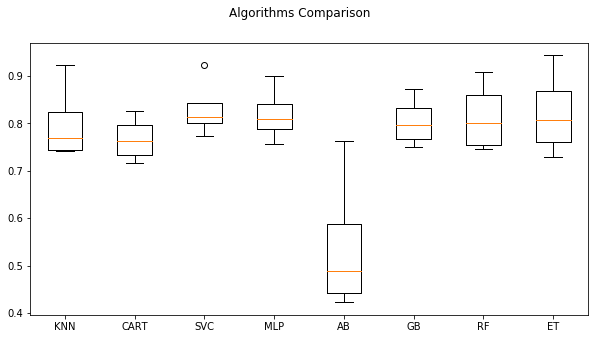

In [27]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi (MLP, GB e RF) su test

In [11]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed)
pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])
pipeline.fit(X_train_res, y_train_res) 
y_pred = pipeline.predict(X_test) 
print("MLP")
print(classification_report(y_test, y_pred))

MLP
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.29      0.40      0.33         5
           2       0.93      0.89      0.91        28

    accuracy                           0.76        45
   macro avg       0.62      0.63      0.62        45
weighted avg       0.78      0.76      0.77        45



c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
model = GradientBoostingClassifier(random_state=seed, n_estimators = 50)
pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])
pipeline.fit(X_train_res, y_train_res) 
y_pred = pipeline.predict(X_test) 
print("GB")
print(classification_report(y_test, y_pred))

GB
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.33      0.40      0.36         5
           2       0.96      0.93      0.95        28

    accuracy                           0.78        45
   macro avg       0.63      0.64      0.63        45
weighted avg       0.79      0.78      0.78        45



In [13]:
model = RandomForestClassifier(random_state=seed, n_estimators = 50)
pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])
pipeline.fit(X_train_res, y_train_res) 
y_pred = pipeline.predict(X_test) 
print("RF")
print(classification_report(y_test, y_pred))

RF
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.40      0.40      0.40         5
           2       0.96      0.93      0.95        28

    accuracy                           0.80        45
   macro avg       0.66      0.67      0.66        45
weighted avg       0.81      0.80      0.80        45



## Improve Results With Tuning

### MLP Tunining

In [3]:
import numpy as np
10.0 ** -np.arange(1, 5)

array([0.1   , 0.01  , 0.001 , 0.0001])

In [28]:
results_weighted = []
results_macro = []
names = []
num_tests = 4 * 3 * 3 * 4 * 5 * 4
i = 1

for activation in ['identity', 'logistic', 'tanh', 'relu']:
    for solver in ['lbfgs', 'sgd', 'adam']:
        for max_iter in [500, 1000, 1500]:
            for alpha in 10.0 ** -np.arange(1, 5):
                for random_state in [17, 29, 42, 76, 112]:
                    for hidden_layer_sizes in [(50,), (100,), (150,), (200,)]:
                        print("Testing {}/{}".format(i,num_tests))
                        i+=1
                        kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
                        sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
                        cv_results_weighted = np.array([])
                        cv_results_macro = np.array([])
                        for train_idx, test_idx, in kf.split(X_train, y_train):
                            X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
                            X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
                            X_cross_train, y_cross_train = sm.fit_sample(X_cross_train, y_cross_train)
                            model = MLPClassifier(activation=activation, solver=solver, max_iter=max_iter, alpha=alpha, 
                                      random_state=random_state, hidden_layer_sizes=hidden_layer_sizes )
                            model.fit(X_cross_train, y_cross_train)  
                            y_pred = model.predict(X_cross_test)
                            f1s_weight = f1_score(y_cross_test, y_pred, average="weighted")
                            f1s_macro = f1_score(y_cross_test, y_pred, average="macro")
                            cv_results_weighted = np.append(cv_results_weighted, [f1s_weight])
                            cv_results_macro = np.append(cv_results_macro, [f1s_macro])
                        results_weighted.append(cv_results_weighted)
                        results_macro.append(cv_results_macro)
                        name = "{} {} {} {} {} {}".format(activation, solver, max_iter, alpha, random_state, hidden_layer_sizes)
                        names.append(name)
                        msg = "%s: Weighted %f (%f)" % (name, cv_results_weighted.mean(), cv_results_weighted.std())
                        print(msg)
                        msg = "%s: Macro %f (%f)" % (name, cv_results_macro.mean(), cv_results_macro.std())
                        print(msg)

Testing 1/2880
identity lbfgs 500 0.1 17 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.1 17 (50,): Macro 0.727234 (0.071227)
Testing 2/2880
identity lbfgs 500 0.1 17 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.1 17 (100,): Macro 0.727234 (0.071227)
Testing 3/2880
identity lbfgs 500 0.1 17 (150,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.1 17 (150,): Macro 0.727234 (0.071227)
Testing 4/2880
identity lbfgs 500 0.1 17 (200,): Weighted 0.831829 (0.053027)
identity lbfgs 500 0.1 17 (200,): Macro 0.731083 (0.070659)
Testing 5/2880
identity lbfgs 500 0.1 29 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.1 29 (50,): Macro 0.727234 (0.071227)
Testing 6/2880
identity lbfgs 500 0.1 29 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.1 29 (100,): Macro 0.727234 (0.071227)
Testing 7/2880
identity lbfgs 500 0.1 29 (150,): Weighted 0.831829 (0.053027)
identity lbfgs 500 0.1 29 (150,): Macro 0.731083 (0.070659)
Testing 8/2880
identity lbfgs 500 0.1 

identity lbfgs 500 0.001 112 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.001 112 (200,): Macro 0.727234 (0.071227)
Testing 61/2880
identity lbfgs 500 0.0001 17 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 17 (50,): Macro 0.727234 (0.071227)
Testing 62/2880
identity lbfgs 500 0.0001 17 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 17 (100,): Macro 0.727234 (0.071227)
Testing 63/2880
identity lbfgs 500 0.0001 17 (150,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 17 (150,): Macro 0.727234 (0.071227)
Testing 64/2880
identity lbfgs 500 0.0001 17 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 17 (200,): Macro 0.727234 (0.071227)
Testing 65/2880
identity lbfgs 500 0.0001 29 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 29 (50,): Macro 0.727234 (0.071227)
Testing 66/2880
identity lbfgs 500 0.0001 29 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 500 0.0001 29 (100,): Macro 0.727234 (0.071227)
Testi

identity lbfgs 1000 0.01 112 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.01 112 (100,): Macro 0.727234 (0.071227)
Testing 119/2880
identity lbfgs 1000 0.01 112 (150,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.01 112 (150,): Macro 0.727234 (0.071227)
Testing 120/2880
identity lbfgs 1000 0.01 112 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.01 112 (200,): Macro 0.727234 (0.071227)
Testing 121/2880
identity lbfgs 1000 0.001 17 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.001 17 (50,): Macro 0.727234 (0.071227)
Testing 122/2880
identity lbfgs 1000 0.001 17 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.001 17 (100,): Macro 0.727234 (0.071227)
Testing 123/2880
identity lbfgs 1000 0.001 17 (150,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.001 17 (150,): Macro 0.727234 (0.071227)
Testing 124/2880
identity lbfgs 1000 0.001 17 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 1000 0.001 17 (200,): Macro 0.727234 (0.07122

identity lbfgs 1500 0.1 76 (150,): Weighted 0.831829 (0.053027)
identity lbfgs 1500 0.1 76 (150,): Macro 0.731083 (0.070659)
Testing 176/2880
identity lbfgs 1500 0.1 76 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.1 76 (200,): Macro 0.727234 (0.071227)
Testing 177/2880
identity lbfgs 1500 0.1 112 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.1 112 (50,): Macro 0.727234 (0.071227)
Testing 178/2880
identity lbfgs 1500 0.1 112 (100,): Weighted 0.831829 (0.053027)
identity lbfgs 1500 0.1 112 (100,): Macro 0.731083 (0.070659)
Testing 179/2880
identity lbfgs 1500 0.1 112 (150,): Weighted 0.831829 (0.053027)
identity lbfgs 1500 0.1 112 (150,): Macro 0.731083 (0.070659)
Testing 180/2880
identity lbfgs 1500 0.1 112 (200,): Weighted 0.831829 (0.053027)
identity lbfgs 1500 0.1 112 (200,): Macro 0.731083 (0.070659)
Testing 181/2880
identity lbfgs 1500 0.01 17 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.01 17 (50,): Macro 0.727234 (0.071227)
Testing 182/2880


identity lbfgs 1500 0.0001 42 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 42 (200,): Macro 0.727234 (0.071227)
Testing 233/2880
identity lbfgs 1500 0.0001 76 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 76 (50,): Macro 0.727234 (0.071227)
Testing 234/2880
identity lbfgs 1500 0.0001 76 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 76 (100,): Macro 0.727234 (0.071227)
Testing 235/2880
identity lbfgs 1500 0.0001 76 (150,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 76 (150,): Macro 0.727234 (0.071227)
Testing 236/2880
identity lbfgs 1500 0.0001 76 (200,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 76 (200,): Macro 0.727234 (0.071227)
Testing 237/2880
identity lbfgs 1500 0.0001 112 (50,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 112 (50,): Macro 0.727234 (0.071227)
Testing 238/2880
identity lbfgs 1500 0.0001 112 (100,): Weighted 0.828542 (0.053537)
identity lbfgs 1500 0.0001 112 (100,): Macro 0

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.1 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 500 0.1 17 (150,): Macro 0.627033 (0.075695)
Testing 244/2880
identity sgd 500 0.1 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 500 0.1 17 (200,): Macro 0.701073 (0.030654)
Testing 245/2880
identity sgd 500 0.1 29 (50,): Weighted 0.792112 (0.018799)
identity sgd 500 0.1 29 (50,): Macro 0.672446 (0.033605)
Testing 246/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.1 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 500 0.1 29 (100,): Macro 0.608846 (0.093717)
Testing 247/2880
identity sgd 500 0.1 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 500 0.1 29 (150,): Macro 0.739196 (0.075896)
Testing 248/2880
identity sgd 500 0.1 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 500 0.1 29 (200,): Macro 0.724254 (0.049655)
Testing 249/2880
identity sgd 500 0.1 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 500 0.1 42 (50,): Macro 0.654632 (0.067294)
Testing 250/2880
identity sgd 500 0.1 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 500 0.1 42 (100,): Macro 0.682452 (0.091159)
Testing 251/2880
identity sgd 500 0.1 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 500 0.1 42 (150,): Macro 0.621661 (0.059008)
Testing 252/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.1 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 500 0.1 42 (200,): Macro 0.613311 (0.101042)
Testing 253/2880
identity sgd 500 0.1 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 500 0.1 76 (50,): Macro 0.733157 (0.042704)
Testing 254/2880
identity sgd 500 0.1 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 500 0.1 76 (100,): Macro 0.708912 (0.093388)
Testing 255/2880
identity sgd 500 0.1 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 500 0.1 76 (150,): Macro 0.724810 (0.043496)
Testing 256/2880
identity sgd 500 0.1 76 (200,): Weighted 0.815669 (0.036343)
identity sgd 500 0.1 76 (200,): Macro 0.672267 (0.032133)
Testing 257/2880
identity sgd 500 0.1 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 500 0.1 112 (50,): Macro 0.653504 (0.104493)
Testing 258/2880
identity sgd 500 0.1 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 500 0.1 112 (100,): Macro 0.674963 (0.093295)
Testing 259/2880
identity sgd 500 0.1 112 (150,): Weighted 0.8069

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.01 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 500 0.01 17 (150,): Macro 0.627033 (0.075695)
Testing 264/2880
identity sgd 500 0.01 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 500 0.01 17 (200,): Macro 0.701073 (0.030654)
Testing 265/2880
identity sgd 500 0.01 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 500 0.01 29 (50,): Macro 0.665148 (0.026513)
Testing 266/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.01 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 500 0.01 29 (100,): Macro 0.608846 (0.093717)
Testing 267/2880
identity sgd 500 0.01 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 500 0.01 29 (150,): Macro 0.739196 (0.075896)
Testing 268/2880
identity sgd 500 0.01 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 500 0.01 29 (200,): Macro 0.724254 (0.049655)
Testing 269/2880
identity sgd 500 0.01 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 500 0.01 42 (50,): Macro 0.654632 (0.067294)
Testing 270/2880
identity sgd 500 0.01 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 500 0.01 42 (100,): Macro 0.682452 (0.091159)
Testing 271/2880
identity sgd 500 0.01 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 500 0.01 42 (150,): Macro 0.621661 (0.059008)
Testing 272/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.01 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 500 0.01 42 (200,): Macro 0.613311 (0.101042)
Testing 273/2880
identity sgd 500 0.01 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 500 0.01 76 (50,): Macro 0.733157 (0.042704)
Testing 274/2880
identity sgd 500 0.01 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 500 0.01 76 (100,): Macro 0.708912 (0.093388)
Testing 275/2880
identity sgd 500 0.01 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 500 0.01 76 (150,): Macro 0.724810 (0.043496)
Testing 276/2880
identity sgd 500 0.01 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 500 0.01 76 (200,): Macro 0.685244 (0.012808)
Testing 277/2880
identity sgd 500 0.01 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 500 0.01 112 (50,): Macro 0.653504 (0.104493)
Testing 278/2880
identity sgd 500 0.01 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 500 0.01 112 (100,): Macro 0.674963 (0.093295)
Testing 279/2880
identity sgd 500 0.01 112 (150,): 

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 500 0.001 17 (150,): Macro 0.627033 (0.075695)
Testing 284/2880
identity sgd 500 0.001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 500 0.001 17 (200,): Macro 0.701073 (0.030654)
Testing 285/2880
identity sgd 500 0.001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 500 0.001 29 (50,): Macro 0.665148 (0.026513)
Testing 286/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 500 0.001 29 (100,): Macro 0.608846 (0.093717)
Testing 287/2880
identity sgd 500 0.001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 500 0.001 29 (150,): Macro 0.739196 (0.075896)
Testing 288/2880
identity sgd 500 0.001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 500 0.001 29 (200,): Macro 0.724254 (0.049655)
Testing 289/2880
identity sgd 500 0.001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 500 0.001 42 (50,): Macro 0.654632 (0.067294)
Testing 290/2880
identity sgd 500 0.001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 500 0.001 42 (100,): Macro 0.682452 (0.091159)
Testing 291/2880
identity sgd 500 0.001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 500 0.001 42 (150,): Macro 0.621661 (0.059008)
Testing 292/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 500 0.001 42 (200,): Macro 0.613311 (0.101042)
Testing 293/2880
identity sgd 500 0.001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 500 0.001 76 (50,): Macro 0.733157 (0.042704)
Testing 294/2880
identity sgd 500 0.001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 500 0.001 76 (100,): Macro 0.708912 (0.093388)
Testing 295/2880
identity sgd 500 0.001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 500 0.001 76 (150,): Macro 0.724810 (0.043496)
Testing 296/2880
identity sgd 500 0.001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 500 0.001 76 (200,): Macro 0.685244 (0.012808)
Testing 297/2880
identity sgd 500 0.001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 500 0.001 112 (50,): Macro 0.653504 (0.104493)
Testing 298/2880
identity sgd 500 0.001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 500 0.001 112 (100,): Macro 0.674963 (0.093295)
Testing 299/2880
identity sgd 500 0.0

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.0001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 500 0.0001 17 (150,): Macro 0.627033 (0.075695)
Testing 304/2880
identity sgd 500 0.0001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 500 0.0001 17 (200,): Macro 0.701073 (0.030654)
Testing 305/2880
identity sgd 500 0.0001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 500 0.0001 29 (50,): Macro 0.665148 (0.026513)
Testing 306/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.0001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 500 0.0001 29 (100,): Macro 0.608846 (0.093717)
Testing 307/2880
identity sgd 500 0.0001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 500 0.0001 29 (150,): Macro 0.739196 (0.075896)
Testing 308/2880
identity sgd 500 0.0001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 500 0.0001 29 (200,): Macro 0.724254 (0.049655)
Testing 309/2880
identity sgd 500 0.0001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 500 0.0001 42 (50,): Macro 0.654632 (0.067294)
Testing 310/2880
identity sgd 500 0.0001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 500 0.0001 42 (100,): Macro 0.682452 (0.091159)
Testing 311/2880
identity sgd 500 0.0001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 500 0.0001 42 (150,): Macro 0.621661 (0.059008)
Testing 312/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 500 0.0001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 500 0.0001 42 (200,): Macro 0.613311 (0.101042)
Testing 313/2880
identity sgd 500 0.0001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 500 0.0001 76 (50,): Macro 0.733157 (0.042704)
Testing 314/2880
identity sgd 500 0.0001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 500 0.0001 76 (100,): Macro 0.708912 (0.093388)
Testing 315/2880
identity sgd 500 0.0001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 500 0.0001 76 (150,): Macro 0.724810 (0.043496)
Testing 316/2880
identity sgd 500 0.0001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 500 0.0001 76 (200,): Macro 0.685244 (0.012808)
Testing 317/2880
identity sgd 500 0.0001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 500 0.0001 112 (50,): Macro 0.653504 (0.104493)
Testing 318/2880
identity sgd 500 0.0001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 500 0.0001 112 (100,): Macro 0.674963 (0.093295)
Testing 319/2880
identi

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.1 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1000 0.1 17 (150,): Macro 0.627033 (0.075695)
Testing 324/2880
identity sgd 1000 0.1 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1000 0.1 17 (200,): Macro 0.701073 (0.030654)
Testing 325/2880
identity sgd 1000 0.1 29 (50,): Weighted 0.792112 (0.018799)
identity sgd 1000 0.1 29 (50,): Macro 0.672446 (0.033605)
Testing 326/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.1 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1000 0.1 29 (100,): Macro 0.608846 (0.093717)
Testing 327/2880
identity sgd 1000 0.1 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1000 0.1 29 (150,): Macro 0.739196 (0.075896)
Testing 328/2880
identity sgd 1000 0.1 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1000 0.1 29 (200,): Macro 0.724254 (0.049655)
Testing 329/2880
identity sgd 1000 0.1 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1000 0.1 42 (50,): Macro 0.654632 (0.067294)
Testing 330/2880
identity sgd 1000 0.1 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1000 0.1 42 (100,): Macro 0.682452 (0.091159)
Testing 331/2880
identity sgd 1000 0.1 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1000 0.1 42 (150,): Macro 0.621661 (0.059008)
Testing 332/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.1 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1000 0.1 42 (200,): Macro 0.613311 (0.101042)
Testing 333/2880
identity sgd 1000 0.1 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1000 0.1 76 (50,): Macro 0.733157 (0.042704)
Testing 334/2880
identity sgd 1000 0.1 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1000 0.1 76 (100,): Macro 0.708912 (0.093388)
Testing 335/2880
identity sgd 1000 0.1 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1000 0.1 76 (150,): Macro 0.724810 (0.043496)
Testing 336/2880
identity sgd 1000 0.1 76 (200,): Weighted 0.815669 (0.036343)
identity sgd 1000 0.1 76 (200,): Macro 0.672267 (0.032133)
Testing 337/2880
identity sgd 1000 0.1 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1000 0.1 112 (50,): Macro 0.653504 (0.104493)
Testing 338/2880
identity sgd 1000 0.1 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1000 0.1 112 (100,): Macro 0.674963 (0.093295)
Testing 339/2880
identity sgd 1000 0.1 112 (150,): 

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.01 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1000 0.01 17 (150,): Macro 0.627033 (0.075695)
Testing 344/2880
identity sgd 1000 0.01 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1000 0.01 17 (200,): Macro 0.701073 (0.030654)
Testing 345/2880
identity sgd 1000 0.01 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1000 0.01 29 (50,): Macro 0.665148 (0.026513)
Testing 346/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.01 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1000 0.01 29 (100,): Macro 0.608846 (0.093717)
Testing 347/2880
identity sgd 1000 0.01 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1000 0.01 29 (150,): Macro 0.739196 (0.075896)
Testing 348/2880
identity sgd 1000 0.01 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1000 0.01 29 (200,): Macro 0.724254 (0.049655)
Testing 349/2880
identity sgd 1000 0.01 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1000 0.01 42 (50,): Macro 0.654632 (0.067294)
Testing 350/2880
identity sgd 1000 0.01 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1000 0.01 42 (100,): Macro 0.682452 (0.091159)
Testing 351/2880
identity sgd 1000 0.01 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1000 0.01 42 (150,): Macro 0.621661 (0.059008)
Testing 352/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.01 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1000 0.01 42 (200,): Macro 0.613311 (0.101042)
Testing 353/2880
identity sgd 1000 0.01 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1000 0.01 76 (50,): Macro 0.733157 (0.042704)
Testing 354/2880
identity sgd 1000 0.01 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1000 0.01 76 (100,): Macro 0.708912 (0.093388)
Testing 355/2880
identity sgd 1000 0.01 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1000 0.01 76 (150,): Macro 0.724810 (0.043496)
Testing 356/2880
identity sgd 1000 0.01 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1000 0.01 76 (200,): Macro 0.685244 (0.012808)
Testing 357/2880
identity sgd 1000 0.01 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1000 0.01 112 (50,): Macro 0.653504 (0.104493)
Testing 358/2880
identity sgd 1000 0.01 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1000 0.01 112 (100,): Macro 0.674963 (0.093295)
Testing 359/2880
identity sgd 1000 0.

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1000 0.001 17 (150,): Macro 0.627033 (0.075695)
Testing 364/2880
identity sgd 1000 0.001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1000 0.001 17 (200,): Macro 0.701073 (0.030654)
Testing 365/2880
identity sgd 1000 0.001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1000 0.001 29 (50,): Macro 0.665148 (0.026513)
Testing 366/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1000 0.001 29 (100,): Macro 0.608846 (0.093717)
Testing 367/2880
identity sgd 1000 0.001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1000 0.001 29 (150,): Macro 0.739196 (0.075896)
Testing 368/2880
identity sgd 1000 0.001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1000 0.001 29 (200,): Macro 0.724254 (0.049655)
Testing 369/2880
identity sgd 1000 0.001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1000 0.001 42 (50,): Macro 0.654632 (0.067294)
Testing 370/2880
identity sgd 1000 0.001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1000 0.001 42 (100,): Macro 0.682452 (0.091159)
Testing 371/2880
identity sgd 1000 0.001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1000 0.001 42 (150,): Macro 0.621661 (0.059008)
Testing 372/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1000 0.001 42 (200,): Macro 0.613311 (0.101042)
Testing 373/2880
identity sgd 1000 0.001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1000 0.001 76 (50,): Macro 0.733157 (0.042704)
Testing 374/2880
identity sgd 1000 0.001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1000 0.001 76 (100,): Macro 0.708912 (0.093388)
Testing 375/2880
identity sgd 1000 0.001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1000 0.001 76 (150,): Macro 0.724810 (0.043496)
Testing 376/2880
identity sgd 1000 0.001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1000 0.001 76 (200,): Macro 0.685244 (0.012808)
Testing 377/2880
identity sgd 1000 0.001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1000 0.001 112 (50,): Macro 0.653504 (0.104493)
Testing 378/2880
identity sgd 1000 0.001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1000 0.001 112 (100,): Macro 0.674963 (0.093295)
Testing 379/2880
identi

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.0001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1000 0.0001 17 (150,): Macro 0.627033 (0.075695)
Testing 384/2880
identity sgd 1000 0.0001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1000 0.0001 17 (200,): Macro 0.701073 (0.030654)
Testing 385/2880
identity sgd 1000 0.0001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1000 0.0001 29 (50,): Macro 0.665148 (0.026513)
Testing 386/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.0001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1000 0.0001 29 (100,): Macro 0.608846 (0.093717)
Testing 387/2880
identity sgd 1000 0.0001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1000 0.0001 29 (150,): Macro 0.739196 (0.075896)
Testing 388/2880
identity sgd 1000 0.0001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1000 0.0001 29 (200,): Macro 0.724254 (0.049655)
Testing 389/2880
identity sgd 1000 0.0001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1000 0.0001 42 (50,): Macro 0.654632 (0.067294)
Testing 390/2880
identity sgd 1000 0.0001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1000 0.0001 42 (100,): Macro 0.682452 (0.091159)
Testing 391/2880
identity sgd 1000 0.0001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1000 0.0001 42 (150,): Macro 0.621661 (0.059008)
Testing 392/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1000 0.0001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1000 0.0001 42 (200,): Macro 0.613311 (0.101042)
Testing 393/2880
identity sgd 1000 0.0001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1000 0.0001 76 (50,): Macro 0.733157 (0.042704)
Testing 394/2880
identity sgd 1000 0.0001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1000 0.0001 76 (100,): Macro 0.708912 (0.093388)
Testing 395/2880
identity sgd 1000 0.0001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1000 0.0001 76 (150,): Macro 0.724810 (0.043496)
Testing 396/2880
identity sgd 1000 0.0001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1000 0.0001 76 (200,): Macro 0.685244 (0.012808)
Testing 397/2880
identity sgd 1000 0.0001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1000 0.0001 112 (50,): Macro 0.653504 (0.104493)
Testing 398/2880
identity sgd 1000 0.0001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1000 0.0001 112 (100,): Macro 0.674963 (0.093295)
Testing 3

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.1 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1500 0.1 17 (150,): Macro 0.627033 (0.075695)
Testing 404/2880
identity sgd 1500 0.1 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1500 0.1 17 (200,): Macro 0.701073 (0.030654)
Testing 405/2880
identity sgd 1500 0.1 29 (50,): Weighted 0.792112 (0.018799)
identity sgd 1500 0.1 29 (50,): Macro 0.672446 (0.033605)
Testing 406/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.1 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1500 0.1 29 (100,): Macro 0.608846 (0.093717)
Testing 407/2880
identity sgd 1500 0.1 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1500 0.1 29 (150,): Macro 0.739196 (0.075896)
Testing 408/2880
identity sgd 1500 0.1 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1500 0.1 29 (200,): Macro 0.724254 (0.049655)
Testing 409/2880
identity sgd 1500 0.1 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1500 0.1 42 (50,): Macro 0.654632 (0.067294)
Testing 410/2880
identity sgd 1500 0.1 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1500 0.1 42 (100,): Macro 0.682452 (0.091159)
Testing 411/2880
identity sgd 1500 0.1 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1500 0.1 42 (150,): Macro 0.621661 (0.059008)
Testing 412/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.1 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1500 0.1 42 (200,): Macro 0.613311 (0.101042)
Testing 413/2880
identity sgd 1500 0.1 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1500 0.1 76 (50,): Macro 0.733157 (0.042704)
Testing 414/2880
identity sgd 1500 0.1 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1500 0.1 76 (100,): Macro 0.708912 (0.093388)
Testing 415/2880
identity sgd 1500 0.1 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1500 0.1 76 (150,): Macro 0.724810 (0.043496)
Testing 416/2880
identity sgd 1500 0.1 76 (200,): Weighted 0.815669 (0.036343)
identity sgd 1500 0.1 76 (200,): Macro 0.672267 (0.032133)
Testing 417/2880
identity sgd 1500 0.1 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1500 0.1 112 (50,): Macro 0.653504 (0.104493)
Testing 418/2880
identity sgd 1500 0.1 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1500 0.1 112 (100,): Macro 0.674963 (0.093295)
Testing 419/2880
identity sgd 1500 0.1 112 (150,): 

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.01 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1500 0.01 17 (150,): Macro 0.627033 (0.075695)
Testing 424/2880
identity sgd 1500 0.01 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1500 0.01 17 (200,): Macro 0.701073 (0.030654)
Testing 425/2880
identity sgd 1500 0.01 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1500 0.01 29 (50,): Macro 0.665148 (0.026513)
Testing 426/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.01 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1500 0.01 29 (100,): Macro 0.608846 (0.093717)
Testing 427/2880
identity sgd 1500 0.01 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1500 0.01 29 (150,): Macro 0.739196 (0.075896)
Testing 428/2880
identity sgd 1500 0.01 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1500 0.01 29 (200,): Macro 0.724254 (0.049655)
Testing 429/2880
identity sgd 1500 0.01 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1500 0.01 42 (50,): Macro 0.654632 (0.067294)
Testing 430/2880
identity sgd 1500 0.01 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1500 0.01 42 (100,): Macro 0.682452 (0.091159)
Testing 431/2880
identity sgd 1500 0.01 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1500 0.01 42 (150,): Macro 0.621661 (0.059008)
Testing 432/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.01 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1500 0.01 42 (200,): Macro 0.613311 (0.101042)
Testing 433/2880
identity sgd 1500 0.01 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1500 0.01 76 (50,): Macro 0.733157 (0.042704)
Testing 434/2880
identity sgd 1500 0.01 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1500 0.01 76 (100,): Macro 0.708912 (0.093388)
Testing 435/2880
identity sgd 1500 0.01 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1500 0.01 76 (150,): Macro 0.724810 (0.043496)
Testing 436/2880
identity sgd 1500 0.01 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1500 0.01 76 (200,): Macro 0.685244 (0.012808)
Testing 437/2880
identity sgd 1500 0.01 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1500 0.01 112 (50,): Macro 0.653504 (0.104493)
Testing 438/2880
identity sgd 1500 0.01 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1500 0.01 112 (100,): Macro 0.674963 (0.093295)
Testing 439/2880
identity sgd 1500 0.

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1500 0.001 17 (150,): Macro 0.627033 (0.075695)
Testing 444/2880
identity sgd 1500 0.001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1500 0.001 17 (200,): Macro 0.701073 (0.030654)
Testing 445/2880
identity sgd 1500 0.001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1500 0.001 29 (50,): Macro 0.665148 (0.026513)
Testing 446/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1500 0.001 29 (100,): Macro 0.608846 (0.093717)
Testing 447/2880
identity sgd 1500 0.001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1500 0.001 29 (150,): Macro 0.739196 (0.075896)
Testing 448/2880
identity sgd 1500 0.001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1500 0.001 29 (200,): Macro 0.724254 (0.049655)
Testing 449/2880
identity sgd 1500 0.001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1500 0.001 42 (50,): Macro 0.654632 (0.067294)
Testing 450/2880
identity sgd 1500 0.001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1500 0.001 42 (100,): Macro 0.682452 (0.091159)
Testing 451/2880
identity sgd 1500 0.001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1500 0.001 42 (150,): Macro 0.621661 (0.059008)
Testing 452/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1500 0.001 42 (200,): Macro 0.613311 (0.101042)
Testing 453/2880
identity sgd 1500 0.001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1500 0.001 76 (50,): Macro 0.733157 (0.042704)
Testing 454/2880
identity sgd 1500 0.001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1500 0.001 76 (100,): Macro 0.708912 (0.093388)
Testing 455/2880
identity sgd 1500 0.001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1500 0.001 76 (150,): Macro 0.724810 (0.043496)
Testing 456/2880
identity sgd 1500 0.001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1500 0.001 76 (200,): Macro 0.685244 (0.012808)
Testing 457/2880
identity sgd 1500 0.001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1500 0.001 112 (50,): Macro 0.653504 (0.104493)
Testing 458/2880
identity sgd 1500 0.001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1500 0.001 112 (100,): Macro 0.674963 (0.093295)
Testing 459/2880
identi

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.0001 17 (150,): Weighted 0.774621 (0.066585)
identity sgd 1500 0.0001 17 (150,): Macro 0.627033 (0.075695)
Testing 464/2880
identity sgd 1500 0.0001 17 (200,): Weighted 0.825226 (0.028922)
identity sgd 1500 0.0001 17 (200,): Macro 0.701073 (0.030654)
Testing 465/2880
identity sgd 1500 0.0001 29 (50,): Weighted 0.786625 (0.014808)
identity sgd 1500 0.0001 29 (50,): Macro 0.665148 (0.026513)
Testing 466/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.0001 29 (100,): Weighted 0.744469 (0.095323)
identity sgd 1500 0.0001 29 (100,): Macro 0.608846 (0.093717)
Testing 467/2880
identity sgd 1500 0.0001 29 (150,): Weighted 0.842721 (0.053206)
identity sgd 1500 0.0001 29 (150,): Macro 0.739196 (0.075896)
Testing 468/2880
identity sgd 1500 0.0001 29 (200,): Weighted 0.827534 (0.031094)
identity sgd 1500 0.0001 29 (200,): Macro 0.724254 (0.049655)
Testing 469/2880
identity sgd 1500 0.0001 42 (50,): Weighted 0.793519 (0.072322)
identity sgd 1500 0.0001 42 (50,): Macro 0.654632 (0.067294)
Testing 470/2880
identity sgd 1500 0.0001 42 (100,): Weighted 0.799299 (0.073565)
identity sgd 1500 0.0001 42 (100,): Macro 0.682452 (0.091159)
Testing 471/2880
identity sgd 1500 0.0001 42 (150,): Weighted 0.761645 (0.064015)
identity sgd 1500 0.0001 42 (150,): Macro 0.621661 (0.059008)
Testing 472/2880


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


identity sgd 1500 0.0001 42 (200,): Weighted 0.738267 (0.083410)
identity sgd 1500 0.0001 42 (200,): Macro 0.613311 (0.101042)
Testing 473/2880
identity sgd 1500 0.0001 76 (50,): Weighted 0.839807 (0.041719)
identity sgd 1500 0.0001 76 (50,): Macro 0.733157 (0.042704)
Testing 474/2880
identity sgd 1500 0.0001 76 (100,): Weighted 0.809693 (0.071613)
identity sgd 1500 0.0001 76 (100,): Macro 0.708912 (0.093388)
Testing 475/2880
identity sgd 1500 0.0001 76 (150,): Weighted 0.833693 (0.039245)
identity sgd 1500 0.0001 76 (150,): Macro 0.724810 (0.043496)
Testing 476/2880
identity sgd 1500 0.0001 76 (200,): Weighted 0.824168 (0.024805)
identity sgd 1500 0.0001 76 (200,): Macro 0.685244 (0.012808)
Testing 477/2880
identity sgd 1500 0.0001 112 (50,): Weighted 0.772379 (0.084887)
identity sgd 1500 0.0001 112 (50,): Macro 0.653504 (0.104493)
Testing 478/2880
identity sgd 1500 0.0001 112 (100,): Weighted 0.794962 (0.080096)
identity sgd 1500 0.0001 112 (100,): Macro 0.674963 (0.093295)
Testing 4

identity adam 500 0.001 42 (150,): Weighted 0.836578 (0.061903)
identity adam 500 0.001 42 (150,): Macro 0.740263 (0.089580)
Testing 532/2880
identity adam 500 0.001 42 (200,): Weighted 0.822574 (0.059569)
identity adam 500 0.001 42 (200,): Macro 0.704945 (0.072077)
Testing 533/2880
identity adam 500 0.001 76 (50,): Weighted 0.827111 (0.058437)
identity adam 500 0.001 76 (50,): Macro 0.720610 (0.082709)
Testing 534/2880
identity adam 500 0.001 76 (100,): Weighted 0.833179 (0.052295)
identity adam 500 0.001 76 (100,): Macro 0.729152 (0.074302)
Testing 535/2880
identity adam 500 0.001 76 (150,): Weighted 0.836903 (0.069694)
identity adam 500 0.001 76 (150,): Macro 0.732472 (0.095196)
Testing 536/2880
identity adam 500 0.001 76 (200,): Weighted 0.830930 (0.051817)
identity adam 500 0.001 76 (200,): Macro 0.718506 (0.059186)
Testing 537/2880
identity adam 500 0.001 112 (50,): Weighted 0.829335 (0.069587)
identity adam 500 0.001 112 (50,): Macro 0.720950 (0.094275)
Testing 538/2880
identity

identity adam 1000 0.01 42 (50,): Weighted 0.820174 (0.052532)
identity adam 1000 0.01 42 (50,): Macro 0.700651 (0.059261)
Testing 590/2880
identity adam 1000 0.01 42 (100,): Weighted 0.840739 (0.039074)
identity adam 1000 0.01 42 (100,): Macro 0.739436 (0.051953)
Testing 591/2880
identity adam 1000 0.01 42 (150,): Weighted 0.836578 (0.061903)
identity adam 1000 0.01 42 (150,): Macro 0.740263 (0.089580)
Testing 592/2880
identity adam 1000 0.01 42 (200,): Weighted 0.822574 (0.059569)
identity adam 1000 0.01 42 (200,): Macro 0.704945 (0.072077)
Testing 593/2880
identity adam 1000 0.01 76 (50,): Weighted 0.827111 (0.058437)
identity adam 1000 0.01 76 (50,): Macro 0.720610 (0.082709)
Testing 594/2880
identity adam 1000 0.01 76 (100,): Weighted 0.833179 (0.052295)
identity adam 1000 0.01 76 (100,): Macro 0.729152 (0.074302)
Testing 595/2880
identity adam 1000 0.01 76 (150,): Weighted 0.836903 (0.069694)
identity adam 1000 0.01 76 (150,): Macro 0.732472 (0.095196)
Testing 596/2880
identity a

identity adam 1500 0.1 29 (100,): Weighted 0.821737 (0.058741)
identity adam 1500 0.1 29 (100,): Macro 0.715107 (0.076722)
Testing 647/2880
identity adam 1500 0.1 29 (150,): Weighted 0.821336 (0.051270)
identity adam 1500 0.1 29 (150,): Macro 0.706723 (0.065262)
Testing 648/2880
identity adam 1500 0.1 29 (200,): Weighted 0.842079 (0.060805)
identity adam 1500 0.1 29 (200,): Macro 0.745742 (0.084501)
Testing 649/2880
identity adam 1500 0.1 42 (50,): Weighted 0.820174 (0.052532)
identity adam 1500 0.1 42 (50,): Macro 0.700651 (0.059261)
Testing 650/2880
identity adam 1500 0.1 42 (100,): Weighted 0.840739 (0.039074)
identity adam 1500 0.1 42 (100,): Macro 0.739436 (0.051953)
Testing 651/2880
identity adam 1500 0.1 42 (150,): Weighted 0.836578 (0.061903)
identity adam 1500 0.1 42 (150,): Macro 0.740263 (0.089580)
Testing 652/2880
identity adam 1500 0.1 42 (200,): Weighted 0.822574 (0.059569)
identity adam 1500 0.1 42 (200,): Macro 0.704945 (0.072077)
Testing 653/2880
identity adam 1500 0.1

identity adam 1500 0.0001 17 (200,): Weighted 0.838398 (0.058099)
identity adam 1500 0.0001 17 (200,): Macro 0.736715 (0.078337)
Testing 705/2880
identity adam 1500 0.0001 29 (50,): Weighted 0.841356 (0.075253)
identity adam 1500 0.0001 29 (50,): Macro 0.744836 (0.109097)
Testing 706/2880
identity adam 1500 0.0001 29 (100,): Weighted 0.821737 (0.058741)
identity adam 1500 0.0001 29 (100,): Macro 0.715107 (0.076722)
Testing 707/2880
identity adam 1500 0.0001 29 (150,): Weighted 0.821336 (0.051270)
identity adam 1500 0.0001 29 (150,): Macro 0.706723 (0.065262)
Testing 708/2880
identity adam 1500 0.0001 29 (200,): Weighted 0.842079 (0.060805)
identity adam 1500 0.0001 29 (200,): Macro 0.745742 (0.084501)
Testing 709/2880
identity adam 1500 0.0001 42 (50,): Weighted 0.820174 (0.052532)
identity adam 1500 0.0001 42 (50,): Macro 0.700651 (0.059261)
Testing 710/2880
identity adam 1500 0.0001 42 (100,): Weighted 0.840739 (0.039074)
identity adam 1500 0.0001 42 (100,): Macro 0.739436 (0.051953)

logistic lbfgs 500 0.001 17 (100,): Weighted 0.813036 (0.055303)
logistic lbfgs 500 0.001 17 (100,): Macro 0.706153 (0.054038)
Testing 763/2880
logistic lbfgs 500 0.001 17 (150,): Weighted 0.791448 (0.063686)
logistic lbfgs 500 0.001 17 (150,): Macro 0.665812 (0.083726)
Testing 764/2880
logistic lbfgs 500 0.001 17 (200,): Weighted 0.783679 (0.024440)
logistic lbfgs 500 0.001 17 (200,): Macro 0.644727 (0.016134)
Testing 765/2880
logistic lbfgs 500 0.001 29 (50,): Weighted 0.787398 (0.055486)
logistic lbfgs 500 0.001 29 (50,): Macro 0.661469 (0.046036)
Testing 766/2880
logistic lbfgs 500 0.001 29 (100,): Weighted 0.783535 (0.061135)
logistic lbfgs 500 0.001 29 (100,): Macro 0.648106 (0.075358)
Testing 767/2880
logistic lbfgs 500 0.001 29 (150,): Weighted 0.791194 (0.069993)
logistic lbfgs 500 0.001 29 (150,): Macro 0.662234 (0.092400)
Testing 768/2880
logistic lbfgs 500 0.001 29 (200,): Weighted 0.810019 (0.067630)
logistic lbfgs 500 0.001 29 (200,): Macro 0.704918 (0.098668)
Testing 769

c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


logistic lbfgs 500 0.001 42 (100,): Weighted 0.740025 (0.043353)
logistic lbfgs 500 0.001 42 (100,): Macro 0.577455 (0.017122)
Testing 771/2880
logistic lbfgs 500 0.001 42 (150,): Weighted 0.803857 (0.045518)
logistic lbfgs 500 0.001 42 (150,): Macro 0.679930 (0.044330)
Testing 772/2880
logistic lbfgs 500 0.001 42 (200,): Weighted 0.827367 (0.040459)
logistic lbfgs 500 0.001 42 (200,): Macro 0.718386 (0.052046)
Testing 773/2880
logistic lbfgs 500 0.001 76 (50,): Weighted 0.789664 (0.032202)
logistic lbfgs 500 0.001 76 (50,): Macro 0.658082 (0.037295)
Testing 774/2880
logistic lbfgs 500 0.001 76 (100,): Weighted 0.775774 (0.064637)
logistic lbfgs 500 0.001 76 (100,): Macro 0.645063 (0.094536)
Testing 775/2880
logistic lbfgs 500 0.001 76 (150,): Weighted 0.791666 (0.068851)
logistic lbfgs 500 0.001 76 (150,): Macro 0.673419 (0.086925)
Testing 776/2880
logistic lbfgs 500 0.001 76 (200,): Weighted 0.767094 (0.083728)
logistic lbfgs 500 0.001 76 (200,): Macro 0.651148 (0.094526)
Testing 777

logistic lbfgs 1000 0.01 29 (150,): Weighted 0.819854 (0.067335)
logistic lbfgs 1000 0.01 29 (150,): Macro 0.714746 (0.085867)
Testing 828/2880
logistic lbfgs 1000 0.01 29 (200,): Weighted 0.795085 (0.059661)
logistic lbfgs 1000 0.01 29 (200,): Macro 0.658502 (0.073317)
Testing 829/2880
logistic lbfgs 1000 0.01 42 (50,): Weighted 0.820720 (0.058963)
logistic lbfgs 1000 0.01 42 (50,): Macro 0.702685 (0.077473)
Testing 830/2880
logistic lbfgs 1000 0.01 42 (100,): Weighted 0.788738 (0.049886)
logistic lbfgs 1000 0.01 42 (100,): Macro 0.659599 (0.050773)
Testing 831/2880
logistic lbfgs 1000 0.01 42 (150,): Weighted 0.795114 (0.059876)
logistic lbfgs 1000 0.01 42 (150,): Macro 0.653637 (0.084863)
Testing 832/2880
logistic lbfgs 1000 0.01 42 (200,): Weighted 0.814581 (0.060958)
logistic lbfgs 1000 0.01 42 (200,): Macro 0.700161 (0.082941)
Testing 833/2880
logistic lbfgs 1000 0.01 76 (50,): Weighted 0.793210 (0.025184)
logistic lbfgs 1000 0.01 76 (50,): Macro 0.652370 (0.017041)
Testing 834/2

logistic lbfgs 1500 0.1 17 (200,): Weighted 0.833476 (0.053576)
logistic lbfgs 1500 0.1 17 (200,): Macro 0.723401 (0.070944)
Testing 885/2880
logistic lbfgs 1500 0.1 29 (50,): Weighted 0.803090 (0.059969)
logistic lbfgs 1500 0.1 29 (50,): Macro 0.679153 (0.081486)
Testing 886/2880
logistic lbfgs 1500 0.1 29 (100,): Weighted 0.812939 (0.051048)
logistic lbfgs 1500 0.1 29 (100,): Macro 0.696683 (0.065424)
Testing 887/2880
logistic lbfgs 1500 0.1 29 (150,): Weighted 0.812719 (0.052129)
logistic lbfgs 1500 0.1 29 (150,): Macro 0.688790 (0.067486)
Testing 888/2880
logistic lbfgs 1500 0.1 29 (200,): Weighted 0.807477 (0.055101)
logistic lbfgs 1500 0.1 29 (200,): Macro 0.683561 (0.078968)
Testing 889/2880
logistic lbfgs 1500 0.1 42 (50,): Weighted 0.820415 (0.067403)
logistic lbfgs 1500 0.1 42 (50,): Macro 0.708247 (0.092998)
Testing 890/2880
logistic lbfgs 1500 0.1 42 (100,): Weighted 0.825732 (0.037177)
logistic lbfgs 1500 0.1 42 (100,): Macro 0.713659 (0.041372)
Testing 891/2880
logistic l

logistic lbfgs 1500 0.0001 17 (50,): Weighted 0.799576 (0.040013)
logistic lbfgs 1500 0.0001 17 (50,): Macro 0.677267 (0.065615)
Testing 942/2880
logistic lbfgs 1500 0.0001 17 (100,): Weighted 0.809225 (0.064401)
logistic lbfgs 1500 0.0001 17 (100,): Macro 0.704567 (0.082843)
Testing 943/2880
logistic lbfgs 1500 0.0001 17 (150,): Weighted 0.746853 (0.048943)
logistic lbfgs 1500 0.0001 17 (150,): Macro 0.581486 (0.065064)
Testing 944/2880
logistic lbfgs 1500 0.0001 17 (200,): Weighted 0.771293 (0.057367)
logistic lbfgs 1500 0.0001 17 (200,): Macro 0.623788 (0.067852)
Testing 945/2880
logistic lbfgs 1500 0.0001 29 (50,): Weighted 0.763806 (0.062040)
logistic lbfgs 1500 0.0001 29 (50,): Macro 0.629247 (0.072274)
Testing 946/2880
logistic lbfgs 1500 0.0001 29 (100,): Weighted 0.768952 (0.069301)
logistic lbfgs 1500 0.0001 29 (100,): Macro 0.640115 (0.093647)
Testing 947/2880
logistic lbfgs 1500 0.0001 29 (150,): Weighted 0.774596 (0.025387)
logistic lbfgs 1500 0.0001 29 (150,): Macro 0.647

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 17 (50,): Weighted 0.844185 (0.063174)
logistic sgd 500 0.1 17 (50,): Macro 0.745049 (0.084795)
Testing 962/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 17 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.1 17 (100,): Macro 0.738188 (0.086177)
Testing 963/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 17 (150,): Weighted 0.844466 (0.065587)
logistic sgd 500 0.1 17 (150,): Macro 0.744619 (0.089343)
Testing 964/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 17 (200,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.1 17 (200,): Macro 0.730437 (0.086566)
Testing 965/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 500 0.1 29 (50,): Macro 0.727779 (0.090798)
Testing 966/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 29 (100,): Weighted 0.831554 (0.067942)
logistic sgd 500 0.1 29 (100,): Macro 0.722780 (0.093537)
Testing 967/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 29 (150,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.1 29 (150,): Macro 0.730437 (0.086566)
Testing 968/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 29 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.1 29 (200,): Macro 0.737519 (0.087102)
Testing 969/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 42 (50,): Weighted 0.832396 (0.064016)
logistic sgd 500 0.1 42 (50,): Macro 0.727027 (0.086583)
Testing 970/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 42 (100,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.1 42 (100,): Macro 0.728448 (0.089984)
Testing 971/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 42 (150,): Weighted 0.845790 (0.063820)
logistic sgd 500 0.1 42 (150,): Macro 0.745288 (0.088388)
Testing 972/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 42 (200,): Weighted 0.836765 (0.064603)
logistic sgd 500 0.1 42 (200,): Macro 0.732153 (0.088175)
Testing 973/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 76 (50,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.1 76 (50,): Macro 0.728448 (0.089984)
Testing 974/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 76 (100,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.1 76 (100,): Macro 0.737519 (0.087102)
Testing 975/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 76 (150,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.1 76 (150,): Macro 0.738188 (0.086177)
Testing 976/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 76 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.1 76 (200,): Macro 0.737519 (0.087102)
Testing 977/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 112 (50,): Weighted 0.820818 (0.061339)
logistic sgd 500 0.1 112 (50,): Macro 0.704717 (0.072301)
Testing 978/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.1 112 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.1 112 (100,): Macro 0.738188 (0.086177)
Testing 979/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 112 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.1 112 (150,): Macro 0.737519 (0.087102)
Testing 980/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.1 112 (200,): Weighted 0.834869 (0.061611)
logistic sgd 500 0.1 112 (200,): Macro 0.728647 (0.082804)
Testing 981/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 17 (50,): Weighted 0.844185 (0.063174)
logistic sgd 500 0.01 17 (50,): Macro 0.745049 (0.084795)
Testing 982/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 17 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.01 17 (100,): Macro 0.738188 (0.086177)
Testing 983/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 17 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.01 17 (150,): Macro 0.737519 (0.087102)
Testing 984/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 17 (200,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.01 17 (200,): Macro 0.730437 (0.086566)
Testing 985/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 500 0.01 29 (50,): Macro 0.727779 (0.090798)
Testing 986/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 29 (100,): Weighted 0.831554 (0.067942)
logistic sgd 500 0.01 29 (100,): Macro 0.722780 (0.093537)
Testing 987/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 29 (150,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.01 29 (150,): Macro 0.730437 (0.086566)
Testing 988/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 29 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.01 29 (200,): Macro 0.737519 (0.087102)
Testing 989/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 42 (50,): Weighted 0.832396 (0.064016)
logistic sgd 500 0.01 42 (50,): Macro 0.727027 (0.086583)
Testing 990/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 42 (100,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.01 42 (100,): Macro 0.728448 (0.089984)
Testing 991/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 42 (150,): Weighted 0.845790 (0.063820)
logistic sgd 500 0.01 42 (150,): Macro 0.745288 (0.088388)
Testing 992/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 42 (200,): Weighted 0.836765 (0.064603)
logistic sgd 500 0.01 42 (200,): Macro 0.732153 (0.088175)
Testing 993/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 76 (50,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.01 76 (50,): Macro 0.728448 (0.089984)
Testing 994/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 76 (100,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.01 76 (100,): Macro 0.737519 (0.087102)
Testing 995/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 76 (150,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.01 76 (150,): Macro 0.738188 (0.086177)
Testing 996/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 76 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.01 76 (200,): Macro 0.737519 (0.087102)
Testing 997/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 112 (50,): Weighted 0.820818 (0.061339)
logistic sgd 500 0.01 112 (50,): Macro 0.704717 (0.072301)
Testing 998/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.01 112 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.01 112 (100,): Macro 0.738188 (0.086177)
Testing 999/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 112 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.01 112 (150,): Macro 0.737519 (0.087102)
Testing 1000/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.01 112 (200,): Weighted 0.834869 (0.061611)
logistic sgd 500 0.01 112 (200,): Macro 0.728647 (0.082804)
Testing 1001/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 17 (50,): Weighted 0.844185 (0.063174)
logistic sgd 500 0.001 17 (50,): Macro 0.745049 (0.084795)
Testing 1002/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 17 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.001 17 (100,): Macro 0.738188 (0.086177)
Testing 1003/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 17 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.001 17 (150,): Macro 0.737519 (0.087102)
Testing 1004/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 17 (200,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.001 17 (200,): Macro 0.730437 (0.086566)
Testing 1005/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 500 0.001 29 (50,): Macro 0.727779 (0.090798)
Testing 1006/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 29 (100,): Weighted 0.831554 (0.067942)
logistic sgd 500 0.001 29 (100,): Macro 0.722780 (0.093537)
Testing 1007/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 29 (150,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.001 29 (150,): Macro 0.730437 (0.086566)
Testing 1008/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 29 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.001 29 (200,): Macro 0.737519 (0.087102)
Testing 1009/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 42 (50,): Weighted 0.832396 (0.064016)
logistic sgd 500 0.001 42 (50,): Macro 0.727027 (0.086583)
Testing 1010/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 42 (100,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.001 42 (100,): Macro 0.728448 (0.089984)
Testing 1011/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 42 (150,): Weighted 0.845790 (0.063820)
logistic sgd 500 0.001 42 (150,): Macro 0.745288 (0.088388)
Testing 1012/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 42 (200,): Weighted 0.836765 (0.064603)
logistic sgd 500 0.001 42 (200,): Macro 0.732153 (0.088175)
Testing 1013/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 76 (50,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.001 76 (50,): Macro 0.728448 (0.089984)
Testing 1014/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 76 (100,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.001 76 (100,): Macro 0.737519 (0.087102)
Testing 1015/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 76 (150,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.001 76 (150,): Macro 0.738188 (0.086177)
Testing 1016/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 76 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.001 76 (200,): Macro 0.737519 (0.087102)
Testing 1017/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 112 (50,): Weighted 0.820818 (0.061339)
logistic sgd 500 0.001 112 (50,): Macro 0.704717 (0.072301)
Testing 1018/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 112 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.001 112 (100,): Macro 0.738188 (0.086177)
Testing 1019/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.001 112 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.001 112 (150,): Macro 0.737519 (0.087102)
Testing 1020/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.001 112 (200,): Weighted 0.834869 (0.061611)
logistic sgd 500 0.001 112 (200,): Macro 0.728647 (0.082804)
Testing 1021/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 17 (50,): Weighted 0.844185 (0.063174)
logistic sgd 500 0.0001 17 (50,): Macro 0.745049 (0.084795)
Testing 1022/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 17 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.0001 17 (100,): Macro 0.738188 (0.086177)
Testing 1023/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 17 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.0001 17 (150,): Macro 0.737519 (0.087102)
Testing 1024/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 17 (200,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.0001 17 (200,): Macro 0.730437 (0.086566)
Testing 1025/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 500 0.0001 29 (50,): Macro 0.727779 (0.090798)
Testing 1026/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 29 (100,): Weighted 0.831554 (0.067942)
logistic sgd 500 0.0001 29 (100,): Macro 0.722780 (0.093537)
Testing 1027/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 29 (150,): Weighted 0.834713 (0.064325)
logistic sgd 500 0.0001 29 (150,): Macro 0.730437 (0.086566)
Testing 1028/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 29 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.0001 29 (200,): Macro 0.737519 (0.087102)
Testing 1029/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 42 (50,): Weighted 0.832396 (0.064016)
logistic sgd 500 0.0001 42 (50,): Macro 0.727027 (0.086583)
Testing 1030/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 42 (100,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.0001 42 (100,): Macro 0.728448 (0.089984)
Testing 1031/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 42 (150,): Weighted 0.845790 (0.063820)
logistic sgd 500 0.0001 42 (150,): Macro 0.745288 (0.088388)
Testing 1032/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 42 (200,): Weighted 0.836765 (0.064603)
logistic sgd 500 0.0001 42 (200,): Macro 0.732153 (0.088175)
Testing 1033/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 76 (50,): Weighted 0.835663 (0.065220)
logistic sgd 500 0.0001 76 (50,): Macro 0.728448 (0.089984)
Testing 1034/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 76 (100,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.0001 76 (100,): Macro 0.737519 (0.087102)
Testing 1035/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 76 (150,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.0001 76 (150,): Macro 0.738188 (0.086177)
Testing 1036/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 76 (200,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.0001 76 (200,): Macro 0.737519 (0.087102)
Testing 1037/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 112 (50,): Weighted 0.820818 (0.061339)
logistic sgd 500 0.0001 112 (50,): Macro 0.704717 (0.072301)
Testing 1038/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 112 (100,): Weighted 0.841004 (0.062720)
logistic sgd 500 0.0001 112 (100,): Macro 0.738188 (0.086177)
Testing 1039/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic sgd 500 0.0001 112 (150,): Weighted 0.839680 (0.064420)
logistic sgd 500 0.0001 112 (150,): Macro 0.737519 (0.087102)
Testing 1040/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic sgd 500 0.0001 112 (200,): Weighted 0.834869 (0.061611)
logistic sgd 500 0.0001 112 (200,): Macro 0.728647 (0.082804)
Testing 1041/2880
logistic sgd 1000 0.1 17 (50,): Weighted 0.835441 (0.066169)
logistic sgd 1000 0.1 17 (50,): Macro 0.731484 (0.089034)
Testing 1042/2880
logistic sgd 1000 0.1 17 (100,): Weighted 0.836037 (0.062728)
logistic sgd 1000 0.1 17 (100,): Macro 0.731106 (0.085690)
Testing 1043/2880
logistic sgd 1000 0.1 17 (150,): Weighted 0.845790 (0.063820)
logistic sgd 1000 0.1 17 (150,): Macro 0.745288 (0.088388)
Testing 1044/2880
logistic sgd 1000 0.1 17 (200,): Weighted 0.844466 (0.065587)
logistic sgd 1000 0.1 17 (200,): Macro 0.744619 (0.089343)
Testing 1045/2880
logistic sgd 1000 0.1 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 1000 0.1 29 (50,): Macro 0.727779 (0.090798)
Testing 1046/2880
logistic sgd 1000 0.1 29 (100,): Weighted 0.832708 (0.067112)
logistic sgd 1000 0.1 29 (100,): Macro 0.722858 (0.093482)
Testing 1047/2880
logistic sgd 1000 0.1 29 

logistic sgd 1000 0.001 112 (150,): Weighted 0.835704 (0.064107)
logistic sgd 1000 0.001 112 (150,): Macro 0.729958 (0.086636)
Testing 1100/2880
logistic sgd 1000 0.001 112 (200,): Weighted 0.831509 (0.065335)
logistic sgd 1000 0.001 112 (200,): Macro 0.724139 (0.088117)
Testing 1101/2880
logistic sgd 1000 0.0001 17 (50,): Weighted 0.835441 (0.066169)
logistic sgd 1000 0.0001 17 (50,): Macro 0.731484 (0.089034)
Testing 1102/2880
logistic sgd 1000 0.0001 17 (100,): Weighted 0.827952 (0.054004)
logistic sgd 1000 0.0001 17 (100,): Macro 0.714432 (0.064067)
Testing 1103/2880
logistic sgd 1000 0.0001 17 (150,): Weighted 0.845790 (0.063820)
logistic sgd 1000 0.0001 17 (150,): Macro 0.745288 (0.088388)
Testing 1104/2880
logistic sgd 1000 0.0001 17 (200,): Weighted 0.844466 (0.065587)
logistic sgd 1000 0.0001 17 (200,): Macro 0.744619 (0.089343)
Testing 1105/2880
logistic sgd 1000 0.0001 29 (50,): Weighted 0.834339 (0.066750)
logistic sgd 1000 0.0001 29 (50,): Macro 0.727779 (0.090798)
Testing

logistic sgd 1500 0.01 112 (50,): Weighted 0.828680 (0.056276)
logistic sgd 1500 0.01 112 (50,): Macro 0.715479 (0.067613)
Testing 1158/2880
logistic sgd 1500 0.01 112 (100,): Weighted 0.841004 (0.062720)
logistic sgd 1500 0.01 112 (100,): Macro 0.738188 (0.086177)
Testing 1159/2880
logistic sgd 1500 0.01 112 (150,): Weighted 0.840670 (0.064125)
logistic sgd 1500 0.01 112 (150,): Macro 0.737040 (0.087211)
Testing 1160/2880
logistic sgd 1500 0.01 112 (200,): Weighted 0.831509 (0.065335)
logistic sgd 1500 0.01 112 (200,): Macro 0.724139 (0.088117)
Testing 1161/2880
logistic sgd 1500 0.001 17 (50,): Weighted 0.835441 (0.066169)
logistic sgd 1500 0.001 17 (50,): Macro 0.731484 (0.089034)
Testing 1162/2880
logistic sgd 1500 0.001 17 (100,): Weighted 0.827952 (0.054004)
logistic sgd 1500 0.001 17 (100,): Macro 0.714432 (0.064067)
Testing 1163/2880
logistic sgd 1500 0.001 17 (150,): Weighted 0.845790 (0.063820)
logistic sgd 1500 0.001 17 (150,): Macro 0.745288 (0.088388)
Testing 1164/2880
log

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.1 17 (50,): Weighted 0.837699 (0.062958)
logistic adam 500 0.1 17 (50,): Macro 0.732288 (0.085460)
Testing 1202/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 17 (100,): Weighted 0.837630 (0.058181)
logistic adam 500 0.1 17 (100,): Macro 0.734685 (0.075431)
Testing 1203/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 17 (150,): Weighted 0.833231 (0.061522)
logistic adam 500 0.1 17 (150,): Macro 0.722880 (0.084967)
Testing 1204/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 17 (200,): Weighted 0.828747 (0.044651)
logistic adam 500 0.1 17 (200,): Macro 0.712774 (0.056602)
Testing 1205/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.1 29 (50,): Weighted 0.834090 (0.061367)
logistic adam 500 0.1 29 (50,): Macro 0.731169 (0.078507)
Testing 1206/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 29 (100,): Weighted 0.837305 (0.058728)
logistic adam 500 0.1 29 (100,): Macro 0.728358 (0.081168)
Testing 1207/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 29 (150,): Weighted 0.837305 (0.058728)
logistic adam 500 0.1 29 (150,): Macro 0.728358 (0.081168)
Testing 1208/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 29 (200,): Weighted 0.830632 (0.053782)
logistic adam 500 0.1 29 (200,): Macro 0.721158 (0.066919)
Testing 1209/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 42 (50,): Weighted 0.832732 (0.062705)
logistic adam 500 0.1 42 (50,): Macro 0.725205 (0.084476)
Testing 1210/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 42 (100,): Weighted 0.840888 (0.045187)
logistic adam 500 0.1 42 (100,): Macro 0.737449 (0.053332)
Testing 1211/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 42 (150,): Weighted 0.845885 (0.052286)
logistic adam 500 0.1 42 (150,): Macro 0.745179 (0.067592)
Testing 1212/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 42 (200,): Weighted 0.842690 (0.055299)
logistic adam 500 0.1 42 (200,): Macro 0.740061 (0.071988)
Testing 1213/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.1 76 (50,): Weighted 0.834339 (0.066750)
logistic adam 500 0.1 76 (50,): Macro 0.727779 (0.090798)
Testing 1214/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.1 76 (100,): Weighted 0.833250 (0.050876)
logistic adam 500 0.1 76 (100,): Macro 0.726468 (0.061869)
Testing 1215/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 76 (150,): Weighted 0.825673 (0.037241)
logistic adam 500 0.1 76 (150,): Macro 0.711964 (0.041912)
Testing 1216/2880
logistic adam 500 0.1 76 (200,): Weighted 0.834370 (0.050125)
logistic adam 500 0.1 76 (200,): Macro 0.726356 (0.061955)
Testing 1217/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 112 (50,): Weighted 0.829933 (0.055679)
logistic adam 500 0.1 112 (50,): Macro 0.719936 (0.072110)
Testing 1218/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 112 (100,): Weighted 0.833826 (0.040127)
logistic adam 500 0.1 112 (100,): Macro 0.724229 (0.045912)
Testing 1219/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 112 (150,): Weighted 0.826210 (0.055349)
logistic adam 500 0.1 112 (150,): Macro 0.711586 (0.073008)
Testing 1220/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.1 112 (200,): Weighted 0.822038 (0.039829)
logistic adam 500 0.1 112 (200,): Macro 0.706724 (0.045074)
Testing 1221/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 17 (50,): Weighted 0.841152 (0.059405)
logistic adam 500 0.01 17 (50,): Macro 0.735552 (0.081842)
Testing 1222/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 17 (100,): Weighted 0.836885 (0.048035)
logistic adam 500 0.01 17 (100,): Macro 0.731708 (0.057843)
Testing 1223/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 17 (150,): Weighted 0.833231 (0.061522)
logistic adam 500 0.01 17 (150,): Macro 0.722880 (0.084967)
Testing 1224/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 17 (200,): Weighted 0.830328 (0.044726)
logistic adam 500 0.01 17 (200,): Macro 0.715721 (0.057533)
Testing 1225/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 29 (50,): Weighted 0.841264 (0.055428)
logistic adam 500 0.01 29 (50,): Macro 0.739925 (0.071566)
Testing 1226/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 29 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.01 29 (100,): Macro 0.712774 (0.056602)
Testing 1227/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 29 (150,): Weighted 0.825318 (0.048375)
logistic adam 500 0.01 29 (150,): Macro 0.708067 (0.062308)
Testing 1228/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 29 (200,): Weighted 0.823266 (0.045270)
logistic adam 500 0.01 29 (200,): Macro 0.708608 (0.054497)
Testing 1229/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 42 (50,): Weighted 0.832732 (0.062705)
logistic adam 500 0.01 42 (50,): Macro 0.725205 (0.084476)
Testing 1230/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 42 (100,): Weighted 0.837601 (0.046430)
logistic adam 500 0.01 42 (100,): Macro 0.733601 (0.054533)
Testing 1231/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 42 (150,): Weighted 0.836866 (0.049536)
logistic adam 500 0.01 42 (150,): Macro 0.725630 (0.065273)
Testing 1232/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 42 (200,): Weighted 0.837816 (0.060424)
logistic adam 500 0.01 42 (200,): Macro 0.729140 (0.083745)
Testing 1233/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 76 (50,): Weighted 0.834337 (0.062633)
logistic adam 500 0.01 76 (50,): Macro 0.726711 (0.086284)
Testing 1234/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 76 (100,): Weighted 0.834370 (0.050125)
logistic adam 500 0.01 76 (100,): Macro 0.726356 (0.061955)
Testing 1235/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 76 (150,): Weighted 0.822038 (0.039829)
logistic adam 500 0.01 76 (150,): Macro 0.706724 (0.045074)
Testing 1236/2880
logistic adam 500 0.01 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 500 0.01 76 (200,): Macro 0.723651 (0.086101)
Testing 1237/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 112 (50,): Weighted 0.836772 (0.052565)
logistic adam 500 0.01 112 (50,): Macro 0.727336 (0.069645)
Testing 1238/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.01 112 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.01 112 (100,): Macro 0.712774 (0.056602)
Testing 1239/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 112 (150,): Weighted 0.830989 (0.065128)
logistic adam 500 0.01 112 (150,): Macro 0.720588 (0.089731)
Testing 1240/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.01 112 (200,): Weighted 0.830937 (0.063478)
logistic adam 500 0.01 112 (200,): Macro 0.723897 (0.084082)
Testing 1241/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 17 (50,): Weighted 0.837723 (0.062932)
logistic adam 500 0.001 17 (50,): Macro 0.730846 (0.087126)
Testing 1242/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 17 (100,): Weighted 0.836885 (0.048035)
logistic adam 500 0.001 17 (100,): Macro 0.731708 (0.057843)
Testing 1243/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 17 (150,): Weighted 0.820593 (0.041081)
logistic adam 500 0.001 17 (150,): Macro 0.700509 (0.050710)
Testing 1244/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 17 (200,): Weighted 0.823358 (0.052921)
logistic adam 500 0.001 17 (200,): Macro 0.706311 (0.069676)
Testing 1245/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 29 (50,): Weighted 0.836185 (0.059425)
logistic adam 500 0.001 29 (50,): Macro 0.728470 (0.081100)
Testing 1246/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 29 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.001 29 (100,): Macro 0.712774 (0.056602)
Testing 1247/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 29 (150,): Weighted 0.821778 (0.052649)
logistic adam 500 0.001 29 (150,): Macro 0.703364 (0.068505)
Testing 1248/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 29 (200,): Weighted 0.818591 (0.050733)
logistic adam 500 0.001 29 (200,): Macro 0.698181 (0.066934)
Testing 1249/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 42 (50,): Weighted 0.832732 (0.062705)
logistic adam 500 0.001 42 (50,): Macro 0.725205 (0.084476)
Testing 1250/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 42 (100,): Weighted 0.836885 (0.048035)
logistic adam 500 0.001 42 (100,): Macro 0.731708 (0.057843)
Testing 1251/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 42 (150,): Weighted 0.836866 (0.049536)
logistic adam 500 0.001 42 (150,): Macro 0.725630 (0.065273)
Testing 1252/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 42 (200,): Weighted 0.837816 (0.060424)
logistic adam 500 0.001 42 (200,): Macro 0.729140 (0.083745)
Testing 1253/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 76 (50,): Weighted 0.837723 (0.062932)
logistic adam 500 0.001 76 (50,): Macro 0.730846 (0.087126)
Testing 1254/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 76 (100,): Weighted 0.834370 (0.050125)
logistic adam 500 0.001 76 (100,): Macro 0.726356 (0.061955)
Testing 1255/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 76 (150,): Weighted 0.822038 (0.039829)
logistic adam 500 0.001 76 (150,): Macro 0.706724 (0.045074)
Testing 1256/2880
logistic adam 500 0.001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 500 0.001 76 (200,): Macro 0.723651 (0.086101)
Testing 1257/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 112 (50,): Weighted 0.837766 (0.059284)
logistic adam 500 0.001 112 (50,): Macro 0.731417 (0.081185)
Testing 1258/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.001 112 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.001 112 (100,): Macro 0.712774 (0.056602)
Testing 1259/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 112 (150,): Weighted 0.830989 (0.065128)
logistic adam 500 0.001 112 (150,): Macro 0.720588 (0.089731)
Testing 1260/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.001 112 (200,): Weighted 0.831228 (0.068715)
logistic adam 500 0.001 112 (200,): Macro 0.720552 (0.096084)
Testing 1261/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 17 (50,): Weighted 0.837723 (0.062932)
logistic adam 500 0.0001 17 (50,): Macro 0.730846 (0.087126)
Testing 1262/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 17 (100,): Weighted 0.836885 (0.048035)
logistic adam 500 0.0001 17 (100,): Macro 0.731708 (0.057843)
Testing 1263/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 17 (150,): Weighted 0.820593 (0.041081)
logistic adam 500 0.0001 17 (150,): Macro 0.700509 (0.050710)
Testing 1264/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 17 (200,): Weighted 0.823358 (0.052921)
logistic adam 500 0.0001 17 (200,): Macro 0.706311 (0.069676)
Testing 1265/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 29 (50,): Weighted 0.832756 (0.062681)
logistic adam 500 0.0001 29 (50,): Macro 0.723763 (0.086043)
Testing 1266/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 29 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.0001 29 (100,): Macro 0.712774 (0.056602)
Testing 1267/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 29 (150,): Weighted 0.821778 (0.052649)
logistic adam 500 0.0001 29 (150,): Macro 0.703364 (0.068505)
Testing 1268/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 29 (200,): Weighted 0.818591 (0.050733)
logistic adam 500 0.0001 29 (200,): Macro 0.698181 (0.066934)
Testing 1269/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 42 (50,): Weighted 0.832732 (0.062705)
logistic adam 500 0.0001 42 (50,): Macro 0.725205 (0.084476)
Testing 1270/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 42 (100,): Weighted 0.836885 (0.048035)
logistic adam 500 0.0001 42 (100,): Macro 0.731708 (0.057843)
Testing 1271/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 42 (150,): Weighted 0.836866 (0.049536)
logistic adam 500 0.0001 42 (150,): Macro 0.725630 (0.065273)
Testing 1272/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 42 (200,): Weighted 0.837816 (0.060424)
logistic adam 500 0.0001 42 (200,): Macro 0.729140 (0.083745)
Testing 1273/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 76 (50,): Weighted 0.837723 (0.062932)
logistic adam 500 0.0001 76 (50,): Macro 0.730846 (0.087126)
Testing 1274/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 76 (100,): Weighted 0.834370 (0.050125)
logistic adam 500 0.0001 76 (100,): Macro 0.726356 (0.061955)
Testing 1275/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 76 (150,): Weighted 0.822038 (0.039829)
logistic adam 500 0.0001 76 (150,): Macro 0.706724 (0.045074)
Testing 1276/2880
logistic adam 500 0.0001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 500 0.0001 76 (200,): Macro 0.723651 (0.086101)
Testing 1277/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 112 (50,): Weighted 0.832281 (0.064819)
logistic adam 500 0.0001 112 (50,): Macro 0.718608 (0.096055)
Testing 1278/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

logistic adam 500 0.0001 112 (100,): Weighted 0.828747 (0.044651)
logistic adam 500 0.0001 112 (100,): Macro 0.712774 (0.056602)
Testing 1279/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 112 (150,): Weighted 0.830989 (0.065128)
logistic adam 500 0.0001 112 (150,): Macro 0.720588 (0.089731)
Testing 1280/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 500 0.0001 112 (200,): Weighted 0.831228 (0.068715)
logistic adam 500 0.0001 112 (200,): Macro 0.720552 (0.096084)
Testing 1281/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 17 (50,): Weighted 0.819459 (0.049218)
logistic adam 1000 0.1 17 (50,): Macro 0.699776 (0.061495)
Testing 1282/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 17 (100,): Weighted 0.822238 (0.053402)
logistic adam 1000 0.1 17 (100,): Macro 0.706423 (0.069633)
Testing 1283/2880
logistic adam 1000 0.1 17 (150,): Weighted 0.833231 (0.061522)
logistic adam 1000 0.1 17 (150,): Macro 0.722880 (0.084967)
Testing 1284/2880
logistic adam 1000 0.1 17 (200,): Weighted 0.816997 (0.054155)
logistic adam 1000 0.1 17 (200,): Macro 0.697055 (0.069906)
Testing 1285/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 29 (50,): Weighted 0.826262 (0.068011)
logistic adam 1000 0.1 29 (50,): Macro 0.713470 (0.094333)
Testing 1286/2880
logistic adam 1000 0.1 29 (100,): Weighted 0.829885 (0.064306)
logistic adam 1000 0.1 29 (100,): Macro 0.719623 (0.087636)
Testing 1287/2880
logistic adam 1000 0.1 29 (150,): Weighted 0.837816 (0.060424)
logistic adam 1000 0.1 29 (150,): Macro 0.729140 (0.083745)
Testing 1288/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 29 (200,): Weighted 0.824758 (0.055690)
logistic adam 1000 0.1 29 (200,): Macro 0.707032 (0.073470)
Testing 1289/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 42 (50,): Weighted 0.821091 (0.071582)
logistic adam 1000 0.1 42 (50,): Macro 0.707132 (0.095802)
Testing 1290/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 42 (100,): Weighted 0.840775 (0.049984)
logistic adam 1000 0.1 42 (100,): Macro 0.733077 (0.066325)
Testing 1291/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 42 (150,): Weighted 0.838803 (0.064862)
logistic adam 1000 0.1 42 (150,): Macro 0.731396 (0.090597)
Testing 1292/2880
logistic adam 1000 0.1 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.1 42 (200,): Macro 0.724436 (0.089567)
Testing 1293/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 76 (50,): Weighted 0.834231 (0.061841)
logistic adam 1000 0.1 76 (50,): Macro 0.729409 (0.078774)
Testing 1294/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 76 (100,): Weighted 0.830336 (0.065927)
logistic adam 1000 0.1 76 (100,): Macro 0.718948 (0.091492)
Testing 1295/2880
logistic adam 1000 0.1 76 (150,): Weighted 0.825673 (0.037241)
logistic adam 1000 0.1 76 (150,): Macro 0.711964 (0.041912)
Testing 1296/2880
logistic adam 1000 0.1 76 (200,): Weighted 0.834370 (0.050125)
logistic adam 1000 0.1 76 (200,): Macro 0.726356 (0.061955)
Testing 1297/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 112 (50,): Weighted 0.829957 (0.055653)
logistic adam 1000 0.1 112 (50,): Macro 0.718494 (0.073837)
Testing 1298/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 112 (100,): Weighted 0.827298 (0.051772)
logistic adam 1000 0.1 112 (100,): Macro 0.711799 (0.068154)
Testing 1299/2880
logistic adam 1000 0.1 112 (150,): Weighted 0.829497 (0.054995)
logistic adam 1000 0.1 112 (150,): Macro 0.715435 (0.073280)
Testing 1300/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.1 112 (200,): Weighted 0.813624 (0.048499)
logistic adam 1000 0.1 112 (200,): Macro 0.691099 (0.061886)
Testing 1301/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 17 (50,): Weighted 0.821378 (0.046816)
logistic adam 1000 0.01 17 (50,): Macro 0.705108 (0.055095)
Testing 1302/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 17 (100,): Weighted 0.824914 (0.047563)
logistic adam 1000 0.01 17 (100,): Macro 0.710072 (0.059940)
Testing 1303/2880
logistic adam 1000 0.01 17 (150,): Weighted 0.825063 (0.065130)
logistic adam 1000 0.01 17 (150,): Macro 0.709771 (0.089815)
Testing 1304/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 17 (200,): Weighted 0.800926 (0.063524)
logistic adam 1000 0.01 17 (200,): Macro 0.677450 (0.077993)
Testing 1305/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

logistic adam 1000 0.01 29 (50,): Weighted 0.821007 (0.062195)
logistic adam 1000 0.01 29 (50,): Macro 0.704904 (0.080003)
Testing 1306/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 29 (100,): Weighted 0.826022 (0.058186)
logistic adam 1000 0.01 29 (100,): Macro 0.710163 (0.077017)
Testing 1307/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 29 (150,): Weighted 0.829630 (0.054993)
logistic adam 1000 0.01 29 (150,): Macro 0.713842 (0.073094)
Testing 1308/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 29 (200,): Weighted 0.807312 (0.045235)
logistic adam 1000 0.01 29 (200,): Macro 0.680499 (0.053861)
Testing 1309/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 42 (50,): Weighted 0.841005 (0.059388)
logistic adam 1000 0.01 42 (50,): Macro 0.733691 (0.081469)
Testing 1310/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 42 (100,): Weighted 0.828880 (0.044651)
logistic adam 1000 0.01 42 (100,): Macro 0.711181 (0.056285)
Testing 1311/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 42 (150,): Weighted 0.816505 (0.050765)
logistic adam 1000 0.01 42 (150,): Macro 0.694186 (0.064054)
Testing 1312/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.01 42 (200,): Macro 0.724436 (0.089567)
Testing 1313/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 76 (50,): Weighted 0.819322 (0.054565)
logistic adam 1000 0.01 76 (50,): Macro 0.703740 (0.066111)
Testing 1314/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 76 (100,): Weighted 0.830469 (0.065924)
logistic adam 1000 0.01 76 (100,): Macro 0.717355 (0.091404)
Testing 1315/2880
logistic adam 1000 0.01 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1000 0.01 76 (150,): Macro 0.706769 (0.051434)
Testing 1316/2880
logistic adam 1000 0.01 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1000 0.01 76 (200,): Macro 0.723651 (0.086101)
Testing 1317/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 112 (50,): Weighted 0.820013 (0.061743)
logistic adam 1000 0.01 112 (50,): Macro 0.704209 (0.081035)
Testing 1318/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 112 (100,): Weighted 0.838257 (0.053646)
logistic adam 1000 0.01 112 (100,): Macro 0.726144 (0.072104)
Testing 1319/2880
logistic adam 1000 0.01 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.01 112 (150,): Macro 0.724436 (0.089567)
Testing 1320/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.01 112 (200,): Weighted 0.829802 (0.064514)
logistic adam 1000 0.01 112 (200,): Macro 0.718173 (0.089403)
Testing 1321/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 17 (50,): Weighted 0.826064 (0.052134)
logistic adam 1000 0.001 17 (50,): Macro 0.707810 (0.067981)
Testing 1322/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 17 (100,): Weighted 0.823462 (0.047921)
logistic adam 1000 0.001 17 (100,): Macro 0.705517 (0.060388)
Testing 1323/2880
logistic adam 1000 0.001 17 (150,): Weighted 0.815854 (0.040990)
logistic adam 1000 0.001 17 (150,): Macro 0.692106 (0.048460)
Testing 1324/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 17 (200,): Weighted 0.800926 (0.063524)
logistic adam 1000 0.001 17 (200,): Macro 0.677450 (0.077993)
Testing 1325/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 29 (50,): Weighted 0.821889 (0.072980)
logistic adam 1000 0.001 29 (50,): Macro 0.708464 (0.097954)
Testing 1326/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 29 (100,): Weighted 0.824283 (0.059945)
logistic adam 1000 0.001 29 (100,): Macro 0.710439 (0.076748)
Testing 1327/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 29 (150,): Weighted 0.829630 (0.054993)
logistic adam 1000 0.001 29 (150,): Macro 0.713842 (0.073094)
Testing 1328/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 29 (200,): Weighted 0.807312 (0.045235)
logistic adam 1000 0.001 29 (200,): Macro 0.680499 (0.053861)
Testing 1329/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 42 (50,): Weighted 0.836641 (0.064563)
logistic adam 1000 0.001 42 (50,): Macro 0.720769 (0.096645)
Testing 1330/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 42 (100,): Weighted 0.828880 (0.044651)
logistic adam 1000 0.001 42 (100,): Macro 0.711181 (0.056285)
Testing 1331/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 42 (150,): Weighted 0.819933 (0.047865)
logistic adam 1000 0.001 42 (150,): Macro 0.698893 (0.059625)
Testing 1332/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.001 42 (200,): Macro 0.724436 (0.089567)
Testing 1333/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

logistic adam 1000 0.001 76 (50,): Weighted 0.813515 (0.062455)
logistic adam 1000 0.001 76 (50,): Macro 0.697397 (0.079006)
Testing 1334/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 76 (100,): Weighted 0.830469 (0.065924)
logistic adam 1000 0.001 76 (100,): Macro 0.717355 (0.091404)
Testing 1335/2880
logistic adam 1000 0.001 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1000 0.001 76 (150,): Macro 0.706769 (0.051434)
Testing 1336/2880
logistic adam 1000 0.001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1000 0.001 76 (200,): Macro 0.723651 (0.086101)
Testing 1337/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 112 (50,): Weighted 0.811510 (0.066042)
logistic adam 1000 0.001 112 (50,): Macro 0.688261 (0.092781)
Testing 1338/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 112 (100,): Weighted 0.838257 (0.053646)
logistic adam 1000 0.001 112 (100,): Macro 0.726144 (0.072104)
Testing 1339/2880
logistic adam 1000 0.001 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.001 112 (150,): Macro 0.724436 (0.089567)
Testing 1340/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.001 112 (200,): Weighted 0.821353 (0.077938)
logistic adam 1000 0.001 112 (200,): Macro 0.708244 (0.106996)
Testing 1341/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 17 (50,): Weighted 0.824910 (0.053054)
logistic adam 1000 0.0001 17 (50,): Macro 0.707733 (0.068039)
Testing 1342/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 17 (100,): Weighted 0.823462 (0.047921)
logistic adam 1000 0.0001 17 (100,): Macro 0.705517 (0.060388)
Testing 1343/2880
logistic adam 1000 0.0001 17 (150,): Weighted 0.815854 (0.040990)
logistic adam 1000 0.0001 17 (150,): Macro 0.692106 (0.048460)
Testing 1344/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 17 (200,): Weighted 0.800926 (0.063524)
logistic adam 1000 0.0001 17 (200,): Macro 0.677450 (0.077993)
Testing 1345/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 29 (50,): Weighted 0.821889 (0.072980)
logistic adam 1000 0.0001 29 (50,): Macro 0.708464 (0.097954)
Testing 1346/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 29 (100,): Weighted 0.824283 (0.059945)
logistic adam 1000 0.0001 29 (100,): Macro 0.710439 (0.076748)
Testing 1347/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 29 (150,): Weighted 0.826090 (0.059047)
logistic adam 1000 0.0001 29 (150,): Macro 0.709139 (0.078790)
Testing 1348/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 29 (200,): Weighted 0.807312 (0.045235)
logistic adam 1000 0.0001 29 (200,): Macro 0.680499 (0.053861)
Testing 1349/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 42 (50,): Weighted 0.836641 (0.064563)
logistic adam 1000 0.0001 42 (50,): Macro 0.720769 (0.096645)
Testing 1350/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 42 (100,): Weighted 0.833714 (0.045444)
logistic adam 1000 0.0001 42 (100,): Macro 0.719856 (0.059557)
Testing 1351/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 42 (150,): Weighted 0.819933 (0.047865)
logistic adam 1000 0.0001 42 (150,): Macro 0.698893 (0.059625)
Testing 1352/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.0001 42 (200,): Macro 0.724436 (0.089567)
Testing 1353/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

logistic adam 1000 0.0001 76 (50,): Weighted 0.813515 (0.062455)
logistic adam 1000 0.0001 76 (50,): Macro 0.697397 (0.079006)
Testing 1354/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 76 (100,): Weighted 0.830469 (0.065924)
logistic adam 1000 0.0001 76 (100,): Macro 0.717355 (0.091404)
Testing 1355/2880
logistic adam 1000 0.0001 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1000 0.0001 76 (150,): Macro 0.706769 (0.051434)
Testing 1356/2880
logistic adam 1000 0.0001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1000 0.0001 76 (200,): Macro 0.723651 (0.086101)
Testing 1357/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 112 (50,): Weighted 0.813004 (0.064587)
logistic adam 1000 0.0001 112 (50,): Macro 0.692739 (0.087976)
Testing 1358/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 112 (100,): Weighted 0.838257 (0.053646)
logistic adam 1000 0.0001 112 (100,): Macro 0.726144 (0.072104)
Testing 1359/2880
logistic adam 1000 0.0001 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1000 0.0001 112 (150,): Macro 0.724436 (0.089567)
Testing 1360/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1000 0.0001 112 (200,): Weighted 0.821353 (0.077938)
logistic adam 1000 0.0001 112 (200,): Macro 0.708244 (0.106996)
Testing 1361/2880
logistic adam 1500 0.1 17 (50,): Weighted 0.824198 (0.048946)
logistic adam 1500 0.1 17 (50,): Macro 0.708179 (0.062256)
Testing 1362/2880
logistic adam 1500 0.1 17 (100,): Weighted 0.817502 (0.052915)
logistic adam 1500 0.1 17 (100,): Macro 0.698022 (0.067282)
Testing 1363/2880
logistic adam 1500 0.1 17 (150,): Weighted 0.833231 (0.061522)
logistic adam 1500 0.1 17 (150,): Macro 0.722880 (0.084967)
Testing 1364/2880
logistic adam 1500 0.1 17 (200,): Weighted 0.816997 (0.054155)
logistic adam 1500 0.1 17 (200,): Macro 0.697055 (0.069906)
Testing 1365/2880
logistic adam 1500 0.1 29 (50,): Weighted 0.825253 (0.069075)
logistic adam 1500 0.1 29 (50,): Macro 0.714713 (0.092986)
Testing 1366/2880
logistic adam 1500 0.1 29 (100,): Weighted 0.829885 (0.064306)
logistic adam 1500 0.1 29 (100,): Macro 0.719623 (0.087636)
Testing 1367/2880
logistic 

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.01 17 (50,): Weighted 0.811956 (0.055366)
logistic adam 1500 0.01 17 (50,): Macro 0.690726 (0.067753)
Testing 1382/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.01 17 (100,): Weighted 0.818913 (0.053366)
logistic adam 1500 0.01 17 (100,): Macro 0.702057 (0.064904)
Testing 1383/2880
logistic adam 1500 0.01 17 (150,): Weighted 0.825063 (0.065130)
logistic adam 1500 0.01 17 (150,): Macro 0.709771 (0.089815)
Testing 1384/2880
logistic adam 1500 0.01 17 (200,): Weighted 0.804423 (0.060234)
logistic adam 1500 0.01 17 (200,): Macro 0.682107 (0.073442)
Testing 1385/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.01 29 (50,): Weighted 0.817627 (0.062184)
logistic adam 1500 0.01 29 (50,): Macro 0.704204 (0.077180)
Testing 1386/2880
logistic adam 1500 0.01 29 (100,): Weighted 0.831478 (0.052472)
logistic adam 1500 0.01 29 (100,): Macro 0.719274 (0.067484)
Testing 1387/2880
logistic adam 1500 0.01 29 (150,): Weighted 0.829630 (0.054993)
logistic adam 1500 0.01 29 (150,): Macro 0.713842 (0.073094)
Testing 1388/2880
logistic adam 1500 0.01 29 (200,): Weighted 0.802763 (0.049506)
logistic adam 1500 0.01 29 (200,): Macro 0.677039 (0.057391)
Testing 1389/2880
logistic adam 1500 0.01 42 (50,): Weighted 0.835521 (0.065187)
logistic adam 1500 0.01 42 (50,): Macro 0.720881 (0.096597)
Testing 1390/2880
logistic adam 1500 0.01 42 (100,): Weighted 0.820422 (0.051868)
logistic adam 1500 0.01 42 (100,): Macro 0.705965 (0.061286)
Testing 1391/2880
logistic adam 1500 0.01 42 (150,): Weighted 0.805979 (0.055283)
logistic adam 1500 0.01 42 (150,): Macro 0.680203 (0.068767)
Testing 1392/2880
log

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.01 76 (50,): Weighted 0.814450 (0.054351)
logistic adam 1500 0.01 76 (50,): Macro 0.696930 (0.065484)
Testing 1394/2880
logistic adam 1500 0.01 76 (100,): Weighted 0.830469 (0.065924)
logistic adam 1500 0.01 76 (100,): Macro 0.717355 (0.091404)
Testing 1395/2880
logistic adam 1500 0.01 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1500 0.01 76 (150,): Macro 0.706769 (0.051434)
Testing 1396/2880
logistic adam 1500 0.01 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1500 0.01 76 (200,): Macro 0.723651 (0.086101)
Testing 1397/2880
logistic adam 1500 0.01 112 (50,): Weighted 0.822688 (0.059459)
logistic adam 1500 0.01 112 (50,): Macro 0.710605 (0.076107)
Testing 1398/2880
logistic adam 1500 0.01 112 (100,): Weighted 0.817017 (0.061823)
logistic adam 1500 0.01 112 (100,): Macro 0.699746 (0.078454)
Testing 1399/2880
logistic adam 1500 0.01 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1500 0.01 112 (150,): Macro 0.724436 (0.089567)
Testing 1400/28

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.001 17 (50,): Weighted 0.813539 (0.055365)
logistic adam 1500 0.001 17 (50,): Macro 0.693675 (0.068034)
Testing 1402/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.001 17 (100,): Weighted 0.812566 (0.064835)
logistic adam 1500 0.001 17 (100,): Macro 0.695442 (0.082711)
Testing 1403/2880
logistic adam 1500 0.001 17 (150,): Weighted 0.815854 (0.040990)
logistic adam 1500 0.001 17 (150,): Macro 0.692106 (0.048460)
Testing 1404/2880
logistic adam 1500 0.001 17 (200,): Weighted 0.799310 (0.060451)
logistic adam 1500 0.001 17 (200,): Macro 0.675206 (0.073412)
Testing 1405/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.001 29 (50,): Weighted 0.823008 (0.068220)
logistic adam 1500 0.001 29 (50,): Macro 0.712514 (0.090368)
Testing 1406/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.001 29 (100,): Weighted 0.831478 (0.052472)
logistic adam 1500 0.001 29 (100,): Macro 0.719274 (0.067484)
Testing 1407/2880
logistic adam 1500 0.001 29 (150,): Weighted 0.829630 (0.054993)
logistic adam 1500 0.001 29 (150,): Macro 0.713842 (0.073094)
Testing 1408/2880
logistic adam 1500 0.001 29 (200,): Weighted 0.791575 (0.055970)
logistic adam 1500 0.001 29 (200,): Macro 0.662603 (0.065280)
Testing 1409/2880
logistic adam 1500 0.001 42 (50,): Weighted 0.836641 (0.064563)
logistic adam 1500 0.001 42 (50,): Macro 0.720769 (0.096645)
Testing 1410/2880
logistic adam 1500 0.001 42 (100,): Weighted 0.810876 (0.060062)
logistic adam 1500 0.001 42 (100,): Macro 0.693734 (0.070945)
Testing 1411/2880
logistic adam 1500 0.001 42 (150,): Weighted 0.805979 (0.055283)
logistic adam 1500 0.001 42 (150,): Macro 0.680203 (0.068767)
Testing 1412/2880
logistic adam 1500 0.001 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1500 0.001 42 (200,): Macro 0.724436 (0.089567)
Testi

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, 

logistic adam 1500 0.001 76 (50,): Weighted 0.818628 (0.061067)
logistic adam 1500 0.001 76 (50,): Macro 0.704298 (0.077071)
Testing 1414/2880
logistic adam 1500 0.001 76 (100,): Weighted 0.824024 (0.065203)
logistic adam 1500 0.001 76 (100,): Macro 0.708348 (0.089623)
Testing 1415/2880
logistic adam 1500 0.001 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1500 0.001 76 (150,): Macro 0.706769 (0.051434)
Testing 1416/2880
logistic adam 1500 0.001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1500 0.001 76 (200,): Macro 0.723651 (0.086101)
Testing 1417/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.001 112 (50,): Weighted 0.814852 (0.063595)
logistic adam 1500 0.001 112 (50,): Macro 0.703297 (0.079307)
Testing 1418/2880
logistic adam 1500 0.001 112 (100,): Weighted 0.818553 (0.061373)
logistic adam 1500 0.001 112 (100,): Macro 0.700080 (0.078615)
Testing 1419/2880
logistic adam 1500 0.001 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1500 0.001 112 (150,): Macro 0.724436 (0.089567)
Testing 1420/2880
logistic adam 1500 0.001 112 (200,): Weighted 0.817813 (0.080485)
logistic adam 1500 0.001 112 (200,): Macro 0.703541 (0.110728)
Testing 1421/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.0001 17 (50,): Weighted 0.805688 (0.056753)
logistic adam 1500 0.0001 17 (50,): Macro 0.683748 (0.068623)
Testing 1422/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.0001 17 (100,): Weighted 0.812566 (0.064835)
logistic adam 1500 0.0001 17 (100,): Macro 0.695442 (0.082711)
Testing 1423/2880
logistic adam 1500 0.0001 17 (150,): Weighted 0.815854 (0.040990)
logistic adam 1500 0.0001 17 (150,): Macro 0.692106 (0.048460)
Testing 1424/2880
logistic adam 1500 0.0001 17 (200,): Weighted 0.799310 (0.060451)
logistic adam 1500 0.0001 17 (200,): Macro 0.675206 (0.073412)
Testing 1425/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.0001 29 (50,): Weighted 0.823008 (0.068220)
logistic adam 1500 0.0001 29 (50,): Macro 0.712514 (0.090368)
Testing 1426/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adam 1500 0.0001 29 (100,): Weighted 0.831478 (0.052472)
logistic adam 1500 0.0001 29 (100,): Macro 0.719274 (0.067484)
Testing 1427/2880
logistic adam 1500 0.0001 29 (150,): Weighted 0.829630 (0.054993)
logistic adam 1500 0.0001 29 (150,): Macro 0.713842 (0.073094)
Testing 1428/2880
logistic adam 1500 0.0001 29 (200,): Weighted 0.791575 (0.055970)
logistic adam 1500 0.0001 29 (200,): Macro 0.662603 (0.065280)
Testing 1429/2880
logistic adam 1500 0.0001 42 (50,): Weighted 0.836641 (0.064563)
logistic adam 1500 0.0001 42 (50,): Macro 0.720769 (0.096645)
Testing 1430/2880
logistic adam 1500 0.0001 42 (100,): Weighted 0.821862 (0.057330)
logistic adam 1500 0.0001 42 (100,): Macro 0.709971 (0.071035)
Testing 1431/2880
logistic adam 1500 0.0001 42 (150,): Weighted 0.805979 (0.055283)
logistic adam 1500 0.0001 42 (150,): Macro 0.680203 (0.068767)
Testing 1432/2880
logistic adam 1500 0.0001 42 (200,): Weighted 0.834276 (0.064585)
logistic adam 1500 0.0001 42 (200,): Macro 0.724436 (0

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, 

logistic adam 1500 0.0001 76 (50,): Weighted 0.818628 (0.061067)
logistic adam 1500 0.0001 76 (50,): Macro 0.704298 (0.077071)
Testing 1434/2880
logistic adam 1500 0.0001 76 (100,): Weighted 0.815978 (0.072942)
logistic adam 1500 0.0001 76 (100,): Macro 0.700231 (0.097566)
Testing 1435/2880
logistic adam 1500 0.0001 76 (150,): Weighted 0.825179 (0.040862)
logistic adam 1500 0.0001 76 (150,): Macro 0.706769 (0.051434)
Testing 1436/2880
logistic adam 1500 0.0001 76 (200,): Weighted 0.833876 (0.062082)
logistic adam 1500 0.0001 76 (200,): Macro 0.723651 (0.086101)
Testing 1437/2880
logistic adam 1500 0.0001 112 (50,): Weighted 0.825777 (0.054476)
logistic adam 1500 0.0001 112 (50,): Macro 0.718865 (0.066681)
Testing 1438/2880
logistic adam 1500 0.0001 112 (100,): Weighted 0.818553 (0.061373)
logistic adam 1500 0.0001 112 (100,): Macro 0.700080 (0.078615)
Testing 1439/2880
logistic adam 1500 0.0001 112 (150,): Weighted 0.834276 (0.064585)
logistic adam 1500 0.0001 112 (150,): Macro 0.72443

tanh lbfgs 500 0.001 76 (100,): Weighted 0.809071 (0.072467)
tanh lbfgs 500 0.001 76 (100,): Macro 0.704398 (0.092233)
Testing 1495/2880
tanh lbfgs 500 0.001 76 (150,): Weighted 0.786099 (0.072085)
tanh lbfgs 500 0.001 76 (150,): Macro 0.648781 (0.096117)
Testing 1496/2880
tanh lbfgs 500 0.001 76 (200,): Weighted 0.786167 (0.052299)
tanh lbfgs 500 0.001 76 (200,): Macro 0.640691 (0.064289)
Testing 1497/2880
tanh lbfgs 500 0.001 112 (50,): Weighted 0.774985 (0.054153)
tanh lbfgs 500 0.001 112 (50,): Macro 0.642860 (0.065709)
Testing 1498/2880
tanh lbfgs 500 0.001 112 (100,): Weighted 0.780114 (0.038458)
tanh lbfgs 500 0.001 112 (100,): Macro 0.632742 (0.049923)
Testing 1499/2880
tanh lbfgs 500 0.001 112 (150,): Weighted 0.789964 (0.043664)
tanh lbfgs 500 0.001 112 (150,): Macro 0.656151 (0.045459)
Testing 1500/2880
tanh lbfgs 500 0.001 112 (200,): Weighted 0.800786 (0.046475)
tanh lbfgs 500 0.001 112 (200,): Macro 0.672340 (0.050598)
Testing 1501/2880
tanh lbfgs 500 0.0001 17 (50,): Wei

tanh lbfgs 1000 0.01 76 (100,): Weighted 0.801357 (0.059328)
tanh lbfgs 1000 0.01 76 (100,): Macro 0.688145 (0.085646)
Testing 1555/2880
tanh lbfgs 1000 0.01 76 (150,): Weighted 0.815318 (0.060161)
tanh lbfgs 1000 0.01 76 (150,): Macro 0.701434 (0.063219)
Testing 1556/2880
tanh lbfgs 1000 0.01 76 (200,): Weighted 0.777671 (0.049801)
tanh lbfgs 1000 0.01 76 (200,): Macro 0.626794 (0.055299)
Testing 1557/2880
tanh lbfgs 1000 0.01 112 (50,): Weighted 0.804645 (0.031223)
tanh lbfgs 1000 0.01 112 (50,): Macro 0.675793 (0.021282)
Testing 1558/2880
tanh lbfgs 1000 0.01 112 (100,): Weighted 0.749687 (0.041719)
tanh lbfgs 1000 0.01 112 (100,): Macro 0.588761 (0.022451)
Testing 1559/2880
tanh lbfgs 1000 0.01 112 (150,): Weighted 0.810413 (0.038712)
tanh lbfgs 1000 0.01 112 (150,): Macro 0.682486 (0.052681)
Testing 1560/2880
tanh lbfgs 1000 0.01 112 (200,): Weighted 0.799626 (0.061592)
tanh lbfgs 1000 0.01 112 (200,): Macro 0.676331 (0.086514)
Testing 1561/2880
tanh lbfgs 1000 0.001 17 (50,): Wei

tanh lbfgs 1500 0.1 76 (100,): Weighted 0.783895 (0.037301)
tanh lbfgs 1500 0.1 76 (100,): Macro 0.649970 (0.033832)
Testing 1615/2880
tanh lbfgs 1500 0.1 76 (150,): Weighted 0.807116 (0.049536)
tanh lbfgs 1500 0.1 76 (150,): Macro 0.682091 (0.053690)
Testing 1616/2880
tanh lbfgs 1500 0.1 76 (200,): Weighted 0.815768 (0.037642)
tanh lbfgs 1500 0.1 76 (200,): Macro 0.694168 (0.035288)
Testing 1617/2880
tanh lbfgs 1500 0.1 112 (50,): Weighted 0.753185 (0.091137)
tanh lbfgs 1500 0.1 112 (50,): Macro 0.607690 (0.115035)
Testing 1618/2880
tanh lbfgs 1500 0.1 112 (100,): Weighted 0.812484 (0.073041)
tanh lbfgs 1500 0.1 112 (100,): Macro 0.696829 (0.095586)
Testing 1619/2880
tanh lbfgs 1500 0.1 112 (150,): Weighted 0.813551 (0.041899)
tanh lbfgs 1500 0.1 112 (150,): Macro 0.692038 (0.048848)
Testing 1620/2880
tanh lbfgs 1500 0.1 112 (200,): Weighted 0.826434 (0.052364)
tanh lbfgs 1500 0.1 112 (200,): Macro 0.707417 (0.062165)
Testing 1621/2880
tanh lbfgs 1500 0.01 17 (50,): Weighted 0.783066 

tanh lbfgs 1500 0.0001 76 (100,): Weighted 0.800091 (0.062247)
tanh lbfgs 1500 0.0001 76 (100,): Macro 0.677348 (0.093792)
Testing 1675/2880
tanh lbfgs 1500 0.0001 76 (150,): Weighted 0.771668 (0.076273)
tanh lbfgs 1500 0.0001 76 (150,): Macro 0.625141 (0.097016)
Testing 1676/2880
tanh lbfgs 1500 0.0001 76 (200,): Weighted 0.771811 (0.066803)
tanh lbfgs 1500 0.0001 76 (200,): Macro 0.644355 (0.093216)
Testing 1677/2880
tanh lbfgs 1500 0.0001 112 (50,): Weighted 0.769281 (0.099464)
tanh lbfgs 1500 0.0001 112 (50,): Macro 0.653057 (0.133777)
Testing 1678/2880
tanh lbfgs 1500 0.0001 112 (100,): Weighted 0.805424 (0.031037)
tanh lbfgs 1500 0.0001 112 (100,): Macro 0.679179 (0.032862)
Testing 1679/2880
tanh lbfgs 1500 0.0001 112 (150,): Weighted 0.778829 (0.089656)
tanh lbfgs 1500 0.0001 112 (150,): Macro 0.646770 (0.113643)
Testing 1680/2880
tanh lbfgs 1500 0.0001 112 (200,): Weighted 0.793448 (0.044438)
tanh lbfgs 1500 0.0001 112 (200,): Macro 0.656277 (0.053344)
Testing 1681/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 17 (50,): Weighted 0.841004 (0.062720)
tanh sgd 500 0.1 17 (50,): Macro 0.738188 (0.086177)
Testing 1682/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 17 (100,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.1 17 (100,): Macro 0.728470 (0.081100)
Testing 1683/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 17 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.1 17 (150,): Macro 0.728470 (0.081100)
Testing 1684/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 17 (200,): Weighted 0.825090 (0.055866)
tanh sgd 500 0.1 17 (200,): Macro 0.711698 (0.072958)
Testing 1685/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 29 (50,): Weighted 0.830904 (0.064168)
tanh sgd 500 0.1 29 (50,): Macro 0.720047 (0.086666)
Testing 1686/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 500 0.1 29 (100,): Macro 0.699307 (0.098145)
Testing 1687/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 29 (150,): Weighted 0.821239 (0.069590)
tanh sgd 500 0.1 29 (150,): Macro 0.707847 (0.094860)
Testing 1688/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 29 (200,): Weighted 0.824604 (0.058040)
tanh sgd 500 0.1 29 (200,): Macro 0.709130 (0.076764)
Testing 1689/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 42 (50,): Weighted 0.831948 (0.050910)
tanh sgd 500 0.1 42 (50,): Macro 0.719446 (0.059000)
Testing 1690/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 42 (100,): Weighted 0.830983 (0.060767)
tanh sgd 500 0.1 42 (100,): Macro 0.721311 (0.082224)
Testing 1691/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 42 (150,): Weighted 0.816642 (0.072777)
tanh sgd 500 0.1 42 (150,): Macro 0.704281 (0.097358)
Testing 1692/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 42 (200,): Weighted 0.825565 (0.054629)
tanh sgd 500 0.1 42 (200,): Macro 0.710815 (0.071537)
Testing 1693/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 76 (50,): Weighted 0.817433 (0.070521)
tanh sgd 500 0.1 76 (50,): Macro 0.707656 (0.092686)
Testing 1694/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 76 (100,): Weighted 0.825555 (0.067743)
tanh sgd 500 0.1 76 (100,): Macro 0.712639 (0.093601)
Testing 1695/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 76 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.1 76 (150,): Macro 0.728470 (0.081100)
Testing 1696/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 76 (200,): Weighted 0.820146 (0.062649)
tanh sgd 500 0.1 76 (200,): Macro 0.703479 (0.082627)
Testing 1697/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 112 (50,): Weighted 0.832874 (0.060951)
tanh sgd 500 0.1 112 (50,): Macro 0.723862 (0.084201)
Testing 1698/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.1 112 (100,): Weighted 0.825422 (0.057418)
tanh sgd 500 0.1 112 (100,): Macro 0.709957 (0.076548)
Testing 1699/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 112 (150,): Weighted 0.811741 (0.063218)
tanh sgd 500 0.1 112 (150,): Macro 0.692715 (0.081741)
Testing 1700/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.1 112 (200,): Weighted 0.831806 (0.052173)
tanh sgd 500 0.1 112 (200,): Macro 0.720253 (0.067919)
Testing 1701/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 17 (50,): Weighted 0.841004 (0.062720)
tanh sgd 500 0.01 17 (50,): Macro 0.738188 (0.086177)
Testing 1702/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 17 (100,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.01 17 (100,): Macro 0.728470 (0.081100)
Testing 1703/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 17 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.01 17 (150,): Macro 0.728470 (0.081100)
Testing 1704/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 17 (200,): Weighted 0.825090 (0.055866)
tanh sgd 500 0.01 17 (200,): Macro 0.711698 (0.072958)
Testing 1705/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 29 (50,): Weighted 0.830904 (0.064168)
tanh sgd 500 0.01 29 (50,): Macro 0.720047 (0.086666)
Testing 1706/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 500 0.01 29 (100,): Macro 0.699307 (0.098145)
Testing 1707/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 29 (150,): Weighted 0.821239 (0.069590)
tanh sgd 500 0.01 29 (150,): Macro 0.707847 (0.094860)
Testing 1708/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 29 (200,): Weighted 0.824604 (0.058040)
tanh sgd 500 0.01 29 (200,): Macro 0.709130 (0.076764)
Testing 1709/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 42 (50,): Weighted 0.831948 (0.050910)
tanh sgd 500 0.01 42 (50,): Macro 0.719446 (0.059000)
Testing 1710/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 42 (100,): Weighted 0.830983 (0.060767)
tanh sgd 500 0.01 42 (100,): Macro 0.721311 (0.082224)
Testing 1711/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 42 (150,): Weighted 0.816642 (0.072777)
tanh sgd 500 0.01 42 (150,): Macro 0.704281 (0.097358)
Testing 1712/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 42 (200,): Weighted 0.825565 (0.054629)
tanh sgd 500 0.01 42 (200,): Macro 0.710815 (0.071537)
Testing 1713/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 76 (50,): Weighted 0.817433 (0.070521)
tanh sgd 500 0.01 76 (50,): Macro 0.707656 (0.092686)
Testing 1714/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 76 (100,): Weighted 0.825555 (0.067743)
tanh sgd 500 0.01 76 (100,): Macro 0.712639 (0.093601)
Testing 1715/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 76 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.01 76 (150,): Macro 0.728470 (0.081100)
Testing 1716/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 76 (200,): Weighted 0.820146 (0.062649)
tanh sgd 500 0.01 76 (200,): Macro 0.703479 (0.082627)
Testing 1717/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 112 (50,): Weighted 0.826113 (0.049689)
tanh sgd 500 0.01 112 (50,): Macro 0.707857 (0.059078)
Testing 1718/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.01 112 (100,): Weighted 0.825422 (0.057418)
tanh sgd 500 0.01 112 (100,): Macro 0.709957 (0.076548)
Testing 1719/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 112 (150,): Weighted 0.811741 (0.063218)
tanh sgd 500 0.01 112 (150,): Macro 0.692715 (0.081741)
Testing 1720/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.01 112 (200,): Weighted 0.831806 (0.052173)
tanh sgd 500 0.01 112 (200,): Macro 0.720253 (0.067919)
Testing 1721/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 17 (50,): Weighted 0.841004 (0.062720)
tanh sgd 500 0.001 17 (50,): Macro 0.738188 (0.086177)
Testing 1722/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 17 (100,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.001 17 (100,): Macro 0.728470 (0.081100)
Testing 1723/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 17 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.001 17 (150,): Macro 0.728470 (0.081100)
Testing 1724/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 17 (200,): Weighted 0.825090 (0.055866)
tanh sgd 500 0.001 17 (200,): Macro 0.711698 (0.072958)
Testing 1725/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 29 (50,): Weighted 0.830904 (0.064168)
tanh sgd 500 0.001 29 (50,): Macro 0.720047 (0.086666)
Testing 1726/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 500 0.001 29 (100,): Macro 0.699307 (0.098145)
Testing 1727/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 29 (150,): Weighted 0.821239 (0.069590)
tanh sgd 500 0.001 29 (150,): Macro 0.707847 (0.094860)
Testing 1728/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 29 (200,): Weighted 0.824604 (0.058040)
tanh sgd 500 0.001 29 (200,): Macro 0.709130 (0.076764)
Testing 1729/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 42 (50,): Weighted 0.831948 (0.050910)
tanh sgd 500 0.001 42 (50,): Macro 0.719446 (0.059000)
Testing 1730/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 42 (100,): Weighted 0.830983 (0.060767)
tanh sgd 500 0.001 42 (100,): Macro 0.721311 (0.082224)
Testing 1731/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 42 (150,): Weighted 0.816642 (0.072777)
tanh sgd 500 0.001 42 (150,): Macro 0.704281 (0.097358)
Testing 1732/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 42 (200,): Weighted 0.825565 (0.054629)
tanh sgd 500 0.001 42 (200,): Macro 0.710815 (0.071537)
Testing 1733/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 76 (50,): Weighted 0.817433 (0.070521)
tanh sgd 500 0.001 76 (50,): Macro 0.707656 (0.092686)
Testing 1734/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 76 (100,): Weighted 0.825555 (0.067743)
tanh sgd 500 0.001 76 (100,): Macro 0.712639 (0.093601)
Testing 1735/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 76 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.001 76 (150,): Macro 0.728470 (0.081100)
Testing 1736/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 76 (200,): Weighted 0.820146 (0.062649)
tanh sgd 500 0.001 76 (200,): Macro 0.703479 (0.082627)
Testing 1737/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 112 (50,): Weighted 0.830980 (0.049348)
tanh sgd 500 0.001 112 (50,): Macro 0.714653 (0.060592)
Testing 1738/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.001 112 (100,): Weighted 0.825422 (0.057418)
tanh sgd 500 0.001 112 (100,): Macro 0.709957 (0.076548)
Testing 1739/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 112 (150,): Weighted 0.811741 (0.063218)
tanh sgd 500 0.001 112 (150,): Macro 0.692715 (0.081741)
Testing 1740/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.001 112 (200,): Weighted 0.831806 (0.052173)
tanh sgd 500 0.001 112 (200,): Macro 0.720253 (0.067919)
Testing 1741/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 17 (50,): Weighted 0.841004 (0.062720)
tanh sgd 500 0.0001 17 (50,): Macro 0.738188 (0.086177)
Testing 1742/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 17 (100,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.0001 17 (100,): Macro 0.728470 (0.081100)
Testing 1743/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 17 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.0001 17 (150,): Macro 0.728470 (0.081100)
Testing 1744/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 17 (200,): Weighted 0.825090 (0.055866)
tanh sgd 500 0.0001 17 (200,): Macro 0.711698 (0.072958)
Testing 1745/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 29 (50,): Weighted 0.830904 (0.064168)
tanh sgd 500 0.0001 29 (50,): Macro 0.720047 (0.086666)
Testing 1746/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 500 0.0001 29 (100,): Macro 0.699307 (0.098145)
Testing 1747/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 29 (150,): Weighted 0.821239 (0.069590)
tanh sgd 500 0.0001 29 (150,): Macro 0.707847 (0.094860)
Testing 1748/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 29 (200,): Weighted 0.824604 (0.058040)
tanh sgd 500 0.0001 29 (200,): Macro 0.709130 (0.076764)
Testing 1749/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 42 (50,): Weighted 0.831948 (0.050910)
tanh sgd 500 0.0001 42 (50,): Macro 0.719446 (0.059000)
Testing 1750/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 42 (100,): Weighted 0.830983 (0.060767)
tanh sgd 500 0.0001 42 (100,): Macro 0.721311 (0.082224)
Testing 1751/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 42 (150,): Weighted 0.816642 (0.072777)
tanh sgd 500 0.0001 42 (150,): Macro 0.704281 (0.097358)
Testing 1752/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 42 (200,): Weighted 0.825565 (0.054629)
tanh sgd 500 0.0001 42 (200,): Macro 0.710815 (0.071537)
Testing 1753/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 76 (50,): Weighted 0.817433 (0.070521)
tanh sgd 500 0.0001 76 (50,): Macro 0.707656 (0.092686)
Testing 1754/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 76 (100,): Weighted 0.825555 (0.067743)
tanh sgd 500 0.0001 76 (100,): Macro 0.712639 (0.093601)
Testing 1755/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 76 (150,): Weighted 0.836185 (0.059425)
tanh sgd 500 0.0001 76 (150,): Macro 0.728470 (0.081100)
Testing 1756/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 76 (200,): Weighted 0.820146 (0.062649)
tanh sgd 500 0.0001 76 (200,): Macro 0.703479 (0.082627)
Testing 1757/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 112 (50,): Weighted 0.830980 (0.049348)
tanh sgd 500 0.0001 112 (50,): Macro 0.714653 (0.060592)
Testing 1758/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh sgd 500 0.0001 112 (100,): Weighted 0.825422 (0.057418)
tanh sgd 500 0.0001 112 (100,): Macro 0.709957 (0.076548)
Testing 1759/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 112 (150,): Weighted 0.811741 (0.063218)
tanh sgd 500 0.0001 112 (150,): Macro 0.692715 (0.081741)
Testing 1760/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 500 0.0001 112 (200,): Weighted 0.831806 (0.052173)
tanh sgd 500 0.0001 112 (200,): Macro 0.720253 (0.067919)
Testing 1761/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 17 (50,): Weighted 0.816568 (0.075451)
tanh sgd 1000 0.1 17 (50,): Macro 0.703621 (0.101478)
Testing 1762/2880
tanh sgd 1000 0.1 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1000 0.1 17 (100,): Macro 0.707443 (0.071825)
Testing 1763/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1000 0.1 17 (150,): Macro 0.682476 (0.089961)
Testing 1764/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 17 (200,): Weighted 0.835598 (0.054270)
tanh sgd 1000 0.1 17 (200,): Macro 0.728240 (0.068576)
Testing 1765/2880
tanh sgd 1000 0.1 29 (50,): Weighted 0.836632 (0.072179)
tanh sgd 1000 0.1 29 (50,): Macro 0.732881 (0.103740)
Testing 1766/2880
tanh sgd 1000 0.1 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1000 0.1 29 (100,): Macro 0.699307 (0.098145)
Testing 1767/2880
tanh sgd 1000 0.1 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1000 0.1 29 (150,): Macro 0.696320 (0.089204)
Testing 1768/2880
tanh sgd 1000 0.1 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1000 0.1 29 (200,): Macro 0.697857 (0.090882)
Testing 1769/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 42 (50,): Weighted 0.826793 (0.050194)
tanh sgd 1000 0.1 42 (50,): Macro 0.713627 (0.054529)
Testing 1770/2880
tanh sgd 1000 0.1 42 (100,): Weighted 0.809440 (0.075188)
tanh sgd 1000 0.1 42 (100,): Macro 0.687449 (0.107653)
Testing 1771/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 42 (150,): Weighted 0.806727 (0.066241)
tanh sgd 1000 0.1 42 (150,): Macro 0.678678 (0.091224)
Testing 1772/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 42 (200,): Weighted 0.820446 (0.056281)
tanh sgd 1000 0.1 42 (200,): Macro 0.703900 (0.072516)
Testing 1773/2880
tanh sgd 1000 0.1 76 (50,): Weighted 0.822552 (0.070439)
tanh sgd 1000 0.1 76 (50,): Macro 0.711179 (0.095241)
Testing 1774/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 76 (100,): Weighted 0.816409 (0.069806)
tanh sgd 1000 0.1 76 (100,): Macro 0.698166 (0.095948)
Testing 1775/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 76 (150,): Weighted 0.833757 (0.061690)
tanh sgd 1000 0.1 76 (150,): Macro 0.719639 (0.090756)
Testing 1776/2880
tanh sgd 1000 0.1 76 (200,): Weighted 0.825225 (0.060238)
tanh sgd 1000 0.1 76 (200,): Macro 0.714934 (0.077100)
Testing 1777/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 112 (50,): Weighted 0.817881 (0.071612)
tanh sgd 1000 0.1 112 (50,): Macro 0.705467 (0.096042)
Testing 1778/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 112 (100,): Weighted 0.810353 (0.063939)
tanh sgd 1000 0.1 112 (100,): Macro 0.682553 (0.089939)
Testing 1779/2880
tanh sgd 1000 0.1 112 (150,): Weighted 0.806727 (0.066241)
tanh sgd 1000 0.1 112 (150,): Macro 0.678678 (0.091224)
Testing 1780/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.1 112 (200,): Weighted 0.817916 (0.059321)
tanh sgd 1000 0.1 112 (200,): Macro 0.696680 (0.083080)
Testing 1781/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 17 (50,): Weighted 0.816568 (0.075451)
tanh sgd 1000 0.01 17 (50,): Macro 0.703621 (0.101478)
Testing 1782/2880
tanh sgd 1000 0.01 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1000 0.01 17 (100,): Macro 0.707443 (0.071825)
Testing 1783/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1000 0.01 17 (150,): Macro 0.682476 (0.089961)
Testing 1784/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 17 (200,): Weighted 0.821355 (0.056878)
tanh sgd 1000 0.01 17 (200,): Macro 0.708521 (0.070928)
Testing 1785/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 29 (50,): Weighted 0.836632 (0.072179)
tanh sgd 1000 0.01 29 (50,): Macro 0.732881 (0.103740)
Testing 1786/2880
tanh sgd 1000 0.01 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1000 0.01 29 (100,): Macro 0.699307 (0.098145)
Testing 1787/2880
tanh sgd 1000 0.01 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1000 0.01 29 (150,): Macro 0.696320 (0.089204)
Testing 1788/2880
tanh sgd 1000 0.01 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1000 0.01 29 (200,): Macro 0.697857 (0.090882)
Testing 1789/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 42 (50,): Weighted 0.826793 (0.050194)
tanh sgd 1000 0.01 42 (50,): Macro 0.713627 (0.054529)
Testing 1790/2880
tanh sgd 1000 0.01 42 (100,): Weighted 0.821377 (0.065714)
tanh sgd 1000 0.01 42 (100,): Macro 0.708318 (0.088063)
Testing 1791/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 42 (150,): Weighted 0.806727 (0.066241)
tanh sgd 1000 0.01 42 (150,): Macro 0.678678 (0.091224)
Testing 1792/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 42 (200,): Weighted 0.820446 (0.056281)
tanh sgd 1000 0.01 42 (200,): Macro 0.703900 (0.072516)
Testing 1793/2880
tanh sgd 1000 0.01 76 (50,): Weighted 0.822552 (0.070439)
tanh sgd 1000 0.01 76 (50,): Macro 0.711179 (0.095241)
Testing 1794/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 76 (100,): Weighted 0.816409 (0.069806)
tanh sgd 1000 0.01 76 (100,): Macro 0.698166 (0.095948)
Testing 1795/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 76 (150,): Weighted 0.830701 (0.064815)
tanh sgd 1000 0.01 76 (150,): Macro 0.715660 (0.095589)
Testing 1796/2880
tanh sgd 1000 0.01 76 (200,): Weighted 0.816717 (0.064902)
tanh sgd 1000 0.01 76 (200,): Macro 0.698772 (0.086129)
Testing 1797/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 112 (50,): Weighted 0.817881 (0.071612)
tanh sgd 1000 0.01 112 (50,): Macro 0.705467 (0.096042)
Testing 1798/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 112 (100,): Weighted 0.814428 (0.062759)
tanh sgd 1000 0.01 112 (100,): Macro 0.688031 (0.088880)
Testing 1799/2880
tanh sgd 1000 0.01 112 (150,): Weighted 0.801694 (0.067559)
tanh sgd 1000 0.01 112 (150,): Macro 0.672006 (0.091971)
Testing 1800/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.01 112 (200,): Weighted 0.813353 (0.061577)
tanh sgd 1000 0.01 112 (200,): Macro 0.688781 (0.085442)
Testing 1801/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 17 (50,): Weighted 0.816568 (0.075451)
tanh sgd 1000 0.001 17 (50,): Macro 0.703621 (0.101478)
Testing 1802/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1000 0.001 17 (100,): Macro 0.707443 (0.071825)
Testing 1803/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1000 0.001 17 (150,): Macro 0.682476 (0.089961)
Testing 1804/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 17 (200,): Weighted 0.821355 (0.056878)
tanh sgd 1000 0.001 17 (200,): Macro 0.708521 (0.070928)
Testing 1805/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 29 (50,): Weighted 0.836632 (0.072179)
tanh sgd 1000 0.001 29 (50,): Macro 0.732881 (0.103740)
Testing 1806/2880
tanh sgd 1000 0.001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1000 0.001 29 (100,): Macro 0.699307 (0.098145)
Testing 1807/2880
tanh sgd 1000 0.001 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1000 0.001 29 (150,): Macro 0.696320 (0.089204)
Testing 1808/2880
tanh sgd 1000 0.001 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1000 0.001 29 (200,): Macro 0.697857 (0.090882)
Testing 1809/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 42 (50,): Weighted 0.826793 (0.050194)
tanh sgd 1000 0.001 42 (50,): Macro 0.713627 (0.054529)
Testing 1810/2880
tanh sgd 1000 0.001 42 (100,): Weighted 0.821377 (0.065714)
tanh sgd 1000 0.001 42 (100,): Macro 0.708318 (0.088063)
Testing 1811/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 42 (150,): Weighted 0.806727 (0.066241)
tanh sgd 1000 0.001 42 (150,): Macro 0.678678 (0.091224)
Testing 1812/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 42 (200,): Weighted 0.820446 (0.056281)
tanh sgd 1000 0.001 42 (200,): Macro 0.703900 (0.072516)
Testing 1813/2880
tanh sgd 1000 0.001 76 (50,): Weighted 0.822552 (0.070439)
tanh sgd 1000 0.001 76 (50,): Macro 0.711179 (0.095241)
Testing 1814/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 76 (100,): Weighted 0.816409 (0.069806)
tanh sgd 1000 0.001 76 (100,): Macro 0.698166 (0.095948)
Testing 1815/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 76 (150,): Weighted 0.830701 (0.064815)
tanh sgd 1000 0.001 76 (150,): Macro 0.715660 (0.095589)
Testing 1816/2880
tanh sgd 1000 0.001 76 (200,): Weighted 0.816717 (0.064902)
tanh sgd 1000 0.001 76 (200,): Macro 0.698772 (0.086129)
Testing 1817/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 112 (50,): Weighted 0.817881 (0.071612)
tanh sgd 1000 0.001 112 (50,): Macro 0.705467 (0.096042)
Testing 1818/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 112 (100,): Weighted 0.814428 (0.062759)
tanh sgd 1000 0.001 112 (100,): Macro 0.688031 (0.088880)
Testing 1819/2880
tanh sgd 1000 0.001 112 (150,): Weighted 0.801694 (0.067559)
tanh sgd 1000 0.001 112 (150,): Macro 0.672006 (0.091971)
Testing 1820/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.001 112 (200,): Weighted 0.813353 (0.061577)
tanh sgd 1000 0.001 112 (200,): Macro 0.688781 (0.085442)
Testing 1821/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 17 (50,): Weighted 0.816568 (0.075451)
tanh sgd 1000 0.0001 17 (50,): Macro 0.703621 (0.101478)
Testing 1822/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1000 0.0001 17 (100,): Macro 0.707443 (0.071825)
Testing 1823/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1000 0.0001 17 (150,): Macro 0.682476 (0.089961)
Testing 1824/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 17 (200,): Weighted 0.821355 (0.056878)
tanh sgd 1000 0.0001 17 (200,): Macro 0.708521 (0.070928)
Testing 1825/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 29 (50,): Weighted 0.836632 (0.072179)
tanh sgd 1000 0.0001 29 (50,): Macro 0.732881 (0.103740)
Testing 1826/2880
tanh sgd 1000 0.0001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1000 0.0001 29 (100,): Macro 0.699307 (0.098145)
Testing 1827/2880
tanh sgd 1000 0.0001 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1000 0.0001 29 (150,): Macro 0.696320 (0.089204)
Testing 1828/2880
tanh sgd 1000 0.0001 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1000 0.0001 29 (200,): Macro 0.697857 (0.090882)
Testing 1829/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 42 (50,): Weighted 0.826793 (0.050194)
tanh sgd 1000 0.0001 42 (50,): Macro 0.713627 (0.054529)
Testing 1830/2880
tanh sgd 1000 0.0001 42 (100,): Weighted 0.821377 (0.065714)
tanh sgd 1000 0.0001 42 (100,): Macro 0.708318 (0.088063)
Testing 1831/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 42 (150,): Weighted 0.806727 (0.066241)
tanh sgd 1000 0.0001 42 (150,): Macro 0.678678 (0.091224)
Testing 1832/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 42 (200,): Weighted 0.820446 (0.056281)
tanh sgd 1000 0.0001 42 (200,): Macro 0.703900 (0.072516)
Testing 1833/2880
tanh sgd 1000 0.0001 76 (50,): Weighted 0.822552 (0.070439)
tanh sgd 1000 0.0001 76 (50,): Macro 0.711179 (0.095241)
Testing 1834/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 76 (100,): Weighted 0.816409 (0.069806)
tanh sgd 1000 0.0001 76 (100,): Macro 0.698166 (0.095948)
Testing 1835/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 76 (150,): Weighted 0.830701 (0.064815)
tanh sgd 1000 0.0001 76 (150,): Macro 0.715660 (0.095589)
Testing 1836/2880
tanh sgd 1000 0.0001 76 (200,): Weighted 0.816717 (0.064902)
tanh sgd 1000 0.0001 76 (200,): Macro 0.698772 (0.086129)
Testing 1837/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 112 (50,): Weighted 0.817881 (0.071612)
tanh sgd 1000 0.0001 112 (50,): Macro 0.705467 (0.096042)
Testing 1838/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 112 (100,): Weighted 0.814428 (0.062759)
tanh sgd 1000 0.0001 112 (100,): Macro 0.688031 (0.088880)
Testing 1839/2880
tanh sgd 1000 0.0001 112 (150,): Weighted 0.801694 (0.067559)
tanh sgd 1000 0.0001 112 (150,): Macro 0.672006 (0.091971)
Testing 1840/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1000 0.0001 112 (200,): Weighted 0.813353 (0.061577)
tanh sgd 1000 0.0001 112 (200,): Macro 0.688781 (0.085442)
Testing 1841/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1500 0.1 17 (50,): Weighted 0.814736 (0.076970)
tanh sgd 1500 0.1 17 (50,): Macro 0.694587 (0.110062)
Testing 1842/2880
tanh sgd 1500 0.1 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1500 0.1 17 (100,): Macro 0.707443 (0.071825)
Testing 1843/2880
tanh sgd 1500 0.1 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1500 0.1 17 (150,): Macro 0.682476 (0.089961)
Testing 1844/2880
tanh sgd 1500 0.1 17 (200,): Weighted 0.839336 (0.050280)
tanh sgd 1500 0.1 17 (200,): Macro 0.733439 (0.063161)
Testing 1845/2880
tanh sgd 1500 0.1 29 (50,): Weighted 0.836632 (0.072179)
tanh sgd 1500 0.1 29 (50,): Macro 0.732881 (0.103740)
Testing 1846/2880
tanh sgd 1500 0.1 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1500 0.1 29 (100,): Macro 0.699307 (0.098145)
Testing 1847/2880
tanh sgd 1500 0.1 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1500 0.1 29 (150,): Macro 0.696320 (0.089204)
Testing 1848/2880
tanh sgd 1500 0.1 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1500 0.1 29 (200,): 

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1500 0.01 17 (50,): Weighted 0.808476 (0.074308)
tanh sgd 1500 0.01 17 (50,): Macro 0.685841 (0.105493)
Testing 1862/2880
tanh sgd 1500 0.01 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1500 0.01 17 (100,): Macro 0.707443 (0.071825)
Testing 1863/2880
tanh sgd 1500 0.01 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1500 0.01 17 (150,): Macro 0.682476 (0.089961)
Testing 1864/2880
tanh sgd 1500 0.01 17 (200,): Weighted 0.825093 (0.054078)
tanh sgd 1500 0.01 17 (200,): Macro 0.713719 (0.067249)
Testing 1865/2880
tanh sgd 1500 0.01 29 (50,): Weighted 0.828261 (0.080888)
tanh sgd 1500 0.01 29 (50,): Macro 0.716868 (0.121143)
Testing 1866/2880
tanh sgd 1500 0.01 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1500 0.01 29 (100,): Macro 0.699307 (0.098145)
Testing 1867/2880
tanh sgd 1500 0.01 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1500 0.01 29 (150,): Macro 0.696320 (0.089204)
Testing 1868/2880
tanh sgd 1500 0.01 29 (200,): Weighted 0.820206 (0.062931)
tanh sgd 1500 

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1500 0.001 17 (50,): Weighted 0.808476 (0.074308)
tanh sgd 1500 0.001 17 (50,): Macro 0.685841 (0.105493)
Testing 1882/2880
tanh sgd 1500 0.001 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1500 0.001 17 (100,): Macro 0.707443 (0.071825)
Testing 1883/2880
tanh sgd 1500 0.001 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1500 0.001 17 (150,): Macro 0.682476 (0.089961)
Testing 1884/2880
tanh sgd 1500 0.001 17 (200,): Weighted 0.825093 (0.054078)
tanh sgd 1500 0.001 17 (200,): Macro 0.713719 (0.067249)
Testing 1885/2880
tanh sgd 1500 0.001 29 (50,): Weighted 0.828261 (0.080888)
tanh sgd 1500 0.001 29 (50,): Macro 0.716868 (0.121143)
Testing 1886/2880
tanh sgd 1500 0.001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1500 0.001 29 (100,): Macro 0.699307 (0.098145)
Testing 1887/2880
tanh sgd 1500 0.001 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1500 0.001 29 (150,): Macro 0.696320 (0.089204)
Testing 1888/2880
tanh sgd 1500 0.001 29 (200,): Weighted 0.820206 (0.062931)

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh sgd 1500 0.0001 17 (50,): Weighted 0.808476 (0.074308)
tanh sgd 1500 0.0001 17 (50,): Macro 0.685841 (0.105493)
Testing 1902/2880
tanh sgd 1500 0.0001 17 (100,): Weighted 0.824313 (0.056217)
tanh sgd 1500 0.0001 17 (100,): Macro 0.707443 (0.071825)
Testing 1903/2880
tanh sgd 1500 0.0001 17 (150,): Weighted 0.809199 (0.064410)
tanh sgd 1500 0.0001 17 (150,): Macro 0.682476 (0.089961)
Testing 1904/2880
tanh sgd 1500 0.0001 17 (200,): Weighted 0.825093 (0.054078)
tanh sgd 1500 0.0001 17 (200,): Macro 0.713719 (0.067249)
Testing 1905/2880
tanh sgd 1500 0.0001 29 (50,): Weighted 0.828261 (0.080888)
tanh sgd 1500 0.0001 29 (50,): Macro 0.716868 (0.121143)
Testing 1906/2880
tanh sgd 1500 0.0001 29 (100,): Weighted 0.819341 (0.067981)
tanh sgd 1500 0.0001 29 (100,): Macro 0.699307 (0.098145)
Testing 1907/2880
tanh sgd 1500 0.0001 29 (150,): Weighted 0.819120 (0.062539)
tanh sgd 1500 0.0001 29 (150,): Macro 0.696320 (0.089204)
Testing 1908/2880
tanh sgd 1500 0.0001 29 (200,): Weighted 0.82

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 17 (50,): Weighted 0.815466 (0.062842)
tanh adam 500 0.1 17 (50,): Macro 0.689454 (0.089398)
Testing 1922/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 17 (100,): Weighted 0.822445 (0.056180)
tanh adam 500 0.1 17 (100,): Macro 0.706741 (0.071635)
Testing 1923/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 17 (150,): Weighted 0.814697 (0.062121)
tanh adam 500 0.1 17 (150,): Macro 0.696297 (0.079662)
Testing 1924/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 17 (200,): Weighted 0.790136 (0.066707)
tanh adam 500 0.1 17 (200,): Macro 0.663478 (0.079909)
Testing 1925/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 29 (50,): Weighted 0.821308 (0.060734)
tanh adam 500 0.1 29 (50,): Macro 0.702830 (0.080465)
Testing 1926/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 29 (100,): Weighted 0.819233 (0.047465)
tanh adam 500 0.1 29 (100,): Macro 0.701508 (0.057259)
Testing 1927/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 29 (150,): Weighted 0.822445 (0.056180)
tanh adam 500 0.1 29 (150,): Macro 0.706741 (0.071635)
Testing 1928/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 29 (200,): Weighted 0.817332 (0.058023)
tanh adam 500 0.1 29 (200,): Macro 0.699840 (0.073940)
Testing 1929/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 42 (50,): Weighted 0.824604 (0.058040)
tanh adam 500 0.1 42 (50,): Macro 0.709130 (0.076764)
Testing 1930/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 42 (100,): Weighted 0.811902 (0.052381)
tanh adam 500 0.1 42 (100,): Macro 0.691114 (0.063896)
Testing 1931/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 42 (150,): Weighted 0.799884 (0.050024)
tanh adam 500 0.1 42 (150,): Macro 0.668905 (0.051347)
Testing 1932/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 42 (200,): Weighted 0.803157 (0.056706)
tanh adam 500 0.1 42 (200,): Macro 0.681892 (0.067725)
Testing 1933/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 76 (50,): Weighted 0.822733 (0.059729)
tanh adam 500 0.1 76 (50,): Macro 0.710053 (0.074682)
Testing 1934/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 76 (100,): Weighted 0.822833 (0.059463)
tanh adam 500 0.1 76 (100,): Macro 0.703073 (0.080261)
Testing 1935/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 76 (150,): Weighted 0.797771 (0.060797)
tanh adam 500 0.1 76 (150,): Macro 0.672846 (0.073563)
Testing 1936/2880
tanh adam 500 0.1 76 (200,): Weighted 0.804552 (0.066117)
tanh adam 500 0.1 76 (200,): Macro 0.683856 (0.083323)
Testing 1937/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 112 (50,): Weighted 0.827084 (0.065367)
tanh adam 500 0.1 112 (50,): Macro 0.710820 (0.095251)
Testing 1938/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.1 112 (100,): Weighted 0.816080 (0.059500)
tanh adam 500 0.1 112 (100,): Macro 0.698481 (0.076290)
Testing 1939/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 112 (150,): Weighted 0.799016 (0.054326)
tanh adam 500 0.1 112 (150,): Macro 0.669823 (0.057779)
Testing 1940/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.1 112 (200,): Weighted 0.815821 (0.059587)
tanh adam 500 0.1 112 (200,): Macro 0.698446 (0.076539)
Testing 1941/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 17 (50,): Weighted 0.819846 (0.070012)
tanh adam 500 0.01 17 (50,): Macro 0.697671 (0.102285)
Testing 1942/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 17 (100,): Weighted 0.826606 (0.053371)
tanh adam 500 0.01 17 (100,): Macro 0.712465 (0.068433)
Testing 1943/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 17 (150,): Weighted 0.819016 (0.058817)
tanh adam 500 0.01 17 (150,): Macro 0.702035 (0.075850)
Testing 1944/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 17 (200,): Weighted 0.799056 (0.054827)
tanh adam 500 0.01 17 (200,): Macro 0.673976 (0.063834)
Testing 1945/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 29 (50,): Weighted 0.816091 (0.065645)
tanh adam 500 0.01 29 (50,): Macro 0.690730 (0.093285)
Testing 1946/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 29 (100,): Weighted 0.819233 (0.047465)
tanh adam 500 0.01 29 (100,): Macro 0.701508 (0.057259)
Testing 1947/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 29 (150,): Weighted 0.819016 (0.058817)
tanh adam 500 0.01 29 (150,): Macro 0.702035 (0.075850)
Testing 1948/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 29 (200,): Weighted 0.821711 (0.065596)
tanh adam 500 0.01 29 (200,): Macro 0.708057 (0.088129)
Testing 1949/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 42 (50,): Weighted 0.821175 (0.060718)
tanh adam 500 0.01 42 (50,): Macro 0.704423 (0.080851)
Testing 1950/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 42 (100,): Weighted 0.811902 (0.052381)
tanh adam 500 0.01 42 (100,): Macro 0.691114 (0.063896)
Testing 1951/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 42 (150,): Weighted 0.804637 (0.043291)
tanh adam 500 0.01 42 (150,): Macro 0.675846 (0.040771)
Testing 1952/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 42 (200,): Weighted 0.807318 (0.055393)
tanh adam 500 0.01 42 (200,): Macro 0.687615 (0.066503)
Testing 1953/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 76 (50,): Weighted 0.826894 (0.057074)
tanh adam 500 0.01 76 (50,): Macro 0.715776 (0.071352)
Testing 1954/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 76 (100,): Weighted 0.826262 (0.056625)
tanh adam 500 0.01 76 (100,): Macro 0.707779 (0.076226)
Testing 1955/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 76 (150,): Weighted 0.796125 (0.064842)
tanh adam 500 0.01 76 (150,): Macro 0.670232 (0.078541)
Testing 1956/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.01 76 (200,): Weighted 0.814216 (0.059764)
tanh adam 500 0.01 76 (200,): Macro 0.696481 (0.075722)
Testing 1957/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 112 (50,): Weighted 0.826069 (0.065874)
tanh adam 500 0.01 112 (50,): Macro 0.711230 (0.095129)
Testing 1958/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 112 (100,): Weighted 0.816080 (0.059500)
tanh adam 500 0.01 112 (100,): Macro 0.698481 (0.076290)
Testing 1959/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 112 (150,): Weighted 0.794786 (0.039878)
tanh adam 500 0.01 112 (150,): Macro 0.662024 (0.034226)
Testing 1960/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.01 112 (200,): Weighted 0.805076 (0.051791)
tanh adam 500 0.01 112 (200,): Macro 0.677644 (0.055057)
Testing 1961/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 17 (50,): Weighted 0.824585 (0.069795)
tanh adam 500 0.001 17 (50,): Macro 0.706073 (0.102916)
Testing 1962/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 17 (100,): Weighted 0.828187 (0.052524)
tanh adam 500 0.001 17 (100,): Macro 0.711739 (0.068768)
Testing 1963/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.001 17 (150,): Weighted 0.814838 (0.051841)
tanh adam 500 0.001 17 (150,): Macro 0.694667 (0.063781)
Testing 1964/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 17 (200,): Weighted 0.799056 (0.054827)
tanh adam 500 0.001 17 (200,): Macro 0.673976 (0.063834)
Testing 1965/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 29 (50,): Weighted 0.811633 (0.069207)
tanh adam 500 0.001 29 (50,): Macro 0.685079 (0.097101)
Testing 1966/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 29 (100,): Weighted 0.822427 (0.046260)
tanh adam 500 0.001 29 (100,): Macro 0.705097 (0.056138)
Testing 1967/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 29 (150,): Weighted 0.822445 (0.056180)
tanh adam 500 0.001 29 (150,): Macro 0.706741 (0.071635)
Testing 1968/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.001 29 (200,): Weighted 0.821711 (0.065596)
tanh adam 500 0.001 29 (200,): Macro 0.708057 (0.088129)
Testing 1969/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 42 (50,): Weighted 0.826142 (0.061914)
tanh adam 500 0.001 42 (50,): Macro 0.711505 (0.083657)
Testing 1970/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.001 42 (100,): Weighted 0.811902 (0.052381)
tanh adam 500 0.001 42 (100,): Macro 0.691114 (0.063896)
Testing 1971/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 42 (150,): Weighted 0.800118 (0.048179)
tanh adam 500 0.001 42 (150,): Macro 0.670023 (0.047199)
Testing 1972/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.001 42 (200,): Weighted 0.807318 (0.055393)
tanh adam 500 0.001 42 (200,): Macro 0.687615 (0.066503)
Testing 1973/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 76 (50,): Weighted 0.831478 (0.052472)
tanh adam 500 0.001 76 (50,): Macro 0.719274 (0.067484)
Testing 1974/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 76 (100,): Weighted 0.826262 (0.056625)
tanh adam 500 0.001 76 (100,): Macro 0.707779 (0.076226)
Testing 1975/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 76 (150,): Weighted 0.804315 (0.058435)
tanh adam 500 0.001 76 (150,): Macro 0.680912 (0.070178)
Testing 1976/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.001 76 (200,): Weighted 0.813161 (0.060407)
tanh adam 500 0.001 76 (200,): Macro 0.690709 (0.079163)
Testing 1977/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 112 (50,): Weighted 0.815853 (0.047155)
tanh adam 500 0.001 112 (50,): Macro 0.688275 (0.062102)
Testing 1978/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 112 (100,): Weighted 0.816080 (0.059500)
tanh adam 500 0.001 112 (100,): Macro 0.698481 (0.076290)
Testing 1979/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 112 (150,): Weighted 0.794786 (0.039878)
tanh adam 500 0.001 112 (150,): Macro 0.662024 (0.034226)
Testing 1980/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.001 112 (200,): Weighted 0.800557 (0.055976)
tanh adam 500 0.001 112 (200,): Macro 0.671821 (0.060147)
Testing 1981/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 17 (50,): Weighted 0.819950 (0.066926)
tanh adam 500 0.0001 17 (50,): Macro 0.702870 (0.091892)
Testing 1982/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 17 (100,): Weighted 0.826606 (0.053371)
tanh adam 500 0.0001 17 (100,): Macro 0.712465 (0.068433)
Testing 1983/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.0001 17 (150,): Weighted 0.818999 (0.049428)
tanh adam 500 0.0001 17 (150,): Macro 0.700390 (0.061300)
Testing 1984/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 17 (200,): Weighted 0.799056 (0.054827)
tanh adam 500 0.0001 17 (200,): Macro 0.673976 (0.063834)
Testing 1985/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 29 (50,): Weighted 0.820338 (0.062949)
tanh adam 500 0.0001 29 (50,): Macro 0.696264 (0.090423)
Testing 1986/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 29 (100,): Weighted 0.822427 (0.046260)
tanh adam 500 0.0001 29 (100,): Macro 0.705097 (0.056138)
Testing 1987/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 29 (150,): Weighted 0.822445 (0.056180)
tanh adam 500 0.0001 29 (150,): Macro 0.706741 (0.071635)
Testing 1988/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.0001 29 (200,): Weighted 0.821711 (0.065596)
tanh adam 500 0.0001 29 (200,): Macro 0.708057 (0.088129)
Testing 1989/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 42 (50,): Weighted 0.821175 (0.060718)
tanh adam 500 0.0001 42 (50,): Macro 0.704423 (0.080851)
Testing 1990/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.0001 42 (100,): Weighted 0.811902 (0.052381)
tanh adam 500 0.0001 42 (100,): Macro 0.691114 (0.063896)
Testing 1991/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 42 (150,): Weighted 0.800118 (0.048179)
tanh adam 500 0.0001 42 (150,): Macro 0.670023 (0.047199)
Testing 1992/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.0001 42 (200,): Weighted 0.807318 (0.055393)
tanh adam 500 0.0001 42 (200,): Macro 0.687615 (0.066503)
Testing 1993/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 76 (50,): Weighted 0.829050 (0.054815)
tanh adam 500 0.0001 76 (50,): Macro 0.710443 (0.077789)
Testing 1994/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 76 (100,): Weighted 0.826262 (0.056625)
tanh adam 500 0.0001 76 (100,): Macro 0.707779 (0.076226)
Testing 1995/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 76 (150,): Weighted 0.799553 (0.063704)
tanh adam 500 0.0001 76 (150,): Macro 0.674939 (0.076462)
Testing 1996/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 500 0.0001 76 (200,): Weighted 0.813161 (0.060407)
tanh adam 500 0.0001 76 (200,): Macro 0.690709 (0.079163)
Testing 1997/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 112 (50,): Weighted 0.821953 (0.051045)
tanh adam 500 0.0001 112 (50,): Macro 0.699953 (0.066747)
Testing 1998/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 112 (100,): Weighted 0.816080 (0.059500)
tanh adam 500 0.0001 112 (100,): Macro 0.698481 (0.076290)
Testing 1999/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 112 (150,): Weighted 0.794786 (0.039878)
tanh adam 500 0.0001 112 (150,): Macro 0.662024 (0.034226)
Testing 2000/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

tanh adam 500 0.0001 112 (200,): Weighted 0.805076 (0.051791)
tanh adam 500 0.0001 112 (200,): Macro 0.677644 (0.055057)
Testing 2001/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 17 (50,): Weighted 0.822022 (0.057514)
tanh adam 1000 0.1 17 (50,): Macro 0.708966 (0.071920)
Testing 2002/2880
tanh adam 1000 0.1 17 (100,): Weighted 0.812807 (0.061118)
tanh adam 1000 0.1 17 (100,): Macro 0.694939 (0.077780)
Testing 2003/2880
tanh adam 1000 0.1 17 (150,): Weighted 0.823888 (0.058636)
tanh adam 1000 0.1 17 (150,): Macro 0.708845 (0.075936)
Testing 2004/2880
tanh adam 1000 0.1 17 (200,): Weighted 0.803639 (0.057268)
tanh adam 1000 0.1 17 (200,): Macro 0.676627 (0.072423)
Testing 2005/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 29 (50,): Weighted 0.823177 (0.056393)
tanh adam 1000 0.1 29 (50,): Macro 0.707758 (0.073203)
Testing 2006/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 29 (100,): Weighted 0.817811 (0.049488)
tanh adam 1000 0.1 29 (100,): Macro 0.701507 (0.057939)
Testing 2007/2880
tanh adam 1000 0.1 29 (150,): Weighted 0.824509 (0.059746)
tanh adam 1000 0.1 29 (150,): Macro 0.709864 (0.078521)
Testing 2008/2880
tanh adam 1000 0.1 29 (200,): Weighted 0.812870 (0.070746)
tanh adam 1000 0.1 29 (200,): Macro 0.696268 (0.095352)
Testing 2009/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 42 (50,): Weighted 0.826606 (0.053371)
tanh adam 1000 0.1 42 (50,): Macro 0.712465 (0.068433)
Testing 2010/2880
tanh adam 1000 0.1 42 (100,): Weighted 0.807514 (0.057478)
tanh adam 1000 0.1 42 (100,): Macro 0.688721 (0.068480)
Testing 2011/2880
tanh adam 1000 0.1 42 (150,): Weighted 0.803307 (0.046230)
tanh adam 1000 0.1 42 (150,): Macro 0.674533 (0.045848)
Testing 2012/2880
tanh adam 1000 0.1 42 (200,): Weighted 0.801148 (0.057817)
tanh adam 1000 0.1 42 (200,): Macro 0.676232 (0.070297)
Testing 2013/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 76 (50,): Weighted 0.821493 (0.055691)
tanh adam 1000 0.1 76 (50,): Macro 0.705564 (0.071398)
Testing 2014/2880
tanh adam 1000 0.1 76 (100,): Weighted 0.822998 (0.059774)
tanh adam 1000 0.1 76 (100,): Macro 0.707813 (0.076194)
Testing 2015/2880
tanh adam 1000 0.1 76 (150,): Weighted 0.789358 (0.051299)
tanh adam 1000 0.1 76 (150,): Macro 0.654922 (0.050551)
Testing 2016/2880
tanh adam 1000 0.1 76 (200,): Weighted 0.804552 (0.066117)
tanh adam 1000 0.1 76 (200,): Macro 0.683856 (0.083323)
Testing 2017/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.1 112 (50,): Weighted 0.818414 (0.063240)
tanh adam 1000 0.1 112 (50,): Macro 0.704315 (0.079135)
Testing 2018/2880
tanh adam 1000 0.1 112 (100,): Weighted 0.807770 (0.040815)
tanh adam 1000 0.1 112 (100,): Macro 0.679288 (0.040533)
Testing 2019/2880
tanh adam 1000 0.1 112 (150,): Weighted 0.797075 (0.054908)
tanh adam 1000 0.1 112 (150,): Macro 0.662044 (0.061201)
Testing 2020/2880
tanh adam 1000 0.1 112 (200,): Weighted 0.808490 (0.063177)
tanh adam 1000 0.1 112 (200,): Macro 0.688052 (0.081232)
Testing 2021/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.01 17 (50,): Weighted 0.827833 (0.049802)
tanh adam 1000 0.01 17 (50,): Macro 0.712729 (0.053825)
Testing 2022/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 17 (100,): Weighted 0.812107 (0.051442)
tanh adam 1000 0.01 17 (100,): Macro 0.692483 (0.061226)
Testing 2023/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 17 (150,): Weighted 0.812847 (0.060921)
tanh adam 1000 0.01 17 (150,): Macro 0.689362 (0.080877)
Testing 2024/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 17 (200,): Weighted 0.798196 (0.045409)
tanh adam 1000 0.01 17 (200,): Macro 0.666483 (0.044508)
Testing 2025/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 29 (50,): Weighted 0.814641 (0.043871)
tanh adam 1000 0.01 29 (50,): Macro 0.691235 (0.047123)
Testing 2026/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 29 (100,): Weighted 0.806211 (0.044109)
tanh adam 1000 0.01 29 (100,): Macro 0.674496 (0.052224)
Testing 2027/2880
tanh adam 1000 0.01 29 (150,): Weighted 0.802459 (0.062018)
tanh adam 1000 0.01 29 (150,): Macro 0.678403 (0.076616)
Testing 2028/2880
tanh adam 1000 0.01 29 (200,): Weighted 0.811919 (0.061322)
tanh adam 1000 0.01 29 (200,): Macro 0.692758 (0.078158)
Testing 2029/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 42 (50,): Weighted 0.832004 (0.056422)
tanh adam 1000 0.01 42 (50,): Macro 0.720365 (0.072855)
Testing 2030/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 42 (100,): Weighted 0.806087 (0.052921)
tanh adam 1000 0.01 42 (100,): Macro 0.682240 (0.054927)
Testing 2031/2880
tanh adam 1000 0.01 42 (150,): Weighted 0.796568 (0.047612)
tanh adam 1000 0.01 42 (150,): Macro 0.668158 (0.044186)
Testing 2032/2880
tanh adam 1000 0.01 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1000 0.01 42 (200,): Macro 0.671452 (0.073566)
Testing 2033/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 76 (50,): Weighted 0.832021 (0.035497)
tanh adam 1000 0.01 76 (50,): Macro 0.715504 (0.037021)
Testing 2034/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 76 (100,): Weighted 0.812694 (0.068564)
tanh adam 1000 0.01 76 (100,): Macro 0.694001 (0.089437)
Testing 2035/2880
tanh adam 1000 0.01 76 (150,): Weighted 0.797140 (0.045884)
tanh adam 1000 0.01 76 (150,): Macro 0.660711 (0.046557)
Testing 2036/2880
tanh adam 1000 0.01 76 (200,): Weighted 0.811795 (0.061925)
tanh adam 1000 0.01 76 (200,): Macro 0.696454 (0.076513)
Testing 2037/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 112 (50,): Weighted 0.809849 (0.059109)
tanh adam 1000 0.01 112 (50,): Macro 0.681155 (0.076309)
Testing 2038/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 112 (100,): Weighted 0.811095 (0.039836)
tanh adam 1000 0.01 112 (100,): Macro 0.679401 (0.041501)
Testing 2039/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 112 (150,): Weighted 0.785234 (0.049030)
tanh adam 1000 0.01 112 (150,): Macro 0.642912 (0.038868)
Testing 2040/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.01 112 (200,): Weighted 0.803352 (0.051321)
tanh adam 1000 0.01 112 (200,): Macro 0.679323 (0.051399)
Testing 2041/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.001 17 (50,): Weighted 0.824512 (0.053311)
tanh adam 1000 0.001 17 (50,): Macro 0.707988 (0.059443)
Testing 2042/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 17 (100,): Weighted 0.812107 (0.051442)
tanh adam 1000 0.001 17 (100,): Macro 0.692483 (0.061226)
Testing 2043/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 17 (150,): Weighted 0.801546 (0.057545)
tanh adam 1000 0.001 17 (150,): Macro 0.675194 (0.070938)
Testing 2044/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 17 (200,): Weighted 0.797140 (0.045884)
tanh adam 1000 0.001 17 (200,): Macro 0.660711 (0.046557)
Testing 2045/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.001 29 (50,): Weighted 0.812785 (0.048934)
tanh adam 1000 0.001 29 (50,): Macro 0.688725 (0.056723)
Testing 2046/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 29 (100,): Weighted 0.806211 (0.044109)
tanh adam 1000 0.001 29 (100,): Macro 0.674496 (0.052224)
Testing 2047/2880
tanh adam 1000 0.001 29 (150,): Weighted 0.806308 (0.058649)
tanh adam 1000 0.001 29 (150,): Macro 0.679020 (0.076093)
Testing 2048/2880
tanh adam 1000 0.001 29 (200,): Weighted 0.811919 (0.061322)
tanh adam 1000 0.001 29 (200,): Macro 0.692758 (0.078158)
Testing 2049/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 42 (50,): Weighted 0.827317 (0.055692)
tanh adam 1000 0.001 42 (50,): Macro 0.713551 (0.071277)
Testing 2050/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 42 (100,): Weighted 0.806087 (0.052921)
tanh adam 1000 0.001 42 (100,): Macro 0.682240 (0.054927)
Testing 2051/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 42 (150,): Weighted 0.800152 (0.045105)
tanh adam 1000 0.001 42 (150,): Macro 0.673376 (0.040479)
Testing 2052/2880
tanh adam 1000 0.001 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1000 0.001 42 (200,): Macro 0.671452 (0.073566)
Testing 2053/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.001 76 (50,): Weighted 0.827148 (0.036884)
tanh adam 1000 0.001 76 (50,): Macro 0.708694 (0.038055)
Testing 2054/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 76 (100,): Weighted 0.821281 (0.061163)
tanh adam 1000 0.001 76 (100,): Macro 0.702619 (0.081443)
Testing 2055/2880
tanh adam 1000 0.001 76 (150,): Weighted 0.797140 (0.045884)
tanh adam 1000 0.001 76 (150,): Macro 0.660711 (0.046557)
Testing 2056/2880
tanh adam 1000 0.001 76 (200,): Weighted 0.810739 (0.062504)
tanh adam 1000 0.001 76 (200,): Macro 0.690682 (0.079917)
Testing 2057/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 112 (50,): Weighted 0.811009 (0.048486)
tanh adam 1000 0.001 112 (50,): Macro 0.688914 (0.051354)
Testing 2058/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 112 (100,): Weighted 0.811199 (0.037944)
tanh adam 1000 0.001 112 (100,): Macro 0.683995 (0.035148)
Testing 2059/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 112 (150,): Weighted 0.793337 (0.041381)
tanh adam 1000 0.001 112 (150,): Macro 0.651221 (0.030854)
Testing 2060/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.001 112 (200,): Weighted 0.802203 (0.057367)
tanh adam 1000 0.001 112 (200,): Macro 0.682004 (0.067646)
Testing 2061/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.0001 17 (50,): Weighted 0.824512 (0.053311)
tanh adam 1000 0.0001 17 (50,): Macro 0.707988 (0.059443)
Testing 2062/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 17 (100,): Weighted 0.812107 (0.051442)
tanh adam 1000 0.0001 17 (100,): Macro 0.692483 (0.061226)
Testing 2063/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 17 (150,): Weighted 0.796097 (0.061828)
tanh adam 1000 0.0001 17 (150,): Macro 0.662422 (0.081697)
Testing 2064/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 17 (200,): Weighted 0.793226 (0.057882)
tanh adam 1000 0.0001 17 (200,): Macro 0.661427 (0.061681)
Testing 2065/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

tanh adam 1000 0.0001 29 (50,): Weighted 0.819637 (0.059973)
tanh adam 1000 0.0001 29 (50,): Macro 0.703055 (0.078527)
Testing 2066/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 29 (100,): Weighted 0.818947 (0.038129)
tanh adam 1000 0.0001 29 (100,): Macro 0.699173 (0.032302)
Testing 2067/2880
tanh adam 1000 0.0001 29 (150,): Weighted 0.806308 (0.058649)
tanh adam 1000 0.0001 29 (150,): Macro 0.679020 (0.076093)
Testing 2068/2880
tanh adam 1000 0.0001 29 (200,): Weighted 0.816299 (0.068876)
tanh adam 1000 0.0001 29 (200,): Macro 0.700975 (0.092329)
Testing 2069/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 42 (50,): Weighted 0.822445 (0.056180)
tanh adam 1000 0.0001 42 (50,): Macro 0.706741 (0.071635)
Testing 2070/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 42 (100,): Weighted 0.800866 (0.059116)
tanh adam 1000 0.0001 42 (100,): Macro 0.677720 (0.060735)
Testing 2071/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 42 (150,): Weighted 0.800152 (0.045105)
tanh adam 1000 0.0001 42 (150,): Macro 0.673376 (0.040479)
Testing 2072/2880
tanh adam 1000 0.0001 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1000 0.0001 42 (200,): Macro 0.671452 (0.073566)
Testing 2073/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 76 (50,): Weighted 0.828672 (0.039113)
tanh adam 1000 0.0001 76 (50,): Macro 0.710731 (0.043627)
Testing 2074/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 76 (100,): Weighted 0.817282 (0.064951)
tanh adam 1000 0.0001 76 (100,): Macro 0.699519 (0.083705)
Testing 2075/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 76 (150,): Weighted 0.795689 (0.056411)
tanh adam 1000 0.0001 76 (150,): Macro 0.662596 (0.061311)
Testing 2076/2880
tanh adam 1000 0.0001 76 (200,): Weighted 0.810739 (0.062504)
tanh adam 1000 0.0001 76 (200,): Macro 0.690682 (0.079917)
Testing 2077/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 112 (50,): Weighted 0.811380 (0.054786)
tanh adam 1000 0.0001 112 (50,): Macro 0.683058 (0.067209)
Testing 2078/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 112 (100,): Weighted 0.814548 (0.035874)
tanh adam 1000 0.0001 112 (100,): Macro 0.688768 (0.030949)
Testing 2079/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 112 (150,): Weighted 0.785234 (0.049030)
tanh adam 1000 0.0001 112 (150,): Macro 0.642912 (0.038868)
Testing 2080/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1000 0.0001 112 (200,): Weighted 0.802203 (0.057367)
tanh adam 1000 0.0001 112 (200,): Macro 0.682004 (0.067646)
Testing 2081/2880
tanh adam 1500 0.1 17 (50,): Weighted 0.813506 (0.067053)
tanh adam 1500 0.1 17 (50,): Macro 0.692300 (0.092263)
Testing 2082/2880
tanh adam 1500 0.1 17 (100,): Weighted 0.812807 (0.061118)
tanh adam 1500 0.1 17 (100,): Macro 0.694939 (0.077780)
Testing 2083/2880
tanh adam 1500 0.1 17 (150,): Weighted 0.823888 (0.058636)
tanh adam 1500 0.1 17 (150,): Macro 0.708845 (0.075936)
Testing 2084/2880
tanh adam 1500 0.1 17 (200,): Weighted 0.803639 (0.057268)
tanh adam 1500 0.1 17 (200,): Macro 0.676627 (0.072423)
Testing 2085/2880
tanh adam 1500 0.1 29 (50,): Weighted 0.801639 (0.051346)
tanh adam 1500 0.1 29 (50,): Macro 0.673723 (0.056742)
Testing 2086/2880
tanh adam 1500 0.1 29 (100,): Weighted 0.812698 (0.051109)
tanh adam 1500 0.1 29 (100,): Macro 0.694606 (0.060169)
Testing 2087/2880
tanh adam 1500 0.1 29 (150,): Weighted 0.824509 (0.059746)
tanh a

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.1 76 (50,): Weighted 0.803766 (0.038649)
tanh adam 1500 0.1 76 (50,): Macro 0.677930 (0.042264)
Testing 2094/2880
tanh adam 1500 0.1 76 (100,): Weighted 0.822998 (0.059774)
tanh adam 1500 0.1 76 (100,): Macro 0.707813 (0.076194)
Testing 2095/2880
tanh adam 1500 0.1 76 (150,): Weighted 0.789358 (0.051299)
tanh adam 1500 0.1 76 (150,): Macro 0.654922 (0.050551)
Testing 2096/2880
tanh adam 1500 0.1 76 (200,): Weighted 0.804552 (0.066117)
tanh adam 1500 0.1 76 (200,): Macro 0.683856 (0.083323)
Testing 2097/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.1 112 (50,): Weighted 0.821737 (0.060465)
tanh adam 1500 0.1 112 (50,): Macro 0.702877 (0.080442)
Testing 2098/2880
tanh adam 1500 0.1 112 (100,): Weighted 0.807770 (0.040815)
tanh adam 1500 0.1 112 (100,): Macro 0.679288 (0.040533)
Testing 2099/2880
tanh adam 1500 0.1 112 (150,): Weighted 0.797075 (0.054908)
tanh adam 1500 0.1 112 (150,): Macro 0.662044 (0.061201)
Testing 2100/2880
tanh adam 1500 0.1 112 (200,): Weighted 0.808490 (0.063177)
tanh adam 1500 0.1 112 (200,): Macro 0.688052 (0.081232)
Testing 2101/2880
tanh adam 1500 0.01 17 (50,): Weighted 0.824512 (0.053311)
tanh adam 1500 0.01 17 (50,): Macro 0.707988 (0.059443)
Testing 2102/2880
tanh adam 1500 0.01 17 (100,): Weighted 0.820446 (0.056432)
tanh adam 1500 0.01 17 (100,): Macro 0.705574 (0.071389)
Testing 2103/2880
tanh adam 1500 0.01 17 (150,): Weighted 0.812847 (0.060921)
tanh adam 1500 0.01 17 (150,): Macro 0.689362 (0.080877)
Testing 2104/2880
tanh adam 1500 0.01 17 (200,): Weighted 0.798196 (0.045409)

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.01 29 (50,): Weighted 0.810480 (0.046182)
tanh adam 1500 0.01 29 (50,): Macro 0.685511 (0.049254)
Testing 2106/2880
tanh adam 1500 0.01 29 (100,): Weighted 0.797306 (0.038231)
tanh adam 1500 0.01 29 (100,): Macro 0.661594 (0.042928)
Testing 2107/2880
tanh adam 1500 0.01 29 (150,): Weighted 0.802459 (0.062018)
tanh adam 1500 0.01 29 (150,): Macro 0.678403 (0.076616)
Testing 2108/2880
tanh adam 1500 0.01 29 (200,): Weighted 0.811919 (0.061322)
tanh adam 1500 0.01 29 (200,): Macro 0.692758 (0.078158)
Testing 2109/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.01 42 (50,): Weighted 0.823139 (0.048980)
tanh adam 1500 0.01 42 (50,): Macro 0.706184 (0.059707)
Testing 2110/2880
tanh adam 1500 0.01 42 (100,): Weighted 0.809529 (0.049320)
tanh adam 1500 0.01 42 (100,): Macro 0.687114 (0.049296)
Testing 2111/2880
tanh adam 1500 0.01 42 (150,): Weighted 0.796568 (0.047612)
tanh adam 1500 0.01 42 (150,): Macro 0.668158 (0.044186)
Testing 2112/2880
tanh adam 1500 0.01 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1500 0.01 42 (200,): Macro 0.671452 (0.073566)
Testing 2113/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.01 76 (50,): Weighted 0.826569 (0.036076)
tanh adam 1500 0.01 76 (50,): Macro 0.709893 (0.040169)
Testing 2114/2880
tanh adam 1500 0.01 76 (100,): Weighted 0.812694 (0.068564)
tanh adam 1500 0.01 76 (100,): Macro 0.694001 (0.089437)
Testing 2115/2880
tanh adam 1500 0.01 76 (150,): Weighted 0.797140 (0.045884)
tanh adam 1500 0.01 76 (150,): Macro 0.660711 (0.046557)
Testing 2116/2880
tanh adam 1500 0.01 76 (200,): Weighted 0.811795 (0.061925)
tanh adam 1500 0.01 76 (200,): Macro 0.696454 (0.076513)
Testing 2117/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.01 112 (50,): Weighted 0.814051 (0.060283)
tanh adam 1500 0.01 112 (50,): Macro 0.682760 (0.082113)
Testing 2118/2880
tanh adam 1500 0.01 112 (100,): Weighted 0.805982 (0.041003)
tanh adam 1500 0.01 112 (100,): Macro 0.672500 (0.040995)
Testing 2119/2880
tanh adam 1500 0.01 112 (150,): Weighted 0.792674 (0.060952)
tanh adam 1500 0.01 112 (150,): Macro 0.661100 (0.066164)
Testing 2120/2880
tanh adam 1500 0.01 112 (200,): Weighted 0.787261 (0.061983)
tanh adam 1500 0.01 112 (200,): Macro 0.654018 (0.066861)
Testing 2121/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 17 (50,): Weighted 0.821119 (0.057274)
tanh adam 1500 0.001 17 (50,): Macro 0.703319 (0.065513)
Testing 2122/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 17 (100,): Weighted 0.820446 (0.056432)
tanh adam 1500 0.001 17 (100,): Macro 0.705574 (0.071389)
Testing 2123/2880
tanh adam 1500 0.001 17 (150,): Weighted 0.806959 (0.055046)
tanh adam 1500 0.001 17 (150,): Macro 0.682276 (0.068114)
Testing 2124/2880
tanh adam 1500 0.001 17 (200,): Weighted 0.797140 (0.045884)
tanh adam 1500 0.001 17 (200,): Macro 0.660711 (0.046557)
Testing 2125/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 29 (50,): Weighted 0.809640 (0.051161)
tanh adam 1500 0.001 29 (50,): Macro 0.689980 (0.056725)
Testing 2126/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 29 (100,): Weighted 0.801098 (0.044610)
tanh adam 1500 0.001 29 (100,): Macro 0.667595 (0.051166)
Testing 2127/2880
tanh adam 1500 0.001 29 (150,): Weighted 0.806308 (0.058649)
tanh adam 1500 0.001 29 (150,): Macro 0.679020 (0.076093)
Testing 2128/2880
tanh adam 1500 0.001 29 (200,): Weighted 0.811919 (0.061322)
tanh adam 1500 0.001 29 (200,): Macro 0.692758 (0.078158)
Testing 2129/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 42 (50,): Weighted 0.827317 (0.055692)
tanh adam 1500 0.001 42 (50,): Macro 0.713551 (0.071277)
Testing 2130/2880
tanh adam 1500 0.001 42 (100,): Weighted 0.800866 (0.059116)
tanh adam 1500 0.001 42 (100,): Macro 0.677720 (0.060735)
Testing 2131/2880
tanh adam 1500 0.001 42 (150,): Weighted 0.796568 (0.047612)
tanh adam 1500 0.001 42 (150,): Macro 0.668158 (0.044186)
Testing 2132/2880
tanh adam 1500 0.001 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1500 0.001 42 (200,): Macro 0.671452 (0.073566)
Testing 2133/2880
tanh adam 1500 0.001 76 (50,): Weighted 0.820629 (0.037856)
tanh adam 1500 0.001 76 (50,): Macro 0.701968 (0.042834)
Testing 2134/2880
tanh adam 1500 0.001 76 (100,): Weighted 0.816791 (0.064649)
tanh adam 1500 0.001 76 (100,): Macro 0.699222 (0.083905)
Testing 2135/2880
tanh adam 1500 0.001 76 (150,): Weighted 0.797140 (0.045884)
tanh adam 1500 0.001 76 (150,): Macro 0.660711 (0.046557)
Testing 2136/2880
tanh adam 1500 0.001 76 (200,): Weighted 0.81

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.001 112 (50,): Weighted 0.823012 (0.048409)
tanh adam 1500 0.001 112 (50,): Macro 0.707664 (0.051702)
Testing 2138/2880
tanh adam 1500 0.001 112 (100,): Weighted 0.799617 (0.044922)
tanh adam 1500 0.001 112 (100,): Macro 0.664193 (0.044826)
Testing 2139/2880
tanh adam 1500 0.001 112 (150,): Weighted 0.795365 (0.055834)
tanh adam 1500 0.001 112 (150,): Macro 0.662326 (0.061050)
Testing 2140/2880
tanh adam 1500 0.001 112 (200,): Weighted 0.790249 (0.065130)
tanh adam 1500 0.001 112 (200,): Macro 0.661378 (0.080212)
Testing 2141/2880
tanh adam 1500 0.0001 17 (50,): Weighted 0.821119 (0.057274)
tanh adam 1500 0.0001 17 (50,): Macro 0.703319 (0.065513)
Testing 2142/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.0001 17 (100,): Weighted 0.820446 (0.056432)
tanh adam 1500 0.0001 17 (100,): Macro 0.705574 (0.071389)
Testing 2143/2880
tanh adam 1500 0.0001 17 (150,): Weighted 0.801510 (0.060002)
tanh adam 1500 0.0001 17 (150,): Macro 0.669504 (0.080390)
Testing 2144/2880
tanh adam 1500 0.0001 17 (200,): Weighted 0.793226 (0.057882)
tanh adam 1500 0.0001 17 (200,): Macro 0.661427 (0.061681)
Testing 2145/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.0001 29 (50,): Weighted 0.806691 (0.051208)
tanh adam 1500 0.0001 29 (50,): Macro 0.679132 (0.058716)
Testing 2146/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.0001 29 (100,): Weighted 0.811695 (0.039302)
tanh adam 1500 0.0001 29 (100,): Macro 0.687306 (0.034956)
Testing 2147/2880
tanh adam 1500 0.0001 29 (150,): Weighted 0.806308 (0.058649)
tanh adam 1500 0.0001 29 (150,): Macro 0.679020 (0.076093)
Testing 2148/2880
tanh adam 1500 0.0001 29 (200,): Weighted 0.816299 (0.068876)
tanh adam 1500 0.0001 29 (200,): Macro 0.700975 (0.092329)
Testing 2149/2880
tanh adam 1500 0.0001 42 (50,): Weighted 0.816295 (0.061239)
tanh adam 1500 0.0001 42 (50,): Macro 0.702366 (0.075532)
Testing 2150/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.0001 42 (100,): Weighted 0.800866 (0.059116)
tanh adam 1500 0.0001 42 (100,): Macro 0.677720 (0.060735)
Testing 2151/2880
tanh adam 1500 0.0001 42 (150,): Weighted 0.796568 (0.047612)
tanh adam 1500 0.0001 42 (150,): Macro 0.668158 (0.044186)
Testing 2152/2880
tanh adam 1500 0.0001 42 (200,): Weighted 0.798707 (0.059629)
tanh adam 1500 0.0001 42 (200,): Macro 0.671452 (0.073566)
Testing 2153/2880
tanh adam 1500 0.0001 76 (50,): Weighted 0.826219 (0.038180)
tanh adam 1500 0.0001 76 (50,): Macro 0.710917 (0.043849)
Testing 2154/2880
tanh adam 1500 0.0001 76 (100,): Weighted 0.820724 (0.061428)
tanh adam 1500 0.0001 76 (100,): Macro 0.704393 (0.079065)
Testing 2155/2880
tanh adam 1500 0.0001 76 (150,): Weighted 0.795689 (0.056411)
tanh adam 1500 0.0001 76 (150,): Macro 0.662596 (0.061311)
Testing 2156/2880
tanh adam 1500 0.0001 76 (200,): Weighted 0.810739 (0.062504)
tanh adam 1500 0.0001 76 (200,): Macro 0.690682 (0.079917)
Testing 2157/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adam 1500 0.0001 112 (50,): Weighted 0.817113 (0.048926)
tanh adam 1500 0.0001 112 (50,): Macro 0.694110 (0.057461)
Testing 2158/2880
tanh adam 1500 0.0001 112 (100,): Weighted 0.796852 (0.048958)
tanh adam 1500 0.0001 112 (100,): Macro 0.656666 (0.056465)
Testing 2159/2880
tanh adam 1500 0.0001 112 (150,): Weighted 0.787261 (0.061983)
tanh adam 1500 0.0001 112 (150,): Macro 0.654018 (0.066861)
Testing 2160/2880
tanh adam 1500 0.0001 112 (200,): Weighted 0.790249 (0.065130)
tanh adam 1500 0.0001 112 (200,): Macro 0.661378 (0.080212)
Testing 2161/2880
relu lbfgs 500 0.1 17 (50,): Weighted 0.780959 (0.067507)
relu lbfgs 500 0.1 17 (50,): Macro 0.658366 (0.079111)
Testing 2162/2880
relu lbfgs 500 0.1 17 (100,): Weighted 0.802293 (0.061702)
relu lbfgs 500 0.1 17 (100,): Macro 0.688944 (0.077709)
Testing 2163/2880
relu lbfgs 500 0.1 17 (150,): Weighted 0.784336 (0.057932)
relu lbfgs 500 0.1 17 (150,): Macro 0.650234 (0.059030)
Testing 2164/2880
relu lbfgs 500 0.1 17 (200,): Weighted 0.

relu lbfgs 500 0.001 112 (100,): Weighted 0.814117 (0.088008)
relu lbfgs 500 0.001 112 (100,): Macro 0.710226 (0.124445)
Testing 2219/2880
relu lbfgs 500 0.001 112 (150,): Weighted 0.797916 (0.032560)
relu lbfgs 500 0.001 112 (150,): Macro 0.662227 (0.038521)
Testing 2220/2880
relu lbfgs 500 0.001 112 (200,): Weighted 0.787100 (0.078638)
relu lbfgs 500 0.001 112 (200,): Macro 0.656481 (0.111560)
Testing 2221/2880
relu lbfgs 500 0.0001 17 (50,): Weighted 0.807591 (0.057851)
relu lbfgs 500 0.0001 17 (50,): Macro 0.683892 (0.071187)
Testing 2222/2880
relu lbfgs 500 0.0001 17 (100,): Weighted 0.790837 (0.057396)
relu lbfgs 500 0.0001 17 (100,): Macro 0.665388 (0.070677)
Testing 2223/2880
relu lbfgs 500 0.0001 17 (150,): Weighted 0.781191 (0.027830)
relu lbfgs 500 0.0001 17 (150,): Macro 0.643758 (0.014732)
Testing 2224/2880
relu lbfgs 500 0.0001 17 (200,): Weighted 0.786581 (0.076921)
relu lbfgs 500 0.0001 17 (200,): Macro 0.649299 (0.097894)
Testing 2225/2880
relu lbfgs 500 0.0001 29 (50,

relu lbfgs 1000 0.01 112 (100,): Weighted 0.772911 (0.078961)
relu lbfgs 1000 0.01 112 (100,): Macro 0.640159 (0.098294)
Testing 2279/2880
relu lbfgs 1000 0.01 112 (150,): Weighted 0.780240 (0.056430)
relu lbfgs 1000 0.01 112 (150,): Macro 0.641215 (0.062026)
Testing 2280/2880
relu lbfgs 1000 0.01 112 (200,): Weighted 0.809474 (0.057767)
relu lbfgs 1000 0.01 112 (200,): Macro 0.695332 (0.066120)
Testing 2281/2880
relu lbfgs 1000 0.001 17 (50,): Weighted 0.798958 (0.057287)
relu lbfgs 1000 0.001 17 (50,): Macro 0.684895 (0.074836)
Testing 2282/2880
relu lbfgs 1000 0.001 17 (100,): Weighted 0.790342 (0.046798)
relu lbfgs 1000 0.001 17 (100,): Macro 0.652009 (0.054057)
Testing 2283/2880
relu lbfgs 1000 0.001 17 (150,): Weighted 0.771996 (0.048777)
relu lbfgs 1000 0.001 17 (150,): Macro 0.623744 (0.051298)
Testing 2284/2880
relu lbfgs 1000 0.001 17 (200,): Weighted 0.787892 (0.021103)
relu lbfgs 1000 0.001 17 (200,): Macro 0.651298 (0.008628)
Testing 2285/2880
relu lbfgs 1000 0.001 29 (50,

relu lbfgs 1500 0.1 112 (100,): Weighted 0.774571 (0.053384)
relu lbfgs 1500 0.1 112 (100,): Macro 0.651924 (0.033585)
Testing 2339/2880
relu lbfgs 1500 0.1 112 (150,): Weighted 0.758656 (0.071892)
relu lbfgs 1500 0.1 112 (150,): Macro 0.625950 (0.082699)
Testing 2340/2880
relu lbfgs 1500 0.1 112 (200,): Weighted 0.783366 (0.076372)
relu lbfgs 1500 0.1 112 (200,): Macro 0.650692 (0.097162)
Testing 2341/2880
relu lbfgs 1500 0.01 17 (50,): Weighted 0.831575 (0.039755)
relu lbfgs 1500 0.01 17 (50,): Macro 0.724087 (0.054577)
Testing 2342/2880
relu lbfgs 1500 0.01 17 (100,): Weighted 0.757755 (0.054242)
relu lbfgs 1500 0.01 17 (100,): Macro 0.604730 (0.043239)
Testing 2343/2880
relu lbfgs 1500 0.01 17 (150,): Weighted 0.784938 (0.036843)
relu lbfgs 1500 0.01 17 (150,): Macro 0.640131 (0.019967)
Testing 2344/2880
relu lbfgs 1500 0.01 17 (200,): Weighted 0.797142 (0.060625)
relu lbfgs 1500 0.01 17 (200,): Macro 0.667422 (0.068981)
Testing 2345/2880
relu lbfgs 1500 0.01 29 (50,): Weighted 0.8

relu lbfgs 1500 0.0001 112 (100,): Weighted 0.752880 (0.036456)
relu lbfgs 1500 0.0001 112 (100,): Macro 0.625206 (0.041503)
Testing 2399/2880
relu lbfgs 1500 0.0001 112 (150,): Weighted 0.780617 (0.047239)
relu lbfgs 1500 0.0001 112 (150,): Macro 0.637760 (0.044310)
Testing 2400/2880
relu lbfgs 1500 0.0001 112 (200,): Weighted 0.794642 (0.043114)
relu lbfgs 1500 0.0001 112 (200,): Macro 0.664290 (0.049193)
Testing 2401/2880
relu sgd 500 0.1 17 (50,): Weighted 0.828334 (0.056433)
relu sgd 500 0.1 17 (50,): Macro 0.718572 (0.065142)
Testing 2402/2880
relu sgd 500 0.1 17 (100,): Weighted 0.800930 (0.022719)
relu sgd 500 0.1 17 (100,): Macro 0.683934 (0.031174)
Testing 2403/2880
relu sgd 500 0.1 17 (150,): Weighted 0.805661 (0.035160)
relu sgd 500 0.1 17 (150,): Macro 0.670459 (0.031243)
Testing 2404/2880
relu sgd 500 0.1 17 (200,): Weighted 0.845416 (0.063696)
relu sgd 500 0.1 17 (200,): Macro 0.743249 (0.087582)
Testing 2405/2880
relu sgd 500 0.1 29 (50,): Weighted 0.856659 (0.049825)
r

relu sgd 500 0.0001 17 (50,): Weighted 0.828334 (0.056433)
relu sgd 500 0.0001 17 (50,): Macro 0.718572 (0.065142)
Testing 2462/2880
relu sgd 500 0.0001 17 (100,): Weighted 0.799628 (0.024277)
relu sgd 500 0.0001 17 (100,): Macro 0.683392 (0.031996)
Testing 2463/2880
relu sgd 500 0.0001 17 (150,): Weighted 0.805661 (0.035160)
relu sgd 500 0.0001 17 (150,): Macro 0.670459 (0.031243)
Testing 2464/2880
relu sgd 500 0.0001 17 (200,): Weighted 0.845416 (0.063696)
relu sgd 500 0.0001 17 (200,): Macro 0.743249 (0.087582)
Testing 2465/2880
relu sgd 500 0.0001 29 (50,): Weighted 0.856659 (0.049825)
relu sgd 500 0.0001 29 (50,): Macro 0.763794 (0.067055)
Testing 2466/2880
relu sgd 500 0.0001 29 (100,): Weighted 0.822619 (0.066776)
relu sgd 500 0.0001 29 (100,): Macro 0.709974 (0.089979)
Testing 2467/2880
relu sgd 500 0.0001 29 (150,): Weighted 0.808319 (0.074429)
relu sgd 500 0.0001 29 (150,): Macro 0.695980 (0.097687)
Testing 2468/2880
relu sgd 500 0.0001 29 (200,): Weighted 0.818502 (0.057897)

relu sgd 1000 0.001 17 (150,): Weighted 0.805661 (0.035160)
relu sgd 1000 0.001 17 (150,): Macro 0.670459 (0.031243)
Testing 2524/2880
relu sgd 1000 0.001 17 (200,): Weighted 0.845416 (0.063696)
relu sgd 1000 0.001 17 (200,): Macro 0.743249 (0.087582)
Testing 2525/2880
relu sgd 1000 0.001 29 (50,): Weighted 0.856659 (0.049825)
relu sgd 1000 0.001 29 (50,): Macro 0.763794 (0.067055)
Testing 2526/2880
relu sgd 1000 0.001 29 (100,): Weighted 0.822619 (0.066776)
relu sgd 1000 0.001 29 (100,): Macro 0.709974 (0.089979)
Testing 2527/2880
relu sgd 1000 0.001 29 (150,): Weighted 0.808319 (0.074429)
relu sgd 1000 0.001 29 (150,): Macro 0.695980 (0.097687)
Testing 2528/2880
relu sgd 1000 0.001 29 (200,): Weighted 0.818502 (0.057897)
relu sgd 1000 0.001 29 (200,): Macro 0.699024 (0.068522)
Testing 2529/2880
relu sgd 1000 0.001 42 (50,): Weighted 0.841156 (0.056676)
relu sgd 1000 0.001 42 (50,): Macro 0.744149 (0.071172)
Testing 2530/2880
relu sgd 1000 0.001 42 (100,): Weighted 0.781204 (0.034078)

relu sgd 1500 0.01 29 (50,): Weighted 0.856659 (0.049825)
relu sgd 1500 0.01 29 (50,): Macro 0.763794 (0.067055)
Testing 2586/2880
relu sgd 1500 0.01 29 (100,): Weighted 0.822619 (0.066776)
relu sgd 1500 0.01 29 (100,): Macro 0.709974 (0.089979)
Testing 2587/2880
relu sgd 1500 0.01 29 (150,): Weighted 0.808319 (0.074429)
relu sgd 1500 0.01 29 (150,): Macro 0.695980 (0.097687)
Testing 2588/2880
relu sgd 1500 0.01 29 (200,): Weighted 0.818502 (0.057897)
relu sgd 1500 0.01 29 (200,): Macro 0.699024 (0.068522)
Testing 2589/2880
relu sgd 1500 0.01 42 (50,): Weighted 0.841156 (0.056676)
relu sgd 1500 0.01 42 (50,): Macro 0.744149 (0.071172)
Testing 2590/2880
relu sgd 1500 0.01 42 (100,): Weighted 0.785920 (0.035197)
relu sgd 1500 0.01 42 (100,): Macro 0.664803 (0.044030)
Testing 2591/2880
relu sgd 1500 0.01 42 (150,): Weighted 0.839492 (0.051433)
relu sgd 1500 0.01 42 (150,): Macro 0.739008 (0.071628)
Testing 2592/2880
relu sgd 1500 0.01 42 (200,): Weighted 0.820914 (0.078107)
relu sgd 1500 

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 17 (50,): Weighted 0.827460 (0.066546)
relu adam 500 0.1 17 (50,): Macro 0.720861 (0.084342)
Testing 2642/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 17 (100,): Weighted 0.806482 (0.050030)
relu adam 500 0.1 17 (100,): Macro 0.685058 (0.054964)
Testing 2643/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 17 (150,): Weighted 0.822740 (0.053571)
relu adam 500 0.1 17 (150,): Macro 0.706371 (0.068000)
Testing 2644/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 17 (200,): Weighted 0.812034 (0.064938)
relu adam 500 0.1 17 (200,): Macro 0.694510 (0.084361)
Testing 2645/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 29 (50,): Weighted 0.823306 (0.065401)
relu adam 500 0.1 29 (50,): Macro 0.712926 (0.082464)
Testing 2646/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 29 (100,): Weighted 0.815291 (0.063363)
relu adam 500 0.1 29 (100,): Macro 0.694888 (0.085175)
Testing 2647/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 29 (150,): Weighted 0.811444 (0.062065)
relu adam 500 0.1 29 (150,): Macro 0.689360 (0.080882)
Testing 2648/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 29 (200,): Weighted 0.814742 (0.077622)
relu adam 500 0.1 29 (200,): Macro 0.704554 (0.101650)
Testing 2649/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 42 (50,): Weighted 0.821914 (0.063259)
relu adam 500 0.1 42 (50,): Macro 0.700888 (0.089251)
Testing 2650/2880
relu adam 500 0.1 42 (100,): Weighted 0.830449 (0.061849)
relu adam 500 0.1 42 (100,): Macro 0.726206 (0.077179)
Testing 2651/2880
relu adam 500 0.1 42 (150,): Weighted 0.823306 (0.064537)
relu adam 500 0.1 42 (150,): Macro 0.711586 (0.083600)
Testing 2652/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 42 (200,): Weighted 0.813814 (0.066567)
relu adam 500 0.1 42 (200,): Macro 0.701720 (0.083103)
Testing 2653/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 76 (50,): Weighted 0.815606 (0.061947)
relu adam 500 0.1 76 (50,): Macro 0.700379 (0.081028)
Testing 2654/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 76 (100,): Weighted 0.829891 (0.056325)
relu adam 500 0.1 76 (100,): Macro 0.716281 (0.070939)
Testing 2655/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 76 (150,): Weighted 0.822081 (0.057455)
relu adam 500 0.1 76 (150,): Macro 0.707563 (0.073413)
Testing 2656/2880
relu adam 500 0.1 76 (200,): Weighted 0.816811 (0.058636)
relu adam 500 0.1 76 (200,): Macro 0.698691 (0.067821)
Testing 2657/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 112 (50,): Weighted 0.823988 (0.046591)
relu adam 500 0.1 112 (50,): Macro 0.695066 (0.064764)
Testing 2658/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 112 (100,): Weighted 0.805734 (0.040304)
relu adam 500 0.1 112 (100,): Macro 0.682820 (0.046553)
Testing 2659/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 112 (150,): Weighted 0.797953 (0.065805)
relu adam 500 0.1 112 (150,): Macro 0.674989 (0.079820)
Testing 2660/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.1 112 (200,): Weighted 0.801904 (0.063621)
relu adam 500 0.1 112 (200,): Macro 0.683830 (0.076818)
Testing 2661/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

relu adam 500 0.01 17 (50,): Weighted 0.826785 (0.061625)
relu adam 500 0.01 17 (50,): Macro 0.716499 (0.079003)
Testing 2662/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 17 (100,): Weighted 0.812567 (0.050961)
relu adam 500 0.01 17 (100,): Macro 0.692071 (0.057690)
Testing 2663/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 17 (150,): Weighted 0.820541 (0.050508)
relu adam 500 0.01 17 (150,): Macro 0.707691 (0.058688)
Testing 2664/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 17 (200,): Weighted 0.799399 (0.062659)
relu adam 500 0.01 17 (200,): Macro 0.678045 (0.075685)
Testing 2665/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 29 (50,): Weighted 0.822424 (0.060687)
relu adam 500 0.01 29 (50,): Macro 0.700785 (0.087424)
Testing 2666/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 29 (100,): Weighted 0.813430 (0.064555)
relu adam 500 0.01 29 (100,): Macro 0.694924 (0.085147)
Testing 2667/2880
relu adam 500 0.01 29 (150,): Weighted 0.829542 (0.052794)
relu adam 500 0.01 29 (150,): Macro 0.716771 (0.071150)
Testing 2668/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 29 (200,): Weighted 0.819194 (0.075017)
relu adam 500 0.01 29 (200,): Macro 0.708699 (0.097987)
Testing 2669/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 42 (50,): Weighted 0.808863 (0.050346)
relu adam 500 0.01 42 (50,): Macro 0.680009 (0.068672)
Testing 2670/2880
relu adam 500 0.01 42 (100,): Weighted 0.830449 (0.061849)
relu adam 500 0.01 42 (100,): Macro 0.726206 (0.077179)
Testing 2671/2880
relu adam 500 0.01 42 (150,): Weighted 0.818473 (0.063190)
relu adam 500 0.01 42 (150,): Macro 0.702911 (0.080414)
Testing 2672/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 42 (200,): Weighted 0.808708 (0.060115)
relu adam 500 0.01 42 (200,): Macro 0.695084 (0.072343)
Testing 2673/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 76 (50,): Weighted 0.811560 (0.054851)
relu adam 500 0.01 76 (50,): Macro 0.683581 (0.079158)
Testing 2674/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 76 (100,): Weighted 0.824028 (0.055711)
relu adam 500 0.01 76 (100,): Macro 0.708181 (0.067576)
Testing 2675/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 76 (150,): Weighted 0.840662 (0.056961)
relu adam 500 0.01 76 (150,): Macro 0.733236 (0.075187)
Testing 2676/2880
relu adam 500 0.01 76 (200,): Weighted 0.814402 (0.064738)
relu adam 500 0.01 76 (200,): Macro 0.701957 (0.079263)
Testing 2677/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 112 (50,): Weighted 0.823988 (0.046591)
relu adam 500 0.01 112 (50,): Macro 0.695066 (0.064764)
Testing 2678/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 112 (100,): Weighted 0.813996 (0.053883)
relu adam 500 0.01 112 (100,): Macro 0.694767 (0.068585)
Testing 2679/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 112 (150,): Weighted 0.797036 (0.072605)
relu adam 500 0.01 112 (150,): Macro 0.675581 (0.087885)
Testing 2680/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.01 112 (200,): Weighted 0.796265 (0.057934)
relu adam 500 0.01 112 (200,): Macro 0.668312 (0.064532)
Testing 2681/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

relu adam 500 0.001 17 (50,): Weighted 0.817432 (0.065290)
relu adam 500 0.001 17 (50,): Macro 0.702001 (0.082110)
Testing 2682/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 17 (100,): Weighted 0.819922 (0.052105)
relu adam 500 0.001 17 (100,): Macro 0.700814 (0.066584)
Testing 2683/2880
relu adam 500 0.001 17 (150,): Weighted 0.807803 (0.063865)
relu adam 500 0.001 17 (150,): Macro 0.689076 (0.078598)
Testing 2684/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 17 (200,): Weighted 0.800268 (0.059212)
relu adam 500 0.001 17 (200,): Macro 0.676866 (0.065859)
Testing 2685/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 29 (50,): Weighted 0.827296 (0.060237)
relu adam 500 0.001 29 (50,): Macro 0.707595 (0.087596)
Testing 2686/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 29 (100,): Weighted 0.822136 (0.057524)
relu adam 500 0.001 29 (100,): Macro 0.706108 (0.076010)
Testing 2687/2880
relu adam 500 0.001 29 (150,): Weighted 0.823970 (0.055524)
relu adam 500 0.001 29 (150,): Macro 0.706607 (0.074797)
Testing 2688/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 29 (200,): Weighted 0.805250 (0.059692)
relu adam 500 0.001 29 (200,): Macro 0.681732 (0.069712)
Testing 2689/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 42 (50,): Weighted 0.808863 (0.050346)
relu adam 500 0.001 42 (50,): Macro 0.680009 (0.068672)
Testing 2690/2880
relu adam 500 0.001 42 (100,): Weighted 0.830449 (0.061849)
relu adam 500 0.001 42 (100,): Macro 0.726206 (0.077179)
Testing 2691/2880
relu adam 500 0.001 42 (150,): Weighted 0.818340 (0.063168)
relu adam 500 0.001 42 (150,): Macro 0.704504 (0.080799)
Testing 2692/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 42 (200,): Weighted 0.795304 (0.072505)
relu adam 500 0.001 42 (200,): Macro 0.676468 (0.090024)
Testing 2693/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 76 (50,): Weighted 0.796413 (0.057351)
relu adam 500 0.001 76 (50,): Macro 0.661573 (0.075047)
Testing 2694/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 76 (100,): Weighted 0.817096 (0.056452)
relu adam 500 0.001 76 (100,): Macro 0.697655 (0.068194)
Testing 2695/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 76 (150,): Weighted 0.837300 (0.061906)
relu adam 500 0.001 76 (150,): Macro 0.727445 (0.081607)
Testing 2696/2880
relu adam 500 0.001 76 (200,): Weighted 0.812889 (0.066566)
relu adam 500 0.001 76 (200,): Macro 0.694152 (0.079714)
Testing 2697/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 112 (50,): Weighted 0.819086 (0.048409)
relu adam 500 0.001 112 (50,): Macro 0.689857 (0.064804)
Testing 2698/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 112 (100,): Weighted 0.811238 (0.047338)
relu adam 500 0.001 112 (100,): Macro 0.685278 (0.052265)
Testing 2699/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 112 (150,): Weighted 0.809925 (0.059879)
relu adam 500 0.001 112 (150,): Macro 0.692028 (0.071851)
Testing 2700/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.001 112 (200,): Weighted 0.807004 (0.073394)
relu adam 500 0.001 112 (200,): Macro 0.689167 (0.092884)
Testing 2701/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 17 (50,): Weighted 0.827420 (0.060965)
relu adam 500 0.0001 17 (50,): Macro 0.709050 (0.088891)
Testing 2702/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 17 (100,): Weighted 0.824243 (0.051900)
relu adam 500 0.0001 17 (100,): Macro 0.709875 (0.067101)
Testing 2703/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 17 (150,): Weighted 0.793663 (0.064817)
relu adam 500 0.0001 17 (150,): Macro 0.667801 (0.079435)
Testing 2704/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 17 (200,): Weighted 0.800268 (0.059212)
relu adam 500 0.0001 17 (200,): Macro 0.676866 (0.065859)
Testing 2705/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 29 (50,): Weighted 0.830404 (0.056297)
relu adam 500 0.0001 29 (50,): Macro 0.721016 (0.069302)
Testing 2706/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 29 (100,): Weighted 0.817889 (0.060588)
relu adam 500 0.0001 29 (100,): Macro 0.700574 (0.080077)
Testing 2707/2880
relu adam 500 0.0001 29 (150,): Weighted 0.819925 (0.056819)
relu adam 500 0.0001 29 (150,): Macro 0.700821 (0.075587)
Testing 2708/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 29 (200,): Weighted 0.805675 (0.060299)
relu adam 500 0.0001 29 (200,): Macro 0.680997 (0.068786)
Testing 2709/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

relu adam 500 0.0001 42 (50,): Weighted 0.804702 (0.051911)
relu adam 500 0.0001 42 (50,): Macro 0.674286 (0.069230)
Testing 2710/2880
relu adam 500 0.0001 42 (100,): Weighted 0.830449 (0.061849)
relu adam 500 0.0001 42 (100,): Macro 0.726206 (0.077179)
Testing 2711/2880
relu adam 500 0.0001 42 (150,): Weighted 0.814294 (0.056715)
relu adam 500 0.0001 42 (150,): Macro 0.695543 (0.069239)
Testing 2712/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 42 (200,): Weighted 0.799465 (0.071938)
relu adam 500 0.0001 42 (200,): Macro 0.682191 (0.089456)
Testing 2713/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 76 (50,): Weighted 0.806801 (0.052139)
relu adam 500 0.0001 76 (50,): Macro 0.681014 (0.064239)
Testing 2714/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 76 (100,): Weighted 0.817096 (0.056452)
relu adam 500 0.0001 76 (100,): Macro 0.697655 (0.068194)
Testing 2715/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 76 (150,): Weighted 0.836104 (0.055460)
relu adam 500 0.0001 76 (150,): Macro 0.726314 (0.072244)
Testing 2716/2880
relu adam 500 0.0001 76 (200,): Weighted 0.813153 (0.053042)
relu adam 500 0.0001 76 (200,): Macro 0.690481 (0.059317)
Testing 2717/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 112 (50,): Weighted 0.814733 (0.053886)
relu adam 500 0.0001 112 (50,): Macro 0.686558 (0.069905)
Testing 2718/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 112 (100,): Weighted 0.806076 (0.044915)
relu adam 500 0.0001 112 (100,): Macro 0.676043 (0.063916)
Testing 2719/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 112 (150,): Weighted 0.810636 (0.062148)
relu adam 500 0.0001 112 (150,): Macro 0.693115 (0.074862)
Testing 2720/2880


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adam 500 0.0001 112 (200,): Weighted 0.797798 (0.072357)
relu adam 500 0.0001 112 (200,): Macro 0.678896 (0.091160)
Testing 2721/2880
relu adam 1000 0.1 17 (50,): Weighted 0.818615 (0.062545)
relu adam 1000 0.1 17 (50,): Macro 0.707923 (0.076711)
Testing 2722/2880
relu adam 1000 0.1 17 (100,): Weighted 0.816041 (0.053249)
relu adam 1000 0.1 17 (100,): Macro 0.698682 (0.061549)
Testing 2723/2880
relu adam 1000 0.1 17 (150,): Weighted 0.822740 (0.053571)
relu adam 1000 0.1 17 (150,): Macro 0.706371 (0.068000)
Testing 2724/2880
relu adam 1000 0.1 17 (200,): Weighted 0.812034 (0.064938)
relu adam 1000 0.1 17 (200,): Macro 0.694510 (0.084361)
Testing 2725/2880
relu adam 1000 0.1 29 (50,): Weighted 0.823306 (0.065401)
relu adam 1000 0.1 29 (50,): Macro 0.712926 (0.082464)
Testing 2726/2880
relu adam 1000 0.1 29 (100,): Weighted 0.809890 (0.067193)
relu adam 1000 0.1 29 (100,): Macro 0.690221 (0.089091)
Testing 2727/2880
relu adam 1000 0.1 29 (150,): Weighted 0.809584 (0.063169)
relu ada

relu adam 1000 0.0001 17 (50,): Weighted 0.811244 (0.066493)
relu adam 1000 0.0001 17 (50,): Macro 0.693828 (0.083948)
Testing 2782/2880
relu adam 1000 0.0001 17 (100,): Weighted 0.798922 (0.065560)
relu adam 1000 0.0001 17 (100,): Macro 0.672909 (0.081744)
Testing 2783/2880
relu adam 1000 0.0001 17 (150,): Weighted 0.791812 (0.066388)
relu adam 1000 0.0001 17 (150,): Macro 0.667843 (0.079397)
Testing 2784/2880
relu adam 1000 0.0001 17 (200,): Weighted 0.791922 (0.059835)
relu adam 1000 0.0001 17 (200,): Macro 0.664793 (0.063438)
Testing 2785/2880
relu adam 1000 0.0001 29 (50,): Weighted 0.826962 (0.060673)
relu adam 1000 0.0001 29 (50,): Macro 0.716142 (0.075632)
Testing 2786/2880
relu adam 1000 0.0001 29 (100,): Weighted 0.808090 (0.068821)
relu adam 1000 0.0001 29 (100,): Macro 0.690325 (0.089000)
Testing 2787/2880
relu adam 1000 0.0001 29 (150,): Weighted 0.819925 (0.056819)
relu adam 1000 0.0001 29 (150,): Macro 0.700821 (0.075587)
Testing 2788/2880
relu adam 1000 0.0001 29 (200,)

relu adam 1500 0.001 17 (100,): Weighted 0.819922 (0.052105)
relu adam 1500 0.001 17 (100,): Macro 0.700814 (0.066584)
Testing 2843/2880
relu adam 1500 0.001 17 (150,): Weighted 0.807803 (0.063865)
relu adam 1500 0.001 17 (150,): Macro 0.689076 (0.078598)
Testing 2844/2880
relu adam 1500 0.001 17 (200,): Weighted 0.800268 (0.059212)
relu adam 1500 0.001 17 (200,): Macro 0.676866 (0.065859)
Testing 2845/2880
relu adam 1500 0.001 29 (50,): Weighted 0.831417 (0.055067)
relu adam 1500 0.001 29 (50,): Macro 0.719500 (0.071224)
Testing 2846/2880
relu adam 1500 0.001 29 (100,): Weighted 0.818595 (0.060977)
relu adam 1500 0.001 29 (100,): Macro 0.701405 (0.081055)
Testing 2847/2880
relu adam 1500 0.001 29 (150,): Weighted 0.823970 (0.055524)
relu adam 1500 0.001 29 (150,): Macro 0.706607 (0.074797)
Testing 2848/2880
relu adam 1500 0.001 29 (200,): Weighted 0.805250 (0.059692)
relu adam 1500 0.001 29 (200,): Macro 0.681732 (0.069712)
Testing 2849/2880
relu adam 1500 0.001 42 (50,): Weighted 0.8

In [30]:
''''''
import pickle
with open('names.pkl', 'wb') as f:
    pickle.dump(names, f)

with open('results_weighted.pkl', 'wb') as f:
    pickle.dump(results_weighted, f)
    
with open('results_macro.pkl', 'wb') as f:
    pickle.dump(results_macro, f)

'''
import pickle
file = open("names.pkl", "rb")
names = pickle.load(file)
file = open("results_weighted.pkl", "rb")
results_weighted = pickle.load(file)
file = open("results_macro.pkl", "rb")
results_macro = pickle.load(file)
'''

'\nimport pickle\nfile = open("names.pkl", "rb")\nnames = pickle.load(file)\nfile = open("results_weighted.pkl", "rb")\nresults_weighted = pickle.load(file)\nfile = open("results_macro.pkl", "rb")\nresults_macro = pickle.load(file)\n'

In [29]:
avg_values_macro = [np.average(item) for item in results_macro]
avg_values_weighted = [np.average(item) for item in results_weighted]
max_index = avg_values_macro.index(max(avg_values_macro))
print("{} - Weighted: {} - Normal: {}".format(names[max_index], avg_values_macro[max_index], avg_values_weighted[max_index]))

relu sgd 500 0.1 29 (50,) - Weighted: 0.7637944136919548 - Normal: 0.8566592580514953


In [31]:
#Evaluating with tuned parameters on all the training data
model = MLPClassifier(hidden_layer_sizes=(50), max_iter=500, alpha=0.1, activation="relu",
                     solver='sgd', verbose=500 ,  random_state=29)

pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])

pipeline.fit(X_train_res, y_train_res) 

y_pred = pipeline.predict(X_test) 


Iteration 1, loss = 1.22382330
Iteration 2, loss = 1.22056448
Iteration 3, loss = 1.21573239
Iteration 4, loss = 1.20957314
Iteration 5, loss = 1.20228998
Iteration 6, loss = 1.19404871
Iteration 7, loss = 1.18566380
Iteration 8, loss = 1.17680968
Iteration 9, loss = 1.16723608
Iteration 10, loss = 1.15775463
Iteration 11, loss = 1.14844083
Iteration 12, loss = 1.13865504
Iteration 13, loss = 1.12903315
Iteration 14, loss = 1.11966283
Iteration 15, loss = 1.11006164
Iteration 16, loss = 1.10102698
Iteration 17, loss = 1.09201315
Iteration 18, loss = 1.08321502
Iteration 19, loss = 1.07430463
Iteration 20, loss = 1.06618502
Iteration 21, loss = 1.05763824
Iteration 22, loss = 1.04955097
Iteration 23, loss = 1.04162028
Iteration 24, loss = 1.03415701
Iteration 25, loss = 1.02632674
Iteration 26, loss = 1.01943943
Iteration 27, loss = 1.01216601
Iteration 28, loss = 1.00536740
Iteration 29, loss = 0.99842053
Iteration 30, loss = 0.99201153
Iteration 31, loss = 0.98554565
Iteration 32, los

Iteration 271, loss = 0.57106772
Iteration 272, loss = 0.57045221
Iteration 273, loss = 0.56983932
Iteration 274, loss = 0.56918944
Iteration 275, loss = 0.56859244
Iteration 276, loss = 0.56796819
Iteration 277, loss = 0.56735812
Iteration 278, loss = 0.56672702
Iteration 279, loss = 0.56616398
Iteration 280, loss = 0.56554844
Iteration 281, loss = 0.56494340
Iteration 282, loss = 0.56434590
Iteration 283, loss = 0.56377464
Iteration 284, loss = 0.56315599
Iteration 285, loss = 0.56256354
Iteration 286, loss = 0.56197413
Iteration 287, loss = 0.56139829
Iteration 288, loss = 0.56081232
Iteration 289, loss = 0.56023564
Iteration 290, loss = 0.55967296
Iteration 291, loss = 0.55910770
Iteration 292, loss = 0.55852715
Iteration 293, loss = 0.55794502
Iteration 294, loss = 0.55740573
Iteration 295, loss = 0.55682843
Iteration 296, loss = 0.55628436
Iteration 297, loss = 0.55571905
Iteration 298, loss = 0.55517410
Iteration 299, loss = 0.55462273
Iteration 300, loss = 0.55407079
Iteration 

c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


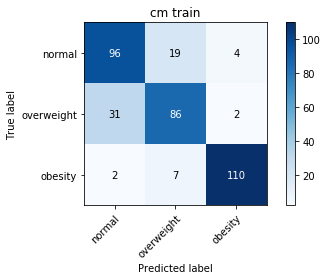

In [32]:
y_pred_test = pipeline.predict(X_train_res) 
plot_confusion_matrix(y_train_res, y_pred_test, classes=class_names, title="cm train")

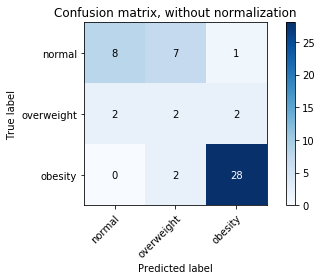

In [33]:
plot_confusion_matrix(y_test, y_pred, classes=class_names)

In [34]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.50      0.62        16
           1       0.18      0.33      0.24         6
           2       0.90      0.93      0.92        30

    accuracy                           0.73        52
   macro avg       0.63      0.59      0.59        52
weighted avg       0.79      0.73      0.75        52



## Random Forest Tunining

In [35]:
results_weighted = []
results_macro = []
names = []
num_tests = 5*3*3*3*2*2*2*4
i = 1

for random_state in [17, 29, 42, 76, 112]:
    for min_samples_leaf in [1,3,5]:
        for min_samples_split in [2,4,6]:
            for max_depth in [3,5,8]:
                for max_features in ["log2","sqrt"]:
                    for criterion in ["gini",  "entropy"]:
                        for bootstrap in [True, False]:
                            for n_estimators in [50, 100, 200, 500]:
                                print("Testing {}/{}".format(i,num_tests))
                                i+=1
                                kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
                                sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
                                cv_results_weighted = np.array([])
                                cv_results_macro = np.array([])
                                for train_idx, test_idx, in kf.split(X_train, y_train):
                                    X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
                                    X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
                                    X_cross_train, y_cross_train = sm.fit_sample(X_cross_train, y_cross_train)
                                    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=random_state, 
                                            min_samples_split=min_samples_split, max_depth=max_depth, max_features=max_features,                           
                                            criterion=criterion, bootstrap=bootstrap, n_estimators=n_estimators)
                                    model.fit(X_cross_train, y_cross_train)  
                                    y_pred = model.predict(X_cross_test)
                                    f1s_weight = f1_score(y_cross_test, y_pred, average="weighted")
                                    f1s_macro = f1_score(y_cross_test, y_pred, average="macro")
                                    cv_results_weighted = np.append(cv_results_weighted, [f1s_weight])
                                    cv_results_macro = np.append(cv_results_macro, [f1s_macro])
                                results_weighted.append(cv_results_weighted)
                                results_macro.append(cv_results_macro)
                                name = "{} {} {} {} {} {} {} {}".format(min_samples_leaf, min_samples_split, max_depth, 
                                    max_features, criterion, bootstrap, n_estimators, random_state)
                                names.append(name)
                                msg = "%s: Weighted %f (%f)" % (name, cv_results_weighted.mean(), cv_results_weighted.std())
                                print(msg)
                                msg = "%s: Macro %f (%f)" % (name, cv_results_macro.mean(), cv_results_macro.std())
                                print(msg)

Testing 1/4320
1 2 3 log2 gini True 50 17: Weighted 0.817273 (0.061421)
1 2 3 log2 gini True 50 17: Macro 0.718101 (0.081349)
Testing 2/4320
1 2 3 log2 gini True 100 17: Weighted 0.804345 (0.055018)
1 2 3 log2 gini True 100 17: Macro 0.698862 (0.070981)
Testing 3/4320
1 2 3 log2 gini True 200 17: Weighted 0.809014 (0.051630)
1 2 3 log2 gini True 200 17: Macro 0.702391 (0.068382)
Testing 4/4320
1 2 3 log2 gini True 500 17: Weighted 0.813941 (0.055478)
1 2 3 log2 gini True 500 17: Macro 0.709900 (0.075733)
Testing 5/4320
1 2 3 log2 gini False 50 17: Weighted 0.804627 (0.072614)
1 2 3 log2 gini False 50 17: Macro 0.701445 (0.092151)
Testing 6/4320
1 2 3 log2 gini False 100 17: Weighted 0.813081 (0.059751)
1 2 3 log2 gini False 100 17: Macro 0.712700 (0.075647)
Testing 7/4320
1 2 3 log2 gini False 200 17: Weighted 0.809244 (0.065497)
1 2 3 log2 gini False 200 17: Macro 0.704564 (0.087453)
Testing 8/4320
1 2 3 log2 gini False 500 17: Weighted 0.809244 (0.065497)
1 2 3 log2 gini False 500 17

1 2 5 sqrt entropy False 200 17: Weighted 0.776265 (0.071203)
1 2 5 sqrt entropy False 200 17: Macro 0.661812 (0.105759)
Testing 64/4320
1 2 5 sqrt entropy False 500 17: Weighted 0.776265 (0.071203)
1 2 5 sqrt entropy False 500 17: Macro 0.661812 (0.105759)
Testing 65/4320
1 2 8 log2 gini True 50 17: Weighted 0.793808 (0.068602)
1 2 8 log2 gini True 50 17: Macro 0.685841 (0.082968)
Testing 66/4320
1 2 8 log2 gini True 100 17: Weighted 0.803236 (0.048640)
1 2 8 log2 gini True 100 17: Macro 0.692302 (0.060436)
Testing 67/4320
1 2 8 log2 gini True 200 17: Weighted 0.796146 (0.055342)
1 2 8 log2 gini True 200 17: Macro 0.684184 (0.068030)
Testing 68/4320
1 2 8 log2 gini True 500 17: Weighted 0.804248 (0.058745)
1 2 8 log2 gini True 500 17: Macro 0.695898 (0.073651)
Testing 69/4320
1 2 8 log2 gini False 50 17: Weighted 0.797553 (0.062917)
1 2 8 log2 gini False 50 17: Macro 0.696321 (0.090203)
Testing 70/4320
1 2 8 log2 gini False 100 17: Weighted 0.793690 (0.067997)
1 2 8 log2 gini False 10

1 4 3 sqrt entropy False 50 17: Weighted 0.787834 (0.088117)
1 4 3 sqrt entropy False 50 17: Macro 0.680688 (0.106489)
Testing 126/4320
1 4 3 sqrt entropy False 100 17: Weighted 0.787834 (0.088117)
1 4 3 sqrt entropy False 100 17: Macro 0.680688 (0.106489)
Testing 127/4320
1 4 3 sqrt entropy False 200 17: Weighted 0.787834 (0.088117)
1 4 3 sqrt entropy False 200 17: Macro 0.680688 (0.106489)
Testing 128/4320
1 4 3 sqrt entropy False 500 17: Weighted 0.795172 (0.076239)
1 4 3 sqrt entropy False 500 17: Macro 0.686046 (0.097885)
Testing 129/4320
1 4 5 log2 gini True 50 17: Weighted 0.821096 (0.069936)
1 4 5 log2 gini True 50 17: Macro 0.724977 (0.092961)
Testing 130/4320
1 4 5 log2 gini True 100 17: Weighted 0.811552 (0.066041)
1 4 5 log2 gini True 100 17: Macro 0.707693 (0.085034)
Testing 131/4320
1 4 5 log2 gini True 200 17: Weighted 0.807129 (0.059688)
1 4 5 log2 gini True 200 17: Macro 0.700731 (0.075190)
Testing 132/4320
1 4 5 log2 gini True 500 17: Weighted 0.816674 (0.064627)
1 4 

1 4 8 sqrt entropy True 200 17: Weighted 0.799908 (0.056513)
1 4 8 sqrt entropy True 200 17: Macro 0.694474 (0.066278)
Testing 188/4320
1 4 8 sqrt entropy True 500 17: Weighted 0.804428 (0.062556)
1 4 8 sqrt entropy True 500 17: Macro 0.701285 (0.075147)
Testing 189/4320
1 4 8 sqrt entropy False 50 17: Weighted 0.786505 (0.070199)
1 4 8 sqrt entropy False 50 17: Macro 0.675827 (0.101936)
Testing 190/4320
1 4 8 sqrt entropy False 100 17: Weighted 0.799396 (0.064706)
1 4 8 sqrt entropy False 100 17: Macro 0.694509 (0.083840)
Testing 191/4320
1 4 8 sqrt entropy False 200 17: Weighted 0.795533 (0.069758)
1 4 8 sqrt entropy False 200 17: Macro 0.689724 (0.090728)
Testing 192/4320
1 4 8 sqrt entropy False 500 17: Weighted 0.799396 (0.064706)
1 4 8 sqrt entropy False 500 17: Macro 0.694509 (0.083840)
Testing 193/4320
1 6 3 log2 gini True 50 17: Weighted 0.816826 (0.060889)
1 6 3 log2 gini True 50 17: Macro 0.714827 (0.078040)
Testing 194/4320
1 6 3 log2 gini True 100 17: Weighted 0.805007 (0.

1 6 5 sqrt entropy True 50 17: Weighted 0.811358 (0.069001)
1 6 5 sqrt entropy True 50 17: Macro 0.712947 (0.088081)
Testing 250/4320
1 6 5 sqrt entropy True 100 17: Weighted 0.819498 (0.065790)
1 6 5 sqrt entropy True 100 17: Macro 0.721539 (0.084280)
Testing 251/4320
1 6 5 sqrt entropy True 200 17: Weighted 0.811863 (0.058581)
1 6 5 sqrt entropy True 200 17: Macro 0.704330 (0.074545)
Testing 252/4320
1 6 5 sqrt entropy True 500 17: Weighted 0.811863 (0.058581)
1 6 5 sqrt entropy True 500 17: Macro 0.704330 (0.074545)
Testing 253/4320
1 6 5 sqrt entropy False 50 17: Weighted 0.793577 (0.072184)
1 6 5 sqrt entropy False 50 17: Macro 0.687441 (0.098753)
Testing 254/4320
1 6 5 sqrt entropy False 100 17: Weighted 0.788748 (0.081104)
1 6 5 sqrt entropy False 100 17: Macro 0.673970 (0.113068)
Testing 255/4320
1 6 5 sqrt entropy False 200 17: Weighted 0.780739 (0.076371)
1 6 5 sqrt entropy False 200 17: Macro 0.665380 (0.109674)
Testing 256/4320
1 6 5 sqrt entropy False 500 17: Weighted 0.78

3 2 3 sqrt gini False 200 17: Weighted 0.809244 (0.065497)
3 2 3 sqrt gini False 200 17: Macro 0.704564 (0.087453)
Testing 312/4320
3 2 3 sqrt gini False 500 17: Weighted 0.809244 (0.065497)
3 2 3 sqrt gini False 500 17: Macro 0.704564 (0.087453)
Testing 313/4320
3 2 3 sqrt entropy True 50 17: Weighted 0.809935 (0.060810)
3 2 3 sqrt entropy True 50 17: Macro 0.704820 (0.082311)
Testing 314/4320
3 2 3 sqrt entropy True 100 17: Weighted 0.809935 (0.060810)
3 2 3 sqrt entropy True 100 17: Macro 0.704820 (0.082311)
Testing 315/4320
3 2 3 sqrt entropy True 200 17: Weighted 0.812527 (0.049802)
3 2 3 sqrt entropy True 200 17: Macro 0.710740 (0.060852)
Testing 316/4320
3 2 3 sqrt entropy True 500 17: Weighted 0.808523 (0.055575)
3 2 3 sqrt entropy True 500 17: Macro 0.702270 (0.072850)
Testing 317/4320
3 2 3 sqrt entropy False 50 17: Weighted 0.787834 (0.088117)
3 2 3 sqrt entropy False 50 17: Macro 0.680688 (0.106489)
Testing 318/4320
3 2 3 sqrt entropy False 100 17: Weighted 0.787834 (0.0881

3 2 8 sqrt gini False 50 17: Weighted 0.811131 (0.069449)
3 2 8 sqrt gini False 50 17: Macro 0.706988 (0.095113)
Testing 374/4320
3 2 8 sqrt gini False 100 17: Weighted 0.811131 (0.069449)
3 2 8 sqrt gini False 100 17: Macro 0.706988 (0.095113)
Testing 375/4320
3 2 8 sqrt gini False 200 17: Weighted 0.803616 (0.066511)
3 2 8 sqrt gini False 200 17: Macro 0.696353 (0.090556)
Testing 376/4320
3 2 8 sqrt gini False 500 17: Weighted 0.808544 (0.069922)
3 2 8 sqrt gini False 500 17: Macro 0.703862 (0.096699)
Testing 377/4320
3 2 8 sqrt entropy True 50 17: Weighted 0.813679 (0.057546)
3 2 8 sqrt entropy True 50 17: Macro 0.706570 (0.074612)
Testing 378/4320
3 2 8 sqrt entropy True 100 17: Weighted 0.821977 (0.058466)
3 2 8 sqrt entropy True 100 17: Macro 0.721669 (0.079089)
Testing 379/4320
3 2 8 sqrt entropy True 200 17: Weighted 0.812229 (0.061512)
3 2 8 sqrt entropy True 200 17: Macro 0.706711 (0.078634)
Testing 380/4320
3 2 8 sqrt entropy True 500 17: Weighted 0.812229 (0.061512)
3 2 8 s

3 4 5 sqrt gini True 200 17: Weighted 0.808426 (0.059274)
3 4 5 sqrt gini True 200 17: Macro 0.699306 (0.075587)
Testing 436/4320
3 4 5 sqrt gini True 500 17: Weighted 0.813188 (0.061148)
3 4 5 sqrt gini True 500 17: Macro 0.706448 (0.078733)
Testing 437/4320
3 4 5 sqrt gini False 50 17: Weighted 0.808216 (0.082181)
3 4 5 sqrt gini False 50 17: Macro 0.698926 (0.120768)
Testing 438/4320
3 4 5 sqrt gini False 100 17: Weighted 0.808216 (0.082181)
3 4 5 sqrt gini False 100 17: Macro 0.698926 (0.120768)
Testing 439/4320
3 4 5 sqrt gini False 200 17: Weighted 0.813237 (0.075536)
3 4 5 sqrt gini False 200 17: Macro 0.707725 (0.105751)
Testing 440/4320
3 4 5 sqrt gini False 500 17: Weighted 0.813237 (0.075536)
3 4 5 sqrt gini False 500 17: Macro 0.707725 (0.105751)
Testing 441/4320
3 4 5 sqrt entropy True 50 17: Weighted 0.814455 (0.065778)
3 4 5 sqrt entropy True 50 17: Macro 0.711632 (0.088816)
Testing 442/4320
3 4 5 sqrt entropy True 100 17: Weighted 0.821407 (0.062892)
3 4 5 sqrt entropy 

3 6 3 sqrt gini True 50 17: Weighted 0.818015 (0.060054)
3 6 3 sqrt gini True 50 17: Macro 0.713437 (0.079013)
Testing 498/4320
3 6 3 sqrt gini True 100 17: Weighted 0.805007 (0.056975)
3 6 3 sqrt gini True 100 17: Macro 0.697312 (0.075095)
Testing 499/4320
3 6 3 sqrt gini True 200 17: Weighted 0.809014 (0.051630)
3 6 3 sqrt gini True 200 17: Macro 0.702391 (0.068382)
Testing 500/4320
3 6 3 sqrt gini True 500 17: Weighted 0.813941 (0.055478)
3 6 3 sqrt gini True 500 17: Macro 0.709900 (0.075733)
Testing 501/4320
3 6 3 sqrt gini False 50 17: Weighted 0.804627 (0.072614)
3 6 3 sqrt gini False 50 17: Macro 0.701445 (0.092151)
Testing 502/4320
3 6 3 sqrt gini False 100 17: Weighted 0.804627 (0.072614)
3 6 3 sqrt gini False 100 17: Macro 0.701445 (0.092151)
Testing 503/4320
3 6 3 sqrt gini False 200 17: Weighted 0.809244 (0.065497)
3 6 3 sqrt gini False 200 17: Macro 0.704564 (0.087453)
Testing 504/4320
3 6 3 sqrt gini False 500 17: Weighted 0.809244 (0.065497)
3 6 3 sqrt gini False 500 17:

3 6 8 log2 entropy False 200 17: Weighted 0.804684 (0.062624)
3 6 8 log2 entropy False 200 17: Macro 0.697221 (0.083059)
Testing 560/4320
3 6 8 log2 entropy False 500 17: Weighted 0.804684 (0.062624)
3 6 8 log2 entropy False 500 17: Macro 0.697221 (0.083059)
Testing 561/4320
3 6 8 sqrt gini True 50 17: Weighted 0.813440 (0.067066)
3 6 8 sqrt gini True 50 17: Macro 0.708481 (0.087845)
Testing 562/4320
3 6 8 sqrt gini True 100 17: Weighted 0.811902 (0.061968)
3 6 8 sqrt gini True 100 17: Macro 0.702313 (0.085000)
Testing 563/4320
3 6 8 sqrt gini True 200 17: Weighted 0.812229 (0.061512)
3 6 8 sqrt gini True 200 17: Macro 0.706711 (0.078634)
Testing 564/4320
3 6 8 sqrt gini True 500 17: Weighted 0.816235 (0.056083)
3 6 8 sqrt gini True 500 17: Macro 0.711790 (0.071586)
Testing 565/4320
3 6 8 sqrt gini False 50 17: Weighted 0.811131 (0.069449)
3 6 8 sqrt gini False 50 17: Macro 0.706988 (0.095113)
Testing 566/4320
3 6 8 sqrt gini False 100 17: Weighted 0.811131 (0.069449)
3 6 8 sqrt gini F

5 2 5 log2 entropy False 50 17: Weighted 0.808309 (0.072708)
5 2 5 log2 entropy False 50 17: Macro 0.700217 (0.100455)
Testing 622/4320
5 2 5 log2 entropy False 100 17: Weighted 0.800353 (0.068032)
5 2 5 log2 entropy False 100 17: Macro 0.688381 (0.094176)
Testing 623/4320
5 2 5 log2 entropy False 200 17: Weighted 0.798829 (0.071049)
5 2 5 log2 entropy False 200 17: Macro 0.688032 (0.096843)
Testing 624/4320
5 2 5 log2 entropy False 500 17: Weighted 0.799789 (0.070916)
5 2 5 log2 entropy False 500 17: Macro 0.687770 (0.096874)
Testing 625/4320
5 2 5 sqrt gini True 50 17: Weighted 0.821407 (0.062892)
5 2 5 sqrt gini True 50 17: Macro 0.721614 (0.084166)
Testing 626/4320
5 2 5 sqrt gini True 100 17: Weighted 0.816624 (0.060205)
5 2 5 sqrt gini True 100 17: Macro 0.711473 (0.077270)
Testing 627/4320
5 2 5 sqrt gini True 200 17: Weighted 0.809673 (0.062686)
5 2 5 sqrt gini True 200 17: Macro 0.701491 (0.081072)
Testing 628/4320
5 2 5 sqrt gini True 500 17: Weighted 0.813188 (0.061148)
5 2 

5 4 3 log2 entropy True 200 17: Weighted 0.804317 (0.061898)
5 4 3 log2 entropy True 200 17: Macro 0.697056 (0.080675)
Testing 684/4320
5 4 3 log2 entropy True 500 17: Weighted 0.808523 (0.055575)
5 4 3 log2 entropy True 500 17: Macro 0.702270 (0.072850)
Testing 685/4320
5 4 3 log2 entropy False 50 17: Weighted 0.788636 (0.086808)
5 4 3 log2 entropy False 50 17: Macro 0.680947 (0.106072)
Testing 686/4320
5 4 3 log2 entropy False 100 17: Weighted 0.788636 (0.086808)
5 4 3 log2 entropy False 100 17: Macro 0.680947 (0.106072)
Testing 687/4320
5 4 3 log2 entropy False 200 17: Weighted 0.798644 (0.070719)
5 4 3 log2 entropy False 200 17: Macro 0.693509 (0.086134)
Testing 688/4320
5 4 3 log2 entropy False 500 17: Weighted 0.787834 (0.088117)
5 4 3 log2 entropy False 500 17: Macro 0.680688 (0.106489)
Testing 689/4320
5 4 3 sqrt gini True 50 17: Weighted 0.818015 (0.060054)
5 4 3 sqrt gini True 50 17: Macro 0.713437 (0.079013)
Testing 690/4320
5 4 3 sqrt gini True 100 17: Weighted 0.809014 (0.

5 4 8 log2 entropy True 50 17: Weighted 0.809673 (0.062686)
5 4 8 log2 entropy True 50 17: Macro 0.701491 (0.081072)
Testing 746/4320
5 4 8 log2 entropy True 100 17: Weighted 0.816001 (0.058417)
5 4 8 log2 entropy True 100 17: Macro 0.715332 (0.078025)
Testing 747/4320
5 4 8 log2 entropy True 200 17: Weighted 0.812229 (0.061512)
5 4 8 log2 entropy True 200 17: Macro 0.706711 (0.078634)
Testing 748/4320
5 4 8 log2 entropy True 500 17: Weighted 0.812229 (0.061512)
5 4 8 log2 entropy True 500 17: Macro 0.706711 (0.078634)
Testing 749/4320
5 4 8 log2 entropy False 50 17: Weighted 0.799284 (0.066331)
5 4 8 log2 entropy False 50 17: Macro 0.687687 (0.090862)
Testing 750/4320
5 4 8 log2 entropy False 100 17: Weighted 0.802850 (0.065211)
5 4 8 log2 entropy False 100 17: Macro 0.692852 (0.089525)
Testing 751/4320
5 4 8 log2 entropy False 200 17: Weighted 0.799284 (0.066331)
5 4 8 log2 entropy False 200 17: Macro 0.687687 (0.090862)
Testing 752/4320
5 4 8 log2 entropy False 500 17: Weighted 0.79

5 6 5 log2 gini False 200 17: Weighted 0.812352 (0.075646)
5 6 5 log2 gini False 200 17: Macro 0.708254 (0.105698)
Testing 808/4320
5 6 5 log2 gini False 500 17: Weighted 0.812352 (0.075646)
5 6 5 log2 gini False 500 17: Macro 0.708254 (0.105698)
Testing 809/4320
5 6 5 log2 entropy True 50 17: Weighted 0.813188 (0.061148)
5 6 5 log2 entropy True 50 17: Macro 0.706448 (0.078733)
Testing 810/4320
5 6 5 log2 entropy True 100 17: Weighted 0.821407 (0.062892)
5 6 5 log2 entropy True 100 17: Macro 0.721614 (0.084166)
Testing 811/4320
5 6 5 log2 entropy True 200 17: Weighted 0.808426 (0.059274)
5 6 5 log2 entropy True 200 17: Macro 0.699306 (0.075587)
Testing 812/4320
5 6 5 log2 entropy True 500 17: Weighted 0.811863 (0.058581)
5 6 5 log2 entropy True 500 17: Macro 0.704330 (0.074545)
Testing 813/4320
5 6 5 log2 entropy False 50 17: Weighted 0.808309 (0.072708)
5 6 5 log2 entropy False 50 17: Macro 0.700217 (0.100455)
Testing 814/4320
5 6 5 log2 entropy False 100 17: Weighted 0.800353 (0.0680

1 2 3 log2 gini False 50 29: Weighted 0.800801 (0.062924)
1 2 3 log2 gini False 50 29: Macro 0.692099 (0.082395)
Testing 870/4320
1 2 3 log2 gini False 100 29: Weighted 0.798644 (0.070719)
1 2 3 log2 gini False 100 29: Macro 0.693509 (0.086134)
Testing 871/4320
1 2 3 log2 gini False 200 29: Weighted 0.804765 (0.061493)
1 2 3 log2 gini False 200 29: Macro 0.700947 (0.084665)
Testing 872/4320
1 2 3 log2 gini False 500 29: Weighted 0.804627 (0.072614)
1 2 3 log2 gini False 500 29: Macro 0.701445 (0.092151)
Testing 873/4320
1 2 3 log2 entropy True 50 29: Weighted 0.805007 (0.056975)
1 2 3 log2 entropy True 50 29: Macro 0.697312 (0.075095)
Testing 874/4320
1 2 3 log2 entropy True 100 29: Weighted 0.809935 (0.060810)
1 2 3 log2 entropy True 100 29: Macro 0.704820 (0.082311)
Testing 875/4320
1 2 3 log2 entropy True 200 29: Weighted 0.805007 (0.056975)
1 2 3 log2 entropy True 200 29: Macro 0.697312 (0.075095)
Testing 876/4320
1 2 3 log2 entropy True 500 29: Weighted 0.805007 (0.056975)
1 2 3 l

1 2 8 log2 gini True 200 29: Weighted 0.803333 (0.059473)
1 2 8 log2 gini True 200 29: Macro 0.696055 (0.073536)
Testing 932/4320
1 2 8 log2 gini True 500 29: Weighted 0.803395 (0.061571)
1 2 8 log2 gini True 500 29: Macro 0.691340 (0.082835)
Testing 933/4320
1 2 8 log2 gini False 50 29: Weighted 0.783121 (0.049090)
1 2 8 log2 gini False 50 29: Macro 0.674687 (0.069581)
Testing 934/4320
1 2 8 log2 gini False 100 29: Weighted 0.779511 (0.051498)
1 2 8 log2 gini False 100 29: Macro 0.669627 (0.072389)
Testing 935/4320
1 2 8 log2 gini False 200 29: Weighted 0.783931 (0.056743)
1 2 8 log2 gini False 200 29: Macro 0.676331 (0.080144)
Testing 936/4320
1 2 8 log2 gini False 500 29: Weighted 0.789015 (0.060793)
1 2 8 log2 gini False 500 29: Macro 0.683754 (0.086109)
Testing 937/4320
1 2 8 log2 entropy True 50 29: Weighted 0.794943 (0.055250)
1 2 8 log2 entropy True 50 29: Macro 0.690323 (0.073436)
Testing 938/4320
1 2 8 log2 entropy True 100 29: Weighted 0.801817 (0.053810)
1 2 8 log2 entropy 

1 4 5 log2 gini True 50 29: Weighted 0.796952 (0.065392)
1 4 5 log2 gini True 50 29: Macro 0.689452 (0.079523)
Testing 994/4320
1 4 5 log2 gini True 100 29: Weighted 0.803722 (0.061157)
1 4 5 log2 gini True 100 29: Macro 0.695738 (0.076918)
Testing 995/4320
1 4 5 log2 gini True 200 29: Weighted 0.803722 (0.061157)
1 4 5 log2 gini True 200 29: Macro 0.695738 (0.076918)
Testing 996/4320
1 4 5 log2 gini True 500 29: Weighted 0.803722 (0.061157)
1 4 5 log2 gini True 500 29: Macro 0.695738 (0.076918)
Testing 997/4320
1 4 5 log2 gini False 50 29: Weighted 0.803576 (0.073375)
1 4 5 log2 gini False 50 29: Macro 0.696618 (0.100788)
Testing 998/4320
1 4 5 log2 gini False 100 29: Weighted 0.799047 (0.068230)
1 4 5 log2 gini False 100 29: Macro 0.692948 (0.097024)
Testing 999/4320
1 4 5 log2 gini False 200 29: Weighted 0.803576 (0.073375)
1 4 5 log2 gini False 200 29: Macro 0.696618 (0.100788)
Testing 1000/4320
1 4 5 log2 gini False 500 29: Weighted 0.808504 (0.076483)
1 4 5 log2 gini False 500 29

1 4 8 sqrt entropy False 200 29: Weighted 0.800073 (0.064371)
1 4 8 sqrt entropy False 200 29: Macro 0.693755 (0.084103)
Testing 1056/4320
1 4 8 sqrt entropy False 500 29: Weighted 0.799396 (0.064706)
1 4 8 sqrt entropy False 500 29: Macro 0.694509 (0.083840)
Testing 1057/4320
1 6 3 log2 gini True 50 29: Weighted 0.799924 (0.064510)
1 6 3 log2 gini True 50 29: Macro 0.689124 (0.080763)
Testing 1058/4320
1 6 3 log2 gini True 100 29: Weighted 0.800391 (0.054362)
1 6 3 log2 gini True 100 29: Macro 0.687536 (0.068319)
Testing 1059/4320
1 6 3 log2 gini True 200 29: Weighted 0.809935 (0.060810)
1 6 3 log2 gini True 200 29: Macro 0.704820 (0.082311)
Testing 1060/4320
1 6 3 log2 gini True 500 29: Weighted 0.813941 (0.055478)
1 6 3 log2 gini True 500 29: Macro 0.709900 (0.075733)
Testing 1061/4320
1 6 3 log2 gini False 50 29: Weighted 0.796132 (0.065146)
1 6 3 log2 gini False 50 29: Macro 0.688569 (0.084134)
Testing 1062/4320
1 6 3 log2 gini False 100 29: Weighted 0.799612 (0.063399)
1 6 3 log2

1 6 5 sqrt entropy True 500 29: Weighted 0.802923 (0.065526)
1 6 5 sqrt entropy True 500 29: Macro 0.695518 (0.082698)
Testing 1117/4320
1 6 5 sqrt entropy False 50 29: Weighted 0.790697 (0.066814)
1 6 5 sqrt entropy False 50 29: Macro 0.673202 (0.099501)
Testing 1118/4320
1 6 5 sqrt entropy False 100 29: Weighted 0.784219 (0.075598)
1 6 5 sqrt entropy False 100 29: Macro 0.670300 (0.108965)
Testing 1119/4320
1 6 5 sqrt entropy False 200 29: Weighted 0.788748 (0.081104)
1 6 5 sqrt entropy False 200 29: Macro 0.673970 (0.113068)
Testing 1120/4320
1 6 5 sqrt entropy False 500 29: Weighted 0.785268 (0.082017)
1 6 5 sqrt entropy False 500 29: Macro 0.669050 (0.113909)
Testing 1121/4320
1 6 8 log2 gini True 50 29: Weighted 0.785310 (0.058876)
1 6 8 log2 gini True 50 29: Macro 0.666498 (0.074726)
Testing 1122/4320
1 6 8 log2 gini True 100 29: Weighted 0.790216 (0.061116)
1 6 8 log2 gini True 100 29: Macro 0.673549 (0.078271)
Testing 1123/4320
1 6 8 log2 gini True 200 29: Weighted 0.803016 (0

3 2 3 sqrt entropy True 50 29: Weighted 0.805007 (0.056975)
3 2 3 sqrt entropy True 50 29: Macro 0.697312 (0.075095)
Testing 1178/4320
3 2 3 sqrt entropy True 100 29: Weighted 0.805007 (0.056975)
3 2 3 sqrt entropy True 100 29: Macro 0.697312 (0.075095)
Testing 1179/4320
3 2 3 sqrt entropy True 200 29: Weighted 0.805007 (0.056975)
3 2 3 sqrt entropy True 200 29: Macro 0.697312 (0.075095)
Testing 1180/4320
3 2 3 sqrt entropy True 500 29: Weighted 0.808523 (0.055575)
3 2 3 sqrt entropy True 500 29: Macro 0.702270 (0.072850)
Testing 1181/4320
3 2 3 sqrt entropy False 50 29: Weighted 0.782580 (0.097085)
3 2 3 sqrt entropy False 50 29: Macro 0.671174 (0.115799)
Testing 1182/4320
3 2 3 sqrt entropy False 100 29: Weighted 0.788781 (0.086901)
3 2 3 sqrt entropy False 100 29: Macro 0.678314 (0.104148)
Testing 1183/4320
3 2 3 sqrt entropy False 200 29: Weighted 0.787834 (0.088117)
3 2 3 sqrt entropy False 200 29: Macro 0.680688 (0.106489)
Testing 1184/4320
3 2 3 sqrt entropy False 500 29: Weight

3 2 8 sqrt gini False 100 29: Weighted 0.806203 (0.066206)
3 2 8 sqrt gini False 100 29: Macro 0.699479 (0.089125)
Testing 1239/4320
3 2 8 sqrt gini False 200 29: Weighted 0.802550 (0.068292)
3 2 8 sqrt gini False 200 29: Macro 0.694373 (0.091976)
Testing 1240/4320
3 2 8 sqrt gini False 500 29: Weighted 0.806203 (0.066206)
3 2 8 sqrt gini False 500 29: Macro 0.699479 (0.089125)
Testing 1241/4320
3 2 8 sqrt entropy True 50 29: Weighted 0.803998 (0.057490)
3 2 8 sqrt entropy True 50 29: Macro 0.697368 (0.075065)
Testing 1242/4320
3 2 8 sqrt entropy True 100 29: Weighted 0.807467 (0.059573)
3 2 8 sqrt entropy True 100 29: Macro 0.699568 (0.075508)
Testing 1243/4320
3 2 8 sqrt entropy True 200 29: Weighted 0.807467 (0.059573)
3 2 8 sqrt entropy True 200 29: Macro 0.699568 (0.075508)
Testing 1244/4320
3 2 8 sqrt entropy True 500 29: Weighted 0.802947 (0.053450)
3 2 8 sqrt entropy True 500 29: Macro 0.692757 (0.066512)
Testing 1245/4320
3 2 8 sqrt entropy False 50 29: Weighted 0.803425 (0.06

3 4 5 sqrt gini True 200 29: Weighted 0.808426 (0.059274)
3 4 5 sqrt gini True 200 29: Macro 0.699306 (0.075587)
Testing 1300/4320
3 4 5 sqrt gini True 500 29: Weighted 0.808426 (0.059274)
3 4 5 sqrt gini True 500 29: Macro 0.699306 (0.075587)
Testing 1301/4320
3 4 5 sqrt gini False 50 29: Weighted 0.802783 (0.073575)
3 4 5 sqrt gini False 50 29: Macro 0.697247 (0.100702)
Testing 1302/4320
3 4 5 sqrt gini False 100 29: Weighted 0.807424 (0.072763)
3 4 5 sqrt gini False 100 29: Macro 0.700746 (0.100438)
Testing 1303/4320
3 4 5 sqrt gini False 200 29: Weighted 0.808309 (0.072708)
3 4 5 sqrt gini False 200 29: Macro 0.700217 (0.100455)
Testing 1304/4320
3 4 5 sqrt gini False 500 29: Weighted 0.808504 (0.076483)
3 4 5 sqrt gini False 500 29: Macro 0.704126 (0.106322)
Testing 1305/4320
3 4 5 sqrt entropy True 50 29: Weighted 0.804317 (0.061898)
3 4 5 sqrt entropy True 50 29: Macro 0.697056 (0.080675)
Testing 1306/4320
3 4 5 sqrt entropy True 100 29: Weighted 0.804220 (0.065233)
3 4 5 sqrt e

3 6 3 log2 entropy False 500 29: Weighted 0.787834 (0.088117)
3 6 3 log2 entropy False 500 29: Macro 0.680688 (0.106489)
Testing 1361/4320
3 6 3 sqrt gini True 50 29: Weighted 0.799924 (0.064510)
3 6 3 sqrt gini True 50 29: Macro 0.689124 (0.080763)
Testing 1362/4320
3 6 3 sqrt gini True 100 29: Weighted 0.805153 (0.057074)
3 6 3 sqrt gini True 100 29: Macro 0.694679 (0.072946)
Testing 1363/4320
3 6 3 sqrt gini True 200 29: Weighted 0.809935 (0.060810)
3 6 3 sqrt gini True 200 29: Macro 0.704820 (0.082311)
Testing 1364/4320
3 6 3 sqrt gini True 500 29: Weighted 0.813941 (0.055478)
3 6 3 sqrt gini True 500 29: Macro 0.709900 (0.075733)
Testing 1365/4320
3 6 3 sqrt gini False 50 29: Weighted 0.800801 (0.062924)
3 6 3 sqrt gini False 50 29: Macro 0.692099 (0.082395)
Testing 1366/4320
3 6 3 sqrt gini False 100 29: Weighted 0.804317 (0.061898)
3 6 3 sqrt gini False 100 29: Macro 0.697056 (0.080675)
Testing 1367/4320
3 6 3 sqrt gini False 200 29: Weighted 0.809244 (0.065497)
3 6 3 sqrt gini 

3 6 8 log2 entropy False 50 29: Weighted 0.803425 (0.061355)
3 6 8 log2 entropy False 50 29: Macro 0.690149 (0.080629)
Testing 1422/4320
3 6 8 log2 entropy False 100 29: Weighted 0.800821 (0.068131)
3 6 8 log2 entropy False 100 29: Macro 0.692436 (0.090150)
Testing 1423/4320
3 6 8 log2 entropy False 200 29: Weighted 0.804684 (0.062624)
3 6 8 log2 entropy False 200 29: Macro 0.697221 (0.083059)
Testing 1424/4320
3 6 8 log2 entropy False 500 29: Weighted 0.804684 (0.062624)
3 6 8 log2 entropy False 500 29: Macro 0.697221 (0.083059)
Testing 1425/4320
3 6 8 sqrt gini True 50 29: Weighted 0.791958 (0.059646)
3 6 8 sqrt gini True 50 29: Macro 0.677380 (0.074900)
Testing 1426/4320
3 6 8 sqrt gini True 100 29: Weighted 0.807908 (0.056191)
3 6 8 sqrt gini True 100 29: Macro 0.699483 (0.071262)
Testing 1427/4320
3 6 8 sqrt gini True 200 29: Weighted 0.807908 (0.056191)
3 6 8 sqrt gini True 200 29: Macro 0.699483 (0.071262)
Testing 1428/4320
3 6 8 sqrt gini True 500 29: Weighted 0.811473 (0.05430

5 2 5 log2 entropy True 100 29: Weighted 0.807656 (0.064827)
5 2 5 log2 entropy True 100 29: Macro 0.699117 (0.082339)
Testing 1483/4320
5 2 5 log2 entropy True 200 29: Weighted 0.800704 (0.066202)
5 2 5 log2 entropy True 200 29: Macro 0.689134 (0.084469)
Testing 1484/4320
5 2 5 log2 entropy True 500 29: Weighted 0.808426 (0.059274)
5 2 5 log2 entropy True 500 29: Macro 0.699306 (0.075587)
Testing 1485/4320
5 2 5 log2 entropy False 50 29: Weighted 0.795161 (0.077426)
5 2 5 log2 entropy False 50 29: Macro 0.676351 (0.110364)
Testing 1486/4320
5 2 5 log2 entropy False 100 29: Weighted 0.794391 (0.069940)
5 2 5 log2 entropy False 100 29: Macro 0.678628 (0.093900)
Testing 1487/4320
5 2 5 log2 entropy False 200 29: Weighted 0.794694 (0.077250)
5 2 5 log2 entropy False 200 29: Macro 0.678704 (0.111419)
Testing 1488/4320
5 2 5 log2 entropy False 500 29: Weighted 0.798829 (0.071049)
5 2 5 log2 entropy False 500 29: Macro 0.688032 (0.096843)
Testing 1489/4320
5 2 5 sqrt gini True 50 29: Weighte

5 4 3 log2 gini False 200 29: Weighted 0.809244 (0.065497)
5 4 3 log2 gini False 200 29: Macro 0.704564 (0.087453)
Testing 1544/4320
5 4 3 log2 gini False 500 29: Weighted 0.804627 (0.072614)
5 4 3 log2 gini False 500 29: Macro 0.701445 (0.092151)
Testing 1545/4320
5 4 3 log2 entropy True 50 29: Weighted 0.800801 (0.062924)
5 4 3 log2 entropy True 50 29: Macro 0.692099 (0.082395)
Testing 1546/4320
5 4 3 log2 entropy True 100 29: Weighted 0.796362 (0.069477)
5 4 3 log2 entropy True 100 29: Macro 0.686706 (0.090276)
Testing 1547/4320
5 4 3 log2 entropy True 200 29: Weighted 0.800801 (0.062924)
5 4 3 log2 entropy True 200 29: Macro 0.692099 (0.082395)
Testing 1548/4320
5 4 3 log2 entropy True 500 29: Weighted 0.808523 (0.055575)
5 4 3 log2 entropy True 500 29: Macro 0.702270 (0.072850)
Testing 1549/4320
5 4 3 log2 entropy False 50 29: Weighted 0.794516 (0.077616)
5 4 3 log2 entropy False 50 29: Macro 0.685000 (0.093405)
Testing 1550/4320
5 4 3 log2 entropy False 100 29: Weighted 0.799845 

5 4 8 log2 gini True 500 29: Weighted 0.804911 (0.060583)
5 4 8 log2 gini True 500 29: Macro 0.694348 (0.077564)
Testing 1605/4320
5 4 8 log2 gini False 50 29: Weighted 0.791353 (0.077918)
5 4 8 log2 gini False 50 29: Macro 0.672043 (0.111091)
Testing 1606/4320
5 4 8 log2 gini False 100 29: Weighted 0.804369 (0.068699)
5 4 8 log2 gini False 100 29: Macro 0.695110 (0.095284)
Testing 1607/4320
5 4 8 log2 gini False 200 29: Weighted 0.804369 (0.068699)
5 4 8 log2 gini False 200 29: Macro 0.695110 (0.095284)
Testing 1608/4320
5 4 8 log2 gini False 500 29: Weighted 0.804369 (0.068699)
5 4 8 log2 gini False 500 29: Macro 0.695110 (0.095284)
Testing 1609/4320
5 4 8 log2 entropy True 50 29: Weighted 0.807467 (0.059573)
5 4 8 log2 entropy True 50 29: Macro 0.699568 (0.075508)
Testing 1610/4320
5 4 8 log2 entropy True 100 29: Weighted 0.807467 (0.059573)
5 4 8 log2 entropy True 100 29: Macro 0.699568 (0.075508)
Testing 1611/4320
5 4 8 log2 entropy True 200 29: Weighted 0.803902 (0.061066)
5 4 8 

5 6 5 log2 gini True 50 29: Weighted 0.810054 (0.060122)
5 6 5 log2 gini True 50 29: Macro 0.701622 (0.078340)
Testing 1666/4320
5 6 5 log2 gini True 100 29: Weighted 0.812433 (0.053903)
5 6 5 log2 gini True 100 29: Macro 0.704385 (0.068774)
Testing 1667/4320
5 6 5 log2 gini True 200 29: Weighted 0.804911 (0.060583)
5 6 5 log2 gini True 200 29: Macro 0.694348 (0.077564)
Testing 1668/4320
5 6 5 log2 gini True 500 29: Weighted 0.804911 (0.060583)
5 6 5 log2 gini True 500 29: Macro 0.694348 (0.077564)
Testing 1669/4320
5 6 5 log2 gini False 50 29: Weighted 0.799297 (0.071214)
5 6 5 log2 gini False 50 29: Macro 0.685679 (0.095856)
Testing 1670/4320
5 6 5 log2 gini False 100 29: Weighted 0.807424 (0.072763)
5 6 5 log2 gini False 100 29: Macro 0.700746 (0.100438)
Testing 1671/4320
5 6 5 log2 gini False 200 29: Weighted 0.807424 (0.072763)
5 6 5 log2 gini False 200 29: Macro 0.700746 (0.100438)
Testing 1672/4320
5 6 5 log2 gini False 500 29: Weighted 0.808841 (0.076386)
5 6 5 log2 gini False 

5 6 8 sqrt entropy False 200 29: Weighted 0.799284 (0.066331)
5 6 8 sqrt entropy False 200 29: Macro 0.687687 (0.090862)
Testing 1728/4320
5 6 8 sqrt entropy False 500 29: Weighted 0.799284 (0.066331)
5 6 8 sqrt entropy False 500 29: Macro 0.687687 (0.090862)
Testing 1729/4320
1 2 3 log2 gini True 50 42: Weighted 0.800597 (0.059190)
1 2 3 log2 gini True 50 42: Macro 0.694531 (0.079229)
Testing 1730/4320
1 2 3 log2 gini True 100 42: Weighted 0.809935 (0.060810)
1 2 3 log2 gini True 100 42: Macro 0.704820 (0.082311)
Testing 1731/4320
1 2 3 log2 gini True 200 42: Weighted 0.809935 (0.060810)
1 2 3 log2 gini True 200 42: Macro 0.704820 (0.082311)
Testing 1732/4320
1 2 3 log2 gini True 500 42: Weighted 0.809014 (0.051630)
1 2 3 log2 gini True 500 42: Macro 0.702391 (0.068382)
Testing 1733/4320
1 2 3 log2 gini False 50 42: Weighted 0.796632 (0.069438)
1 2 3 log2 gini False 50 42: Macro 0.692870 (0.090981)
Testing 1734/4320
1 2 3 log2 gini False 100 42: Weighted 0.795735 (0.048271)
1 2 3 log2

1 2 5 sqrt entropy True 500 42: Weighted 0.807129 (0.059688)
1 2 5 sqrt entropy True 500 42: Macro 0.700731 (0.075190)
Testing 1789/4320
1 2 5 sqrt entropy False 50 42: Weighted 0.776265 (0.071203)
1 2 5 sqrt entropy False 50 42: Macro 0.661812 (0.105759)
Testing 1790/4320
1 2 5 sqrt entropy False 100 42: Weighted 0.779745 (0.070594)
1 2 5 sqrt entropy False 100 42: Macro 0.666731 (0.105191)
Testing 1791/4320
1 2 5 sqrt entropy False 200 42: Weighted 0.784019 (0.063935)
1 2 5 sqrt entropy False 200 42: Macro 0.676449 (0.089869)
Testing 1792/4320
1 2 5 sqrt entropy False 500 42: Weighted 0.780538 (0.064836)
1 2 5 sqrt entropy False 500 42: Macro 0.671530 (0.091060)
Testing 1793/4320
1 2 8 log2 gini True 50 42: Weighted 0.804679 (0.065256)
1 2 8 log2 gini True 50 42: Macro 0.702136 (0.087987)
Testing 1794/4320
1 2 8 log2 gini True 100 42: Weighted 0.809803 (0.064228)
1 2 8 log2 gini True 100 42: Macro 0.708723 (0.078857)
Testing 1795/4320
1 2 8 log2 gini True 200 42: Weighted 0.809983 (0

1 4 3 sqrt entropy True 50 42: Weighted 0.801060 (0.062389)
1 4 3 sqrt entropy True 50 42: Macro 0.692847 (0.084279)
Testing 1850/4320
1 4 3 sqrt entropy True 100 42: Weighted 0.809935 (0.060810)
1 4 3 sqrt entropy True 100 42: Macro 0.704820 (0.082311)
Testing 1851/4320
1 4 3 sqrt entropy True 200 42: Weighted 0.809244 (0.065497)
1 4 3 sqrt entropy True 200 42: Macro 0.704564 (0.087453)
Testing 1852/4320
1 4 3 sqrt entropy True 500 42: Weighted 0.805007 (0.056975)
1 4 3 sqrt entropy True 500 42: Macro 0.697312 (0.075095)
Testing 1853/4320
1 4 3 sqrt entropy False 50 42: Weighted 0.777448 (0.083265)
1 4 3 sqrt entropy False 50 42: Macro 0.665820 (0.097952)
Testing 1854/4320
1 4 3 sqrt entropy False 100 42: Weighted 0.787834 (0.088117)
1 4 3 sqrt entropy False 100 42: Macro 0.680688 (0.106489)
Testing 1855/4320
1 4 3 sqrt entropy False 200 42: Weighted 0.787834 (0.088117)
1 4 3 sqrt entropy False 200 42: Macro 0.680688 (0.106489)
Testing 1856/4320
1 4 3 sqrt entropy False 500 42: Weight

1 4 8 sqrt gini False 100 42: Weighted 0.792562 (0.059748)
1 4 8 sqrt gini False 100 42: Macro 0.686017 (0.075912)
Testing 1911/4320
1 4 8 sqrt gini False 200 42: Weighted 0.793498 (0.065922)
1 4 8 sqrt gini False 200 42: Macro 0.684181 (0.086562)
Testing 1912/4320
1 4 8 sqrt gini False 500 42: Weighted 0.793498 (0.065922)
1 4 8 sqrt gini False 500 42: Macro 0.684181 (0.086562)
Testing 1913/4320
1 4 8 sqrt entropy True 50 42: Weighted 0.808428 (0.065326)
1 4 8 sqrt entropy True 50 42: Macro 0.703716 (0.084291)
Testing 1914/4320
1 4 8 sqrt entropy True 100 42: Weighted 0.810343 (0.054832)
1 4 8 sqrt entropy True 100 42: Macro 0.706440 (0.068020)
Testing 1915/4320
1 4 8 sqrt entropy True 200 42: Weighted 0.810343 (0.054832)
1 4 8 sqrt entropy True 200 42: Macro 0.706440 (0.068020)
Testing 1916/4320
1 4 8 sqrt entropy True 500 42: Weighted 0.802856 (0.061615)
1 4 8 sqrt entropy True 500 42: Macro 0.696102 (0.076761)
Testing 1917/4320
1 4 8 sqrt entropy False 50 42: Weighted 0.795656 (0.06

1 6 5 sqrt gini True 200 42: Weighted 0.816674 (0.064627)
1 6 5 sqrt gini True 200 42: Macro 0.718015 (0.085470)
Testing 1972/4320
1 6 5 sqrt gini True 500 42: Weighted 0.807129 (0.059688)
1 6 5 sqrt gini True 500 42: Macro 0.700731 (0.075190)
Testing 1973/4320
1 6 5 sqrt gini False 50 42: Weighted 0.800568 (0.072950)
1 6 5 sqrt gini False 50 42: Macro 0.695463 (0.104283)
Testing 1974/4320
1 6 5 sqrt gini False 100 42: Weighted 0.801513 (0.076481)
1 6 5 sqrt gini False 100 42: Macro 0.696104 (0.101591)
Testing 1975/4320
1 6 5 sqrt gini False 200 42: Weighted 0.806441 (0.079595)
1 6 5 sqrt gini False 200 42: Macro 0.703613 (0.107119)
Testing 1976/4320
1 6 5 sqrt gini False 500 42: Weighted 0.803576 (0.073375)
1 6 5 sqrt gini False 500 42: Macro 0.696618 (0.100788)
Testing 1977/4320
1 6 5 sqrt entropy True 50 42: Weighted 0.809060 (0.072124)
1 6 5 sqrt entropy True 50 42: Macro 0.707808 (0.095153)
Testing 1978/4320
1 6 5 sqrt entropy True 100 42: Weighted 0.811891 (0.061650)
1 6 5 sqrt e

3 2 3 log2 entropy False 500 42: Weighted 0.787834 (0.088117)
3 2 3 log2 entropy False 500 42: Macro 0.680688 (0.106489)
Testing 2033/4320
3 2 3 sqrt gini True 50 42: Weighted 0.805267 (0.056365)
3 2 3 sqrt gini True 50 42: Macro 0.698061 (0.077107)
Testing 2034/4320
3 2 3 sqrt gini True 100 42: Weighted 0.809935 (0.060810)
3 2 3 sqrt gini True 100 42: Macro 0.704820 (0.082311)
Testing 2035/4320
3 2 3 sqrt gini True 200 42: Weighted 0.809935 (0.060810)
3 2 3 sqrt gini True 200 42: Macro 0.704820 (0.082311)
Testing 2036/4320
3 2 3 sqrt gini True 500 42: Weighted 0.809014 (0.051630)
3 2 3 sqrt gini True 500 42: Macro 0.702391 (0.068382)
Testing 2037/4320
3 2 3 sqrt gini False 50 42: Weighted 0.801111 (0.073505)
3 2 3 sqrt gini False 50 42: Macro 0.696487 (0.093893)
Testing 2038/4320
3 2 3 sqrt gini False 100 42: Weighted 0.800801 (0.062924)
3 2 3 sqrt gini False 100 42: Macro 0.692099 (0.082395)
Testing 2039/4320
3 2 3 sqrt gini False 200 42: Weighted 0.793563 (0.090270)
3 2 3 sqrt gini 

3 2 8 log2 entropy False 50 42: Weighted 0.799951 (0.069875)
3 2 8 log2 entropy False 50 42: Macro 0.690788 (0.092253)
Testing 2094/4320
3 2 8 log2 entropy False 100 42: Weighted 0.797466 (0.065768)
3 2 8 log2 entropy False 100 42: Macro 0.686951 (0.087324)
Testing 2095/4320
3 2 8 log2 entropy False 200 42: Weighted 0.801119 (0.063891)
3 2 8 log2 entropy False 200 42: Macro 0.692057 (0.084765)
Testing 2096/4320
3 2 8 log2 entropy False 500 42: Weighted 0.804684 (0.062624)
3 2 8 log2 entropy False 500 42: Macro 0.697221 (0.083059)
Testing 2097/4320
3 2 8 sqrt gini True 50 42: Weighted 0.818551 (0.071564)
3 2 8 sqrt gini True 50 42: Macro 0.714195 (0.102275)
Testing 2098/4320
3 2 8 sqrt gini True 100 42: Weighted 0.816235 (0.056083)
3 2 8 sqrt gini True 100 42: Macro 0.711790 (0.071586)
Testing 2099/4320
3 2 8 sqrt gini True 200 42: Weighted 0.816652 (0.067360)
3 2 8 sqrt gini True 200 42: Macro 0.713673 (0.087620)
Testing 2100/4320
3 2 8 sqrt gini True 500 42: Weighted 0.811473 (0.05430

3 4 5 log2 entropy True 100 42: Weighted 0.816624 (0.060205)
3 4 5 log2 entropy True 100 42: Macro 0.711473 (0.077270)
Testing 2155/4320
3 4 5 log2 entropy True 200 42: Weighted 0.816624 (0.060205)
3 4 5 log2 entropy True 200 42: Macro 0.711473 (0.077270)
Testing 2156/4320
3 4 5 log2 entropy True 500 42: Weighted 0.811863 (0.058581)
3 4 5 log2 entropy True 500 42: Macro 0.704330 (0.074545)
Testing 2157/4320
3 4 5 log2 entropy False 50 42: Weighted 0.799089 (0.077218)
3 4 5 log2 entropy False 50 42: Macro 0.683466 (0.111662)
Testing 2158/4320
3 4 5 log2 entropy False 100 42: Weighted 0.793453 (0.080572)
3 4 5 log2 entropy False 100 42: Macro 0.677538 (0.112856)
Testing 2159/4320
3 4 5 log2 entropy False 200 42: Weighted 0.795653 (0.077179)
3 4 5 log2 entropy False 200 42: Macro 0.678441 (0.111424)
Testing 2160/4320
3 4 5 log2 entropy False 500 42: Weighted 0.795653 (0.077179)
3 4 5 log2 entropy False 500 42: Macro 0.678441 (0.111424)
Testing 2161/4320
3 4 5 sqrt gini True 50 42: Weighte

3 6 3 log2 gini False 200 42: Weighted 0.793563 (0.090270)
3 6 3 log2 gini False 200 42: Macro 0.688455 (0.112395)
Testing 2216/4320
3 6 3 log2 gini False 500 42: Weighted 0.803571 (0.074267)
3 6 3 log2 gini False 500 42: Macro 0.701017 (0.092801)
Testing 2217/4320
3 6 3 log2 entropy True 50 42: Weighted 0.804576 (0.061340)
3 6 3 log2 entropy True 50 42: Macro 0.697805 (0.082553)
Testing 2218/4320
3 6 3 log2 entropy True 100 42: Weighted 0.809935 (0.060810)
3 6 3 log2 entropy True 100 42: Macro 0.704820 (0.082311)
Testing 2219/4320
3 6 3 log2 entropy True 200 42: Weighted 0.805728 (0.066727)
3 6 3 log2 entropy True 200 42: Macro 0.699607 (0.089460)
Testing 2220/4320
3 6 3 log2 entropy True 500 42: Weighted 0.805007 (0.056975)
3 6 3 log2 entropy True 500 42: Macro 0.697312 (0.075095)
Testing 2221/4320
3 6 3 log2 entropy False 50 42: Weighted 0.777448 (0.083265)
3 6 3 log2 entropy False 50 42: Macro 0.665820 (0.097952)
Testing 2222/4320
3 6 3 log2 entropy False 100 42: Weighted 0.798644 

3 6 8 log2 gini True 500 42: Weighted 0.811473 (0.054301)
3 6 8 log2 gini True 500 42: Macro 0.704647 (0.068668)
Testing 2277/4320
3 6 8 log2 gini False 50 42: Weighted 0.792312 (0.064620)
3 6 8 log2 gini False 50 42: Macro 0.680466 (0.081378)
Testing 2278/4320
3 6 8 log2 gini False 100 42: Weighted 0.792696 (0.064414)
3 6 8 log2 gini False 100 42: Macro 0.674587 (0.083489)
Testing 2279/4320
3 6 8 log2 gini False 200 42: Weighted 0.804539 (0.065853)
3 6 8 log2 gini False 200 42: Macro 0.694675 (0.091588)
Testing 2280/4320
3 6 8 log2 gini False 500 42: Weighted 0.808191 (0.063573)
3 6 8 log2 gini False 500 42: Macro 0.699781 (0.088708)
Testing 2281/4320
3 6 8 log2 entropy True 50 42: Weighted 0.814455 (0.065778)
3 6 8 log2 entropy True 50 42: Macro 0.711632 (0.088816)
Testing 2282/4320
3 6 8 log2 entropy True 100 42: Weighted 0.810977 (0.058703)
3 6 8 log2 entropy True 100 42: Macro 0.704859 (0.074493)
Testing 2283/4320
3 6 8 log2 entropy True 200 42: Weighted 0.816652 (0.067360)
3 6 8 

5 2 5 log2 gini True 50 42: Weighted 0.821407 (0.062892)
5 2 5 log2 gini True 50 42: Macro 0.721614 (0.084166)
Testing 2338/4320
5 2 5 log2 gini True 100 42: Weighted 0.821407 (0.062892)
5 2 5 log2 gini True 100 42: Macro 0.721614 (0.084166)
Testing 2339/4320
5 2 5 log2 gini True 200 42: Weighted 0.821047 (0.065875)
5 2 5 log2 gini True 200 42: Macro 0.718434 (0.086014)
Testing 2340/4320
5 2 5 log2 gini True 500 42: Weighted 0.816624 (0.060205)
5 2 5 log2 gini True 500 42: Macro 0.711473 (0.077270)
Testing 2341/4320
5 2 5 log2 gini False 50 42: Weighted 0.812352 (0.075646)
5 2 5 log2 gini False 50 42: Macro 0.708254 (0.105698)
Testing 2342/4320
5 2 5 log2 gini False 100 42: Weighted 0.807424 (0.072763)
5 2 5 log2 gini False 100 42: Macro 0.700746 (0.100438)
Testing 2343/4320
5 2 5 log2 gini False 200 42: Weighted 0.812352 (0.075646)
5 2 5 log2 gini False 200 42: Macro 0.708254 (0.105698)
Testing 2344/4320
5 2 5 log2 gini False 500 42: Weighted 0.807424 (0.072763)
5 2 5 log2 gini False 

5 2 8 sqrt entropy False 200 42: Weighted 0.795632 (0.068042)
5 2 8 sqrt entropy False 200 42: Macro 0.682581 (0.093015)
Testing 2400/4320
5 2 8 sqrt entropy False 500 42: Weighted 0.799284 (0.066331)
5 2 8 sqrt entropy False 500 42: Macro 0.687687 (0.090862)
Testing 2401/4320
5 4 3 log2 gini True 50 42: Weighted 0.805267 (0.056365)
5 4 3 log2 gini True 50 42: Macro 0.698061 (0.077107)
Testing 2402/4320
5 4 3 log2 gini True 100 42: Weighted 0.809935 (0.060810)
5 4 3 log2 gini True 100 42: Macro 0.704820 (0.082311)
Testing 2403/4320
5 4 3 log2 gini True 200 42: Weighted 0.809935 (0.060810)
5 4 3 log2 gini True 200 42: Macro 0.704820 (0.082311)
Testing 2404/4320
5 4 3 log2 gini True 500 42: Weighted 0.809014 (0.051630)
5 4 3 log2 gini True 500 42: Macro 0.702391 (0.068382)
Testing 2405/4320
5 4 3 log2 gini False 50 42: Weighted 0.801111 (0.073505)
5 4 3 log2 gini False 50 42: Macro 0.696487 (0.093893)
Testing 2406/4320
5 4 3 log2 gini False 100 42: Weighted 0.804638 (0.057485)
5 4 3 log2

5 4 5 sqrt entropy True 500 42: Weighted 0.811863 (0.058581)
5 4 5 sqrt entropy True 500 42: Macro 0.704330 (0.074545)
Testing 2461/4320
5 4 5 sqrt entropy False 50 42: Weighted 0.794694 (0.077250)
5 4 5 sqrt entropy False 50 42: Macro 0.678704 (0.111419)
Testing 2462/4320
5 4 5 sqrt entropy False 100 42: Weighted 0.794694 (0.077250)
5 4 5 sqrt entropy False 100 42: Macro 0.678704 (0.111419)
Testing 2463/4320
5 4 5 sqrt entropy False 200 42: Weighted 0.794694 (0.077250)
5 4 5 sqrt entropy False 200 42: Macro 0.678704 (0.111419)
Testing 2464/4320
5 4 5 sqrt entropy False 500 42: Weighted 0.794694 (0.077250)
5 4 5 sqrt entropy False 500 42: Macro 0.678704 (0.111419)
Testing 2465/4320
5 4 8 log2 gini True 50 42: Weighted 0.822393 (0.069322)
5 4 8 log2 gini True 50 42: Macro 0.723551 (0.093651)
Testing 2466/4320
5 4 8 log2 gini True 100 42: Weighted 0.812229 (0.061512)
5 4 8 log2 gini True 100 42: Macro 0.706711 (0.078634)
Testing 2467/4320
5 4 8 log2 gini True 200 42: Weighted 0.815739 (0

5 6 3 sqrt entropy True 50 42: Weighted 0.801060 (0.062389)
5 6 3 sqrt entropy True 50 42: Macro 0.692847 (0.084279)
Testing 2522/4320
5 6 3 sqrt entropy True 100 42: Weighted 0.809935 (0.060810)
5 6 3 sqrt entropy True 100 42: Macro 0.704820 (0.082311)
Testing 2523/4320
5 6 3 sqrt entropy True 200 42: Weighted 0.805728 (0.066727)
5 6 3 sqrt entropy True 200 42: Macro 0.699607 (0.089460)
Testing 2524/4320
5 6 3 sqrt entropy True 500 42: Weighted 0.805007 (0.056975)
5 6 3 sqrt entropy True 500 42: Macro 0.697312 (0.075095)
Testing 2525/4320
5 6 3 sqrt entropy False 50 42: Weighted 0.777448 (0.083265)
5 6 3 sqrt entropy False 50 42: Macro 0.665820 (0.097952)
Testing 2526/4320
5 6 3 sqrt entropy False 100 42: Weighted 0.798644 (0.070719)
5 6 3 sqrt entropy False 100 42: Macro 0.693509 (0.086134)
Testing 2527/4320
5 6 3 sqrt entropy False 200 42: Weighted 0.787834 (0.088117)
5 6 3 sqrt entropy False 200 42: Macro 0.680688 (0.106489)
Testing 2528/4320
5 6 3 sqrt entropy False 500 42: Weight

5 6 8 sqrt gini False 100 42: Weighted 0.799509 (0.066413)
5 6 8 sqrt gini False 100 42: Macro 0.686191 (0.090167)
Testing 2583/4320
5 6 8 sqrt gini False 200 42: Weighted 0.809296 (0.071955)
5 6 8 sqrt gini False 200 42: Macro 0.702618 (0.101231)
Testing 2584/4320
5 6 8 sqrt gini False 500 42: Weighted 0.804333 (0.068679)
5 6 8 sqrt gini False 500 42: Macro 0.693402 (0.094129)
Testing 2585/4320
5 6 8 sqrt entropy True 50 42: Weighted 0.813446 (0.066368)
5 6 8 sqrt entropy True 50 42: Macro 0.711688 (0.088782)
Testing 2586/4320
5 6 8 sqrt entropy True 100 42: Weighted 0.812084 (0.061437)
5 6 8 sqrt entropy True 100 42: Macro 0.709344 (0.080237)
Testing 2587/4320
5 6 8 sqrt entropy True 200 42: Weighted 0.820162 (0.066106)
5 6 8 sqrt entropy True 200 42: Macro 0.718964 (0.085882)
Testing 2588/4320
5 6 8 sqrt entropy True 500 42: Weighted 0.810977 (0.058703)
5 6 8 sqrt entropy True 500 42: Macro 0.704859 (0.074493)
Testing 2589/4320
5 6 8 sqrt entropy False 50 42: Weighted 0.803707 (0.07

1 2 5 sqrt gini True 200 76: Weighted 0.807129 (0.059688)
1 2 5 sqrt gini True 200 76: Macro 0.700731 (0.075190)
Testing 2644/4320
1 2 5 sqrt gini True 500 76: Weighted 0.807129 (0.059688)
1 2 5 sqrt gini True 500 76: Macro 0.700731 (0.075190)
Testing 2645/4320
1 2 5 sqrt gini False 50 76: Weighted 0.797438 (0.071131)
1 2 5 sqrt gini False 50 76: Macro 0.696374 (0.100919)
Testing 2646/4320
1 2 5 sqrt gini False 100 76: Weighted 0.791166 (0.064408)
1 2 5 sqrt gini False 100 76: Macro 0.684386 (0.094427)
Testing 2647/4320
1 2 5 sqrt gini False 200 76: Weighted 0.791166 (0.064408)
1 2 5 sqrt gini False 200 76: Macro 0.684386 (0.094427)
Testing 2648/4320
1 2 5 sqrt gini False 500 76: Weighted 0.799501 (0.067904)
1 2 5 sqrt gini False 500 76: Macro 0.696888 (0.100110)
Testing 2649/4320
1 2 5 sqrt entropy True 50 76: Weighted 0.807453 (0.067278)
1 2 5 sqrt entropy True 50 76: Macro 0.704688 (0.096991)
Testing 2650/4320
1 2 5 sqrt entropy True 100 76: Weighted 0.807403 (0.071544)
1 2 5 sqrt e

1 4 3 log2 entropy False 500 76: Weighted 0.787834 (0.088117)
1 4 3 log2 entropy False 500 76: Macro 0.680688 (0.106489)
Testing 2705/4320
1 4 3 sqrt gini True 50 76: Weighted 0.792088 (0.057127)
1 4 3 sqrt gini True 50 76: Macro 0.682121 (0.074148)
Testing 2706/4320
1 4 3 sqrt gini True 100 76: Weighted 0.803906 (0.053199)
1 4 3 sqrt gini True 100 76: Macro 0.692494 (0.066574)
Testing 2707/4320
1 4 3 sqrt gini True 200 76: Weighted 0.811959 (0.054829)
1 4 3 sqrt gini True 200 76: Macro 0.707294 (0.071560)
Testing 2708/4320
1 4 3 sqrt gini True 500 76: Weighted 0.817457 (0.053455)
1 4 3 sqrt gini True 500 76: Macro 0.714857 (0.072653)
Testing 2709/4320
1 4 3 sqrt gini False 50 76: Weighted 0.780710 (0.087380)
1 4 3 sqrt gini False 50 76: Macro 0.673208 (0.109047)
Testing 2710/4320
1 4 3 sqrt gini False 100 76: Weighted 0.800099 (0.079756)
1 4 3 sqrt gini False 100 76: Macro 0.693554 (0.104338)
Testing 2711/4320
1 4 3 sqrt gini False 200 76: Weighted 0.795395 (0.080681)
1 4 3 sqrt gini 

1 4 8 log2 entropy False 50 76: Weighted 0.793366 (0.065040)
1 4 8 log2 entropy False 50 76: Macro 0.679218 (0.090559)
Testing 2766/4320
1 4 8 log2 entropy False 100 76: Weighted 0.793366 (0.065040)
1 4 8 log2 entropy False 100 76: Macro 0.679218 (0.090559)
Testing 2767/4320
1 4 8 log2 entropy False 200 76: Weighted 0.799396 (0.064706)
1 4 8 log2 entropy False 200 76: Macro 0.694509 (0.083840)
Testing 2768/4320
1 4 8 log2 entropy False 500 76: Weighted 0.799396 (0.064706)
1 4 8 log2 entropy False 500 76: Macro 0.694509 (0.083840)
Testing 2769/4320
1 4 8 sqrt gini True 50 76: Weighted 0.806616 (0.048024)
1 4 8 sqrt gini True 50 76: Macro 0.698999 (0.058847)
Testing 2770/4320
1 4 8 sqrt gini True 100 76: Weighted 0.807129 (0.059688)
1 4 8 sqrt gini True 100 76: Macro 0.700731 (0.075190)
Testing 2771/4320
1 4 8 sqrt gini True 200 76: Weighted 0.798336 (0.055342)
1 4 8 sqrt gini True 200 76: Macro 0.689290 (0.067582)
Testing 2772/4320
1 4 8 sqrt gini True 500 76: Weighted 0.803722 (0.06115

1 6 5 log2 entropy True 100 76: Weighted 0.802980 (0.065446)
1 6 5 log2 entropy True 100 76: Macro 0.691662 (0.088433)
Testing 2827/4320
1 6 5 log2 entropy True 200 76: Weighted 0.807129 (0.059688)
1 6 5 log2 entropy True 200 76: Macro 0.700731 (0.075190)
Testing 2828/4320
1 6 5 log2 entropy True 500 76: Weighted 0.807129 (0.059688)
1 6 5 log2 entropy True 500 76: Macro 0.700731 (0.075190)
Testing 2829/4320
1 6 5 log2 entropy False 50 76: Weighted 0.793832 (0.083694)
1 6 5 log2 entropy False 50 76: Macro 0.681393 (0.117520)
Testing 2830/4320
1 6 5 log2 entropy False 100 76: Weighted 0.790352 (0.084789)
1 6 5 log2 entropy False 100 76: Macro 0.676473 (0.118638)
Testing 2831/4320
1 6 5 log2 entropy False 200 76: Weighted 0.790352 (0.084789)
1 6 5 log2 entropy False 200 76: Macro 0.676473 (0.118638)
Testing 2832/4320
1 6 5 log2 entropy False 500 76: Weighted 0.794625 (0.078757)
1 6 5 log2 entropy False 500 76: Macro 0.686191 (0.104389)
Testing 2833/4320
1 6 5 sqrt gini True 50 76: Weighte

3 2 3 log2 gini False 200 76: Weighted 0.809244 (0.065497)
3 2 3 log2 gini False 200 76: Macro 0.704564 (0.087453)
Testing 2888/4320
3 2 3 log2 gini False 500 76: Weighted 0.804627 (0.072614)
3 2 3 log2 gini False 500 76: Macro 0.701445 (0.092151)
Testing 2889/4320
3 2 3 log2 entropy True 50 76: Weighted 0.800339 (0.051763)
3 2 3 log2 entropy True 50 76: Macro 0.690553 (0.068616)
Testing 2890/4320
3 2 3 log2 entropy True 100 76: Weighted 0.805007 (0.056975)
3 2 3 log2 entropy True 100 76: Macro 0.697312 (0.075095)
Testing 2891/4320
3 2 3 log2 entropy True 200 76: Weighted 0.808523 (0.055575)
3 2 3 log2 entropy True 200 76: Macro 0.702270 (0.072850)
Testing 2892/4320
3 2 3 log2 entropy True 500 76: Weighted 0.808523 (0.055575)
3 2 3 log2 entropy True 500 76: Macro 0.702270 (0.072850)
Testing 2893/4320
3 2 3 log2 entropy False 50 76: Weighted 0.783166 (0.083890)
3 2 3 log2 entropy False 50 76: Macro 0.673929 (0.100916)
Testing 2894/4320
3 2 3 log2 entropy False 100 76: Weighted 0.787834 

3 2 8 log2 gini True 500 76: Weighted 0.811473 (0.054301)
3 2 8 log2 gini True 500 76: Macro 0.704647 (0.068668)
Testing 2949/4320
3 2 8 log2 gini False 50 76: Weighted 0.815656 (0.067395)
3 2 8 log2 gini False 50 76: Macro 0.711890 (0.092868)
Testing 2950/4320
3 2 8 log2 gini False 100 76: Weighted 0.802550 (0.068292)
3 2 8 log2 gini False 100 76: Macro 0.694373 (0.091976)
Testing 2951/4320
3 2 8 log2 gini False 200 76: Weighted 0.801343 (0.063970)
3 2 8 log2 gini False 200 76: Macro 0.690561 (0.084097)
Testing 2952/4320
3 2 8 log2 gini False 500 76: Weighted 0.811131 (0.069449)
3 2 8 log2 gini False 500 76: Macro 0.706988 (0.095113)
Testing 2953/4320
3 2 8 log2 entropy True 50 76: Weighted 0.815471 (0.065854)
3 2 8 log2 entropy True 50 76: Macro 0.704951 (0.093172)
Testing 2954/4320
3 2 8 log2 entropy True 100 76: Weighted 0.811863 (0.058581)
3 2 8 log2 entropy True 100 76: Macro 0.704330 (0.074545)
Testing 2955/4320
3 2 8 log2 entropy True 200 76: Weighted 0.802947 (0.053450)
3 2 8 

3 4 5 log2 gini True 50 76: Weighted 0.816624 (0.060205)
3 4 5 log2 gini True 50 76: Macro 0.711473 (0.077270)
Testing 3010/4320
3 4 5 log2 gini True 100 76: Weighted 0.816624 (0.060205)
3 4 5 log2 gini True 100 76: Macro 0.711473 (0.077270)
Testing 3011/4320
3 4 5 log2 gini True 200 76: Weighted 0.816624 (0.060205)
3 4 5 log2 gini True 200 76: Macro 0.711473 (0.077270)
Testing 3012/4320
3 4 5 log2 gini True 500 76: Weighted 0.811863 (0.058581)
3 4 5 log2 gini True 500 76: Macro 0.704330 (0.074545)
Testing 3013/4320
3 4 5 log2 gini False 50 76: Weighted 0.809801 (0.076137)
3 4 5 log2 gini False 50 76: Macro 0.702701 (0.106648)
Testing 3014/4320
3 4 5 log2 gini False 100 76: Weighted 0.808309 (0.072708)
3 4 5 log2 gini False 100 76: Macro 0.700217 (0.100455)
Testing 3015/4320
3 4 5 log2 gini False 200 76: Weighted 0.808309 (0.072708)
3 4 5 log2 gini False 200 76: Macro 0.700217 (0.100455)
Testing 3016/4320
3 4 5 log2 gini False 500 76: Weighted 0.813237 (0.075536)
3 4 5 log2 gini False 

3 4 8 sqrt entropy False 200 76: Weighted 0.800821 (0.068131)
3 4 8 sqrt entropy False 200 76: Macro 0.692436 (0.090150)
Testing 3072/4320
3 4 8 sqrt entropy False 500 76: Weighted 0.804684 (0.062624)
3 4 8 sqrt entropy False 500 76: Macro 0.697221 (0.083059)
Testing 3073/4320
3 6 3 log2 gini True 50 76: Weighted 0.792097 (0.050181)
3 6 3 log2 gini True 50 76: Macro 0.675829 (0.062604)
Testing 3074/4320
3 6 3 log2 gini True 100 76: Weighted 0.803906 (0.053199)
3 6 3 log2 gini True 100 76: Macro 0.692494 (0.066574)
Testing 3075/4320
3 6 3 log2 gini True 200 76: Weighted 0.803906 (0.053199)
3 6 3 log2 gini True 200 76: Macro 0.692494 (0.066574)
Testing 3076/4320
3 6 3 log2 gini True 500 76: Weighted 0.813941 (0.055478)
3 6 3 log2 gini True 500 76: Macro 0.709900 (0.075733)
Testing 3077/4320
3 6 3 log2 gini False 50 76: Weighted 0.795387 (0.070889)
3 6 3 log2 gini False 50 76: Macro 0.689300 (0.089352)
Testing 3078/4320
3 6 3 log2 gini False 100 76: Weighted 0.800099 (0.079756)
3 6 3 log2

3 6 5 sqrt entropy True 500 76: Weighted 0.811863 (0.058581)
3 6 5 sqrt entropy True 500 76: Macro 0.704330 (0.074545)
Testing 3133/4320
3 6 5 sqrt entropy False 50 76: Weighted 0.798537 (0.082892)
3 6 5 sqrt entropy False 50 76: Macro 0.684960 (0.117091)
Testing 3134/4320
3 6 5 sqrt entropy False 100 76: Weighted 0.792137 (0.077612)
3 6 5 sqrt entropy False 100 76: Macro 0.673483 (0.111854)
Testing 3135/4320
3 6 5 sqrt entropy False 200 76: Weighted 0.795021 (0.083417)
3 6 5 sqrt entropy False 200 76: Macro 0.680003 (0.117775)
Testing 3136/4320
3 6 5 sqrt entropy False 500 76: Weighted 0.797222 (0.080101)
3 6 5 sqrt entropy False 500 76: Macro 0.680906 (0.116383)
Testing 3137/4320
3 6 8 log2 gini True 50 76: Weighted 0.813679 (0.057546)
3 6 8 log2 gini True 50 76: Macro 0.706570 (0.074612)
Testing 3138/4320
3 6 8 log2 gini True 100 76: Weighted 0.814095 (0.068599)
3 6 8 log2 gini True 100 76: Macro 0.708452 (0.090218)
Testing 3139/4320
3 6 8 log2 gini True 200 76: Weighted 0.812229 (0

5 2 3 sqrt entropy True 50 76: Weighted 0.805007 (0.056975)
5 2 3 sqrt entropy True 50 76: Macro 0.697312 (0.075095)
Testing 3194/4320
5 2 3 sqrt entropy True 100 76: Weighted 0.813043 (0.061075)
5 2 3 sqrt entropy True 100 76: Macro 0.709081 (0.080344)
Testing 3195/4320
5 2 3 sqrt entropy True 200 76: Weighted 0.813043 (0.061075)
5 2 3 sqrt entropy True 200 76: Macro 0.709081 (0.080344)
Testing 3196/4320
5 2 3 sqrt entropy True 500 76: Weighted 0.808523 (0.055575)
5 2 3 sqrt entropy True 500 76: Macro 0.702270 (0.072850)
Testing 3197/4320
5 2 3 sqrt entropy False 50 76: Weighted 0.783967 (0.082559)
5 2 3 sqrt entropy False 50 76: Macro 0.674187 (0.100493)
Testing 3198/4320
5 2 3 sqrt entropy False 100 76: Weighted 0.787834 (0.088117)
5 2 3 sqrt entropy False 100 76: Macro 0.680688 (0.106489)
Testing 3199/4320
5 2 3 sqrt entropy False 200 76: Weighted 0.787834 (0.088117)
5 2 3 sqrt entropy False 200 76: Macro 0.680688 (0.106489)
Testing 3200/4320
5 2 3 sqrt entropy False 500 76: Weight

5 2 8 sqrt gini False 100 76: Weighted 0.799509 (0.066413)
5 2 8 sqrt gini False 100 76: Macro 0.686191 (0.090167)
Testing 3255/4320
5 2 8 sqrt gini False 200 76: Weighted 0.799509 (0.066413)
5 2 8 sqrt gini False 200 76: Macro 0.686191 (0.090167)
Testing 3256/4320
5 2 8 sqrt gini False 500 76: Weighted 0.804333 (0.068679)
5 2 8 sqrt gini False 500 76: Macro 0.693402 (0.094129)
Testing 3257/4320
5 2 8 sqrt entropy True 50 76: Weighted 0.811422 (0.065826)
5 2 8 sqrt entropy True 50 76: Macro 0.708883 (0.085948)
Testing 3258/4320
5 2 8 sqrt entropy True 100 76: Weighted 0.810494 (0.064722)
5 2 8 sqrt entropy True 100 76: Macro 0.704769 (0.084062)
Testing 3259/4320
5 2 8 sqrt entropy True 200 76: Weighted 0.810977 (0.058703)
5 2 8 sqrt entropy True 200 76: Macro 0.704859 (0.074493)
Testing 3260/4320
5 2 8 sqrt entropy True 500 76: Weighted 0.810977 (0.058703)
5 2 8 sqrt entropy True 500 76: Macro 0.704859 (0.074493)
Testing 3261/4320
5 2 8 sqrt entropy False 50 76: Weighted 0.790177 (0.07

5 4 5 sqrt gini True 200 76: Weighted 0.815739 (0.060394)
5 4 5 sqrt gini True 200 76: Macro 0.712002 (0.077172)
Testing 3316/4320
5 4 5 sqrt gini True 500 76: Weighted 0.816624 (0.060205)
5 4 5 sqrt gini True 500 76: Macro 0.711473 (0.077270)
Testing 3317/4320
5 4 5 sqrt gini False 50 76: Weighted 0.807389 (0.072746)
5 4 5 sqrt gini False 50 76: Macro 0.699038 (0.099441)
Testing 3318/4320
5 4 5 sqrt gini False 100 76: Weighted 0.807424 (0.072763)
5 4 5 sqrt gini False 100 76: Macro 0.700746 (0.100438)
Testing 3319/4320
5 4 5 sqrt gini False 200 76: Weighted 0.807424 (0.072763)
5 4 5 sqrt gini False 200 76: Macro 0.700746 (0.100438)
Testing 3320/4320
5 4 5 sqrt gini False 500 76: Weighted 0.812352 (0.075646)
5 4 5 sqrt gini False 500 76: Macro 0.708254 (0.105698)
Testing 3321/4320
5 4 5 sqrt entropy True 50 76: Weighted 0.817466 (0.066908)
5 4 5 sqrt entropy True 50 76: Macro 0.716043 (0.088972)
Testing 3322/4320
5 4 5 sqrt entropy True 100 76: Weighted 0.810977 (0.058703)
5 4 5 sqrt e

5 6 3 log2 entropy False 500 76: Weighted 0.787834 (0.088117)
5 6 3 log2 entropy False 500 76: Macro 0.680688 (0.106489)
Testing 3377/4320
5 6 3 sqrt gini True 50 76: Weighted 0.796714 (0.053719)
5 6 3 sqrt gini True 50 76: Macro 0.685604 (0.071554)
Testing 3378/4320
5 6 3 sqrt gini True 100 76: Weighted 0.812104 (0.054913)
5 6 3 sqrt gini True 100 76: Macro 0.704661 (0.069679)
Testing 3379/4320
5 6 3 sqrt gini True 200 76: Weighted 0.807343 (0.052721)
5 6 3 sqrt gini True 200 76: Macro 0.697519 (0.065910)
Testing 3380/4320
5 6 3 sqrt gini True 500 76: Weighted 0.817457 (0.053455)
5 6 3 sqrt gini True 500 76: Macro 0.714857 (0.072653)
Testing 3381/4320
5 6 3 sqrt gini False 50 76: Weighted 0.801060 (0.062389)
5 6 3 sqrt gini False 50 76: Macro 0.692847 (0.084279)
Testing 3382/4320
5 6 3 sqrt gini False 100 76: Weighted 0.809244 (0.065497)
5 6 3 sqrt gini False 100 76: Macro 0.704564 (0.087453)
Testing 3383/4320
5 6 3 sqrt gini False 200 76: Weighted 0.809244 (0.065497)
5 6 3 sqrt gini 

5 6 8 log2 entropy False 50 76: Weighted 0.790177 (0.070943)
5 6 8 log2 entropy False 50 76: Macro 0.669258 (0.101797)
Testing 3438/4320
5 6 8 log2 entropy False 100 76: Weighted 0.799284 (0.066331)
5 6 8 log2 entropy False 100 76: Macro 0.687687 (0.090862)
Testing 3439/4320
5 6 8 log2 entropy False 200 76: Weighted 0.799284 (0.066331)
5 6 8 log2 entropy False 200 76: Macro 0.687687 (0.090862)
Testing 3440/4320
5 6 8 log2 entropy False 500 76: Weighted 0.799284 (0.066331)
5 6 8 log2 entropy False 500 76: Macro 0.687687 (0.090862)
Testing 3441/4320
5 6 8 sqrt gini True 50 76: Weighted 0.819407 (0.059556)
5 6 8 sqrt gini True 50 76: Macro 0.716900 (0.077191)
Testing 3442/4320
5 6 8 sqrt gini True 100 76: Weighted 0.811590 (0.066628)
5 6 8 sqrt gini True 100 76: Macro 0.702933 (0.091251)
Testing 3443/4320
5 6 8 sqrt gini True 200 76: Weighted 0.815739 (0.060394)
5 6 8 sqrt gini True 200 76: Macro 0.712002 (0.077172)
Testing 3444/4320
5 6 8 sqrt gini True 500 76: Weighted 0.815739 (0.06039

1 2 5 log2 entropy True 100 112: Weighted 0.804132 (0.068859)
1 2 5 log2 entropy True 100 112: Macro 0.700300 (0.089236)
Testing 3499/4320
1 2 5 log2 entropy True 200 112: Weighted 0.811746 (0.061575)
1 2 5 log2 entropy True 200 112: Macro 0.710507 (0.079796)
Testing 3500/4320
1 2 5 log2 entropy True 500 112: Weighted 0.811962 (0.073188)
1 2 5 log2 entropy True 500 112: Macro 0.712255 (0.095752)
Testing 3501/4320
1 2 5 log2 entropy False 50 112: Weighted 0.788093 (0.057755)
1 2 5 log2 entropy False 50 112: Macro 0.685438 (0.076267)
Testing 3502/4320
1 2 5 log2 entropy False 100 112: Weighted 0.784019 (0.063935)
1 2 5 log2 entropy False 100 112: Macro 0.676449 (0.089869)
Testing 3503/4320
1 2 5 log2 entropy False 200 112: Weighted 0.776265 (0.071203)
1 2 5 log2 entropy False 200 112: Macro 0.661812 (0.105759)
Testing 3504/4320
1 2 5 log2 entropy False 500 112: Weighted 0.776265 (0.071203)
1 2 5 log2 entropy False 500 112: Macro 0.661812 (0.105759)
Testing 3505/4320
1 2 5 sqrt gini True 

1 4 3 log2 gini False 100 112: Weighted 0.782658 (0.100551)
1 4 3 log2 gini False 100 112: Macro 0.677747 (0.124156)
Testing 3559/4320
1 4 3 log2 gini False 200 112: Weighted 0.788859 (0.090750)
1 4 3 log2 gini False 200 112: Macro 0.684887 (0.112953)
Testing 3560/4320
1 4 3 log2 gini False 500 112: Weighted 0.788859 (0.090750)
1 4 3 log2 gini False 500 112: Macro 0.684887 (0.112953)
Testing 3561/4320
1 4 3 log2 entropy True 50 112: Weighted 0.809269 (0.059039)
1 4 3 log2 entropy True 50 112: Macro 0.709761 (0.074612)
Testing 3562/4320
1 4 3 log2 entropy True 100 112: Weighted 0.818105 (0.050354)
1 4 3 log2 entropy True 100 112: Macro 0.718709 (0.065572)
Testing 3563/4320
1 4 3 log2 entropy True 200 112: Weighted 0.813938 (0.055482)
1 4 3 log2 entropy True 200 112: Macro 0.713290 (0.071608)
Testing 3564/4320
1 4 3 log2 entropy True 500 112: Weighted 0.814217 (0.055124)
1 4 3 log2 entropy True 500 112: Macro 0.711260 (0.074050)
Testing 3565/4320
1 4 3 log2 entropy False 50 112: Weighted

1 4 8 log2 gini True 100 112: Weighted 0.815867 (0.064982)
1 4 8 log2 gini True 100 112: Macro 0.716210 (0.083310)
Testing 3619/4320
1 4 8 log2 gini True 200 112: Weighted 0.816913 (0.064448)
1 4 8 log2 gini True 200 112: Macro 0.714921 (0.083125)
Testing 3620/4320
1 4 8 log2 gini True 500 112: Weighted 0.807729 (0.056302)
1 4 8 log2 gini True 500 112: Macro 0.700817 (0.070492)
Testing 3621/4320
1 4 8 log2 gini False 50 112: Weighted 0.797108 (0.063265)
1 4 8 log2 gini False 50 112: Macro 0.689240 (0.083349)
Testing 3622/4320
1 4 8 log2 gini False 100 112: Weighted 0.802946 (0.075124)
1 4 8 log2 gini False 100 112: Macro 0.698501 (0.100589)
Testing 3623/4320
1 4 8 log2 gini False 200 112: Weighted 0.801628 (0.068900)
1 4 8 log2 gini False 200 112: Macro 0.696052 (0.090954)
Testing 3624/4320
1 4 8 log2 gini False 500 112: Weighted 0.798018 (0.071576)
1 4 8 log2 gini False 500 112: Macro 0.690992 (0.094273)
Testing 3625/4320
1 4 8 log2 entropy True 50 112: Weighted 0.812020 (0.068020)
1 

1 6 3 sqrt entropy False 200 112: Weighted 0.781816 (0.098017)
1 6 3 sqrt entropy False 200 112: Macro 0.673700 (0.117866)
Testing 3680/4320
1 6 3 sqrt entropy False 500 112: Weighted 0.781816 (0.098017)
1 6 3 sqrt entropy False 500 112: Macro 0.673700 (0.117866)
Testing 3681/4320
1 6 5 log2 gini True 50 112: Weighted 0.804277 (0.068943)
1 6 5 log2 gini True 50 112: Macro 0.697667 (0.087525)
Testing 3682/4320
1 6 5 log2 gini True 100 112: Weighted 0.800797 (0.070783)
1 6 5 log2 gini True 100 112: Macro 0.692748 (0.089916)
Testing 3683/4320
1 6 5 log2 gini True 200 112: Weighted 0.813266 (0.066477)
1 6 5 log2 gini True 200 112: Macro 0.713022 (0.087980)
Testing 3684/4320
1 6 5 log2 gini True 500 112: Weighted 0.803722 (0.061157)
1 6 5 log2 gini True 500 112: Macro 0.695738 (0.076918)
Testing 3685/4320
1 6 5 log2 gini False 50 112: Weighted 0.805096 (0.077695)
1 6 5 log2 gini False 50 112: Macro 0.699133 (0.107709)
Testing 3686/4320
1 6 5 log2 gini False 100 112: Weighted 0.805096 (0.077

1 6 8 sqrt entropy True 500 112: Weighted 0.806457 (0.052780)
1 6 8 sqrt entropy True 500 112: Macro 0.698048 (0.065906)
Testing 3741/4320
1 6 8 sqrt entropy False 50 112: Weighted 0.795582 (0.065875)
1 6 8 sqrt entropy False 50 112: Macro 0.687950 (0.083909)
Testing 3742/4320
1 6 8 sqrt entropy False 100 112: Weighted 0.795800 (0.066806)
1 6 8 sqrt entropy False 100 112: Macro 0.689125 (0.086133)
Testing 3743/4320
1 6 8 sqrt entropy False 200 112: Weighted 0.799396 (0.064706)
1 6 8 sqrt entropy False 200 112: Macro 0.694509 (0.083840)
Testing 3744/4320
1 6 8 sqrt entropy False 500 112: Weighted 0.799396 (0.064706)
1 6 8 sqrt entropy False 500 112: Macro 0.694509 (0.083840)
Testing 3745/4320
3 2 3 log2 gini True 50 112: Weighted 0.813941 (0.055478)
3 2 3 log2 gini True 50 112: Macro 0.709900 (0.075733)
Testing 3746/4320
3 2 3 log2 gini True 100 112: Weighted 0.809361 (0.051013)
3 2 3 log2 gini True 100 112: Macro 0.700342 (0.068847)
Testing 3747/4320
3 2 3 log2 gini True 200 112: Weigh

3 2 5 sqrt entropy True 50 112: Weighted 0.805466 (0.068425)
3 2 5 sqrt entropy True 50 112: Macro 0.696277 (0.088124)
Testing 3802/4320
3 2 5 sqrt entropy True 100 112: Weighted 0.800704 (0.066202)
3 2 5 sqrt entropy True 100 112: Macro 0.689134 (0.084469)
Testing 3803/4320
3 2 5 sqrt entropy True 200 112: Weighted 0.817971 (0.064052)
3 2 5 sqrt entropy True 200 112: Macro 0.716589 (0.086105)
Testing 3804/4320
3 2 5 sqrt entropy True 500 112: Weighted 0.817466 (0.066908)
3 2 5 sqrt entropy True 500 112: Macro 0.716043 (0.088972)
Testing 3805/4320
3 2 5 sqrt entropy False 50 112: Weighted 0.799232 (0.059254)
3 2 5 sqrt entropy False 50 112: Macro 0.689633 (0.075593)
Testing 3806/4320
3 2 5 sqrt entropy False 100 112: Weighted 0.799789 (0.070916)
3 2 5 sqrt entropy False 100 112: Macro 0.687770 (0.096874)
Testing 3807/4320
3 2 5 sqrt entropy False 200 112: Weighted 0.792648 (0.072816)
3 2 5 sqrt entropy False 200 112: Macro 0.677864 (0.099540)
Testing 3808/4320
3 2 5 sqrt entropy False 

3 4 3 sqrt gini False 50 112: Weighted 0.793563 (0.090270)
3 4 3 sqrt gini False 50 112: Macro 0.688455 (0.112395)
Testing 3862/4320
3 4 3 sqrt gini False 100 112: Weighted 0.787362 (0.100409)
3 4 3 sqrt gini False 100 112: Macro 0.681315 (0.123855)
Testing 3863/4320
3 4 3 sqrt gini False 200 112: Weighted 0.793563 (0.090270)
3 4 3 sqrt gini False 200 112: Macro 0.688455 (0.112395)
Testing 3864/4320
3 4 3 sqrt gini False 500 112: Weighted 0.793563 (0.090270)
3 4 3 sqrt gini False 500 112: Macro 0.688455 (0.112395)
Testing 3865/4320
3 4 3 sqrt entropy True 50 112: Weighted 0.813938 (0.055482)
3 4 3 sqrt entropy True 50 112: Macro 0.713290 (0.071608)
Testing 3866/4320
3 4 3 sqrt entropy True 100 112: Weighted 0.822625 (0.055592)
3 4 3 sqrt entropy True 100 112: Macro 0.725521 (0.072275)
Testing 3867/4320
3 4 3 sqrt entropy True 200 112: Weighted 0.813938 (0.055482)
3 4 3 sqrt entropy True 200 112: Macro 0.713290 (0.071608)
Testing 3868/4320
3 4 3 sqrt entropy True 500 112: Weighted 0.818

3 4 8 sqrt gini True 50 112: Weighted 0.812670 (0.058207)
3 4 8 sqrt gini True 50 112: Macro 0.706626 (0.074574)
Testing 3922/4320
3 4 8 sqrt gini True 100 112: Weighted 0.817093 (0.064326)
3 4 8 sqrt gini True 100 112: Macro 0.713587 (0.084003)
Testing 3923/4320
3 4 8 sqrt gini True 200 112: Weighted 0.813440 (0.067066)
3 4 8 sqrt gini True 200 112: Macro 0.708481 (0.087845)
Testing 3924/4320
3 4 8 sqrt gini True 500 112: Weighted 0.812331 (0.062843)
3 4 8 sqrt gini True 500 112: Macro 0.706444 (0.081688)
Testing 3925/4320
3 4 8 sqrt gini False 50 112: Weighted 0.804934 (0.072903)
3 4 8 sqrt gini False 50 112: Macro 0.698802 (0.100222)
Testing 3926/4320
3 4 8 sqrt gini False 100 112: Weighted 0.808544 (0.069922)
3 4 8 sqrt gini False 100 112: Macro 0.703862 (0.096699)
Testing 3927/4320
3 4 8 sqrt gini False 200 112: Weighted 0.808544 (0.069922)
3 4 8 sqrt gini False 200 112: Macro 0.703862 (0.096699)
Testing 3928/4320
3 4 8 sqrt gini False 500 112: Weighted 0.807478 (0.071691)
3 4 8 s

3 6 5 log2 entropy False 100 112: Weighted 0.799789 (0.070916)
3 6 5 log2 entropy False 100 112: Macro 0.687770 (0.096874)
Testing 3983/4320
3 6 5 log2 entropy False 200 112: Weighted 0.792648 (0.072816)
3 6 5 log2 entropy False 200 112: Macro 0.677864 (0.099540)
Testing 3984/4320
3 6 5 log2 entropy False 500 112: Weighted 0.794210 (0.074570)
3 6 5 log2 entropy False 500 112: Macro 0.682298 (0.098596)
Testing 3985/4320
3 6 5 sqrt gini True 50 112: Weighted 0.808982 (0.067239)
3 6 5 sqrt gini True 50 112: Macro 0.701235 (0.086278)
Testing 3986/4320
3 6 5 sqrt gini True 100 112: Weighted 0.809673 (0.062686)
3 6 5 sqrt gini True 100 112: Macro 0.701491 (0.081072)
Testing 3987/4320
3 6 5 sqrt gini True 200 112: Weighted 0.813188 (0.061148)
3 6 5 sqrt gini True 200 112: Macro 0.706448 (0.078733)
Testing 3988/4320
3 6 5 sqrt gini True 500 112: Weighted 0.809673 (0.062686)
3 6 5 sqrt gini True 500 112: Macro 0.701491 (0.081072)
Testing 3989/4320
3 6 5 sqrt gini False 50 112: Weighted 0.813237

5 2 3 log2 entropy True 200 112: Weighted 0.813938 (0.055482)
5 2 3 log2 entropy True 200 112: Macro 0.713290 (0.071608)
Testing 4044/4320
5 2 3 log2 entropy True 500 112: Weighted 0.814217 (0.055124)
5 2 3 log2 entropy True 500 112: Macro 0.711260 (0.074050)
Testing 4045/4320
5 2 3 log2 entropy False 50 112: Weighted 0.781816 (0.098017)
5 2 3 log2 entropy False 50 112: Macro 0.673700 (0.117866)
Testing 4046/4320
5 2 3 log2 entropy False 100 112: Weighted 0.782434 (0.096994)
5 2 3 log2 entropy False 100 112: Macro 0.673806 (0.117692)
Testing 4047/4320
5 2 3 log2 entropy False 200 112: Weighted 0.782434 (0.096994)
5 2 3 log2 entropy False 200 112: Macro 0.673806 (0.117692)
Testing 4048/4320
5 2 3 log2 entropy False 500 112: Weighted 0.782434 (0.096994)
5 2 3 log2 entropy False 500 112: Macro 0.673806 (0.117692)
Testing 4049/4320
5 2 3 sqrt gini True 50 112: Weighted 0.809159 (0.051727)
5 2 3 sqrt gini True 50 112: Macro 0.699758 (0.066217)
Testing 4050/4320
5 2 3 sqrt gini True 100 112:

5 2 8 log2 gini False 500 112: Weighted 0.804333 (0.068679)
5 2 8 log2 gini False 500 112: Macro 0.693402 (0.094129)
Testing 4105/4320
5 2 8 log2 entropy True 50 112: Weighted 0.808663 (0.063229)
5 2 8 log2 entropy True 50 112: Macro 0.701546 (0.081041)
Testing 4106/4320
5 2 8 log2 entropy True 100 112: Weighted 0.812670 (0.058207)
5 2 8 log2 entropy True 100 112: Macro 0.706626 (0.074574)
Testing 4107/4320
5 2 8 log2 entropy True 200 112: Weighted 0.817093 (0.064326)
5 2 8 log2 entropy True 200 112: Macro 0.713587 (0.084003)
Testing 4108/4320
5 2 8 log2 entropy True 500 112: Weighted 0.813086 (0.069160)
5 2 8 log2 entropy True 500 112: Macro 0.708508 (0.090186)
Testing 4109/4320
5 2 8 log2 entropy False 50 112: Weighted 0.796836 (0.067663)
5 2 8 log2 entropy False 50 112: Macro 0.685043 (0.087182)
Testing 4110/4320
5 2 8 log2 entropy False 100 112: Weighted 0.795264 (0.071879)
5 2 8 log2 entropy False 100 112: Macro 0.682868 (0.097827)
Testing 4111/4320
5 2 8 log2 entropy False 200 11

5 4 5 log2 gini True 500 112: Weighted 0.809673 (0.062686)
5 4 5 log2 gini True 500 112: Macro 0.701491 (0.081072)
Testing 4165/4320
5 4 5 log2 gini False 50 112: Weighted 0.812352 (0.075646)
5 4 5 log2 gini False 50 112: Macro 0.708254 (0.105698)
Testing 4166/4320
5 4 5 log2 gini False 100 112: Weighted 0.812352 (0.075646)
5 4 5 log2 gini False 100 112: Macro 0.708254 (0.105698)
Testing 4167/4320
5 4 5 log2 gini False 200 112: Weighted 0.812352 (0.075646)
5 4 5 log2 gini False 200 112: Macro 0.708254 (0.105698)
Testing 4168/4320
5 4 5 log2 gini False 500 112: Weighted 0.812352 (0.075646)
5 4 5 log2 gini False 500 112: Macro 0.708254 (0.105698)
Testing 4169/4320
5 4 5 log2 entropy True 50 112: Weighted 0.810248 (0.071550)
5 4 5 log2 entropy True 50 112: Macro 0.706418 (0.095851)
Testing 4170/4320
5 4 5 log2 entropy True 100 112: Weighted 0.805466 (0.068425)
5 4 5 log2 entropy True 100 112: Macro 0.696277 (0.088124)
Testing 4171/4320
5 4 5 log2 entropy True 200 112: Weighted 0.817971 (0

5 4 8 sqrt entropy False 500 112: Weighted 0.799284 (0.066331)
5 4 8 sqrt entropy False 500 112: Macro 0.687687 (0.090862)
Testing 4225/4320
5 6 3 log2 gini True 50 112: Weighted 0.809159 (0.051727)
5 6 3 log2 gini True 50 112: Macro 0.699758 (0.066217)
Testing 4226/4320
5 6 3 log2 gini True 100 112: Weighted 0.813733 (0.055258)
5 6 3 log2 gini True 100 112: Macro 0.706814 (0.073173)
Testing 4227/4320
5 6 3 log2 gini True 200 112: Weighted 0.805355 (0.056442)
5 6 3 log2 gini True 200 112: Macro 0.695263 (0.075381)
Testing 4228/4320
5 6 3 log2 gini True 500 112: Weighted 0.813941 (0.055478)
5 6 3 log2 gini True 500 112: Macro 0.709900 (0.075733)
Testing 4229/4320
5 6 3 log2 gini False 50 112: Weighted 0.793563 (0.090270)
5 6 3 log2 gini False 50 112: Macro 0.688455 (0.112395)
Testing 4230/4320
5 6 3 log2 gini False 100 112: Weighted 0.787362 (0.100409)
5 6 3 log2 gini False 100 112: Macro 0.681315 (0.123855)
Testing 4231/4320
5 6 3 log2 gini False 200 112: Weighted 0.787362 (0.100409)
5

5 6 5 sqrt entropy False 50 112: Weighted 0.808837 (0.067164)
5 6 5 sqrt entropy False 50 112: Macro 0.703868 (0.087906)
Testing 4286/4320
5 6 5 sqrt entropy False 100 112: Weighted 0.799789 (0.070916)
5 6 5 sqrt entropy False 100 112: Macro 0.687770 (0.096874)
Testing 4287/4320
5 6 5 sqrt entropy False 200 112: Weighted 0.799789 (0.070916)
5 6 5 sqrt entropy False 200 112: Macro 0.687770 (0.096874)
Testing 4288/4320
5 6 5 sqrt entropy False 500 112: Weighted 0.799789 (0.070916)
5 6 5 sqrt entropy False 500 112: Macro 0.687770 (0.096874)
Testing 4289/4320
5 6 8 log2 gini True 50 112: Weighted 0.821873 (0.058393)
5 6 8 log2 gini True 50 112: Macro 0.718885 (0.076736)
Testing 4290/4320
5 6 8 log2 gini True 100 112: Weighted 0.817348 (0.061213)
5 6 8 log2 gini True 100 112: Macro 0.713983 (0.079868)
Testing 4291/4320
5 6 8 log2 gini True 200 112: Weighted 0.820658 (0.062157)
5 6 8 log2 gini True 200 112: Macro 0.718752 (0.080918)
Testing 4292/4320
5 6 8 log2 gini True 500 112: Weighted 0.

In [36]:
import pickle
with open('names.pkl', 'wb') as f:
    pickle.dump(names, f)
with open('results_weighted.pkl', 'wb') as f:
    pickle.dump(results_weighted, f)
with open('results_macro.pkl', 'wb') as f:
    pickle.dump(results_macro, f)

In [37]:
avg_values_macro = [np.average(item) for item in results_macro]
avg_values_weighted = [np.average(item) for item in results_weighted]
max_index = avg_values_macro.index(max(avg_values_macro))
print("{} - Weighted: {} - Normal: {}".format(names[max_index], avg_values_macro[max_index], avg_values_weighted[max_index]))

5 2 5 log2 entropy True 200 42 - Weighted: 0.7291046413589981 - Normal: 0.8249443320486309


In [38]:
model = RandomForestClassifier(min_samples_leaf=5, min_samples_split= 2, max_depth=2, max_features="log2", 
                                   criterion='entropy',  bootstrap=True ,  n_estimators=200, random_state=42)

pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])

pipeline.fit(X_train_res, y_train_res) 

y_pred = pipeline.predict(X_test) 

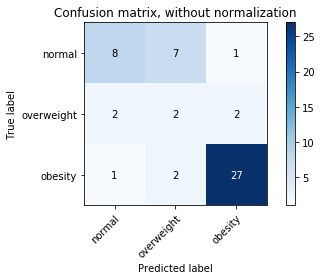

In [39]:
plot_confusion_matrix(y_test, y_pred, classes=class_names)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.50      0.59        16
           1       0.18      0.33      0.24         6
           2       0.90      0.90      0.90        30

    accuracy                           0.71        52
   macro avg       0.60      0.58      0.58        52
weighted avg       0.76      0.71      0.73        52



## Gradient Boosting Tuning

In [41]:
results_weighted = []
results_macro = []
names = []
num_tests = 4*3*3*3*2*2*3*4
i = 1

for learning_rate in [0.01, 0.05, 0.1, 0.2]:
    for min_samples_leaf in [1,3,5]:
        for min_samples_split in [2,4,6]:
            for max_depth in [3,5,8]:
                for max_features in ["log2","sqrt"]:
                    for criterion in ["friedman_mse",  "mae"]:
                        for subsample in [0.5, 0.75, 1.0]:
                            for n_estimators in [50, 100, 200, 500]:
                                print("Testing {}/{}".format(i,num_tests))
                                i+=1
                                kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
                                sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
                                cv_results_weighted = np.array([])
                                cv_results_macro = np.array([])
                                for train_idx, test_idx, in kf.split(X_train, y_train):
                                    X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
                                    X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
                                    X_cross_train, y_cross_train = sm.fit_sample(X_cross_train, y_cross_train)
                                    model = GradientBoostingClassifier(learning_rate=learning_rate, min_samples_leaf=min_samples_leaf, 
                                            min_samples_split=min_samples_split, max_depth=max_depth, max_features=max_features,                           
                                            criterion=criterion, subsample=subsample, n_estimators=n_estimators)
                                    model.fit(X_cross_train, y_cross_train)  
                                    y_pred = model.predict(X_cross_test)
                                    f1s_weight = f1_score(y_cross_test, y_pred, average="weighted")
                                    f1s_macro = f1_score(y_cross_test, y_pred, average="macro")
                                    cv_results_weighted = np.append(cv_results_weighted, [f1s_weight])
                                    cv_results_macro = np.append(cv_results_macro, [f1s_macro])
                                results_weighted.append(cv_results_weighted)
                                results_macro.append(cv_results_macro)
                                name = "{} {} {} {} {} {} {} {}".format(learning_rate, min_samples_leaf, min_samples_split, max_depth, 
                                    max_features, criterion, subsample, n_estimators)
                                names.append(name)
                                msg = "%s: Weighted %f (%f)" % (name, cv_results_weighted.mean(), cv_results_weighted.std())
                                print(msg)
                                msg = "%s: Macro %f (%f)" % (name, cv_results_macro.mean(), cv_results_macro.std())
                                print(msg)

Testing 1/5184
0.01 1 2 3 log2 friedman_mse 0.5 50: Weighted 0.824584 (0.048793)
0.01 1 2 3 log2 friedman_mse 0.5 50: Macro 0.717955 (0.067713)
Testing 2/5184
0.01 1 2 3 log2 friedman_mse 0.5 100: Weighted 0.823429 (0.050375)
0.01 1 2 3 log2 friedman_mse 0.5 100: Macro 0.713676 (0.073970)
Testing 3/5184
0.01 1 2 3 log2 friedman_mse 0.5 200: Weighted 0.819671 (0.051220)
0.01 1 2 3 log2 friedman_mse 0.5 200: Macro 0.715281 (0.069645)
Testing 4/5184
0.01 1 2 3 log2 friedman_mse 0.5 500: Weighted 0.810853 (0.062021)
0.01 1 2 3 log2 friedman_mse 0.5 500: Macro 0.706601 (0.082666)
Testing 5/5184
0.01 1 2 3 log2 friedman_mse 0.75 50: Weighted 0.804891 (0.068104)
0.01 1 2 3 log2 friedman_mse 0.75 50: Macro 0.696498 (0.089185)
Testing 6/5184
0.01 1 2 3 log2 friedman_mse 0.75 100: Weighted 0.809078 (0.065610)
0.01 1 2 3 log2 friedman_mse 0.75 100: Macro 0.701225 (0.088057)
Testing 7/5184
0.01 1 2 3 log2 friedman_mse 0.75 200: Weighted 0.808298 (0.066729)
0.01 1 2 3 log2 friedman_mse 0.75 200: Ma

0.01 1 2 5 log2 friedman_mse 1.0 500: Weighted 0.785153 (0.069619)
0.01 1 2 5 log2 friedman_mse 1.0 500: Macro 0.683412 (0.106523)
Testing 61/5184
0.01 1 2 5 log2 mae 0.5 50: Weighted 0.792828 (0.064267)
0.01 1 2 5 log2 mae 0.5 50: Macro 0.675874 (0.083846)
Testing 62/5184
0.01 1 2 5 log2 mae 0.5 100: Weighted 0.793792 (0.047293)
0.01 1 2 5 log2 mae 0.5 100: Macro 0.676446 (0.067541)
Testing 63/5184
0.01 1 2 5 log2 mae 0.5 200: Weighted 0.796752 (0.054839)
0.01 1 2 5 log2 mae 0.5 200: Macro 0.675384 (0.076467)
Testing 64/5184
0.01 1 2 5 log2 mae 0.5 500: Weighted 0.795561 (0.045598)
0.01 1 2 5 log2 mae 0.5 500: Macro 0.676198 (0.067749)
Testing 65/5184
0.01 1 2 5 log2 mae 0.75 50: Weighted 0.783817 (0.061140)
0.01 1 2 5 log2 mae 0.75 50: Macro 0.662230 (0.087024)
Testing 66/5184
0.01 1 2 5 log2 mae 0.75 100: Weighted 0.773643 (0.039227)
0.01 1 2 5 log2 mae 0.75 100: Macro 0.652019 (0.057345)
Testing 67/5184
0.01 1 2 5 log2 mae 0.75 200: Weighted 0.773115 (0.050616)
0.01 1 2 5 log2 mae 

0.01 1 2 8 log2 mae 1.0 500: Weighted 0.777545 (0.050953)
0.01 1 2 8 log2 mae 1.0 500: Macro 0.657338 (0.076509)
Testing 121/5184
0.01 1 2 8 sqrt friedman_mse 0.5 50: Weighted 0.797715 (0.075164)
0.01 1 2 8 sqrt friedman_mse 0.5 50: Macro 0.680074 (0.109733)
Testing 122/5184
0.01 1 2 8 sqrt friedman_mse 0.5 100: Weighted 0.801942 (0.060486)
0.01 1 2 8 sqrt friedman_mse 0.5 100: Macro 0.695407 (0.078679)
Testing 123/5184
0.01 1 2 8 sqrt friedman_mse 0.5 200: Weighted 0.811295 (0.072326)
0.01 1 2 8 sqrt friedman_mse 0.5 200: Macro 0.702669 (0.103559)
Testing 124/5184
0.01 1 2 8 sqrt friedman_mse 0.5 500: Weighted 0.815692 (0.079359)
0.01 1 2 8 sqrt friedman_mse 0.5 500: Macro 0.710294 (0.115339)
Testing 125/5184
0.01 1 2 8 sqrt friedman_mse 0.75 50: Weighted 0.785504 (0.071522)
0.01 1 2 8 sqrt friedman_mse 0.75 50: Macro 0.675642 (0.101123)
Testing 126/5184
0.01 1 2 8 sqrt friedman_mse 0.75 100: Weighted 0.782839 (0.043115)
0.01 1 2 8 sqrt friedman_mse 0.75 100: Macro 0.670253 (0.067805)

0.01 1 4 3 sqrt friedman_mse 1.0 200: Weighted 0.797332 (0.051684)
0.01 1 4 3 sqrt friedman_mse 1.0 200: Macro 0.693020 (0.060210)
Testing 180/5184
0.01 1 4 3 sqrt friedman_mse 1.0 500: Weighted 0.797623 (0.067722)
0.01 1 4 3 sqrt friedman_mse 1.0 500: Macro 0.693810 (0.095800)
Testing 181/5184
0.01 1 4 3 sqrt mae 0.5 50: Weighted 0.798848 (0.064842)
0.01 1 4 3 sqrt mae 0.5 50: Macro 0.683021 (0.089445)
Testing 182/5184
0.01 1 4 3 sqrt mae 0.5 100: Weighted 0.816386 (0.048990)
0.01 1 4 3 sqrt mae 0.5 100: Macro 0.705788 (0.066974)
Testing 183/5184
0.01 1 4 3 sqrt mae 0.5 200: Weighted 0.808201 (0.054866)
0.01 1 4 3 sqrt mae 0.5 200: Macro 0.697301 (0.072138)
Testing 184/5184
0.01 1 4 3 sqrt mae 0.5 500: Weighted 0.800828 (0.058895)
0.01 1 4 3 sqrt mae 0.5 500: Macro 0.681969 (0.083313)
Testing 185/5184
0.01 1 4 3 sqrt mae 0.75 50: Weighted 0.787322 (0.064692)
0.01 1 4 3 sqrt mae 0.75 50: Macro 0.669603 (0.086992)
Testing 186/5184
0.01 1 4 3 sqrt mae 0.75 100: Weighted 0.793311 (0.05483

0.01 1 4 5 sqrt mae 1.0 200: Weighted 0.775619 (0.046984)
0.01 1 4 5 sqrt mae 1.0 200: Macro 0.650894 (0.075539)
Testing 240/5184
0.01 1 4 5 sqrt mae 1.0 500: Weighted 0.776878 (0.065683)
0.01 1 4 5 sqrt mae 1.0 500: Macro 0.645403 (0.099170)
Testing 241/5184
0.01 1 4 8 log2 friedman_mse 0.5 50: Weighted 0.817111 (0.048979)
0.01 1 4 8 log2 friedman_mse 0.5 50: Macro 0.714555 (0.062414)
Testing 242/5184
0.01 1 4 8 log2 friedman_mse 0.5 100: Weighted 0.802645 (0.048768)
0.01 1 4 8 log2 friedman_mse 0.5 100: Macro 0.693199 (0.064084)
Testing 243/5184
0.01 1 4 8 log2 friedman_mse 0.5 200: Weighted 0.804281 (0.056912)
0.01 1 4 8 log2 friedman_mse 0.5 200: Macro 0.696037 (0.076773)
Testing 244/5184
0.01 1 4 8 log2 friedman_mse 0.5 500: Weighted 0.811902 (0.079400)
0.01 1 4 8 log2 friedman_mse 0.5 500: Macro 0.701348 (0.114838)
Testing 245/5184
0.01 1 4 8 log2 friedman_mse 0.75 50: Weighted 0.805932 (0.061871)
0.01 1 4 8 log2 friedman_mse 0.75 50: Macro 0.700206 (0.081116)
Testing 246/5184
0.

0.01 1 6 3 log2 friedman_mse 1.0 100: Weighted 0.795282 (0.059792)
0.01 1 6 3 log2 friedman_mse 1.0 100: Macro 0.689830 (0.068099)
Testing 299/5184
0.01 1 6 3 log2 friedman_mse 1.0 200: Weighted 0.794035 (0.063983)
0.01 1 6 3 log2 friedman_mse 1.0 200: Macro 0.681503 (0.079425)
Testing 300/5184
0.01 1 6 3 log2 friedman_mse 1.0 500: Weighted 0.802343 (0.065761)
0.01 1 6 3 log2 friedman_mse 1.0 500: Macro 0.703261 (0.088796)
Testing 301/5184
0.01 1 6 3 log2 mae 0.5 50: Weighted 0.816087 (0.057114)
0.01 1 6 3 log2 mae 0.5 50: Macro 0.707871 (0.076731)
Testing 302/5184
0.01 1 6 3 log2 mae 0.5 100: Weighted 0.807809 (0.056932)
0.01 1 6 3 log2 mae 0.5 100: Macro 0.695770 (0.075758)
Testing 303/5184
0.01 1 6 3 log2 mae 0.5 200: Weighted 0.804365 (0.061292)
0.01 1 6 3 log2 mae 0.5 200: Macro 0.686311 (0.088368)
Testing 304/5184
0.01 1 6 3 log2 mae 0.5 500: Weighted 0.799524 (0.057326)
0.01 1 6 3 log2 mae 0.5 500: Macro 0.683667 (0.085264)
Testing 305/5184
0.01 1 6 3 log2 mae 0.75 50: Weighted 

0.01 1 6 5 log2 mae 1.0 100: Weighted 0.763060 (0.046418)
0.01 1 6 5 log2 mae 1.0 100: Macro 0.637335 (0.074122)
Testing 359/5184
0.01 1 6 5 log2 mae 1.0 200: Weighted 0.776334 (0.043173)
0.01 1 6 5 log2 mae 1.0 200: Macro 0.653131 (0.072074)
Testing 360/5184
0.01 1 6 5 log2 mae 1.0 500: Weighted 0.766099 (0.065294)
0.01 1 6 5 log2 mae 1.0 500: Macro 0.635178 (0.100481)
Testing 361/5184
0.01 1 6 5 sqrt friedman_mse 0.5 50: Weighted 0.815868 (0.036469)
0.01 1 6 5 sqrt friedman_mse 0.5 50: Macro 0.714015 (0.048892)
Testing 362/5184
0.01 1 6 5 sqrt friedman_mse 0.5 100: Weighted 0.810827 (0.051243)
0.01 1 6 5 sqrt friedman_mse 0.5 100: Macro 0.704132 (0.065808)
Testing 363/5184
0.01 1 6 5 sqrt friedman_mse 0.5 200: Weighted 0.818439 (0.067398)
0.01 1 6 5 sqrt friedman_mse 0.5 200: Macro 0.712482 (0.095393)
Testing 364/5184
0.01 1 6 5 sqrt friedman_mse 0.5 500: Weighted 0.815692 (0.079359)
0.01 1 6 5 sqrt friedman_mse 0.5 500: Macro 0.710294 (0.115339)
Testing 365/5184
0.01 1 6 5 sqrt frie

0.01 1 6 8 sqrt friedman_mse 1.0 50: Weighted 0.769097 (0.057431)
0.01 1 6 8 sqrt friedman_mse 1.0 50: Macro 0.653838 (0.077510)
Testing 418/5184
0.01 1 6 8 sqrt friedman_mse 1.0 100: Weighted 0.792742 (0.061872)
0.01 1 6 8 sqrt friedman_mse 1.0 100: Macro 0.678482 (0.083721)
Testing 419/5184
0.01 1 6 8 sqrt friedman_mse 1.0 200: Weighted 0.798966 (0.072361)
0.01 1 6 8 sqrt friedman_mse 1.0 200: Macro 0.688386 (0.100422)
Testing 420/5184
0.01 1 6 8 sqrt friedman_mse 1.0 500: Weighted 0.785004 (0.062765)
0.01 1 6 8 sqrt friedman_mse 1.0 500: Macro 0.675387 (0.100945)
Testing 421/5184
0.01 1 6 8 sqrt mae 0.5 50: Weighted 0.793114 (0.030293)
0.01 1 6 8 sqrt mae 0.5 50: Macro 0.680515 (0.044811)
Testing 422/5184
0.01 1 6 8 sqrt mae 0.5 100: Weighted 0.802628 (0.029243)
0.01 1 6 8 sqrt mae 0.5 100: Macro 0.693561 (0.043899)
Testing 423/5184
0.01 1 6 8 sqrt mae 0.5 200: Weighted 0.791659 (0.040472)
0.01 1 6 8 sqrt mae 0.5 200: Macro 0.673171 (0.063052)
Testing 424/5184
0.01 1 6 8 sqrt mae 0.

0.01 3 2 3 sqrt mae 1.0 50: Weighted 0.803629 (0.059835)
0.01 3 2 3 sqrt mae 1.0 50: Macro 0.692889 (0.083709)
Testing 478/5184
0.01 3 2 3 sqrt mae 1.0 100: Weighted 0.790955 (0.063869)
0.01 3 2 3 sqrt mae 1.0 100: Macro 0.671465 (0.085860)
Testing 479/5184
0.01 3 2 3 sqrt mae 1.0 200: Weighted 0.777192 (0.070839)
0.01 3 2 3 sqrt mae 1.0 200: Macro 0.655458 (0.098579)
Testing 480/5184
0.01 3 2 3 sqrt mae 1.0 500: Weighted 0.778546 (0.072123)
0.01 3 2 3 sqrt mae 1.0 500: Macro 0.659316 (0.098106)
Testing 481/5184
0.01 3 2 5 log2 friedman_mse 0.5 50: Weighted 0.818912 (0.051958)
0.01 3 2 5 log2 friedman_mse 0.5 50: Macro 0.716404 (0.067585)
Testing 482/5184
0.01 3 2 5 log2 friedman_mse 0.5 100: Weighted 0.821138 (0.046966)
0.01 3 2 5 log2 friedman_mse 0.5 100: Macro 0.719633 (0.065217)
Testing 483/5184
0.01 3 2 5 log2 friedman_mse 0.5 200: Weighted 0.816182 (0.045100)
0.01 3 2 5 log2 friedman_mse 0.5 200: Macro 0.707932 (0.059020)
Testing 484/5184
0.01 3 2 5 log2 friedman_mse 0.5 500: We

0.01 3 2 8 log2 friedman_mse 0.75 500: Weighted 0.807503 (0.081329)
0.01 3 2 8 log2 friedman_mse 0.75 500: Macro 0.703396 (0.114260)
Testing 537/5184
0.01 3 2 8 log2 friedman_mse 1.0 50: Weighted 0.779517 (0.061306)
0.01 3 2 8 log2 friedman_mse 1.0 50: Macro 0.664153 (0.082405)
Testing 538/5184
0.01 3 2 8 log2 friedman_mse 1.0 100: Weighted 0.776867 (0.052033)
0.01 3 2 8 log2 friedman_mse 1.0 100: Macro 0.663181 (0.070093)
Testing 539/5184
0.01 3 2 8 log2 friedman_mse 1.0 200: Weighted 0.783757 (0.059787)
0.01 3 2 8 log2 friedman_mse 1.0 200: Macro 0.668345 (0.077680)
Testing 540/5184
0.01 3 2 8 log2 friedman_mse 1.0 500: Weighted 0.786419 (0.084335)
0.01 3 2 8 log2 friedman_mse 1.0 500: Macro 0.676834 (0.117518)
Testing 541/5184
0.01 3 2 8 log2 mae 0.5 50: Weighted 0.804118 (0.065418)
0.01 3 2 8 log2 mae 0.5 50: Macro 0.683189 (0.096083)
Testing 542/5184
0.01 3 2 8 log2 mae 0.5 100: Weighted 0.806507 (0.054030)
0.01 3 2 8 log2 mae 0.5 100: Macro 0.693616 (0.074856)
Testing 543/5184
0.

0.01 3 4 3 log2 mae 0.75 200: Weighted 0.786525 (0.066237)
0.01 3 4 3 log2 mae 0.75 200: Macro 0.661559 (0.091420)
Testing 596/5184
0.01 3 4 3 log2 mae 0.75 500: Weighted 0.790564 (0.067191)
0.01 3 4 3 log2 mae 0.75 500: Macro 0.671916 (0.096950)
Testing 597/5184
0.01 3 4 3 log2 mae 1.0 50: Weighted 0.789317 (0.067004)
0.01 3 4 3 log2 mae 1.0 50: Macro 0.676373 (0.086767)
Testing 598/5184
0.01 3 4 3 log2 mae 1.0 100: Weighted 0.798096 (0.061890)
0.01 3 4 3 log2 mae 1.0 100: Macro 0.681371 (0.083516)
Testing 599/5184
0.01 3 4 3 log2 mae 1.0 200: Weighted 0.772430 (0.066706)
0.01 3 4 3 log2 mae 1.0 200: Macro 0.648316 (0.092216)
Testing 600/5184
0.01 3 4 3 log2 mae 1.0 500: Weighted 0.769249 (0.075418)
0.01 3 4 3 log2 mae 1.0 500: Macro 0.642357 (0.107772)
Testing 601/5184
0.01 3 4 3 sqrt friedman_mse 0.5 50: Weighted 0.816593 (0.056095)
0.01 3 4 3 sqrt friedman_mse 0.5 50: Macro 0.704334 (0.083640)
Testing 602/5184
0.01 3 4 3 sqrt friedman_mse 0.5 100: Weighted 0.818925 (0.048401)
0.01 

0.01 3 4 5 sqrt friedman_mse 0.75 100: Weighted 0.814194 (0.059682)
0.01 3 4 5 sqrt friedman_mse 0.75 100: Macro 0.704005 (0.084637)
Testing 655/5184
0.01 3 4 5 sqrt friedman_mse 0.75 200: Weighted 0.814614 (0.041592)
0.01 3 4 5 sqrt friedman_mse 0.75 200: Macro 0.706670 (0.053652)
Testing 656/5184
0.01 3 4 5 sqrt friedman_mse 0.75 500: Weighted 0.803616 (0.089535)
0.01 3 4 5 sqrt friedman_mse 0.75 500: Macro 0.699006 (0.126181)
Testing 657/5184
0.01 3 4 5 sqrt friedman_mse 1.0 50: Weighted 0.789572 (0.067425)
0.01 3 4 5 sqrt friedman_mse 1.0 50: Macro 0.678074 (0.089569)
Testing 658/5184
0.01 3 4 5 sqrt friedman_mse 1.0 100: Weighted 0.788710 (0.064739)
0.01 3 4 5 sqrt friedman_mse 1.0 100: Macro 0.682109 (0.084263)
Testing 659/5184
0.01 3 4 5 sqrt friedman_mse 1.0 200: Weighted 0.788746 (0.066870)
0.01 3 4 5 sqrt friedman_mse 1.0 200: Macro 0.681420 (0.083805)
Testing 660/5184
0.01 3 4 5 sqrt friedman_mse 1.0 500: Weighted 0.804172 (0.095163)
0.01 3 4 5 sqrt friedman_mse 1.0 500: Mac

0.01 3 4 8 sqrt mae 0.75 50: Weighted 0.797953 (0.064489)
0.01 3 4 8 sqrt mae 0.75 50: Macro 0.677766 (0.090043)
Testing 714/5184
0.01 3 4 8 sqrt mae 0.75 100: Weighted 0.795067 (0.069586)
0.01 3 4 8 sqrt mae 0.75 100: Macro 0.674380 (0.095469)
Testing 715/5184
0.01 3 4 8 sqrt mae 0.75 200: Weighted 0.781440 (0.069609)
0.01 3 4 8 sqrt mae 0.75 200: Macro 0.644630 (0.106609)
Testing 716/5184
0.01 3 4 8 sqrt mae 0.75 500: Weighted 0.775669 (0.086068)
0.01 3 4 8 sqrt mae 0.75 500: Macro 0.646648 (0.120275)
Testing 717/5184
0.01 3 4 8 sqrt mae 1.0 50: Weighted 0.795295 (0.065383)
0.01 3 4 8 sqrt mae 1.0 50: Macro 0.670020 (0.092736)
Testing 718/5184
0.01 3 4 8 sqrt mae 1.0 100: Weighted 0.769908 (0.058942)
0.01 3 4 8 sqrt mae 1.0 100: Macro 0.647289 (0.080215)
Testing 719/5184
0.01 3 4 8 sqrt mae 1.0 200: Weighted 0.772382 (0.064902)
0.01 3 4 8 sqrt mae 1.0 200: Macro 0.646748 (0.092900)
Testing 720/5184
0.01 3 4 8 sqrt mae 1.0 500: Weighted 0.773349 (0.105478)
0.01 3 4 8 sqrt mae 1.0 500:

0.01 3 6 5 log2 friedman_mse 0.75 50: Weighted 0.800498 (0.052218)
0.01 3 6 5 log2 friedman_mse 0.75 50: Macro 0.690642 (0.079516)
Testing 774/5184
0.01 3 6 5 log2 friedman_mse 0.75 100: Weighted 0.792344 (0.053991)
0.01 3 6 5 log2 friedman_mse 0.75 100: Macro 0.678342 (0.075777)
Testing 775/5184
0.01 3 6 5 log2 friedman_mse 0.75 200: Weighted 0.803860 (0.052152)
0.01 3 6 5 log2 friedman_mse 0.75 200: Macro 0.696268 (0.061428)
Testing 776/5184
0.01 3 6 5 log2 friedman_mse 0.75 500: Weighted 0.804506 (0.088968)
0.01 3 6 5 log2 friedman_mse 0.75 500: Macro 0.697776 (0.126233)
Testing 777/5184
0.01 3 6 5 log2 friedman_mse 1.0 50: Weighted 0.777451 (0.064308)
0.01 3 6 5 log2 friedman_mse 1.0 50: Macro 0.659257 (0.088019)
Testing 778/5184
0.01 3 6 5 log2 friedman_mse 1.0 100: Weighted 0.777754 (0.055904)
0.01 3 6 5 log2 friedman_mse 1.0 100: Macro 0.669410 (0.073077)
Testing 779/5184
0.01 3 6 5 log2 friedman_mse 1.0 200: Weighted 0.781653 (0.058826)
0.01 3 6 5 log2 friedman_mse 1.0 200: Mac

0.01 3 6 8 log2 mae 0.5 500: Weighted 0.794407 (0.074862)
0.01 3 6 8 log2 mae 0.5 500: Macro 0.670616 (0.109113)
Testing 833/5184
0.01 3 6 8 log2 mae 0.75 50: Weighted 0.782425 (0.068534)
0.01 3 6 8 log2 mae 0.75 50: Macro 0.651306 (0.100088)
Testing 834/5184
0.01 3 6 8 log2 mae 0.75 100: Weighted 0.807858 (0.044689)
0.01 3 6 8 log2 mae 0.75 100: Macro 0.688951 (0.064133)
Testing 835/5184
0.01 3 6 8 log2 mae 0.75 200: Weighted 0.775924 (0.075176)
0.01 3 6 8 log2 mae 0.75 200: Macro 0.640641 (0.110533)
Testing 836/5184
0.01 3 6 8 log2 mae 0.75 500: Weighted 0.776060 (0.085921)
0.01 3 6 8 log2 mae 0.75 500: Macro 0.643477 (0.123702)
Testing 837/5184
0.01 3 6 8 log2 mae 1.0 50: Weighted 0.772415 (0.068466)
0.01 3 6 8 log2 mae 1.0 50: Macro 0.640530 (0.103482)
Testing 838/5184
0.01 3 6 8 log2 mae 1.0 100: Weighted 0.772703 (0.081218)
0.01 3 6 8 log2 mae 1.0 100: Macro 0.641049 (0.114916)
Testing 839/5184
0.01 3 6 8 log2 mae 1.0 200: Weighted 0.762353 (0.066422)
0.01 3 6 8 log2 mae 1.0 200:

0.01 5 2 3 sqrt friedman_mse 0.5 500: Weighted 0.824686 (0.069608)
0.01 5 2 3 sqrt friedman_mse 0.5 500: Macro 0.724031 (0.093481)
Testing 893/5184
0.01 5 2 3 sqrt friedman_mse 0.75 50: Weighted 0.815571 (0.061789)
0.01 5 2 3 sqrt friedman_mse 0.75 50: Macro 0.711176 (0.077719)
Testing 894/5184
0.01 5 2 3 sqrt friedman_mse 0.75 100: Weighted 0.807130 (0.060671)
0.01 5 2 3 sqrt friedman_mse 0.75 100: Macro 0.699865 (0.076278)
Testing 895/5184
0.01 5 2 3 sqrt friedman_mse 0.75 200: Weighted 0.806876 (0.063184)
0.01 5 2 3 sqrt friedman_mse 0.75 200: Macro 0.695055 (0.085097)
Testing 896/5184
0.01 5 2 3 sqrt friedman_mse 0.75 500: Weighted 0.818095 (0.074549)
0.01 5 2 3 sqrt friedman_mse 0.75 500: Macro 0.718826 (0.094341)
Testing 897/5184
0.01 5 2 3 sqrt friedman_mse 1.0 50: Weighted 0.808438 (0.063995)
0.01 5 2 3 sqrt friedman_mse 1.0 50: Macro 0.702118 (0.082044)
Testing 898/5184
0.01 5 2 3 sqrt friedman_mse 1.0 100: Weighted 0.795814 (0.068989)
0.01 5 2 3 sqrt friedman_mse 1.0 100: Mac

0.01 5 2 5 sqrt mae 0.5 200: Weighted 0.812722 (0.058740)
0.01 5 2 5 sqrt mae 0.5 200: Macro 0.699936 (0.083135)
Testing 952/5184
0.01 5 2 5 sqrt mae 0.5 500: Weighted 0.803582 (0.065941)
0.01 5 2 5 sqrt mae 0.5 500: Macro 0.684673 (0.094553)
Testing 953/5184
0.01 5 2 5 sqrt mae 0.75 50: Weighted 0.787956 (0.066380)
0.01 5 2 5 sqrt mae 0.75 50: Macro 0.665397 (0.089493)
Testing 954/5184
0.01 5 2 5 sqrt mae 0.75 100: Weighted 0.790674 (0.072755)
0.01 5 2 5 sqrt mae 0.75 100: Macro 0.669556 (0.098917)
Testing 955/5184
0.01 5 2 5 sqrt mae 0.75 200: Weighted 0.792459 (0.069494)
0.01 5 2 5 sqrt mae 0.75 200: Macro 0.668591 (0.098782)
Testing 956/5184
0.01 5 2 5 sqrt mae 0.75 500: Weighted 0.774638 (0.076612)
0.01 5 2 5 sqrt mae 0.75 500: Macro 0.638086 (0.113235)
Testing 957/5184
0.01 5 2 5 sqrt mae 1.0 50: Weighted 0.794825 (0.078822)
0.01 5 2 5 sqrt mae 1.0 50: Macro 0.676727 (0.105947)
Testing 958/5184
0.01 5 2 5 sqrt mae 1.0 100: Weighted 0.786095 (0.075948)
0.01 5 2 5 sqrt mae 1.0 100:

0.01 5 4 3 log2 friedman_mse 0.5 200: Weighted 0.819900 (0.055039)
0.01 5 4 3 log2 friedman_mse 0.5 200: Macro 0.715467 (0.073167)
Testing 1012/5184
0.01 5 4 3 log2 friedman_mse 0.5 500: Weighted 0.824291 (0.063492)
0.01 5 4 3 log2 friedman_mse 0.5 500: Macro 0.721276 (0.088216)
Testing 1013/5184
0.01 5 4 3 log2 friedman_mse 0.75 50: Weighted 0.807960 (0.068755)
0.01 5 4 3 log2 friedman_mse 0.75 50: Macro 0.696842 (0.092841)
Testing 1014/5184
0.01 5 4 3 log2 friedman_mse 0.75 100: Weighted 0.815571 (0.061789)
0.01 5 4 3 log2 friedman_mse 0.75 100: Macro 0.711176 (0.077719)
Testing 1015/5184
0.01 5 4 3 log2 friedman_mse 0.75 200: Weighted 0.806695 (0.063078)
0.01 5 4 3 log2 friedman_mse 0.75 200: Macro 0.695979 (0.085719)
Testing 1016/5184
0.01 5 4 3 log2 friedman_mse 0.75 500: Weighted 0.814650 (0.065922)
0.01 5 4 3 log2 friedman_mse 0.75 500: Macro 0.712154 (0.083615)
Testing 1017/5184
0.01 5 4 3 log2 friedman_mse 1.0 50: Weighted 0.804263 (0.069761)
0.01 5 4 3 log2 friedman_mse 1.0 5

0.01 5 4 5 log2 mae 0.5 50: Weighted 0.817184 (0.053385)
0.01 5 4 5 log2 mae 0.5 50: Macro 0.703305 (0.078713)
Testing 1070/5184
0.01 5 4 5 log2 mae 0.5 100: Weighted 0.823660 (0.046907)
0.01 5 4 5 log2 mae 0.5 100: Macro 0.718961 (0.062664)
Testing 1071/5184
0.01 5 4 5 log2 mae 0.5 200: Weighted 0.820700 (0.051056)
0.01 5 4 5 log2 mae 0.5 200: Macro 0.708262 (0.076184)
Testing 1072/5184
0.01 5 4 5 log2 mae 0.5 500: Weighted 0.804683 (0.072895)
0.01 5 4 5 log2 mae 0.5 500: Macro 0.687388 (0.105088)
Testing 1073/5184
0.01 5 4 5 log2 mae 0.75 50: Weighted 0.797901 (0.061062)
0.01 5 4 5 log2 mae 0.75 50: Macro 0.675065 (0.086335)
Testing 1074/5184
0.01 5 4 5 log2 mae 0.75 100: Weighted 0.788044 (0.074153)
0.01 5 4 5 log2 mae 0.75 100: Macro 0.665325 (0.102162)
Testing 1075/5184
0.01 5 4 5 log2 mae 0.75 200: Weighted 0.791626 (0.071602)
0.01 5 4 5 log2 mae 0.75 200: Macro 0.669887 (0.098535)
Testing 1076/5184
0.01 5 4 5 log2 mae 0.75 500: Weighted 0.782724 (0.079160)
0.01 5 4 5 log2 mae 0.

0.01 5 4 8 sqrt friedman_mse 0.5 50: Weighted 0.809563 (0.053472)
0.01 5 4 8 sqrt friedman_mse 0.5 50: Macro 0.704292 (0.067349)
Testing 1130/5184
0.01 5 4 8 sqrt friedman_mse 0.5 100: Weighted 0.812810 (0.054164)
0.01 5 4 8 sqrt friedman_mse 0.5 100: Macro 0.710186 (0.070046)
Testing 1131/5184
0.01 5 4 8 sqrt friedman_mse 0.5 200: Weighted 0.814190 (0.053789)
0.01 5 4 8 sqrt friedman_mse 0.5 200: Macro 0.708785 (0.070211)
Testing 1132/5184
0.01 5 4 8 sqrt friedman_mse 0.5 500: Weighted 0.832270 (0.069649)
0.01 5 4 8 sqrt friedman_mse 0.5 500: Macro 0.731991 (0.100626)
Testing 1133/5184
0.01 5 4 8 sqrt friedman_mse 0.75 50: Weighted 0.815098 (0.057261)
0.01 5 4 8 sqrt friedman_mse 0.75 50: Macro 0.706080 (0.081400)
Testing 1134/5184
0.01 5 4 8 sqrt friedman_mse 0.75 100: Weighted 0.801890 (0.054519)
0.01 5 4 8 sqrt friedman_mse 0.75 100: Macro 0.687273 (0.076484)
Testing 1135/5184
0.01 5 4 8 sqrt friedman_mse 0.75 200: Weighted 0.803038 (0.052051)
0.01 5 4 8 sqrt friedman_mse 0.75 200:

0.01 5 6 3 sqrt friedman_mse 1.0 200: Weighted 0.801164 (0.062389)
0.01 5 6 3 sqrt friedman_mse 1.0 200: Macro 0.688033 (0.081002)
Testing 1188/5184
0.01 5 6 3 sqrt friedman_mse 1.0 500: Weighted 0.808920 (0.077890)
0.01 5 6 3 sqrt friedman_mse 1.0 500: Macro 0.710476 (0.098853)
Testing 1189/5184
0.01 5 6 3 sqrt mae 0.5 50: Weighted 0.809679 (0.060544)
0.01 5 6 3 sqrt mae 0.5 50: Macro 0.697604 (0.082947)
Testing 1190/5184
0.01 5 6 3 sqrt mae 0.5 100: Weighted 0.817632 (0.052880)
0.01 5 6 3 sqrt mae 0.5 100: Macro 0.707973 (0.072913)
Testing 1191/5184
0.01 5 6 3 sqrt mae 0.5 200: Weighted 0.824584 (0.048793)
0.01 5 6 3 sqrt mae 0.5 200: Macro 0.717955 (0.067713)
Testing 1192/5184
0.01 5 6 3 sqrt mae 0.5 500: Weighted 0.821452 (0.058967)
0.01 5 6 3 sqrt mae 0.5 500: Macro 0.710767 (0.088146)
Testing 1193/5184
0.01 5 6 3 sqrt mae 0.75 50: Weighted 0.803619 (0.062890)
0.01 5 6 3 sqrt mae 0.75 50: Macro 0.689303 (0.088728)
Testing 1194/5184
0.01 5 6 3 sqrt mae 0.75 100: Weighted 0.791181 (

0.01 5 6 5 sqrt mae 1.0 100: Weighted 0.790785 (0.072619)
0.01 5 6 5 sqrt mae 1.0 100: Macro 0.663930 (0.105675)
Testing 1247/5184
0.01 5 6 5 sqrt mae 1.0 200: Weighted 0.782878 (0.086747)
0.01 5 6 5 sqrt mae 1.0 200: Macro 0.651316 (0.127695)
Testing 1248/5184
0.01 5 6 5 sqrt mae 1.0 500: Weighted 0.783182 (0.076385)
0.01 5 6 5 sqrt mae 1.0 500: Macro 0.652731 (0.113130)
Testing 1249/5184
0.01 5 6 8 log2 friedman_mse 0.5 50: Weighted 0.827046 (0.054065)
0.01 5 6 8 log2 friedman_mse 0.5 50: Macro 0.727407 (0.072436)
Testing 1250/5184
0.01 5 6 8 log2 friedman_mse 0.5 100: Weighted 0.812404 (0.054710)
0.01 5 6 8 log2 friedman_mse 0.5 100: Macro 0.705561 (0.076965)
Testing 1251/5184
0.01 5 6 8 log2 friedman_mse 0.5 200: Weighted 0.822195 (0.049353)
0.01 5 6 8 log2 friedman_mse 0.5 200: Macro 0.723644 (0.066775)
Testing 1252/5184
0.01 5 6 8 log2 friedman_mse 0.5 500: Weighted 0.826704 (0.077055)
0.01 5 6 8 log2 friedman_mse 0.5 500: Macro 0.721358 (0.114438)
Testing 1253/5184
0.01 5 6 8 lo

0.05 1 2 3 log2 friedman_mse 1.0 50: Weighted 0.787801 (0.046706)
0.05 1 2 3 log2 friedman_mse 1.0 50: Macro 0.678354 (0.064893)
Testing 1306/5184
0.05 1 2 3 log2 friedman_mse 1.0 100: Weighted 0.802218 (0.075237)
0.05 1 2 3 log2 friedman_mse 1.0 100: Macro 0.697552 (0.101754)
Testing 1307/5184
0.05 1 2 3 log2 friedman_mse 1.0 200: Weighted 0.798620 (0.046925)
0.05 1 2 3 log2 friedman_mse 1.0 200: Macro 0.695488 (0.077148)
Testing 1308/5184
0.05 1 2 3 log2 friedman_mse 1.0 500: Weighted 0.788623 (0.058444)
0.05 1 2 3 log2 friedman_mse 1.0 500: Macro 0.680589 (0.095327)
Testing 1309/5184
0.05 1 2 3 log2 mae 0.5 50: Weighted 0.794907 (0.067420)
0.05 1 2 3 log2 mae 0.5 50: Macro 0.674219 (0.094028)
Testing 1310/5184
0.05 1 2 3 log2 mae 0.5 100: Weighted 0.803940 (0.058812)
0.05 1 2 3 log2 mae 0.5 100: Macro 0.687066 (0.081416)
Testing 1311/5184
0.05 1 2 3 log2 mae 0.5 200: Weighted 0.770638 (0.052471)
0.05 1 2 3 log2 mae 0.5 200: Macro 0.648200 (0.075706)
Testing 1312/5184
0.05 1 2 3 log2

0.05 1 2 5 log2 mae 0.75 500: Weighted 0.783897 (0.075705)
0.05 1 2 5 log2 mae 0.75 500: Macro 0.659039 (0.111032)
Testing 1365/5184
0.05 1 2 5 log2 mae 1.0 50: Weighted 0.754803 (0.056551)
0.05 1 2 5 log2 mae 1.0 50: Macro 0.622473 (0.090132)
Testing 1366/5184
0.05 1 2 5 log2 mae 1.0 100: Weighted 0.776304 (0.072737)
0.05 1 2 5 log2 mae 1.0 100: Macro 0.648059 (0.108749)
Testing 1367/5184
0.05 1 2 5 log2 mae 1.0 200: Weighted 0.772538 (0.083666)
0.05 1 2 5 log2 mae 1.0 200: Macro 0.642712 (0.122010)
Testing 1368/5184
0.05 1 2 5 log2 mae 1.0 500: Weighted 0.774454 (0.091676)
0.05 1 2 5 log2 mae 1.0 500: Macro 0.634983 (0.127850)
Testing 1369/5184
0.05 1 2 5 sqrt friedman_mse 0.5 50: Weighted 0.810944 (0.063129)
0.05 1 2 5 sqrt friedman_mse 0.5 50: Macro 0.693766 (0.091890)
Testing 1370/5184
0.05 1 2 5 sqrt friedman_mse 0.5 100: Weighted 0.816052 (0.072944)
0.05 1 2 5 sqrt friedman_mse 0.5 100: Macro 0.722020 (0.105778)
Testing 1371/5184
0.05 1 2 5 sqrt friedman_mse 0.5 200: Weighted 0.

0.05 1 2 8 sqrt friedman_mse 0.75 200: Weighted 0.815270 (0.084964)
0.05 1 2 8 sqrt friedman_mse 0.75 200: Macro 0.715817 (0.120973)
Testing 1424/5184
0.05 1 2 8 sqrt friedman_mse 0.75 500: Weighted 0.800549 (0.078200)
0.05 1 2 8 sqrt friedman_mse 0.75 500: Macro 0.693380 (0.118279)
Testing 1425/5184
0.05 1 2 8 sqrt friedman_mse 1.0 50: Weighted 0.787302 (0.060579)
0.05 1 2 8 sqrt friedman_mse 1.0 50: Macro 0.673662 (0.097313)
Testing 1426/5184
0.05 1 2 8 sqrt friedman_mse 1.0 100: Weighted 0.787332 (0.065678)
0.05 1 2 8 sqrt friedman_mse 1.0 100: Macro 0.675667 (0.100748)
Testing 1427/5184
0.05 1 2 8 sqrt friedman_mse 1.0 200: Weighted 0.773706 (0.051320)
0.05 1 2 8 sqrt friedman_mse 1.0 200: Macro 0.668404 (0.081311)
Testing 1428/5184
0.05 1 2 8 sqrt friedman_mse 1.0 500: Weighted 0.794682 (0.068147)
0.05 1 2 8 sqrt friedman_mse 1.0 500: Macro 0.680185 (0.097930)
Testing 1429/5184
0.05 1 2 8 sqrt mae 0.5 50: Weighted 0.792014 (0.068671)
0.05 1 2 8 sqrt mae 0.5 50: Macro 0.676905 (0.0

0.05 1 4 3 sqrt mae 0.75 100: Weighted 0.787555 (0.065065)
0.05 1 4 3 sqrt mae 0.75 100: Macro 0.671797 (0.087732)
Testing 1483/5184
0.05 1 4 3 sqrt mae 0.75 200: Weighted 0.779959 (0.060174)
0.05 1 4 3 sqrt mae 0.75 200: Macro 0.658114 (0.081411)
Testing 1484/5184
0.05 1 4 3 sqrt mae 0.75 500: Weighted 0.767110 (0.056427)
0.05 1 4 3 sqrt mae 0.75 500: Macro 0.638106 (0.085602)
Testing 1485/5184
0.05 1 4 3 sqrt mae 1.0 50: Weighted 0.789418 (0.064091)
0.05 1 4 3 sqrt mae 1.0 50: Macro 0.686046 (0.076899)
Testing 1486/5184
0.05 1 4 3 sqrt mae 1.0 100: Weighted 0.762590 (0.069932)
0.05 1 4 3 sqrt mae 1.0 100: Macro 0.624577 (0.103328)
Testing 1487/5184
0.05 1 4 3 sqrt mae 1.0 200: Weighted 0.745246 (0.060926)
0.05 1 4 3 sqrt mae 1.0 200: Macro 0.598566 (0.086657)
Testing 1488/5184
0.05 1 4 3 sqrt mae 1.0 500: Weighted 0.750847 (0.059921)
0.05 1 4 3 sqrt mae 1.0 500: Macro 0.600997 (0.081748)
Testing 1489/5184
0.05 1 4 5 log2 friedman_mse 0.5 50: Weighted 0.808831 (0.053244)
0.05 1 4 5 lo

0.05 1 4 8 log2 friedman_mse 0.75 50: Weighted 0.794693 (0.076314)
0.05 1 4 8 log2 friedman_mse 0.75 50: Macro 0.683757 (0.104706)
Testing 1542/5184
0.05 1 4 8 log2 friedman_mse 0.75 100: Weighted 0.809214 (0.074654)
0.05 1 4 8 log2 friedman_mse 0.75 100: Macro 0.705440 (0.103569)
Testing 1543/5184
0.05 1 4 8 log2 friedman_mse 0.75 200: Weighted 0.800001 (0.073644)
0.05 1 4 8 log2 friedman_mse 0.75 200: Macro 0.688969 (0.112570)
Testing 1544/5184
0.05 1 4 8 log2 friedman_mse 0.75 500: Weighted 0.819693 (0.086069)
0.05 1 4 8 log2 friedman_mse 0.75 500: Macro 0.727814 (0.130324)
Testing 1545/5184
0.05 1 4 8 log2 friedman_mse 1.0 50: Weighted 0.791949 (0.072349)
0.05 1 4 8 log2 friedman_mse 1.0 50: Macro 0.682683 (0.093982)
Testing 1546/5184
0.05 1 4 8 log2 friedman_mse 1.0 100: Weighted 0.789832 (0.059850)
0.05 1 4 8 log2 friedman_mse 1.0 100: Macro 0.677346 (0.096652)
Testing 1547/5184
0.05 1 4 8 log2 friedman_mse 1.0 200: Weighted 0.806149 (0.069898)
0.05 1 4 8 log2 friedman_mse 1.0 20

0.05 1 6 3 log2 mae 0.5 500: Weighted 0.781515 (0.038343)
0.05 1 6 3 log2 mae 0.5 500: Macro 0.660838 (0.058689)
Testing 1601/5184
0.05 1 6 3 log2 mae 0.75 50: Weighted 0.779985 (0.048263)
0.05 1 6 3 log2 mae 0.75 50: Macro 0.663112 (0.068889)
Testing 1602/5184
0.05 1 6 3 log2 mae 0.75 100: Weighted 0.782981 (0.054970)
0.05 1 6 3 log2 mae 0.75 100: Macro 0.664607 (0.076248)
Testing 1603/5184
0.05 1 6 3 log2 mae 0.75 200: Weighted 0.752502 (0.066329)
0.05 1 6 3 log2 mae 0.75 200: Macro 0.622128 (0.093041)
Testing 1604/5184
0.05 1 6 3 log2 mae 0.75 500: Weighted 0.759195 (0.070280)
0.05 1 6 3 log2 mae 0.75 500: Macro 0.626765 (0.101091)
Testing 1605/5184
0.05 1 6 3 log2 mae 1.0 50: Weighted 0.773726 (0.061137)
0.05 1 6 3 log2 mae 1.0 50: Macro 0.654434 (0.085416)
Testing 1606/5184
0.05 1 6 3 log2 mae 1.0 100: Weighted 0.766700 (0.081044)
0.05 1 6 3 log2 mae 1.0 100: Macro 0.645028 (0.116441)
Testing 1607/5184
0.05 1 6 3 log2 mae 1.0 200: Weighted 0.765157 (0.068915)
0.05 1 6 3 log2 mae 1

0.05 1 6 5 sqrt friedman_mse 0.5 200: Weighted 0.818413 (0.069234)
0.05 1 6 5 sqrt friedman_mse 0.5 200: Macro 0.711919 (0.104793)
Testing 1660/5184
0.05 1 6 5 sqrt friedman_mse 0.5 500: Weighted 0.802618 (0.073333)
0.05 1 6 5 sqrt friedman_mse 0.5 500: Macro 0.703147 (0.110601)
Testing 1661/5184
0.05 1 6 5 sqrt friedman_mse 0.75 50: Weighted 0.789296 (0.060883)
0.05 1 6 5 sqrt friedman_mse 0.75 50: Macro 0.680732 (0.092238)
Testing 1662/5184
0.05 1 6 5 sqrt friedman_mse 0.75 100: Weighted 0.815470 (0.075334)
0.05 1 6 5 sqrt friedman_mse 0.75 100: Macro 0.711608 (0.107436)
Testing 1663/5184
0.05 1 6 5 sqrt friedman_mse 0.75 200: Weighted 0.812038 (0.066324)
0.05 1 6 5 sqrt friedman_mse 0.75 200: Macro 0.712197 (0.095777)
Testing 1664/5184
0.05 1 6 5 sqrt friedman_mse 0.75 500: Weighted 0.801004 (0.078659)
0.05 1 6 5 sqrt friedman_mse 0.75 500: Macro 0.697447 (0.123710)
Testing 1665/5184
0.05 1 6 5 sqrt friedman_mse 1.0 50: Weighted 0.798035 (0.072717)
0.05 1 6 5 sqrt friedman_mse 1.0 5

0.05 1 6 8 sqrt mae 0.5 50: Weighted 0.797600 (0.044006)
0.05 1 6 8 sqrt mae 0.5 50: Macro 0.684553 (0.066637)
Testing 1718/5184
0.05 1 6 8 sqrt mae 0.5 100: Weighted 0.792320 (0.066572)
0.05 1 6 8 sqrt mae 0.5 100: Macro 0.679598 (0.098701)
Testing 1719/5184
0.05 1 6 8 sqrt mae 0.5 200: Weighted 0.787786 (0.061738)
0.05 1 6 8 sqrt mae 0.5 200: Macro 0.671404 (0.093261)
Testing 1720/5184
0.05 1 6 8 sqrt mae 0.5 500: Weighted 0.788776 (0.042483)
0.05 1 6 8 sqrt mae 0.5 500: Macro 0.673375 (0.062737)
Testing 1721/5184
0.05 1 6 8 sqrt mae 0.75 50: Weighted 0.800735 (0.041422)
0.05 1 6 8 sqrt mae 0.75 50: Macro 0.682004 (0.070393)
Testing 1722/5184
0.05 1 6 8 sqrt mae 0.75 100: Weighted 0.783713 (0.066749)
0.05 1 6 8 sqrt mae 0.75 100: Macro 0.657901 (0.101698)
Testing 1723/5184
0.05 1 6 8 sqrt mae 0.75 200: Weighted 0.785593 (0.073516)
0.05 1 6 8 sqrt mae 0.75 200: Macro 0.668998 (0.110127)
Testing 1724/5184
0.05 1 6 8 sqrt mae 0.75 500: Weighted 0.794888 (0.073342)
0.05 1 6 8 sqrt mae 0.

0.05 3 2 5 log2 friedman_mse 0.5 50: Weighted 0.798125 (0.067846)
0.05 3 2 5 log2 friedman_mse 0.5 50: Macro 0.691205 (0.088853)
Testing 1778/5184
0.05 3 2 5 log2 friedman_mse 0.5 100: Weighted 0.829736 (0.075199)
0.05 3 2 5 log2 friedman_mse 0.5 100: Macro 0.729691 (0.108171)
Testing 1779/5184
0.05 3 2 5 log2 friedman_mse 0.5 200: Weighted 0.815433 (0.062583)
0.05 3 2 5 log2 friedman_mse 0.5 200: Macro 0.718786 (0.095056)
Testing 1780/5184
0.05 3 2 5 log2 friedman_mse 0.5 500: Weighted 0.797864 (0.088913)
0.05 3 2 5 log2 friedman_mse 0.5 500: Macro 0.696854 (0.135608)
Testing 1781/5184
0.05 3 2 5 log2 friedman_mse 0.75 50: Weighted 0.791022 (0.064818)
0.05 3 2 5 log2 friedman_mse 0.75 50: Macro 0.677906 (0.086910)
Testing 1782/5184
0.05 3 2 5 log2 friedman_mse 0.75 100: Weighted 0.811501 (0.077783)
0.05 3 2 5 log2 friedman_mse 0.75 100: Macro 0.714100 (0.104537)
Testing 1783/5184
0.05 3 2 5 log2 friedman_mse 0.75 200: Weighted 0.821311 (0.085962)
0.05 3 2 5 log2 friedman_mse 0.75 200:

0.05 3 2 8 log2 friedman_mse 1.0 200: Weighted 0.795809 (0.085450)
0.05 3 2 8 log2 friedman_mse 1.0 200: Macro 0.688332 (0.120809)
Testing 1836/5184
0.05 3 2 8 log2 friedman_mse 1.0 500: Weighted 0.797042 (0.071471)
0.05 3 2 8 log2 friedman_mse 1.0 500: Macro 0.691030 (0.108047)
Testing 1837/5184
0.05 3 2 8 log2 mae 0.5 50: Weighted 0.788787 (0.066354)
0.05 3 2 8 log2 mae 0.5 50: Macro 0.666312 (0.092612)
Testing 1838/5184
0.05 3 2 8 log2 mae 0.5 100: Weighted 0.832036 (0.083823)
0.05 3 2 8 log2 mae 0.5 100: Macro 0.737634 (0.120828)
Testing 1839/5184
0.05 3 2 8 log2 mae 0.5 200: Weighted 0.796322 (0.073099)
0.05 3 2 8 log2 mae 0.5 200: Macro 0.681147 (0.098007)
Testing 1840/5184
0.05 3 2 8 log2 mae 0.5 500: Weighted 0.798704 (0.098313)
0.05 3 2 8 log2 mae 0.5 500: Macro 0.686976 (0.136595)
Testing 1841/5184
0.05 3 2 8 log2 mae 0.75 50: Weighted 0.786352 (0.075379)
0.05 3 2 8 log2 mae 0.75 50: Macro 0.655026 (0.111804)
Testing 1842/5184
0.05 3 2 8 log2 mae 0.75 100: Weighted 0.777442 (

0.05 3 4 3 log2 mae 1.0 100: Weighted 0.778940 (0.082184)
0.05 3 4 3 log2 mae 1.0 100: Macro 0.655003 (0.115313)
Testing 1895/5184
0.05 3 4 3 log2 mae 1.0 200: Weighted 0.761278 (0.076674)
0.05 3 4 3 log2 mae 1.0 200: Macro 0.627639 (0.111638)
Testing 1896/5184
0.05 3 4 3 log2 mae 1.0 500: Weighted 0.756834 (0.069215)
0.05 3 4 3 log2 mae 1.0 500: Macro 0.616861 (0.093101)
Testing 1897/5184
0.05 3 4 3 sqrt friedman_mse 0.5 50: Weighted 0.805688 (0.048683)
0.05 3 4 3 sqrt friedman_mse 0.5 50: Macro 0.695811 (0.065421)
Testing 1898/5184
0.05 3 4 3 sqrt friedman_mse 0.5 100: Weighted 0.802953 (0.063941)
0.05 3 4 3 sqrt friedman_mse 0.5 100: Macro 0.698561 (0.085901)
Testing 1899/5184
0.05 3 4 3 sqrt friedman_mse 0.5 200: Weighted 0.808188 (0.051240)
0.05 3 4 3 sqrt friedman_mse 0.5 200: Macro 0.704894 (0.081250)
Testing 1900/5184
0.05 3 4 3 sqrt friedman_mse 0.5 500: Weighted 0.818470 (0.059814)
0.05 3 4 3 sqrt friedman_mse 0.5 500: Macro 0.724000 (0.092301)
Testing 1901/5184
0.05 3 4 3 sq

0.05 3 4 5 sqrt friedman_mse 1.0 50: Weighted 0.792958 (0.083395)
0.05 3 4 5 sqrt friedman_mse 1.0 50: Macro 0.684991 (0.112028)
Testing 1954/5184
0.05 3 4 5 sqrt friedman_mse 1.0 100: Weighted 0.797576 (0.073807)
0.05 3 4 5 sqrt friedman_mse 1.0 100: Macro 0.688924 (0.100250)
Testing 1955/5184
0.05 3 4 5 sqrt friedman_mse 1.0 200: Weighted 0.816053 (0.080350)
0.05 3 4 5 sqrt friedman_mse 1.0 200: Macro 0.714686 (0.114438)
Testing 1956/5184
0.05 3 4 5 sqrt friedman_mse 1.0 500: Weighted 0.816463 (0.080478)
0.05 3 4 5 sqrt friedman_mse 1.0 500: Macro 0.713955 (0.116853)
Testing 1957/5184
0.05 3 4 5 sqrt mae 0.5 50: Weighted 0.807613 (0.060405)
0.05 3 4 5 sqrt mae 0.5 50: Macro 0.692965 (0.084607)
Testing 1958/5184
0.05 3 4 5 sqrt mae 0.5 100: Weighted 0.808491 (0.071563)
0.05 3 4 5 sqrt mae 0.5 100: Macro 0.690035 (0.105310)
Testing 1959/5184
0.05 3 4 5 sqrt mae 0.5 200: Weighted 0.791150 (0.078243)
0.05 3 4 5 sqrt mae 0.5 200: Macro 0.669221 (0.110726)
Testing 1960/5184
0.05 3 4 5 sqrt

0.05 3 4 8 sqrt mae 0.75 500: Weighted 0.804514 (0.092615)
0.05 3 4 8 sqrt mae 0.75 500: Macro 0.685908 (0.139259)
Testing 2013/5184
0.05 3 4 8 sqrt mae 1.0 50: Weighted 0.786414 (0.075496)
0.05 3 4 8 sqrt mae 1.0 50: Macro 0.665629 (0.103330)
Testing 2014/5184
0.05 3 4 8 sqrt mae 1.0 100: Weighted 0.781790 (0.083635)
0.05 3 4 8 sqrt mae 1.0 100: Macro 0.659593 (0.114838)
Testing 2015/5184
0.05 3 4 8 sqrt mae 1.0 200: Weighted 0.771083 (0.088680)
0.05 3 4 8 sqrt mae 1.0 200: Macro 0.639990 (0.130685)
Testing 2016/5184
0.05 3 4 8 sqrt mae 1.0 500: Weighted 0.796613 (0.089076)
0.05 3 4 8 sqrt mae 1.0 500: Macro 0.670860 (0.130011)
Testing 2017/5184
0.05 3 6 3 log2 friedman_mse 0.5 50: Weighted 0.824946 (0.062791)
0.05 3 6 3 log2 friedman_mse 0.5 50: Macro 0.720831 (0.088715)
Testing 2018/5184
0.05 3 6 3 log2 friedman_mse 0.5 100: Weighted 0.805653 (0.055852)
0.05 3 6 3 log2 friedman_mse 0.5 100: Macro 0.700554 (0.074438)
Testing 2019/5184
0.05 3 6 3 log2 friedman_mse 0.5 200: Weighted 0.

0.05 3 6 5 log2 friedman_mse 0.75 200: Weighted 0.811481 (0.072669)
0.05 3 6 5 log2 friedman_mse 0.75 200: Macro 0.710043 (0.110723)
Testing 2072/5184
0.05 3 6 5 log2 friedman_mse 0.75 500: Weighted 0.809892 (0.084666)
0.05 3 6 5 log2 friedman_mse 0.75 500: Macro 0.705733 (0.130781)
Testing 2073/5184
0.05 3 6 5 log2 friedman_mse 1.0 50: Weighted 0.801006 (0.077008)
0.05 3 6 5 log2 friedman_mse 1.0 50: Macro 0.698735 (0.101840)
Testing 2074/5184
0.05 3 6 5 log2 friedman_mse 1.0 100: Weighted 0.816570 (0.084124)
0.05 3 6 5 log2 friedman_mse 1.0 100: Macro 0.721442 (0.115242)
Testing 2075/5184
0.05 3 6 5 log2 friedman_mse 1.0 200: Weighted 0.809976 (0.086350)
0.05 3 6 5 log2 friedman_mse 1.0 200: Macro 0.702383 (0.128745)
Testing 2076/5184
0.05 3 6 5 log2 friedman_mse 1.0 500: Weighted 0.811930 (0.074426)
0.05 3 6 5 log2 friedman_mse 1.0 500: Macro 0.709195 (0.111483)
Testing 2077/5184
0.05 3 6 5 log2 mae 0.5 50: Weighted 0.791053 (0.070452)
0.05 3 6 5 log2 mae 0.5 50: Macro 0.675865 (0.0

0.05 3 6 8 log2 mae 0.75 100: Weighted 0.778563 (0.082948)
0.05 3 6 8 log2 mae 0.75 100: Macro 0.654343 (0.113175)
Testing 2131/5184
0.05 3 6 8 log2 mae 0.75 200: Weighted 0.785051 (0.094159)
0.05 3 6 8 log2 mae 0.75 200: Macro 0.659715 (0.136879)
Testing 2132/5184
0.05 3 6 8 log2 mae 0.75 500: Weighted 0.792133 (0.094872)
0.05 3 6 8 log2 mae 0.75 500: Macro 0.670478 (0.138172)
Testing 2133/5184
0.05 3 6 8 log2 mae 1.0 50: Weighted 0.779926 (0.089672)
0.05 3 6 8 log2 mae 1.0 50: Macro 0.652416 (0.127024)
Testing 2134/5184
0.05 3 6 8 log2 mae 1.0 100: Weighted 0.759811 (0.090838)
0.05 3 6 8 log2 mae 1.0 100: Macro 0.618507 (0.127177)
Testing 2135/5184
0.05 3 6 8 log2 mae 1.0 200: Weighted 0.771395 (0.075996)
0.05 3 6 8 log2 mae 1.0 200: Macro 0.634473 (0.114287)
Testing 2136/5184
0.05 3 6 8 log2 mae 1.0 500: Weighted 0.790657 (0.086734)
0.05 3 6 8 log2 mae 1.0 500: Macro 0.660770 (0.131694)
Testing 2137/5184
0.05 3 6 8 sqrt friedman_mse 0.5 50: Weighted 0.830903 (0.066947)
0.05 3 6 8 sq

0.05 5 2 3 sqrt friedman_mse 0.75 50: Weighted 0.809130 (0.057895)
0.05 5 2 3 sqrt friedman_mse 0.75 50: Macro 0.706040 (0.070367)
Testing 2190/5184
0.05 5 2 3 sqrt friedman_mse 0.75 100: Weighted 0.807400 (0.089412)
0.05 5 2 3 sqrt friedman_mse 0.75 100: Macro 0.701468 (0.118792)
Testing 2191/5184
0.05 5 2 3 sqrt friedman_mse 0.75 200: Weighted 0.818956 (0.073612)
0.05 5 2 3 sqrt friedman_mse 0.75 200: Macro 0.717184 (0.095160)
Testing 2192/5184
0.05 5 2 3 sqrt friedman_mse 0.75 500: Weighted 0.815909 (0.056801)
0.05 5 2 3 sqrt friedman_mse 0.75 500: Macro 0.718780 (0.070531)
Testing 2193/5184
0.05 5 2 3 sqrt friedman_mse 1.0 50: Weighted 0.793422 (0.054519)
0.05 5 2 3 sqrt friedman_mse 1.0 50: Macro 0.680244 (0.066113)
Testing 2194/5184
0.05 5 2 3 sqrt friedman_mse 1.0 100: Weighted 0.813424 (0.085161)
0.05 5 2 3 sqrt friedman_mse 1.0 100: Macro 0.716263 (0.110409)
Testing 2195/5184
0.05 5 2 3 sqrt friedman_mse 1.0 200: Weighted 0.825373 (0.069732)
0.05 5 2 3 sqrt friedman_mse 1.0 20

0.05 5 2 5 sqrt mae 0.5 500: Weighted 0.792786 (0.080602)
0.05 5 2 5 sqrt mae 0.5 500: Macro 0.675083 (0.109456)
Testing 2249/5184
0.05 5 2 5 sqrt mae 0.75 50: Weighted 0.778101 (0.072837)
0.05 5 2 5 sqrt mae 0.75 50: Macro 0.648342 (0.103109)
Testing 2250/5184
0.05 5 2 5 sqrt mae 0.75 100: Weighted 0.780460 (0.070442)
0.05 5 2 5 sqrt mae 0.75 100: Macro 0.644800 (0.106380)
Testing 2251/5184
0.05 5 2 5 sqrt mae 0.75 200: Weighted 0.773074 (0.066381)
0.05 5 2 5 sqrt mae 0.75 200: Macro 0.631929 (0.092398)
Testing 2252/5184
0.05 5 2 5 sqrt mae 0.75 500: Weighted 0.767673 (0.088414)
0.05 5 2 5 sqrt mae 0.75 500: Macro 0.633982 (0.110477)
Testing 2253/5184
0.05 5 2 5 sqrt mae 1.0 50: Weighted 0.789784 (0.080000)
0.05 5 2 5 sqrt mae 1.0 50: Macro 0.659541 (0.119567)
Testing 2254/5184
0.05 5 2 5 sqrt mae 1.0 100: Weighted 0.784116 (0.086817)
0.05 5 2 5 sqrt mae 1.0 100: Macro 0.654649 (0.125050)
Testing 2255/5184
0.05 5 2 5 sqrt mae 1.0 200: Weighted 0.784461 (0.102704)
0.05 5 2 5 sqrt mae 1

0.05 5 4 3 log2 friedman_mse 0.5 200: Weighted 0.826586 (0.056242)
0.05 5 4 3 log2 friedman_mse 0.5 200: Macro 0.730369 (0.080705)
Testing 2308/5184
0.05 5 4 3 log2 friedman_mse 0.5 500: Weighted 0.814004 (0.053293)
0.05 5 4 3 log2 friedman_mse 0.5 500: Macro 0.712112 (0.075112)
Testing 2309/5184
0.05 5 4 3 log2 friedman_mse 0.75 50: Weighted 0.802338 (0.060525)
0.05 5 4 3 log2 friedman_mse 0.75 50: Macro 0.688671 (0.079970)
Testing 2310/5184
0.05 5 4 3 log2 friedman_mse 0.75 100: Weighted 0.811476 (0.065672)
0.05 5 4 3 log2 friedman_mse 0.75 100: Macro 0.703254 (0.080217)
Testing 2311/5184
0.05 5 4 3 log2 friedman_mse 0.75 200: Weighted 0.813226 (0.063610)
0.05 5 4 3 log2 friedman_mse 0.75 200: Macro 0.715616 (0.083696)
Testing 2312/5184
0.05 5 4 3 log2 friedman_mse 0.75 500: Weighted 0.802681 (0.053080)
0.05 5 4 3 log2 friedman_mse 0.75 500: Macro 0.697103 (0.076554)
Testing 2313/5184
0.05 5 4 3 log2 friedman_mse 1.0 50: Weighted 0.796693 (0.053270)
0.05 5 4 3 log2 friedman_mse 1.0 5

0.05 5 4 5 log2 mae 0.5 50: Weighted 0.805531 (0.067996)
0.05 5 4 5 log2 mae 0.5 50: Macro 0.688332 (0.097397)
Testing 2366/5184
0.05 5 4 5 log2 mae 0.5 100: Weighted 0.804397 (0.073309)
0.05 5 4 5 log2 mae 0.5 100: Macro 0.687245 (0.105542)
Testing 2367/5184
0.05 5 4 5 log2 mae 0.5 200: Weighted 0.801211 (0.068831)
0.05 5 4 5 log2 mae 0.5 200: Macro 0.679438 (0.104079)
Testing 2368/5184
0.05 5 4 5 log2 mae 0.5 500: Weighted 0.788665 (0.079620)
0.05 5 4 5 log2 mae 0.5 500: Macro 0.665872 (0.107042)
Testing 2369/5184
0.05 5 4 5 log2 mae 0.75 50: Weighted 0.787696 (0.063118)
0.05 5 4 5 log2 mae 0.75 50: Macro 0.662636 (0.090358)
Testing 2370/5184
0.05 5 4 5 log2 mae 0.75 100: Weighted 0.788241 (0.080923)
0.05 5 4 5 log2 mae 0.75 100: Macro 0.662182 (0.117384)
Testing 2371/5184
0.05 5 4 5 log2 mae 0.75 200: Weighted 0.784417 (0.093871)
0.05 5 4 5 log2 mae 0.75 200: Macro 0.657975 (0.135010)
Testing 2372/5184
0.05 5 4 5 log2 mae 0.75 500: Weighted 0.778009 (0.089496)
0.05 5 4 5 log2 mae 0.

0.05 5 4 8 sqrt friedman_mse 0.5 50: Weighted 0.820522 (0.050971)
0.05 5 4 8 sqrt friedman_mse 0.5 50: Macro 0.715668 (0.068001)
Testing 2426/5184
0.05 5 4 8 sqrt friedman_mse 0.5 100: Weighted 0.807715 (0.076640)
0.05 5 4 8 sqrt friedman_mse 0.5 100: Macro 0.698267 (0.106671)
Testing 2427/5184
0.05 5 4 8 sqrt friedman_mse 0.5 200: Weighted 0.833365 (0.075133)
0.05 5 4 8 sqrt friedman_mse 0.5 200: Macro 0.742927 (0.111225)
Testing 2428/5184
0.05 5 4 8 sqrt friedman_mse 0.5 500: Weighted 0.821526 (0.065973)
0.05 5 4 8 sqrt friedman_mse 0.5 500: Macro 0.719477 (0.096496)
Testing 2429/5184
0.05 5 4 8 sqrt friedman_mse 0.75 50: Weighted 0.809373 (0.075280)
0.05 5 4 8 sqrt friedman_mse 0.75 50: Macro 0.701872 (0.102926)
Testing 2430/5184
0.05 5 4 8 sqrt friedman_mse 0.75 100: Weighted 0.809443 (0.065916)
0.05 5 4 8 sqrt friedman_mse 0.75 100: Macro 0.709910 (0.086846)
Testing 2431/5184
0.05 5 4 8 sqrt friedman_mse 0.75 200: Weighted 0.823410 (0.070064)
0.05 5 4 8 sqrt friedman_mse 0.75 200:

0.05 5 6 3 sqrt friedman_mse 1.0 200: Weighted 0.817259 (0.063141)
0.05 5 6 3 sqrt friedman_mse 1.0 200: Macro 0.722562 (0.085843)
Testing 2484/5184
0.05 5 6 3 sqrt friedman_mse 1.0 500: Weighted 0.806274 (0.064115)
0.05 5 6 3 sqrt friedman_mse 1.0 500: Macro 0.702862 (0.085030)
Testing 2485/5184
0.05 5 6 3 sqrt mae 0.5 50: Weighted 0.825381 (0.053762)
0.05 5 6 3 sqrt mae 0.5 50: Macro 0.722101 (0.072474)
Testing 2486/5184
0.05 5 6 3 sqrt mae 0.5 100: Weighted 0.813345 (0.075117)
0.05 5 6 3 sqrt mae 0.5 100: Macro 0.699108 (0.109575)
Testing 2487/5184
0.05 5 6 3 sqrt mae 0.5 200: Weighted 0.791237 (0.066705)
0.05 5 6 3 sqrt mae 0.5 200: Macro 0.671523 (0.088792)
Testing 2488/5184
0.05 5 6 3 sqrt mae 0.5 500: Weighted 0.786999 (0.081371)
0.05 5 6 3 sqrt mae 0.5 500: Macro 0.666720 (0.115994)
Testing 2489/5184
0.05 5 6 3 sqrt mae 0.75 50: Weighted 0.802955 (0.066643)
0.05 5 6 3 sqrt mae 0.75 50: Macro 0.690556 (0.089751)
Testing 2490/5184
0.05 5 6 3 sqrt mae 0.75 100: Weighted 0.791868 (

0.05 5 6 5 sqrt mae 1.0 100: Weighted 0.794898 (0.084243)
0.05 5 6 5 sqrt mae 1.0 100: Macro 0.662747 (0.124302)
Testing 2543/5184
0.05 5 6 5 sqrt mae 1.0 200: Weighted 0.773496 (0.076984)
0.05 5 6 5 sqrt mae 1.0 200: Macro 0.639596 (0.109863)
Testing 2544/5184
0.05 5 6 5 sqrt mae 1.0 500: Weighted 0.775694 (0.088291)
0.05 5 6 5 sqrt mae 1.0 500: Macro 0.632090 (0.122679)
Testing 2545/5184
0.05 5 6 8 log2 friedman_mse 0.5 50: Weighted 0.827496 (0.055917)
0.05 5 6 8 log2 friedman_mse 0.5 50: Macro 0.728183 (0.074634)
Testing 2546/5184
0.05 5 6 8 log2 friedman_mse 0.5 100: Weighted 0.826127 (0.071424)
0.05 5 6 8 log2 friedman_mse 0.5 100: Macro 0.733128 (0.098415)
Testing 2547/5184
0.05 5 6 8 log2 friedman_mse 0.5 200: Weighted 0.827788 (0.069016)
0.05 5 6 8 log2 friedman_mse 0.5 200: Macro 0.732163 (0.105759)
Testing 2548/5184
0.05 5 6 8 log2 friedman_mse 0.5 500: Weighted 0.809117 (0.066210)
0.05 5 6 8 log2 friedman_mse 0.5 500: Macro 0.706479 (0.094128)
Testing 2549/5184
0.05 5 6 8 lo

0.1 1 2 3 log2 friedman_mse 1.0 50: Weighted 0.790995 (0.073078)
0.1 1 2 3 log2 friedman_mse 1.0 50: Macro 0.687176 (0.109958)
Testing 2602/5184
0.1 1 2 3 log2 friedman_mse 1.0 100: Weighted 0.809628 (0.048888)
0.1 1 2 3 log2 friedman_mse 1.0 100: Macro 0.710413 (0.072862)
Testing 2603/5184
0.1 1 2 3 log2 friedman_mse 1.0 200: Weighted 0.792671 (0.053588)
0.1 1 2 3 log2 friedman_mse 1.0 200: Macro 0.685652 (0.086769)
Testing 2604/5184
0.1 1 2 3 log2 friedman_mse 1.0 500: Weighted 0.797757 (0.055942)
0.1 1 2 3 log2 friedman_mse 1.0 500: Macro 0.697949 (0.085709)
Testing 2605/5184
0.1 1 2 3 log2 mae 0.5 50: Weighted 0.794385 (0.033899)
0.1 1 2 3 log2 mae 0.5 50: Macro 0.684927 (0.049006)
Testing 2606/5184
0.1 1 2 3 log2 mae 0.5 100: Weighted 0.793408 (0.052295)
0.1 1 2 3 log2 mae 0.5 100: Macro 0.680136 (0.077564)
Testing 2607/5184
0.1 1 2 3 log2 mae 0.5 200: Weighted 0.774924 (0.056576)
0.1 1 2 3 log2 mae 0.5 200: Macro 0.648274 (0.088757)
Testing 2608/5184
0.1 1 2 3 log2 mae 0.5 500: W

0.1 1 2 5 log2 mae 1.0 50: Weighted 0.775770 (0.057702)
0.1 1 2 5 log2 mae 1.0 50: Macro 0.648547 (0.081181)
Testing 2662/5184
0.1 1 2 5 log2 mae 1.0 100: Weighted 0.765041 (0.065344)
0.1 1 2 5 log2 mae 1.0 100: Macro 0.633355 (0.097965)
Testing 2663/5184
0.1 1 2 5 log2 mae 1.0 200: Weighted 0.786481 (0.093995)
0.1 1 2 5 log2 mae 1.0 200: Macro 0.661942 (0.125723)
Testing 2664/5184
0.1 1 2 5 log2 mae 1.0 500: Weighted 0.758229 (0.080734)
0.1 1 2 5 log2 mae 1.0 500: Macro 0.623181 (0.114286)
Testing 2665/5184
0.1 1 2 5 sqrt friedman_mse 0.5 50: Weighted 0.823301 (0.071729)
0.1 1 2 5 sqrt friedman_mse 0.5 50: Macro 0.728159 (0.095985)
Testing 2666/5184
0.1 1 2 5 sqrt friedman_mse 0.5 100: Weighted 0.811118 (0.071721)
0.1 1 2 5 sqrt friedman_mse 0.5 100: Macro 0.705261 (0.094316)
Testing 2667/5184
0.1 1 2 5 sqrt friedman_mse 0.5 200: Weighted 0.825862 (0.081893)
0.1 1 2 5 sqrt friedman_mse 0.5 200: Macro 0.737195 (0.122862)
Testing 2668/5184
0.1 1 2 5 sqrt friedman_mse 0.5 500: Weighted 0

0.1 1 2 8 sqrt friedman_mse 1.0 50: Weighted 0.777646 (0.068682)
0.1 1 2 8 sqrt friedman_mse 1.0 50: Macro 0.663378 (0.105614)
Testing 2722/5184
0.1 1 2 8 sqrt friedman_mse 1.0 100: Weighted 0.780233 (0.055825)
0.1 1 2 8 sqrt friedman_mse 1.0 100: Macro 0.668967 (0.091657)
Testing 2723/5184
0.1 1 2 8 sqrt friedman_mse 1.0 200: Weighted 0.777212 (0.051845)
0.1 1 2 8 sqrt friedman_mse 1.0 200: Macro 0.669899 (0.086542)
Testing 2724/5184
0.1 1 2 8 sqrt friedman_mse 1.0 500: Weighted 0.794313 (0.063103)
0.1 1 2 8 sqrt friedman_mse 1.0 500: Macro 0.687175 (0.101805)
Testing 2725/5184
0.1 1 2 8 sqrt mae 0.5 50: Weighted 0.791657 (0.069175)
0.1 1 2 8 sqrt mae 0.5 50: Macro 0.660195 (0.099337)
Testing 2726/5184
0.1 1 2 8 sqrt mae 0.5 100: Weighted 0.787024 (0.067216)
0.1 1 2 8 sqrt mae 0.5 100: Macro 0.664258 (0.103709)
Testing 2727/5184
0.1 1 2 8 sqrt mae 0.5 200: Weighted 0.796177 (0.054760)
0.1 1 2 8 sqrt mae 0.5 200: Macro 0.679572 (0.087056)
Testing 2728/5184
0.1 1 2 8 sqrt mae 0.5 500: W

0.1 1 4 3 sqrt mae 1.0 50: Weighted 0.759964 (0.054277)
0.1 1 4 3 sqrt mae 1.0 50: Macro 0.636152 (0.067504)
Testing 2782/5184
0.1 1 4 3 sqrt mae 1.0 100: Weighted 0.757102 (0.064189)
0.1 1 4 3 sqrt mae 1.0 100: Macro 0.623246 (0.091248)
Testing 2783/5184
0.1 1 4 3 sqrt mae 1.0 200: Weighted 0.748153 (0.056636)
0.1 1 4 3 sqrt mae 1.0 200: Macro 0.603198 (0.081410)
Testing 2784/5184
0.1 1 4 3 sqrt mae 1.0 500: Weighted 0.760360 (0.069548)
0.1 1 4 3 sqrt mae 1.0 500: Macro 0.621424 (0.098842)
Testing 2785/5184
0.1 1 4 5 log2 friedman_mse 0.5 50: Weighted 0.821633 (0.074889)
0.1 1 4 5 log2 friedman_mse 0.5 50: Macro 0.720946 (0.106414)
Testing 2786/5184
0.1 1 4 5 log2 friedman_mse 0.5 100: Weighted 0.817182 (0.072137)
0.1 1 4 5 log2 friedman_mse 0.5 100: Macro 0.721110 (0.105330)
Testing 2787/5184
0.1 1 4 5 log2 friedman_mse 0.5 200: Weighted 0.806484 (0.062486)
0.1 1 4 5 log2 friedman_mse 0.5 200: Macro 0.699578 (0.092601)
Testing 2788/5184
0.1 1 4 5 log2 friedman_mse 0.5 500: Weighted 0

0.1 1 4 8 log2 friedman_mse 1.0 50: Weighted 0.796167 (0.061339)
0.1 1 4 8 log2 friedman_mse 1.0 50: Macro 0.694470 (0.090422)
Testing 2842/5184
0.1 1 4 8 log2 friedman_mse 1.0 100: Weighted 0.788121 (0.051011)
0.1 1 4 8 log2 friedman_mse 1.0 100: Macro 0.685898 (0.069814)
Testing 2843/5184
0.1 1 4 8 log2 friedman_mse 1.0 200: Weighted 0.796603 (0.072491)
0.1 1 4 8 log2 friedman_mse 1.0 200: Macro 0.685021 (0.109834)
Testing 2844/5184
0.1 1 4 8 log2 friedman_mse 1.0 500: Weighted 0.794219 (0.063103)
0.1 1 4 8 log2 friedman_mse 1.0 500: Macro 0.692371 (0.084939)
Testing 2845/5184
0.1 1 4 8 log2 mae 0.5 50: Weighted 0.778678 (0.045742)
0.1 1 4 8 log2 mae 0.5 50: Macro 0.653315 (0.066700)
Testing 2846/5184
0.1 1 4 8 log2 mae 0.5 100: Weighted 0.792760 (0.058543)
0.1 1 4 8 log2 mae 0.5 100: Macro 0.666680 (0.100299)
Testing 2847/5184
0.1 1 4 8 log2 mae 0.5 200: Weighted 0.792361 (0.057741)
0.1 1 4 8 log2 mae 0.5 200: Macro 0.674595 (0.091812)
Testing 2848/5184
0.1 1 4 8 log2 mae 0.5 500: W

0.1 1 6 3 log2 mae 1.0 50: Weighted 0.771254 (0.059179)
0.1 1 6 3 log2 mae 1.0 50: Macro 0.653885 (0.087872)
Testing 2902/5184
0.1 1 6 3 log2 mae 1.0 100: Weighted 0.751313 (0.061123)
0.1 1 6 3 log2 mae 1.0 100: Macro 0.609293 (0.088015)
Testing 2903/5184
0.1 1 6 3 log2 mae 1.0 200: Weighted 0.763865 (0.077261)
0.1 1 6 3 log2 mae 1.0 200: Macro 0.627519 (0.117822)
Testing 2904/5184
0.1 1 6 3 log2 mae 1.0 500: Weighted 0.759620 (0.053385)
0.1 1 6 3 log2 mae 1.0 500: Macro 0.611371 (0.075753)
Testing 2905/5184
0.1 1 6 3 sqrt friedman_mse 0.5 50: Weighted 0.810242 (0.062036)
0.1 1 6 3 sqrt friedman_mse 0.5 50: Macro 0.715418 (0.083014)
Testing 2906/5184
0.1 1 6 3 sqrt friedman_mse 0.5 100: Weighted 0.809662 (0.061927)
0.1 1 6 3 sqrt friedman_mse 0.5 100: Macro 0.708379 (0.086140)
Testing 2907/5184
0.1 1 6 3 sqrt friedman_mse 0.5 200: Weighted 0.803546 (0.067565)
0.1 1 6 3 sqrt friedman_mse 0.5 200: Macro 0.694804 (0.107864)
Testing 2908/5184
0.1 1 6 3 sqrt friedman_mse 0.5 500: Weighted 0

0.1 1 6 5 sqrt friedman_mse 1.0 50: Weighted 0.792941 (0.056189)
0.1 1 6 5 sqrt friedman_mse 1.0 50: Macro 0.684889 (0.086617)
Testing 2962/5184
0.1 1 6 5 sqrt friedman_mse 1.0 100: Weighted 0.802725 (0.072672)
0.1 1 6 5 sqrt friedman_mse 1.0 100: Macro 0.704291 (0.110070)
Testing 2963/5184
0.1 1 6 5 sqrt friedman_mse 1.0 200: Weighted 0.797608 (0.078584)
0.1 1 6 5 sqrt friedman_mse 1.0 200: Macro 0.691322 (0.122252)
Testing 2964/5184
0.1 1 6 5 sqrt friedman_mse 1.0 500: Weighted 0.788315 (0.078266)
0.1 1 6 5 sqrt friedman_mse 1.0 500: Macro 0.679163 (0.120829)
Testing 2965/5184
0.1 1 6 5 sqrt mae 0.5 50: Weighted 0.782836 (0.048578)
0.1 1 6 5 sqrt mae 0.5 50: Macro 0.656851 (0.080464)
Testing 2966/5184
0.1 1 6 5 sqrt mae 0.5 100: Weighted 0.781871 (0.058386)
0.1 1 6 5 sqrt mae 0.5 100: Macro 0.656045 (0.087985)
Testing 2967/5184
0.1 1 6 5 sqrt mae 0.5 200: Weighted 0.788029 (0.073049)
0.1 1 6 5 sqrt mae 0.5 200: Macro 0.670181 (0.112770)
Testing 2968/5184
0.1 1 6 5 sqrt mae 0.5 500: W

0.1 1 6 8 sqrt mae 1.0 50: Weighted 0.780200 (0.079028)
0.1 1 6 8 sqrt mae 1.0 50: Macro 0.659852 (0.118057)
Testing 3022/5184
0.1 1 6 8 sqrt mae 1.0 100: Weighted 0.768504 (0.076028)
0.1 1 6 8 sqrt mae 1.0 100: Macro 0.639826 (0.113769)
Testing 3023/5184
0.1 1 6 8 sqrt mae 1.0 200: Weighted 0.760013 (0.089290)
0.1 1 6 8 sqrt mae 1.0 200: Macro 0.628073 (0.130898)
Testing 3024/5184
0.1 1 6 8 sqrt mae 1.0 500: Weighted 0.781471 (0.047815)
0.1 1 6 8 sqrt mae 1.0 500: Macro 0.670715 (0.063310)
Testing 3025/5184
0.1 3 2 3 log2 friedman_mse 0.5 50: Weighted 0.813811 (0.057013)
0.1 3 2 3 log2 friedman_mse 0.5 50: Macro 0.711180 (0.077313)
Testing 3026/5184
0.1 3 2 3 log2 friedman_mse 0.5 100: Weighted 0.814791 (0.070325)
0.1 3 2 3 log2 friedman_mse 0.5 100: Macro 0.713338 (0.108295)
Testing 3027/5184
0.1 3 2 3 log2 friedman_mse 0.5 200: Weighted 0.818829 (0.057772)
0.1 3 2 3 log2 friedman_mse 0.5 200: Macro 0.716719 (0.083421)
Testing 3028/5184
0.1 3 2 3 log2 friedman_mse 0.5 500: Weighted 0

0.1 3 2 5 log2 friedman_mse 1.0 50: Weighted 0.806626 (0.082273)
0.1 3 2 5 log2 friedman_mse 1.0 50: Macro 0.701925 (0.115600)
Testing 3082/5184
0.1 3 2 5 log2 friedman_mse 1.0 100: Weighted 0.801807 (0.085816)
0.1 3 2 5 log2 friedman_mse 1.0 100: Macro 0.700628 (0.121683)
Testing 3083/5184
0.1 3 2 5 log2 friedman_mse 1.0 200: Weighted 0.808481 (0.078419)
0.1 3 2 5 log2 friedman_mse 1.0 200: Macro 0.707256 (0.115459)
Testing 3084/5184
0.1 3 2 5 log2 friedman_mse 1.0 500: Weighted 0.807227 (0.079970)
0.1 3 2 5 log2 friedman_mse 1.0 500: Macro 0.706689 (0.116089)
Testing 3085/5184
0.1 3 2 5 log2 mae 0.5 50: Weighted 0.792720 (0.072445)
0.1 3 2 5 log2 mae 0.5 50: Macro 0.669795 (0.112940)
Testing 3086/5184
0.1 3 2 5 log2 mae 0.5 100: Weighted 0.778922 (0.071736)
0.1 3 2 5 log2 mae 0.5 100: Macro 0.649962 (0.099725)
Testing 3087/5184
0.1 3 2 5 log2 mae 0.5 200: Weighted 0.797540 (0.066642)
0.1 3 2 5 log2 mae 0.5 200: Macro 0.673593 (0.098061)
Testing 3088/5184
0.1 3 2 5 log2 mae 0.5 500: W

0.1 3 2 8 log2 mae 1.0 50: Weighted 0.769167 (0.105520)
0.1 3 2 8 log2 mae 1.0 50: Macro 0.643420 (0.146248)
Testing 3142/5184
0.1 3 2 8 log2 mae 1.0 100: Weighted 0.771912 (0.075616)
0.1 3 2 8 log2 mae 1.0 100: Macro 0.633981 (0.104511)
Testing 3143/5184
0.1 3 2 8 log2 mae 1.0 200: Weighted 0.795589 (0.094135)
0.1 3 2 8 log2 mae 1.0 200: Macro 0.667964 (0.144044)
Testing 3144/5184
0.1 3 2 8 log2 mae 1.0 500: Weighted 0.789546 (0.093105)
0.1 3 2 8 log2 mae 1.0 500: Macro 0.668304 (0.132523)
Testing 3145/5184
0.1 3 2 8 sqrt friedman_mse 0.5 50: Weighted 0.825064 (0.070351)
0.1 3 2 8 sqrt friedman_mse 0.5 50: Macro 0.725263 (0.096587)
Testing 3146/5184
0.1 3 2 8 sqrt friedman_mse 0.5 100: Weighted 0.817425 (0.073549)
0.1 3 2 8 sqrt friedman_mse 0.5 100: Macro 0.706661 (0.106416)
Testing 3147/5184
0.1 3 2 8 sqrt friedman_mse 0.5 200: Weighted 0.810536 (0.076509)
0.1 3 2 8 sqrt friedman_mse 0.5 200: Macro 0.707338 (0.125345)
Testing 3148/5184
0.1 3 2 8 sqrt friedman_mse 0.5 500: Weighted 0

0.1 3 4 3 sqrt friedman_mse 1.0 50: Weighted 0.802499 (0.058748)
0.1 3 4 3 sqrt friedman_mse 1.0 50: Macro 0.701770 (0.076984)
Testing 3202/5184
0.1 3 4 3 sqrt friedman_mse 1.0 100: Weighted 0.809033 (0.056817)
0.1 3 4 3 sqrt friedman_mse 1.0 100: Macro 0.710008 (0.078485)
Testing 3203/5184
0.1 3 4 3 sqrt friedman_mse 1.0 200: Weighted 0.817432 (0.057356)
0.1 3 4 3 sqrt friedman_mse 1.0 200: Macro 0.725041 (0.085864)
Testing 3204/5184
0.1 3 4 3 sqrt friedman_mse 1.0 500: Weighted 0.807299 (0.060973)
0.1 3 4 3 sqrt friedman_mse 1.0 500: Macro 0.707195 (0.092112)
Testing 3205/5184
0.1 3 4 3 sqrt mae 0.5 50: Weighted 0.811793 (0.047701)
0.1 3 4 3 sqrt mae 0.5 50: Macro 0.701738 (0.062676)
Testing 3206/5184
0.1 3 4 3 sqrt mae 0.5 100: Weighted 0.802696 (0.060389)
0.1 3 4 3 sqrt mae 0.5 100: Macro 0.686843 (0.081751)
Testing 3207/5184
0.1 3 4 3 sqrt mae 0.5 200: Weighted 0.786897 (0.069114)
0.1 3 4 3 sqrt mae 0.5 200: Macro 0.664594 (0.106009)
Testing 3208/5184
0.1 3 4 3 sqrt mae 0.5 500: W

0.1 3 4 5 sqrt mae 1.0 50: Weighted 0.772924 (0.077811)
0.1 3 4 5 sqrt mae 1.0 50: Macro 0.641664 (0.109488)
Testing 3262/5184
0.1 3 4 5 sqrt mae 1.0 100: Weighted 0.775761 (0.103374)
0.1 3 4 5 sqrt mae 1.0 100: Macro 0.644673 (0.150265)
Testing 3263/5184
0.1 3 4 5 sqrt mae 1.0 200: Weighted 0.778763 (0.091052)
0.1 3 4 5 sqrt mae 1.0 200: Macro 0.656323 (0.126026)
Testing 3264/5184
0.1 3 4 5 sqrt mae 1.0 500: Weighted 0.774537 (0.064357)
0.1 3 4 5 sqrt mae 1.0 500: Macro 0.640607 (0.079891)
Testing 3265/5184
0.1 3 4 8 log2 friedman_mse 0.5 50: Weighted 0.817967 (0.066186)
0.1 3 4 8 log2 friedman_mse 0.5 50: Macro 0.724908 (0.093947)
Testing 3266/5184
0.1 3 4 8 log2 friedman_mse 0.5 100: Weighted 0.815423 (0.061920)
0.1 3 4 8 log2 friedman_mse 0.5 100: Macro 0.707742 (0.094670)
Testing 3267/5184
0.1 3 4 8 log2 friedman_mse 0.5 200: Weighted 0.822889 (0.077430)
0.1 3 4 8 log2 friedman_mse 0.5 200: Macro 0.723179 (0.118618)
Testing 3268/5184
0.1 3 4 8 log2 friedman_mse 0.5 500: Weighted 0

0.1 3 6 3 log2 friedman_mse 1.0 50: Weighted 0.797015 (0.066067)
0.1 3 6 3 log2 friedman_mse 1.0 50: Macro 0.691437 (0.088854)
Testing 3322/5184
0.1 3 6 3 log2 friedman_mse 1.0 100: Weighted 0.804452 (0.061626)
0.1 3 6 3 log2 friedman_mse 1.0 100: Macro 0.706532 (0.082115)
Testing 3323/5184
0.1 3 6 3 log2 friedman_mse 1.0 200: Weighted 0.816564 (0.049678)
0.1 3 6 3 log2 friedman_mse 1.0 200: Macro 0.722495 (0.075097)
Testing 3324/5184
0.1 3 6 3 log2 friedman_mse 1.0 500: Weighted 0.810070 (0.059761)
0.1 3 6 3 log2 friedman_mse 1.0 500: Macro 0.712649 (0.089153)
Testing 3325/5184
0.1 3 6 3 log2 mae 0.5 50: Weighted 0.815894 (0.054386)
0.1 3 6 3 log2 mae 0.5 50: Macro 0.697414 (0.082782)
Testing 3326/5184
0.1 3 6 3 log2 mae 0.5 100: Weighted 0.780523 (0.056814)
0.1 3 6 3 log2 mae 0.5 100: Macro 0.660324 (0.077562)
Testing 3327/5184
0.1 3 6 3 log2 mae 0.5 200: Weighted 0.775049 (0.063405)
0.1 3 6 3 log2 mae 0.5 200: Macro 0.639709 (0.090020)
Testing 3328/5184
0.1 3 6 3 log2 mae 0.5 500: W

0.1 3 6 5 log2 mae 1.0 50: Weighted 0.765302 (0.074556)
0.1 3 6 5 log2 mae 1.0 50: Macro 0.625398 (0.099384)
Testing 3382/5184
0.1 3 6 5 log2 mae 1.0 100: Weighted 0.750794 (0.078862)
0.1 3 6 5 log2 mae 1.0 100: Macro 0.601525 (0.103519)
Testing 3383/5184
0.1 3 6 5 log2 mae 1.0 200: Weighted 0.789166 (0.090748)
0.1 3 6 5 log2 mae 1.0 200: Macro 0.658958 (0.131509)
Testing 3384/5184
0.1 3 6 5 log2 mae 1.0 500: Weighted 0.775082 (0.090653)
0.1 3 6 5 log2 mae 1.0 500: Macro 0.641490 (0.124800)
Testing 3385/5184
0.1 3 6 5 sqrt friedman_mse 0.5 50: Weighted 0.818271 (0.058983)
0.1 3 6 5 sqrt friedman_mse 0.5 50: Macro 0.725848 (0.091490)
Testing 3386/5184
0.1 3 6 5 sqrt friedman_mse 0.5 100: Weighted 0.807285 (0.081011)
0.1 3 6 5 sqrt friedman_mse 0.5 100: Macro 0.707257 (0.119632)
Testing 3387/5184
0.1 3 6 5 sqrt friedman_mse 0.5 200: Weighted 0.826144 (0.070556)
0.1 3 6 5 sqrt friedman_mse 0.5 200: Macro 0.730598 (0.102196)
Testing 3388/5184
0.1 3 6 5 sqrt friedman_mse 0.5 500: Weighted 0

0.1 3 6 8 sqrt friedman_mse 1.0 50: Weighted 0.794336 (0.077723)
0.1 3 6 8 sqrt friedman_mse 1.0 50: Macro 0.690384 (0.108294)
Testing 3442/5184
0.1 3 6 8 sqrt friedman_mse 1.0 100: Weighted 0.813023 (0.097062)
0.1 3 6 8 sqrt friedman_mse 1.0 100: Macro 0.715925 (0.144607)
Testing 3443/5184
0.1 3 6 8 sqrt friedman_mse 1.0 200: Weighted 0.790603 (0.089632)
0.1 3 6 8 sqrt friedman_mse 1.0 200: Macro 0.683865 (0.124246)
Testing 3444/5184
0.1 3 6 8 sqrt friedman_mse 1.0 500: Weighted 0.819625 (0.078276)
0.1 3 6 8 sqrt friedman_mse 1.0 500: Macro 0.716899 (0.109118)
Testing 3445/5184
0.1 3 6 8 sqrt mae 0.5 50: Weighted 0.816804 (0.074134)
0.1 3 6 8 sqrt mae 0.5 50: Macro 0.707100 (0.105983)
Testing 3446/5184
0.1 3 6 8 sqrt mae 0.5 100: Weighted 0.808013 (0.079071)
0.1 3 6 8 sqrt mae 0.5 100: Macro 0.701492 (0.107824)
Testing 3447/5184
0.1 3 6 8 sqrt mae 0.5 200: Weighted 0.797409 (0.093126)
0.1 3 6 8 sqrt mae 0.5 200: Macro 0.684790 (0.131002)
Testing 3448/5184
0.1 3 6 8 sqrt mae 0.5 500: W

0.1 5 2 3 sqrt mae 1.0 50: Weighted 0.790906 (0.068968)
0.1 5 2 3 sqrt mae 1.0 50: Macro 0.665837 (0.104327)
Testing 3502/5184
0.1 5 2 3 sqrt mae 1.0 100: Weighted 0.778427 (0.071542)
0.1 5 2 3 sqrt mae 1.0 100: Macro 0.641765 (0.109705)
Testing 3503/5184
0.1 5 2 3 sqrt mae 1.0 200: Weighted 0.768367 (0.061902)
0.1 5 2 3 sqrt mae 1.0 200: Macro 0.626283 (0.089870)
Testing 3504/5184
0.1 5 2 3 sqrt mae 1.0 500: Weighted 0.746922 (0.073432)
0.1 5 2 3 sqrt mae 1.0 500: Macro 0.603419 (0.095418)
Testing 3505/5184
0.1 5 2 5 log2 friedman_mse 0.5 50: Weighted 0.822681 (0.064527)
0.1 5 2 5 log2 friedman_mse 0.5 50: Macro 0.714107 (0.081812)
Testing 3506/5184
0.1 5 2 5 log2 friedman_mse 0.5 100: Weighted 0.815350 (0.072353)
0.1 5 2 5 log2 friedman_mse 0.5 100: Macro 0.713407 (0.103784)
Testing 3507/5184
0.1 5 2 5 log2 friedman_mse 0.5 200: Weighted 0.814302 (0.075310)
0.1 5 2 5 log2 friedman_mse 0.5 200: Macro 0.718243 (0.103924)
Testing 3508/5184
0.1 5 2 5 log2 friedman_mse 0.5 500: Weighted 0

0.1 5 2 8 log2 friedman_mse 1.0 50: Weighted 0.786046 (0.075065)
0.1 5 2 8 log2 friedman_mse 1.0 50: Macro 0.676695 (0.109742)
Testing 3562/5184
0.1 5 2 8 log2 friedman_mse 1.0 100: Weighted 0.803098 (0.093109)
0.1 5 2 8 log2 friedman_mse 1.0 100: Macro 0.713721 (0.126224)
Testing 3563/5184
0.1 5 2 8 log2 friedman_mse 1.0 200: Weighted 0.804139 (0.088697)
0.1 5 2 8 log2 friedman_mse 1.0 200: Macro 0.710870 (0.128672)
Testing 3564/5184
0.1 5 2 8 log2 friedman_mse 1.0 500: Weighted 0.801913 (0.086389)
0.1 5 2 8 log2 friedman_mse 1.0 500: Macro 0.702889 (0.122433)
Testing 3565/5184
0.1 5 2 8 log2 mae 0.5 50: Weighted 0.799912 (0.078241)
0.1 5 2 8 log2 mae 0.5 50: Macro 0.688754 (0.105636)
Testing 3566/5184
0.1 5 2 8 log2 mae 0.5 100: Weighted 0.818613 (0.067254)
0.1 5 2 8 log2 mae 0.5 100: Macro 0.710852 (0.092654)
Testing 3567/5184
0.1 5 2 8 log2 mae 0.5 200: Weighted 0.779701 (0.071019)
0.1 5 2 8 log2 mae 0.5 200: Macro 0.653516 (0.091242)
Testing 3568/5184
0.1 5 2 8 log2 mae 0.5 500: W

0.1 5 4 3 log2 mae 1.0 50: Weighted 0.785663 (0.067483)
0.1 5 4 3 log2 mae 1.0 50: Macro 0.658914 (0.103333)
Testing 3622/5184
0.1 5 4 3 log2 mae 1.0 100: Weighted 0.761528 (0.065722)
0.1 5 4 3 log2 mae 1.0 100: Macro 0.613456 (0.091953)
Testing 3623/5184
0.1 5 4 3 log2 mae 1.0 200: Weighted 0.770909 (0.060015)
0.1 5 4 3 log2 mae 1.0 200: Macro 0.634656 (0.087371)
Testing 3624/5184
0.1 5 4 3 log2 mae 1.0 500: Weighted 0.764842 (0.068416)
0.1 5 4 3 log2 mae 1.0 500: Macro 0.628102 (0.097326)
Testing 3625/5184
0.1 5 4 3 sqrt friedman_mse 0.5 50: Weighted 0.818790 (0.067426)
0.1 5 4 3 sqrt friedman_mse 0.5 50: Macro 0.713063 (0.084705)
Testing 3626/5184
0.1 5 4 3 sqrt friedman_mse 0.5 100: Weighted 0.821458 (0.063577)
0.1 5 4 3 sqrt friedman_mse 0.5 100: Macro 0.712242 (0.085369)
Testing 3627/5184
0.1 5 4 3 sqrt friedman_mse 0.5 200: Weighted 0.809942 (0.065363)
0.1 5 4 3 sqrt friedman_mse 0.5 200: Macro 0.701490 (0.103649)
Testing 3628/5184
0.1 5 4 3 sqrt friedman_mse 0.5 500: Weighted 0

0.1 5 4 5 sqrt friedman_mse 1.0 50: Weighted 0.807971 (0.075219)
0.1 5 4 5 sqrt friedman_mse 1.0 50: Macro 0.705823 (0.101597)
Testing 3682/5184
0.1 5 4 5 sqrt friedman_mse 1.0 100: Weighted 0.799647 (0.086535)
0.1 5 4 5 sqrt friedman_mse 1.0 100: Macro 0.694641 (0.128521)
Testing 3683/5184
0.1 5 4 5 sqrt friedman_mse 1.0 200: Weighted 0.810383 (0.075305)
0.1 5 4 5 sqrt friedman_mse 1.0 200: Macro 0.720560 (0.108133)
Testing 3684/5184
0.1 5 4 5 sqrt friedman_mse 1.0 500: Weighted 0.800869 (0.078165)
0.1 5 4 5 sqrt friedman_mse 1.0 500: Macro 0.701445 (0.118082)
Testing 3685/5184
0.1 5 4 5 sqrt mae 0.5 50: Weighted 0.783725 (0.054160)
0.1 5 4 5 sqrt mae 0.5 50: Macro 0.652200 (0.084505)
Testing 3686/5184
0.1 5 4 5 sqrt mae 0.5 100: Weighted 0.795112 (0.081388)
0.1 5 4 5 sqrt mae 0.5 100: Macro 0.670113 (0.115650)
Testing 3687/5184
0.1 5 4 5 sqrt mae 0.5 200: Weighted 0.793242 (0.073858)
0.1 5 4 5 sqrt mae 0.5 200: Macro 0.674583 (0.091156)
Testing 3688/5184
0.1 5 4 5 sqrt mae 0.5 500: W

0.1 5 4 8 sqrt mae 1.0 50: Weighted 0.783252 (0.071547)
0.1 5 4 8 sqrt mae 1.0 50: Macro 0.650527 (0.102445)
Testing 3742/5184
0.1 5 4 8 sqrt mae 1.0 100: Weighted 0.768026 (0.091090)
0.1 5 4 8 sqrt mae 1.0 100: Macro 0.633570 (0.136297)
Testing 3743/5184
0.1 5 4 8 sqrt mae 1.0 200: Weighted 0.777876 (0.101878)
0.1 5 4 8 sqrt mae 1.0 200: Macro 0.648426 (0.149328)
Testing 3744/5184
0.1 5 4 8 sqrt mae 1.0 500: Weighted 0.789162 (0.081840)
0.1 5 4 8 sqrt mae 1.0 500: Macro 0.664345 (0.121676)
Testing 3745/5184
0.1 5 6 3 log2 friedman_mse 0.5 50: Weighted 0.819924 (0.068769)
0.1 5 6 3 log2 friedman_mse 0.5 50: Macro 0.716888 (0.092219)
Testing 3746/5184
0.1 5 6 3 log2 friedman_mse 0.5 100: Weighted 0.818947 (0.053679)
0.1 5 6 3 log2 friedman_mse 0.5 100: Macro 0.720396 (0.080175)
Testing 3747/5184
0.1 5 6 3 log2 friedman_mse 0.5 200: Weighted 0.819112 (0.058509)
0.1 5 6 3 log2 friedman_mse 0.5 200: Macro 0.708898 (0.085526)
Testing 3748/5184
0.1 5 6 3 log2 friedman_mse 0.5 500: Weighted 0

0.1 5 6 5 log2 friedman_mse 1.0 50: Weighted 0.813139 (0.076744)
0.1 5 6 5 log2 friedman_mse 1.0 50: Macro 0.718318 (0.098981)
Testing 3802/5184
0.1 5 6 5 log2 friedman_mse 1.0 100: Weighted 0.793168 (0.095448)
0.1 5 6 5 log2 friedman_mse 1.0 100: Macro 0.684581 (0.133448)
Testing 3803/5184
0.1 5 6 5 log2 friedman_mse 1.0 200: Weighted 0.805744 (0.069600)
0.1 5 6 5 log2 friedman_mse 1.0 200: Macro 0.707227 (0.094588)
Testing 3804/5184
0.1 5 6 5 log2 friedman_mse 1.0 500: Weighted 0.805218 (0.063143)
0.1 5 6 5 log2 friedman_mse 1.0 500: Macro 0.708296 (0.087619)
Testing 3805/5184
0.1 5 6 5 log2 mae 0.5 50: Weighted 0.802607 (0.058839)
0.1 5 6 5 log2 mae 0.5 50: Macro 0.678817 (0.088248)
Testing 3806/5184
0.1 5 6 5 log2 mae 0.5 100: Weighted 0.794375 (0.083667)
0.1 5 6 5 log2 mae 0.5 100: Macro 0.670470 (0.120273)
Testing 3807/5184
0.1 5 6 5 log2 mae 0.5 200: Weighted 0.787127 (0.098531)
0.1 5 6 5 log2 mae 0.5 200: Macro 0.667528 (0.133294)
Testing 3808/5184
0.1 5 6 5 log2 mae 0.5 500: W

0.1 5 6 8 log2 mae 1.0 50: Weighted 0.783277 (0.074246)
0.1 5 6 8 log2 mae 1.0 50: Macro 0.649146 (0.108415)
Testing 3862/5184
0.1 5 6 8 log2 mae 1.0 100: Weighted 0.769643 (0.090337)
0.1 5 6 8 log2 mae 1.0 100: Macro 0.629782 (0.131666)
Testing 3863/5184
0.1 5 6 8 log2 mae 1.0 200: Weighted 0.788692 (0.106317)
0.1 5 6 8 log2 mae 1.0 200: Macro 0.660958 (0.156787)
Testing 3864/5184
0.1 5 6 8 log2 mae 1.0 500: Weighted 0.775819 (0.082406)
0.1 5 6 8 log2 mae 1.0 500: Macro 0.646170 (0.115134)
Testing 3865/5184
0.1 5 6 8 sqrt friedman_mse 0.5 50: Weighted 0.807145 (0.065687)
0.1 5 6 8 sqrt friedman_mse 0.5 50: Macro 0.702776 (0.087560)
Testing 3866/5184
0.1 5 6 8 sqrt friedman_mse 0.5 100: Weighted 0.818114 (0.073089)
0.1 5 6 8 sqrt friedman_mse 0.5 100: Macro 0.722209 (0.114274)
Testing 3867/5184
0.1 5 6 8 sqrt friedman_mse 0.5 200: Weighted 0.813935 (0.072255)
0.1 5 6 8 sqrt friedman_mse 0.5 200: Macro 0.717019 (0.093718)
Testing 3868/5184
0.1 5 6 8 sqrt friedman_mse 0.5 500: Weighted 0

0.2 1 2 3 sqrt friedman_mse 1.0 50: Weighted 0.794512 (0.052702)
0.2 1 2 3 sqrt friedman_mse 1.0 50: Macro 0.694044 (0.083990)
Testing 3922/5184
0.2 1 2 3 sqrt friedman_mse 1.0 100: Weighted 0.797915 (0.047482)
0.2 1 2 3 sqrt friedman_mse 1.0 100: Macro 0.695530 (0.077182)
Testing 3923/5184
0.2 1 2 3 sqrt friedman_mse 1.0 200: Weighted 0.793903 (0.069714)
0.2 1 2 3 sqrt friedman_mse 1.0 200: Macro 0.685111 (0.106651)
Testing 3924/5184
0.2 1 2 3 sqrt friedman_mse 1.0 500: Weighted 0.794004 (0.056991)
0.2 1 2 3 sqrt friedman_mse 1.0 500: Macro 0.697823 (0.081190)
Testing 3925/5184
0.2 1 2 3 sqrt mae 0.5 50: Weighted 0.801423 (0.067308)
0.2 1 2 3 sqrt mae 0.5 50: Macro 0.693370 (0.092399)
Testing 3926/5184
0.2 1 2 3 sqrt mae 0.5 100: Weighted 0.794575 (0.043246)
0.2 1 2 3 sqrt mae 0.5 100: Macro 0.689347 (0.065476)
Testing 3927/5184
0.2 1 2 3 sqrt mae 0.5 200: Weighted 0.769897 (0.050463)
0.2 1 2 3 sqrt mae 0.5 200: Macro 0.636711 (0.074188)
Testing 3928/5184
0.2 1 2 3 sqrt mae 0.5 500: W

0.2 1 2 5 sqrt mae 1.0 50: Weighted 0.771653 (0.075895)
0.2 1 2 5 sqrt mae 1.0 50: Macro 0.643046 (0.107042)
Testing 3982/5184
0.2 1 2 5 sqrt mae 1.0 100: Weighted 0.786068 (0.090181)
0.2 1 2 5 sqrt mae 1.0 100: Macro 0.664593 (0.136248)
Testing 3983/5184
0.2 1 2 5 sqrt mae 1.0 200: Weighted 0.776365 (0.097936)
0.2 1 2 5 sqrt mae 1.0 200: Macro 0.644341 (0.143893)
Testing 3984/5184
0.2 1 2 5 sqrt mae 1.0 500: Weighted 0.774925 (0.091717)
0.2 1 2 5 sqrt mae 1.0 500: Macro 0.651268 (0.133862)
Testing 3985/5184
0.2 1 2 8 log2 friedman_mse 0.5 50: Weighted 0.818518 (0.069248)
0.2 1 2 8 log2 friedman_mse 0.5 50: Macro 0.717191 (0.097000)
Testing 3986/5184
0.2 1 2 8 log2 friedman_mse 0.5 100: Weighted 0.815669 (0.070016)
0.2 1 2 8 log2 friedman_mse 0.5 100: Macro 0.715834 (0.106757)
Testing 3987/5184
0.2 1 2 8 log2 friedman_mse 0.5 200: Weighted 0.804863 (0.062741)
0.2 1 2 8 log2 friedman_mse 0.5 200: Macro 0.701259 (0.091384)
Testing 3988/5184
0.2 1 2 8 log2 friedman_mse 0.5 500: Weighted 0

0.2 1 4 3 log2 friedman_mse 1.0 50: Weighted 0.802361 (0.046027)
0.2 1 4 3 log2 friedman_mse 1.0 50: Macro 0.703416 (0.073941)
Testing 4042/5184
0.2 1 4 3 log2 friedman_mse 1.0 100: Weighted 0.811402 (0.062384)
0.2 1 4 3 log2 friedman_mse 1.0 100: Macro 0.722024 (0.098130)
Testing 4043/5184
0.2 1 4 3 log2 friedman_mse 1.0 200: Weighted 0.790223 (0.065497)
0.2 1 4 3 log2 friedman_mse 1.0 200: Macro 0.692158 (0.097081)
Testing 4044/5184
0.2 1 4 3 log2 friedman_mse 1.0 500: Weighted 0.791581 (0.065300)
0.2 1 4 3 log2 friedman_mse 1.0 500: Macro 0.684846 (0.105658)
Testing 4045/5184
0.2 1 4 3 log2 mae 0.5 50: Weighted 0.797882 (0.037721)
0.2 1 4 3 log2 mae 0.5 50: Macro 0.690581 (0.045031)
Testing 4046/5184
0.2 1 4 3 log2 mae 0.5 100: Weighted 0.770788 (0.059013)
0.2 1 4 3 log2 mae 0.5 100: Macro 0.641741 (0.089106)
Testing 4047/5184
0.2 1 4 3 log2 mae 0.5 200: Weighted 0.776644 (0.073499)
0.2 1 4 3 log2 mae 0.5 200: Macro 0.651686 (0.108082)
Testing 4048/5184
0.2 1 4 3 log2 mae 0.5 500: W

0.2 1 4 5 log2 mae 1.0 50: Weighted 0.763824 (0.064311)
0.2 1 4 5 log2 mae 1.0 50: Macro 0.619207 (0.100439)
Testing 4102/5184
0.2 1 4 5 log2 mae 1.0 100: Weighted 0.783167 (0.075868)
0.2 1 4 5 log2 mae 1.0 100: Macro 0.658498 (0.103055)
Testing 4103/5184
0.2 1 4 5 log2 mae 1.0 200: Weighted 0.777328 (0.089907)
0.2 1 4 5 log2 mae 1.0 200: Macro 0.652938 (0.127755)
Testing 4104/5184
0.2 1 4 5 log2 mae 1.0 500: Weighted 0.777603 (0.071238)
0.2 1 4 5 log2 mae 1.0 500: Macro 0.638310 (0.096316)
Testing 4105/5184
0.2 1 4 5 sqrt friedman_mse 0.5 50: Weighted 0.807039 (0.071226)
0.2 1 4 5 sqrt friedman_mse 0.5 50: Macro 0.705530 (0.102398)
Testing 4106/5184
0.2 1 4 5 sqrt friedman_mse 0.5 100: Weighted 0.820869 (0.076133)
0.2 1 4 5 sqrt friedman_mse 0.5 100: Macro 0.727298 (0.107820)
Testing 4107/5184
0.2 1 4 5 sqrt friedman_mse 0.5 200: Weighted 0.807632 (0.061114)
0.2 1 4 5 sqrt friedman_mse 0.5 200: Macro 0.700033 (0.092055)
Testing 4108/5184
0.2 1 4 5 sqrt friedman_mse 0.5 500: Weighted 0

0.2 1 4 8 sqrt friedman_mse 1.0 50: Weighted 0.806528 (0.080356)
0.2 1 4 8 sqrt friedman_mse 1.0 50: Macro 0.699855 (0.124835)
Testing 4162/5184
0.2 1 4 8 sqrt friedman_mse 1.0 100: Weighted 0.787780 (0.081105)
0.2 1 4 8 sqrt friedman_mse 1.0 100: Macro 0.687004 (0.113340)
Testing 4163/5184
0.2 1 4 8 sqrt friedman_mse 1.0 200: Weighted 0.800194 (0.068349)
0.2 1 4 8 sqrt friedman_mse 1.0 200: Macro 0.701949 (0.098511)
Testing 4164/5184
0.2 1 4 8 sqrt friedman_mse 1.0 500: Weighted 0.794313 (0.065078)
0.2 1 4 8 sqrt friedman_mse 1.0 500: Macro 0.692059 (0.092413)
Testing 4165/5184
0.2 1 4 8 sqrt mae 0.5 50: Weighted 0.780783 (0.040644)
0.2 1 4 8 sqrt mae 0.5 50: Macro 0.649956 (0.063767)
Testing 4166/5184
0.2 1 4 8 sqrt mae 0.5 100: Weighted 0.799748 (0.067571)
0.2 1 4 8 sqrt mae 0.5 100: Macro 0.688813 (0.096621)
Testing 4167/5184
0.2 1 4 8 sqrt mae 0.5 200: Weighted 0.805771 (0.071647)
0.2 1 4 8 sqrt mae 0.5 200: Macro 0.699798 (0.100790)
Testing 4168/5184
0.2 1 4 8 sqrt mae 0.5 500: W

0.2 1 6 3 sqrt mae 1.0 50: Weighted 0.778798 (0.052524)
0.2 1 6 3 sqrt mae 1.0 50: Macro 0.654903 (0.082281)
Testing 4222/5184
0.2 1 6 3 sqrt mae 1.0 100: Weighted 0.759357 (0.064208)
0.2 1 6 3 sqrt mae 1.0 100: Macro 0.616900 (0.090340)
Testing 4223/5184
0.2 1 6 3 sqrt mae 1.0 200: Weighted 0.766866 (0.074570)
0.2 1 6 3 sqrt mae 1.0 200: Macro 0.634788 (0.118050)
Testing 4224/5184
0.2 1 6 3 sqrt mae 1.0 500: Weighted 0.761310 (0.062498)
0.2 1 6 3 sqrt mae 1.0 500: Macro 0.624620 (0.086118)
Testing 4225/5184
0.2 1 6 5 log2 friedman_mse 0.5 50: Weighted 0.825866 (0.082056)
0.2 1 6 5 log2 friedman_mse 0.5 50: Macro 0.726563 (0.121224)
Testing 4226/5184
0.2 1 6 5 log2 friedman_mse 0.5 100: Weighted 0.804888 (0.077059)
0.2 1 6 5 log2 friedman_mse 0.5 100: Macro 0.694055 (0.111339)
Testing 4227/5184
0.2 1 6 5 log2 friedman_mse 0.5 200: Weighted 0.819239 (0.073269)
0.2 1 6 5 log2 friedman_mse 0.5 200: Macro 0.728026 (0.117021)
Testing 4228/5184
0.2 1 6 5 log2 friedman_mse 0.5 500: Weighted 0

0.2 1 6 8 log2 friedman_mse 1.0 50: Weighted 0.788510 (0.078889)
0.2 1 6 8 log2 friedman_mse 1.0 50: Macro 0.683180 (0.124214)
Testing 4282/5184
0.2 1 6 8 log2 friedman_mse 1.0 100: Weighted 0.796726 (0.074533)
0.2 1 6 8 log2 friedman_mse 1.0 100: Macro 0.688632 (0.117748)
Testing 4283/5184
0.2 1 6 8 log2 friedman_mse 1.0 200: Weighted 0.802930 (0.074349)
0.2 1 6 8 log2 friedman_mse 1.0 200: Macro 0.702406 (0.115575)
Testing 4284/5184
0.2 1 6 8 log2 friedman_mse 1.0 500: Weighted 0.796441 (0.079923)
0.2 1 6 8 log2 friedman_mse 1.0 500: Macro 0.687701 (0.121233)
Testing 4285/5184
0.2 1 6 8 log2 mae 0.5 50: Weighted 0.792781 (0.038857)
0.2 1 6 8 log2 mae 0.5 50: Macro 0.674854 (0.056064)
Testing 4286/5184
0.2 1 6 8 log2 mae 0.5 100: Weighted 0.795374 (0.073353)
0.2 1 6 8 log2 mae 0.5 100: Macro 0.681276 (0.112865)
Testing 4287/5184
0.2 1 6 8 log2 mae 0.5 200: Weighted 0.810374 (0.065679)
0.2 1 6 8 log2 mae 0.5 200: Macro 0.698469 (0.103699)
Testing 4288/5184
0.2 1 6 8 log2 mae 0.5 500: W

0.2 3 2 3 log2 mae 1.0 50: Weighted 0.764839 (0.063957)
0.2 3 2 3 log2 mae 1.0 50: Macro 0.635561 (0.090972)
Testing 4342/5184
0.2 3 2 3 log2 mae 1.0 100: Weighted 0.764815 (0.081299)
0.2 3 2 3 log2 mae 1.0 100: Macro 0.629362 (0.123455)
Testing 4343/5184
0.2 3 2 3 log2 mae 1.0 200: Weighted 0.772977 (0.065552)
0.2 3 2 3 log2 mae 1.0 200: Macro 0.637255 (0.088026)
Testing 4344/5184
0.2 3 2 3 log2 mae 1.0 500: Weighted 0.775436 (0.091844)
0.2 3 2 3 log2 mae 1.0 500: Macro 0.650494 (0.132520)
Testing 4345/5184
0.2 3 2 3 sqrt friedman_mse 0.5 50: Weighted 0.819755 (0.052692)
0.2 3 2 3 sqrt friedman_mse 0.5 50: Macro 0.725188 (0.070757)
Testing 4346/5184
0.2 3 2 3 sqrt friedman_mse 0.5 100: Weighted 0.802107 (0.046489)
0.2 3 2 3 sqrt friedman_mse 0.5 100: Macro 0.685350 (0.073078)
Testing 4347/5184
0.2 3 2 3 sqrt friedman_mse 0.5 200: Weighted 0.819362 (0.067242)
0.2 3 2 3 sqrt friedman_mse 0.5 200: Macro 0.721264 (0.108649)
Testing 4348/5184
0.2 3 2 3 sqrt friedman_mse 0.5 500: Weighted 0

0.2 3 2 5 sqrt friedman_mse 1.0 50: Weighted 0.801874 (0.089328)
0.2 3 2 5 sqrt friedman_mse 1.0 50: Macro 0.690535 (0.128706)
Testing 4402/5184
0.2 3 2 5 sqrt friedman_mse 1.0 100: Weighted 0.815530 (0.061303)
0.2 3 2 5 sqrt friedman_mse 1.0 100: Macro 0.715646 (0.091671)
Testing 4403/5184
0.2 3 2 5 sqrt friedman_mse 1.0 200: Weighted 0.803913 (0.085260)
0.2 3 2 5 sqrt friedman_mse 1.0 200: Macro 0.698788 (0.117259)
Testing 4404/5184
0.2 3 2 5 sqrt friedman_mse 1.0 500: Weighted 0.805545 (0.058983)
0.2 3 2 5 sqrt friedman_mse 1.0 500: Macro 0.712384 (0.091897)
Testing 4405/5184
0.2 3 2 5 sqrt mae 0.5 50: Weighted 0.778999 (0.070491)
0.2 3 2 5 sqrt mae 0.5 50: Macro 0.645700 (0.093207)
Testing 4406/5184
0.2 3 2 5 sqrt mae 0.5 100: Weighted 0.789822 (0.071086)
0.2 3 2 5 sqrt mae 0.5 100: Macro 0.665136 (0.098388)
Testing 4407/5184
0.2 3 2 5 sqrt mae 0.5 200: Weighted 0.794990 (0.081946)
0.2 3 2 5 sqrt mae 0.5 200: Macro 0.675884 (0.118089)
Testing 4408/5184
0.2 3 2 5 sqrt mae 0.5 500: W

0.2 3 2 8 sqrt mae 1.0 50: Weighted 0.780200 (0.083684)
0.2 3 2 8 sqrt mae 1.0 50: Macro 0.652015 (0.122175)
Testing 4462/5184
0.2 3 2 8 sqrt mae 1.0 100: Weighted 0.797573 (0.091042)
0.2 3 2 8 sqrt mae 1.0 100: Macro 0.681619 (0.125496)
Testing 4463/5184
0.2 3 2 8 sqrt mae 1.0 200: Weighted 0.793873 (0.090745)
0.2 3 2 8 sqrt mae 1.0 200: Macro 0.670871 (0.134784)
Testing 4464/5184
0.2 3 2 8 sqrt mae 1.0 500: Weighted 0.781228 (0.101521)
0.2 3 2 8 sqrt mae 1.0 500: Macro 0.647977 (0.141701)
Testing 4465/5184
0.2 3 4 3 log2 friedman_mse 0.5 50: Weighted 0.794678 (0.062799)
0.2 3 4 3 log2 friedman_mse 0.5 50: Macro 0.689638 (0.090365)
Testing 4466/5184
0.2 3 4 3 log2 friedman_mse 0.5 100: Weighted 0.818863 (0.084078)
0.2 3 4 3 log2 friedman_mse 0.5 100: Macro 0.711144 (0.122511)
Testing 4467/5184
0.2 3 4 3 log2 friedman_mse 0.5 200: Weighted 0.801720 (0.064720)
0.2 3 4 3 log2 friedman_mse 0.5 200: Macro 0.688151 (0.101055)
Testing 4468/5184
0.2 3 4 3 log2 friedman_mse 0.5 500: Weighted 0

0.2 3 4 5 log2 friedman_mse 1.0 50: Weighted 0.816466 (0.079878)
0.2 3 4 5 log2 friedman_mse 1.0 50: Macro 0.715155 (0.115643)
Testing 4522/5184
0.2 3 4 5 log2 friedman_mse 1.0 100: Weighted 0.802105 (0.073390)
0.2 3 4 5 log2 friedman_mse 1.0 100: Macro 0.692708 (0.119843)
Testing 4523/5184
0.2 3 4 5 log2 friedman_mse 1.0 200: Weighted 0.792504 (0.065693)
0.2 3 4 5 log2 friedman_mse 1.0 200: Macro 0.688470 (0.100315)
Testing 4524/5184
0.2 3 4 5 log2 friedman_mse 1.0 500: Weighted 0.806751 (0.079748)
0.2 3 4 5 log2 friedman_mse 1.0 500: Macro 0.706472 (0.114481)
Testing 4525/5184
0.2 3 4 5 log2 mae 0.5 50: Weighted 0.788618 (0.079295)
0.2 3 4 5 log2 mae 0.5 50: Macro 0.670506 (0.108034)
Testing 4526/5184
0.2 3 4 5 log2 mae 0.5 100: Weighted 0.801613 (0.078357)
0.2 3 4 5 log2 mae 0.5 100: Macro 0.685869 (0.114489)
Testing 4527/5184
0.2 3 4 5 log2 mae 0.5 200: Weighted 0.779935 (0.071186)
0.2 3 4 5 log2 mae 0.5 200: Macro 0.653830 (0.095994)
Testing 4528/5184
0.2 3 4 5 log2 mae 0.5 500: W

0.2 3 4 8 log2 mae 1.0 50: Weighted 0.765628 (0.091346)
0.2 3 4 8 log2 mae 1.0 50: Macro 0.628756 (0.121981)
Testing 4582/5184
0.2 3 4 8 log2 mae 1.0 100: Weighted 0.786713 (0.081287)
0.2 3 4 8 log2 mae 1.0 100: Macro 0.653970 (0.113719)
Testing 4583/5184
0.2 3 4 8 log2 mae 1.0 200: Weighted 0.799774 (0.098527)
0.2 3 4 8 log2 mae 1.0 200: Macro 0.691280 (0.142270)
Testing 4584/5184
0.2 3 4 8 log2 mae 1.0 500: Weighted 0.787158 (0.102106)
0.2 3 4 8 log2 mae 1.0 500: Macro 0.663064 (0.148140)
Testing 4585/5184
0.2 3 4 8 sqrt friedman_mse 0.5 50: Weighted 0.835743 (0.071339)
0.2 3 4 8 sqrt friedman_mse 0.5 50: Macro 0.740672 (0.101948)
Testing 4586/5184
0.2 3 4 8 sqrt friedman_mse 0.5 100: Weighted 0.809029 (0.065680)
0.2 3 4 8 sqrt friedman_mse 0.5 100: Macro 0.713925 (0.093550)
Testing 4587/5184
0.2 3 4 8 sqrt friedman_mse 0.5 200: Weighted 0.808538 (0.046507)
0.2 3 4 8 sqrt friedman_mse 0.5 200: Macro 0.707611 (0.068909)
Testing 4588/5184
0.2 3 4 8 sqrt friedman_mse 0.5 500: Weighted 0

0.2 3 6 3 sqrt friedman_mse 1.0 50: Weighted 0.817736 (0.059110)
0.2 3 6 3 sqrt friedman_mse 1.0 50: Macro 0.714664 (0.075418)
Testing 4642/5184
0.2 3 6 3 sqrt friedman_mse 1.0 100: Weighted 0.812535 (0.064146)
0.2 3 6 3 sqrt friedman_mse 1.0 100: Macro 0.710469 (0.095534)
Testing 4643/5184
0.2 3 6 3 sqrt friedman_mse 1.0 200: Weighted 0.792534 (0.065269)
0.2 3 6 3 sqrt friedman_mse 1.0 200: Macro 0.693061 (0.092825)
Testing 4644/5184
0.2 3 6 3 sqrt friedman_mse 1.0 500: Weighted 0.811576 (0.054947)
0.2 3 6 3 sqrt friedman_mse 1.0 500: Macro 0.717175 (0.080458)
Testing 4645/5184
0.2 3 6 3 sqrt mae 0.5 50: Weighted 0.791521 (0.068979)
0.2 3 6 3 sqrt mae 0.5 50: Macro 0.669276 (0.091858)
Testing 4646/5184
0.2 3 6 3 sqrt mae 0.5 100: Weighted 0.794323 (0.083273)
0.2 3 6 3 sqrt mae 0.5 100: Macro 0.678331 (0.125923)
Testing 4647/5184
0.2 3 6 3 sqrt mae 0.5 200: Weighted 0.772322 (0.067892)
0.2 3 6 3 sqrt mae 0.5 200: Macro 0.641259 (0.089638)
Testing 4648/5184
0.2 3 6 3 sqrt mae 0.5 500: W

0.2 3 6 5 sqrt mae 1.0 50: Weighted 0.794032 (0.093811)
0.2 3 6 5 sqrt mae 1.0 50: Macro 0.677158 (0.135957)
Testing 4702/5184
0.2 3 6 5 sqrt mae 1.0 100: Weighted 0.790609 (0.088543)
0.2 3 6 5 sqrt mae 1.0 100: Macro 0.666304 (0.125021)
Testing 4703/5184
0.2 3 6 5 sqrt mae 1.0 200: Weighted 0.778226 (0.077759)
0.2 3 6 5 sqrt mae 1.0 200: Macro 0.646340 (0.105187)
Testing 4704/5184
0.2 3 6 5 sqrt mae 1.0 500: Weighted 0.765849 (0.074381)
0.2 3 6 5 sqrt mae 1.0 500: Macro 0.626072 (0.098759)
Testing 4705/5184
0.2 3 6 8 log2 friedman_mse 0.5 50: Weighted 0.811748 (0.077711)
0.2 3 6 8 log2 friedman_mse 0.5 50: Macro 0.716827 (0.101322)
Testing 4706/5184
0.2 3 6 8 log2 friedman_mse 0.5 100: Weighted 0.813746 (0.080984)
0.2 3 6 8 log2 friedman_mse 0.5 100: Macro 0.711714 (0.128062)
Testing 4707/5184
0.2 3 6 8 log2 friedman_mse 0.5 200: Weighted 0.796331 (0.077125)
0.2 3 6 8 log2 friedman_mse 0.5 200: Macro 0.682319 (0.118023)
Testing 4708/5184
0.2 3 6 8 log2 friedman_mse 0.5 500: Weighted 0

0.2 5 2 3 log2 friedman_mse 1.0 50: Weighted 0.807293 (0.076338)
0.2 5 2 3 log2 friedman_mse 1.0 50: Macro 0.703683 (0.102519)
Testing 4762/5184
0.2 5 2 3 log2 friedman_mse 1.0 100: Weighted 0.825753 (0.068624)
0.2 5 2 3 log2 friedman_mse 1.0 100: Macro 0.736356 (0.095491)
Testing 4763/5184
0.2 5 2 3 log2 friedman_mse 1.0 200: Weighted 0.794089 (0.045537)
0.2 5 2 3 log2 friedman_mse 1.0 200: Macro 0.692426 (0.060329)
Testing 4764/5184
0.2 5 2 3 log2 friedman_mse 1.0 500: Weighted 0.801478 (0.046709)
0.2 5 2 3 log2 friedman_mse 1.0 500: Macro 0.708943 (0.065830)
Testing 4765/5184
0.2 5 2 3 log2 mae 0.5 50: Weighted 0.790579 (0.068765)
0.2 5 2 3 log2 mae 0.5 50: Macro 0.664425 (0.105880)
Testing 4766/5184
0.2 5 2 3 log2 mae 0.5 100: Weighted 0.782477 (0.067437)
0.2 5 2 3 log2 mae 0.5 100: Macro 0.660273 (0.087529)
Testing 4767/5184
0.2 5 2 3 log2 mae 0.5 200: Weighted 0.782682 (0.072203)
0.2 5 2 3 log2 mae 0.5 200: Macro 0.654039 (0.101353)
Testing 4768/5184
0.2 5 2 3 log2 mae 0.5 500: W

0.2 5 2 5 log2 mae 1.0 50: Weighted 0.784777 (0.084118)
0.2 5 2 5 log2 mae 1.0 50: Macro 0.660125 (0.115850)
Testing 4822/5184
0.2 5 2 5 log2 mae 1.0 100: Weighted 0.762829 (0.084566)
0.2 5 2 5 log2 mae 1.0 100: Macro 0.614965 (0.114192)
Testing 4823/5184
0.2 5 2 5 log2 mae 1.0 200: Weighted 0.776572 (0.095870)
0.2 5 2 5 log2 mae 1.0 200: Macro 0.640502 (0.129958)
Testing 4824/5184
0.2 5 2 5 log2 mae 1.0 500: Weighted 0.765763 (0.076086)
0.2 5 2 5 log2 mae 1.0 500: Macro 0.628958 (0.112993)
Testing 4825/5184
0.2 5 2 5 sqrt friedman_mse 0.5 50: Weighted 0.786155 (0.078247)
0.2 5 2 5 sqrt friedman_mse 0.5 50: Macro 0.677449 (0.099971)
Testing 4826/5184
0.2 5 2 5 sqrt friedman_mse 0.5 100: Weighted 0.809149 (0.058027)
0.2 5 2 5 sqrt friedman_mse 0.5 100: Macro 0.704782 (0.090920)
Testing 4827/5184
0.2 5 2 5 sqrt friedman_mse 0.5 200: Weighted 0.813668 (0.050154)
0.2 5 2 5 sqrt friedman_mse 0.5 200: Macro 0.705327 (0.069402)
Testing 4828/5184
0.2 5 2 5 sqrt friedman_mse 0.5 500: Weighted 0

0.2 5 2 8 sqrt friedman_mse 1.0 50: Weighted 0.806066 (0.083347)
0.2 5 2 8 sqrt friedman_mse 1.0 50: Macro 0.704388 (0.118880)
Testing 4882/5184
0.2 5 2 8 sqrt friedman_mse 1.0 100: Weighted 0.787464 (0.060348)
0.2 5 2 8 sqrt friedman_mse 1.0 100: Macro 0.677195 (0.089187)
Testing 4883/5184
0.2 5 2 8 sqrt friedman_mse 1.0 200: Weighted 0.816573 (0.089284)
0.2 5 2 8 sqrt friedman_mse 1.0 200: Macro 0.725074 (0.137764)
Testing 4884/5184
0.2 5 2 8 sqrt friedman_mse 1.0 500: Weighted 0.808390 (0.088652)
0.2 5 2 8 sqrt friedman_mse 1.0 500: Macro 0.709137 (0.123929)
Testing 4885/5184
0.2 5 2 8 sqrt mae 0.5 50: Weighted 0.785034 (0.065731)
0.2 5 2 8 sqrt mae 0.5 50: Macro 0.660914 (0.079733)
Testing 4886/5184
0.2 5 2 8 sqrt mae 0.5 100: Weighted 0.798022 (0.083934)
0.2 5 2 8 sqrt mae 0.5 100: Macro 0.685168 (0.108639)
Testing 4887/5184
0.2 5 2 8 sqrt mae 0.5 200: Weighted 0.795030 (0.072087)
0.2 5 2 8 sqrt mae 0.5 200: Macro 0.674301 (0.093255)
Testing 4888/5184
0.2 5 2 8 sqrt mae 0.5 500: W

0.2 5 4 3 sqrt mae 1.0 50: Weighted 0.783439 (0.070885)
0.2 5 4 3 sqrt mae 1.0 50: Macro 0.649925 (0.105116)
Testing 4942/5184
0.2 5 4 3 sqrt mae 1.0 100: Weighted 0.777039 (0.064509)
0.2 5 4 3 sqrt mae 1.0 100: Macro 0.643159 (0.100723)
Testing 4943/5184
0.2 5 4 3 sqrt mae 1.0 200: Weighted 0.759293 (0.077991)
0.2 5 4 3 sqrt mae 1.0 200: Macro 0.613611 (0.106395)
Testing 4944/5184
0.2 5 4 3 sqrt mae 1.0 500: Weighted 0.777975 (0.074887)
0.2 5 4 3 sqrt mae 1.0 500: Macro 0.645222 (0.109379)
Testing 4945/5184
0.2 5 4 5 log2 friedman_mse 0.5 50: Weighted 0.786613 (0.060648)
0.2 5 4 5 log2 friedman_mse 0.5 50: Macro 0.681153 (0.087156)
Testing 4946/5184
0.2 5 4 5 log2 friedman_mse 0.5 100: Weighted 0.820822 (0.087363)
0.2 5 4 5 log2 friedman_mse 0.5 100: Macro 0.725065 (0.117364)
Testing 4947/5184
0.2 5 4 5 log2 friedman_mse 0.5 200: Weighted 0.821545 (0.060553)
0.2 5 4 5 log2 friedman_mse 0.5 200: Macro 0.729398 (0.091613)
Testing 4948/5184
0.2 5 4 5 log2 friedman_mse 0.5 500: Weighted 0

0.2 5 4 8 log2 friedman_mse 1.0 50: Weighted 0.812567 (0.082465)
0.2 5 4 8 log2 friedman_mse 1.0 50: Macro 0.723375 (0.116915)
Testing 5002/5184
0.2 5 4 8 log2 friedman_mse 1.0 100: Weighted 0.810934 (0.087454)
0.2 5 4 8 log2 friedman_mse 1.0 100: Macro 0.727470 (0.124004)
Testing 5003/5184
0.2 5 4 8 log2 friedman_mse 1.0 200: Weighted 0.800164 (0.086750)
0.2 5 4 8 log2 friedman_mse 1.0 200: Macro 0.710179 (0.130343)
Testing 5004/5184
0.2 5 4 8 log2 friedman_mse 1.0 500: Weighted 0.816221 (0.077909)
0.2 5 4 8 log2 friedman_mse 1.0 500: Macro 0.726980 (0.114639)
Testing 5005/5184
0.2 5 4 8 log2 mae 0.5 50: Weighted 0.801988 (0.065819)
0.2 5 4 8 log2 mae 0.5 50: Macro 0.688491 (0.096306)
Testing 5006/5184
0.2 5 4 8 log2 mae 0.5 100: Weighted 0.812315 (0.055747)
0.2 5 4 8 log2 mae 0.5 100: Macro 0.709056 (0.078074)
Testing 5007/5184
0.2 5 4 8 log2 mae 0.5 200: Weighted 0.798066 (0.052243)
0.2 5 4 8 log2 mae 0.5 200: Macro 0.673191 (0.066505)
Testing 5008/5184
0.2 5 4 8 log2 mae 0.5 500: W

0.2 5 6 3 log2 mae 1.0 50: Weighted 0.765972 (0.076475)
0.2 5 6 3 log2 mae 1.0 50: Macro 0.631180 (0.110385)
Testing 5062/5184
0.2 5 6 3 log2 mae 1.0 100: Weighted 0.770143 (0.059490)
0.2 5 6 3 log2 mae 1.0 100: Macro 0.634183 (0.080663)
Testing 5063/5184
0.2 5 6 3 log2 mae 1.0 200: Weighted 0.759239 (0.074635)
0.2 5 6 3 log2 mae 1.0 200: Macro 0.628939 (0.116467)
Testing 5064/5184
0.2 5 6 3 log2 mae 1.0 500: Weighted 0.761079 (0.067195)
0.2 5 6 3 log2 mae 1.0 500: Macro 0.622803 (0.083308)
Testing 5065/5184
0.2 5 6 3 sqrt friedman_mse 0.5 50: Weighted 0.810852 (0.047848)
0.2 5 6 3 sqrt friedman_mse 0.5 50: Macro 0.699857 (0.073865)
Testing 5066/5184
0.2 5 6 3 sqrt friedman_mse 0.5 100: Weighted 0.805951 (0.043735)
0.2 5 6 3 sqrt friedman_mse 0.5 100: Macro 0.700914 (0.046590)
Testing 5067/5184
0.2 5 6 3 sqrt friedman_mse 0.5 200: Weighted 0.806963 (0.025863)
0.2 5 6 3 sqrt friedman_mse 0.5 200: Macro 0.708313 (0.040393)
Testing 5068/5184
0.2 5 6 3 sqrt friedman_mse 0.5 500: Weighted 0

0.2 5 6 5 sqrt friedman_mse 1.0 50: Weighted 0.801095 (0.076255)
0.2 5 6 5 sqrt friedman_mse 1.0 50: Macro 0.694980 (0.106463)
Testing 5122/5184
0.2 5 6 5 sqrt friedman_mse 1.0 100: Weighted 0.801050 (0.081419)
0.2 5 6 5 sqrt friedman_mse 1.0 100: Macro 0.706811 (0.107341)
Testing 5123/5184
0.2 5 6 5 sqrt friedman_mse 1.0 200: Weighted 0.805929 (0.070019)
0.2 5 6 5 sqrt friedman_mse 1.0 200: Macro 0.712380 (0.110968)
Testing 5124/5184
0.2 5 6 5 sqrt friedman_mse 1.0 500: Weighted 0.796174 (0.076038)
0.2 5 6 5 sqrt friedman_mse 1.0 500: Macro 0.686552 (0.116422)
Testing 5125/5184
0.2 5 6 5 sqrt mae 0.5 50: Weighted 0.792853 (0.075905)
0.2 5 6 5 sqrt mae 0.5 50: Macro 0.674134 (0.098732)
Testing 5126/5184
0.2 5 6 5 sqrt mae 0.5 100: Weighted 0.806460 (0.080939)
0.2 5 6 5 sqrt mae 0.5 100: Macro 0.689610 (0.122778)
Testing 5127/5184
0.2 5 6 5 sqrt mae 0.5 200: Weighted 0.783591 (0.086400)
0.2 5 6 5 sqrt mae 0.5 200: Macro 0.664869 (0.116851)
Testing 5128/5184
0.2 5 6 5 sqrt mae 0.5 500: W

0.2 5 6 8 sqrt mae 1.0 50: Weighted 0.787699 (0.080692)
0.2 5 6 8 sqrt mae 1.0 50: Macro 0.655858 (0.125113)
Testing 5182/5184
0.2 5 6 8 sqrt mae 1.0 100: Weighted 0.783123 (0.097180)
0.2 5 6 8 sqrt mae 1.0 100: Macro 0.660416 (0.138292)
Testing 5183/5184
0.2 5 6 8 sqrt mae 1.0 200: Weighted 0.770706 (0.088927)
0.2 5 6 8 sqrt mae 1.0 200: Macro 0.631811 (0.124321)
Testing 5184/5184
0.2 5 6 8 sqrt mae 1.0 500: Weighted 0.798838 (0.096433)
0.2 5 6 8 sqrt mae 1.0 500: Macro 0.675628 (0.142593)


In [42]:
import pickle
with open('names.pkl', 'wb') as f:
    pickle.dump(names, f)
with open('results_weighted.pkl', 'wb') as f:
    pickle.dump(results_weighted, f)
with open('results_macro.pkl', 'wb') as f:
    pickle.dump(results_macro, f)
'''
import pickle
file = open("names.pkl", "rb")
names = pickle.load(file)
file = open("results_weighted.pkl", "rb")
results_weighted = pickle.load(file)
file = open("results_macro.pkl", "rb")
results_macro = pickle.load(file)
'''

'\nimport pickle\nfile = open("names.pkl", "rb")\nnames = pickle.load(file)\nfile = open("results_weighted.pkl", "rb")\nresults_weighted = pickle.load(file)\nfile = open("results_macro.pkl", "rb")\nresults_macro = pickle.load(file)\n'

In [43]:
avg_values_macro = [np.average(item) for item in results_macro]
avg_values_weighted = [np.average(item) for item in results_weighted]
max_index = avg_values_macro.index(max(avg_values_macro))
print("{} - Weighted: {} - Normal: {}".format(names[max_index], avg_values_macro[max_index], avg_values_weighted[max_index]))

0.2 5 2 8 log2 friedman_mse 0.75 200 - Weighted: 0.7546026754117658 - Normal: 0.8411689608760619


In [46]:
model = GradientBoostingClassifier(learning_rate=0.2,  min_samples_leaf=5, min_samples_split= 2, max_depth=8, 
                                    max_features="log2", criterion='friedman_mse',  subsample=0.75,  n_estimators=200)

pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])

pipeline.fit(X_train_res, y_train_res) 

y_pred = pipeline.predict(X_test) 

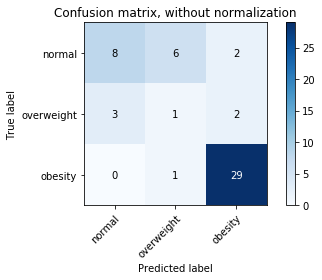

In [47]:
plot_confusion_matrix(y_test, y_pred, classes=class_names)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.50      0.59        16
           1       0.12      0.17      0.14         6
           2       0.88      0.97      0.92        30

    accuracy                           0.73        52
   macro avg       0.58      0.54      0.55        52
weighted avg       0.75      0.73      0.73        52



## Extra Tree Tuning

In [49]:
results_weighted = []
results_macro = []
names = []
num_tests = 3*3*3*2*2*4
i = 1

for min_samples_leaf in [1,3,5]:
    for min_samples_split in [2,4,6]:
        for max_depth in [3,5,8]:
            for max_features in ["log2","sqrt"]:
                for criterion in ["gini",  "entropy"]:
                    for n_estimators in [50, 100, 200, 500]:
                        print("Testing {}/{}".format(i,num_tests))
                        i+=1
                        kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
                        sm = SMOTE(random_state=seed, k_neighbors=7, sampling_strategy="not majority")
                        cv_results_weighted = np.array([])
                        cv_results_macro = np.array([])
                        for train_idx, test_idx, in kf.split(X_train, y_train):
                            X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
                            X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
                            X_cross_train, y_cross_train = sm.fit_sample(X_cross_train, y_cross_train)
                            model = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf, 
                                    min_samples_split=min_samples_split, max_depth=max_depth, max_features=max_features,                           
                                    criterion=criterion, n_estimators=n_estimators)
                            model.fit(X_cross_train, y_cross_train)  
                            y_pred = model.predict(X_cross_test)
                            f1s_weight = f1_score(y_cross_test, y_pred, average="weighted")
                            f1s_macro = f1_score(y_cross_test, y_pred, average="macro")
                            cv_results_weighted = np.append(cv_results_weighted, [f1s_weight])
                            cv_results_macro = np.append(cv_results_macro, [f1s_macro])
                        results_weighted.append(cv_results_weighted)
                        results_macro.append(cv_results_macro)
                        name = "{} {} {} {} {} {}".format(min_samples_leaf, min_samples_split, max_depth, 
                            max_features, criterion, n_estimators)
                        names.append(name)
                        msg = "%s: Weighted %f (%f)" % (name, cv_results_weighted.mean(), cv_results_weighted.std())
                        print(msg)
                        msg = "%s: Macro %f (%f)" % (name, cv_results_macro.mean(), cv_results_macro.std())
                        print(msg)

Testing 1/432
1 2 3 log2 gini 50: Weighted 0.821966 (0.072631)
1 2 3 log2 gini 50: Macro 0.719453 (0.089391)
Testing 2/432
1 2 3 log2 gini 100: Weighted 0.805145 (0.060472)
1 2 3 log2 gini 100: Macro 0.685759 (0.084529)
Testing 3/432
1 2 3 log2 gini 200: Weighted 0.819696 (0.087700)
1 2 3 log2 gini 200: Macro 0.720863 (0.123112)
Testing 4/432
1 2 3 log2 gini 500: Weighted 0.810839 (0.078934)
1 2 3 log2 gini 500: Macro 0.707476 (0.094278)
Testing 5/432
1 2 3 log2 entropy 50: Weighted 0.821538 (0.065574)
1 2 3 log2 entropy 50: Macro 0.718849 (0.079604)
Testing 6/432
1 2 3 log2 entropy 100: Weighted 0.808395 (0.065011)
1 2 3 log2 entropy 100: Macro 0.696636 (0.072282)
Testing 7/432
1 2 3 log2 entropy 200: Weighted 0.831310 (0.081029)
1 2 3 log2 entropy 200: Macro 0.738221 (0.107753)
Testing 8/432
1 2 3 log2 entropy 500: Weighted 0.810699 (0.091426)
1 2 3 log2 entropy 500: Macro 0.713630 (0.121218)
Testing 9/432
1 2 3 sqrt gini 50: Weighted 0.809008 (0.056127)
1 2 3 sqrt gini 50: Macro 0.6

1 4 5 sqrt gini 50: Weighted 0.817388 (0.054129)
1 4 5 sqrt gini 50: Macro 0.702524 (0.074655)
Testing 74/432
1 4 5 sqrt gini 100: Weighted 0.828989 (0.052823)
1 4 5 sqrt gini 100: Macro 0.717875 (0.072166)
Testing 75/432
1 4 5 sqrt gini 200: Weighted 0.844175 (0.055698)
1 4 5 sqrt gini 200: Macro 0.749488 (0.076889)
Testing 76/432
1 4 5 sqrt gini 500: Weighted 0.848545 (0.062042)
1 4 5 sqrt gini 500: Macro 0.757379 (0.087414)
Testing 77/432
1 4 5 sqrt entropy 50: Weighted 0.834976 (0.048236)
1 4 5 sqrt entropy 50: Macro 0.734682 (0.063802)
Testing 78/432
1 4 5 sqrt entropy 100: Weighted 0.827696 (0.058987)
1 4 5 sqrt entropy 100: Macro 0.720674 (0.075132)
Testing 79/432
1 4 5 sqrt entropy 200: Weighted 0.833269 (0.062395)
1 4 5 sqrt entropy 200: Macro 0.736727 (0.080986)
Testing 80/432
1 4 5 sqrt entropy 500: Weighted 0.838197 (0.063767)
1 4 5 sqrt entropy 500: Macro 0.744235 (0.084277)
Testing 81/432
1 4 8 log2 gini 50: Weighted 0.815535 (0.070481)
1 4 8 log2 gini 50: Macro 0.708830 

3 2 3 log2 gini 50: Weighted 0.807242 (0.084959)
3 2 3 log2 gini 50: Macro 0.704112 (0.111517)
Testing 146/432
3 2 3 log2 gini 100: Weighted 0.826909 (0.070253)
3 2 3 log2 gini 100: Macro 0.730899 (0.087707)
Testing 147/432
3 2 3 log2 gini 200: Weighted 0.813662 (0.081209)
3 2 3 log2 gini 200: Macro 0.716892 (0.116890)
Testing 148/432
3 2 3 log2 gini 500: Weighted 0.819498 (0.085587)
3 2 3 log2 gini 500: Macro 0.721793 (0.111645)
Testing 149/432
3 2 3 log2 entropy 50: Weighted 0.813810 (0.082222)
3 2 3 log2 entropy 50: Macro 0.707754 (0.104609)
Testing 150/432
3 2 3 log2 entropy 100: Weighted 0.809607 (0.092191)
3 2 3 log2 entropy 100: Macro 0.703018 (0.120820)
Testing 151/432
3 2 3 log2 entropy 200: Weighted 0.833267 (0.082444)
3 2 3 log2 entropy 200: Macro 0.743065 (0.114439)
Testing 152/432
3 2 3 log2 entropy 500: Weighted 0.814456 (0.075604)
3 2 3 log2 entropy 500: Macro 0.709638 (0.092761)
Testing 153/432
3 2 3 sqrt gini 50: Weighted 0.819135 (0.076818)
3 2 3 sqrt gini 50: Macro 0

3 4 5 log2 entropy 500: Weighted 0.838197 (0.063767)
3 4 5 log2 entropy 500: Macro 0.744235 (0.084277)
Testing 217/432
3 4 5 sqrt gini 50: Weighted 0.823409 (0.044222)
3 4 5 sqrt gini 50: Macro 0.710106 (0.053175)
Testing 218/432
3 4 5 sqrt gini 100: Weighted 0.821316 (0.054268)
3 4 5 sqrt gini 100: Macro 0.716984 (0.070625)
Testing 219/432
3 4 5 sqrt gini 200: Weighted 0.825017 (0.065956)
3 4 5 sqrt gini 200: Macro 0.727766 (0.084789)
Testing 220/432
3 4 5 sqrt gini 500: Weighted 0.837945 (0.076146)
3 4 5 sqrt gini 500: Macro 0.742109 (0.108640)
Testing 221/432
3 4 5 sqrt entropy 50: Weighted 0.820083 (0.056327)
3 4 5 sqrt entropy 50: Macro 0.716515 (0.070679)
Testing 222/432
3 4 5 sqrt entropy 100: Weighted 0.823023 (0.078791)
3 4 5 sqrt entropy 100: Macro 0.724313 (0.106333)
Testing 223/432
3 4 5 sqrt entropy 200: Weighted 0.820523 (0.071341)
3 4 5 sqrt entropy 200: Macro 0.720407 (0.091337)
Testing 224/432
3 4 5 sqrt entropy 500: Weighted 0.824097 (0.069833)
3 4 5 sqrt entropy 500:

3 6 8 sqrt entropy 200: Weighted 0.834073 (0.070100)
3 6 8 sqrt entropy 200: Macro 0.739266 (0.094300)
Testing 288/432
3 6 8 sqrt entropy 500: Weighted 0.828556 (0.064064)
3 6 8 sqrt entropy 500: Macro 0.733089 (0.082199)
Testing 289/432
5 2 3 log2 gini 50: Weighted 0.805440 (0.076448)
5 2 3 log2 gini 50: Macro 0.698069 (0.095217)
Testing 290/432
5 2 3 log2 gini 100: Weighted 0.801881 (0.067955)
5 2 3 log2 gini 100: Macro 0.690376 (0.083726)
Testing 291/432
5 2 3 log2 gini 200: Weighted 0.826527 (0.091289)
5 2 3 log2 gini 200: Macro 0.736539 (0.120871)
Testing 292/432
5 2 3 log2 gini 500: Weighted 0.817323 (0.082804)
5 2 3 log2 gini 500: Macro 0.720688 (0.107364)
Testing 293/432
5 2 3 log2 entropy 50: Weighted 0.807626 (0.087020)
5 2 3 log2 entropy 50: Macro 0.707861 (0.110760)
Testing 294/432
5 2 3 log2 entropy 100: Weighted 0.830389 (0.094108)
5 2 3 log2 entropy 100: Macro 0.747981 (0.120278)
Testing 295/432
5 2 3 log2 entropy 200: Weighted 0.805464 (0.080387)
5 2 3 log2 entropy 200:

5 4 5 log2 entropy 100: Weighted 0.819905 (0.077233)
5 4 5 log2 entropy 100: Macro 0.716722 (0.106840)
Testing 359/432
5 4 5 log2 entropy 200: Weighted 0.829857 (0.079373)
5 4 5 log2 entropy 200: Macro 0.737515 (0.106184)
Testing 360/432
5 4 5 log2 entropy 500: Weighted 0.819791 (0.063909)
5 4 5 log2 entropy 500: Macro 0.718432 (0.079842)
Testing 361/432
5 4 5 sqrt gini 50: Weighted 0.823325 (0.064971)
5 4 5 sqrt gini 50: Macro 0.718269 (0.087147)
Testing 362/432
5 4 5 sqrt gini 100: Weighted 0.832999 (0.082974)
5 4 5 sqrt gini 100: Macro 0.742355 (0.113390)
Testing 363/432
5 4 5 sqrt gini 200: Weighted 0.822984 (0.056108)
5 4 5 sqrt gini 200: Macro 0.719070 (0.065347)
Testing 364/432
5 4 5 sqrt gini 500: Weighted 0.824528 (0.072103)
5 4 5 sqrt gini 500: Macro 0.726739 (0.095057)
Testing 365/432
5 4 5 sqrt entropy 50: Weighted 0.823659 (0.063949)
5 4 5 sqrt entropy 50: Macro 0.722824 (0.077985)
Testing 366/432
5 4 5 sqrt entropy 100: Weighted 0.819307 (0.054608)
5 4 5 sqrt entropy 100:

5 6 8 sqrt entropy 50: Weighted 0.837640 (0.068815)
5 6 8 sqrt entropy 50: Macro 0.744618 (0.092138)
Testing 430/432
5 6 8 sqrt entropy 100: Weighted 0.814803 (0.062888)
5 6 8 sqrt entropy 100: Macro 0.706855 (0.083847)
Testing 431/432
5 6 8 sqrt entropy 200: Weighted 0.828409 (0.062170)
5 6 8 sqrt entropy 200: Macro 0.727808 (0.079701)
Testing 432/432
5 6 8 sqrt entropy 500: Weighted 0.820157 (0.065130)
5 6 8 sqrt entropy 500: Macro 0.718847 (0.082601)


In [50]:
import pickle
with open('names.pkl', 'wb') as f:
    pickle.dump(names, f)
with open('results_weighted.pkl', 'wb') as f:
    pickle.dump(results_weighted, f)
with open('results_macro.pkl', 'wb') as f:
    pickle.dump(results_macro, f)

In [51]:
avg_values_macro = [np.average(item) for item in results_macro]
avg_values_weighted = [np.average(item) for item in results_weighted]
max_index = avg_values_macro.index(max(avg_values_macro))
print("{} - Weighted: {} - Normal: {}".format(names[max_index], avg_values_macro[max_index], avg_values_weighted[max_index]))

3 4 8 log2 entropy 500 - Weighted: 0.7614206169625791 - Normal: 0.8470146292383633


In [52]:
model = ExtraTreesClassifier(min_samples_leaf=3, min_samples_split= 4, max_depth=8, 
                                    max_features="log2", criterion='entropy', n_estimators=500)

pipeline = Pipeline([('Scaler', StandardScaler()),('Model', model)])

pipeline.fit(X_train_res, y_train_res) 

y_pred = pipeline.predict(X_test) 

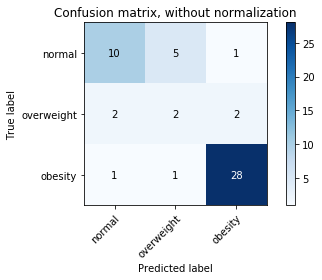

In [53]:
plot_confusion_matrix(y_test, y_pred, classes=class_names)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       0.25      0.33      0.29         6
           2       0.90      0.93      0.92        30

    accuracy                           0.77        52
   macro avg       0.64      0.63      0.63        52
weighted avg       0.79      0.77      0.77        52



## Summary

Buone prestazioni nell'identificare normal e obese, fatica a distingure gli overweight ma potrebbe derivare semplicemente dal minor numero di esempi.